In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import config
from spacy.lang.en import English
import spacy
spacy.prefer_gpu()
%matplotlib inline
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Concatenate,GlobalMaxPool2D,Multiply
from tensorflow.keras.layers import Dropout, Subtract, Add, GlobalAvgPool2D, Conv2D, Bidirectional
from tensorflow.keras.layers import Flatten, Dense, Embedding, LSTM, ZeroPadding2D, GRU
from tensorflow.keras.layers import BatchNormalization, MaxPooling2D, Concatenate, Lambda,concatenate
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam, Adadelta
from tensorflow.keras.initializers import glorot_uniform, Constant
from sklearn.model_selection import train_test_split
import os
import json
from DataGeneratorSiamese import DataGeneratorSiamese
from tqdm import tqdm
from processing import convertPAN_to_siamese_format_TIRA_siamese, write_solution

In [17]:
output_path = "/home/sukanya/PhD/CLEF/2021/runs/run_6_may_siamese_cosine_tira"
test_input_path = '/home/sukanya/PhD/Datasets/PAN SCD/pan21-style-change-detection/validation'
max_len = 300
max_words = 10000
embedding_dim = 50
training_path = config.config_io.get('pan_21_processed_train')
training_data = pd.read_csv(training_path)
tokenizer = get_tokenizer(training_data, max_words)
embed_matrix = get_embed_matrix(tokenizer, embedding_dim)
checkpoint_path = config.config_io.get("checkpoint_bilstm")
checkpoint_dir = os.path.dirname(checkpoint_path)
latest = tf.train.latest_checkpoint(checkpoint_dir)
model = create_model(max_len=max_len, 
                     tokenizer=tokenizer, 
                     embed_matrix=embed_matrix,
                    embedding_dim = embedding_dim)
model.load_weights(latest)

Found 400000 word vectors.
Loaded 400000 word vectors.
(55904, 50)
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 300)]        0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 300)]        0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 300, 50)      2795200     input_3[0][0]                    
                                                                 input_4[0][0]                    
__________________________________________________________________________________________________
bidirectional_1 (Bidirect

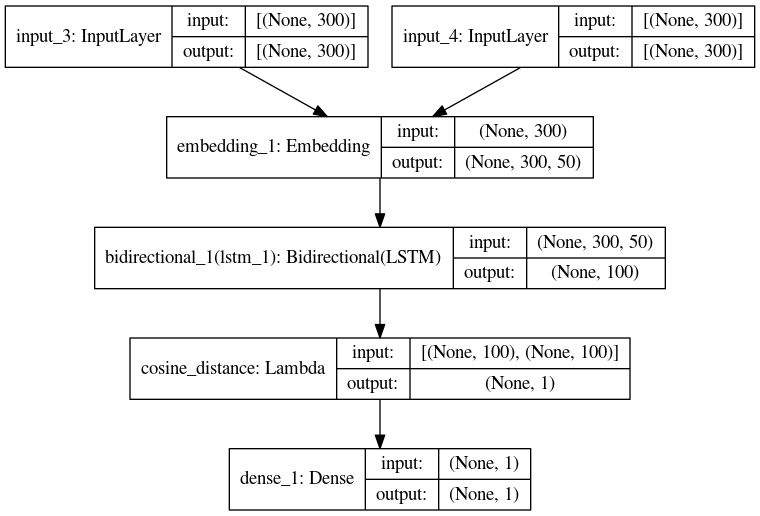

In [18]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model_lstm.png', show_shapes=True, show_layer_names=True)

In [3]:
def get_tokenizer(training_data, max_words):
    combined = training_data["para1_text"] + " " + training_data["para2_text"]
    tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
    tokenizer.fit_on_texts(combined.values)
    return tokenizer

In [4]:
def get_embed_matrix(tokenizer, embedding_dim):
    embeddings_index = {}
    f = open(config.config_io.get("embedding"))
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
    f.close()
    print('Found %s word vectors.' % len(embeddings_index))
    embed_matrix = get_glove_embed_matrix(tokenizer, embeddings_index, embedding_vector_size = embedding_dim)
    print(embed_matrix.shape)  
    return embed_matrix

In [5]:
def train_from_scratch(training_path, test_input_path, output_path, max_words = 10000,max_len = 300, 
                       embedding_dim = 50,  batch_size=64):
    print("Loading training file from path: ", config.config_io.get('pan_21_processed_train')) # pan_20_processed_train_wide
    training_data = pd.read_csv(training_path)
    tokenizer =  get_tokenizer(training_data, max_words)
    embed_matrix = get_embed_matrix(tokenizer, embedding_dim)
    len_train = len(training_data)
    training_generator = DataGeneratorSiamese(training_data.iloc[0:int(0.8*len_train)], tokenizer=tokenizer,max_len=max_len, batch_size=64)
    validation_generator = DataGeneratorSiamese(training_data.iloc[int(0.8*len_train):], tokenizer=tokenizer, max_len=max_len, batch_size=64)

    # this is a hack for "'DataGenerator' object has no attribute 'index'". It turns out that on_epoch_end creates the index that is used
    training_generator.on_epoch_end()
    validation_generator.on_epoch_end()
    model = create_model(max_len=max_len, 
                         tokenizer=tokenizer, 
                         embed_matrix=embed_matrix,
                        embedding_dim = embedding_dim)
    checkpoint_path = config.config_io.get("checkpoint")
    checkpoint_dir = os.path.dirname(checkpoint_path)
    cp_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_path, 
        verbose=1, 
        save_weights_only=True,
        save_freq=5*batch_size)
    model.save_weights(checkpoint_path.format(epoch=0))
    stop_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)#val_loss
    history = model.fit(training_generator, validation_data=validation_generator, verbose=1, batch_size=batch_size,
                             epochs=60, steps_per_epoch=100, callbacks=[cp_callback,stop_callback]) #, callbacks=[callback]
    return model

In [6]:
def get_PAN_test_files(test_input_path):      
    print(test_input_path)
    base = [file.split(".")[0] for file in os.listdir(test_input_path) if "txt" in file]
    problem_files = [file+".txt" for file in base] 
    return problem_files

In [7]:
def execute_PAN_test(test_input_path, model, output_path, tokenizer, max_len):
    problem_files = get_PAN_test_files(test_input_path)
    for i in tqdm(range(0, len(problem_files))):
        x = convertPAN_to_siamese_format_TIRA_siamese(test_input_path + "/" + problem_files[i], tokenizer, max_len)
        print("\n",problem_files[i])
        #print(x)
        y_pred = model.predict(x, verbose=1)
        changes= np.where(y_pred > 0.5, 1, 0).flatten().tolist()
        multi_author = 0
        if sum(changes)>=1:
            multi_author = 1
        paragraph_authors =  [0]*(len(changes)+1)
        sol_dict = {"multi-author":multi_author, "changes":changes,
                    "paragraph-authors":paragraph_authors}
        print(sol_dict)
        write_solution(problem_files[i], output_path, sol_dict)


In [8]:
def execute(test_input_path, output_path, train_again=False):
    max_len = 300
    max_words = 10000
    embedding_dim = 50
    training_path = config.config_io.get('pan_21_processed_train')
    training_data = pd.read_csv(training_path)
    tokenizer = get_tokenizer(training_data, max_words)
    if train_again:
        model = train_from_scratch(training_path=training_path, 
                                   test_input_path=test_input_path, 
                                   output_path=output_path, 
                                   max_len=max_len, 
                                   max_words =max_words, 
                                   embedding_dim=embedding_dim)
    else:
        
        embed_matrix = get_embed_matrix(tokenizer, embedding_dim)
        checkpoint_path = config.config_io.get("checkpoint")
        checkpoint_dir = os.path.dirname(checkpoint_path)
        latest = tf.train.latest_checkpoint(checkpoint_dir)
        model = create_model(max_len=max_len, 
                             tokenizer=tokenizer, 
                             embed_matrix=embed_matrix,
                            embedding_dim = embedding_dim)
        model.load_weights(latest)
    execute_PAN_test(test_input_path=test_input_path,
                     model=model, 
                     output_path=output_path, 
                     tokenizer=tokenizer, 
                     max_len=max_len)

In [16]:
def create_model(max_len, tokenizer, embed_matrix, embedding_dim):
    input_1 = Input(shape=(max_len,))#(train_p1_seq.shape[1],)
    input_2 = Input(shape=(max_len,))


    lstm_layer = Bidirectional(GRU(50, dropout=0.2, recurrent_dropout=0.2))
    #lstm_layer = tf.keras.layers.LSTM(50, name="common_lstm_layer")
    # max_words 10000 , embedding_dim = 50, max_len = 300
    embeddings_initializer = Constant(embed_matrix)
    emb =  Embedding(len(tokenizer.word_index)+1,
                     embedding_dim,
                     embeddings_initializer=embeddings_initializer,
                     input_length=max_len,
                     weights=[embed_matrix],
                     trainable=True)

    e1 = emb(input_1)
    x1 = lstm_layer(e1)

    e2 = emb(input_2)
    x2 = lstm_layer(e2)

    #concats = concatenate([x1, x2], axis=-1)
    #merged = Lambda(exponent_neg_cosine_distance, output_shape=(1,))(concats)

    mhd = lambda x: exponent_neg_cosine_distance(x[0], x[1]) #manh_lstm_distance
    merged = Lambda(function=mhd, output_shape=lambda x: x[0], name='cosine_distance')([x1, x2])
    preds = Dense(1, activation='sigmoid')(merged)
    model = Model(inputs=[input_1, input_2], outputs=preds)
    model.compile(loss="binary_crossentropy", metrics=['acc'], optimizer=Adam(clipnorm=1.5))
    print(model.summary())
    return model

In [10]:
def get_glove_embed_matrix(t, embeddings_index, embedding_vector_size = 50):
    """
    t: tokenizer

    """
    not_present_list = []
    vocab_size = len(t.word_index) + 1
    embedding_matrix = np.zeros((vocab_size, len(embeddings_index['no'])))
    for word, i in t.word_index.items():
        embedding_vector = None
        if word in embeddings_index.keys():
            embedding_vector = embeddings_index.get(word)
        else:
            not_present_list.append(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
        else:
            embedding_matrix[i] = np.zeros(embedding_vector_size) # size of the embedding
    print('Loaded %s word vectors.' % len(embeddings_index))
    return embedding_matrix


In [11]:
def exponent_neg_cosine_distance(left,right):
    left = tf.keras.backend.l2_normalize(left, axis=-1)
    right = tf.keras.backend.l2_normalize(right, axis=-1)
    return tf.keras.backend.exp(tf.keras.backend.sum(tf.keras.backend.prod([left, right], axis=0), axis=1, keepdims=True))

In [12]:
def manh_lstm_distance(left, right):
    distance = tf.keras.backend.abs(left-right)
    distance = tf.keras.backend.sum(distance, axis=1, keepdims=True)
    distance = -distance
    distance = tf.keras.backend.exp(distance)
    return distance


In [13]:
def exponent_neg_euclidean_distance(left, right):
    distance = tf.keras.backend.square(left-right)
    distance = tf.keras.backend.sum(distance, axis=1, keepdims=True)
    distance = tf.keras.backend.sqrt(distance, axis = 1, keepdims = True)
    distance = tf.keras.backend.exp(-distance)
    return distance


In [ ]:
output_path = "/home/sukanya/PhD/CLEF/2021/runs/run_6_may_siamese_cosine_tira"
test_input_path = '/home/sukanya/PhD/Datasets/PAN SCD/pan21-style-change-detection/validation'
execute(test_input_path, output_path, train_again=False)

Found 400000 word vectors.
Loaded 400000 word vectors.
(55904, 50)
Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 300)]        0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, 300)]        0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 300, 50)      2795200     input_5[0][0]                    
                                                                 input_6[0][0]                    
__________________________________________________________________________________________________
bidirectional_2 (Bidirect

1/1 [==============================] - 0s 48ms/step
{'multi-author': 1, 'changes': [0, 1, 1, 0, 1, 1, 0, 1], 'paragraph-authors': [0, 0, 0, 0, 0, 0, 0, 0, 0]}
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_6_may_siamese_cosine_tira/solution-problem-899.json

 problem-566.txt
1/1 [==============================] - 0s 41ms/step
{'multi-author': 1, 'changes': [1, 1, 1, 0, 0, 0], 'paragraph-authors': [0, 0, 0, 0, 0, 0, 0]}
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_6_may_siamese_cosine_tira/solution-problem-566.json

 problem-377.txt
1/1 [==============================] - 0s 42ms/step
{'multi-author': 1, 'changes': [1, 0, 0, 1, 0, 0, 1], 'paragraph-authors': [0, 0, 0, 0, 0, 0, 0, 0]}
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_6_may_siamese_cosine_tira/solution-problem-377.json

 problem-1325.txt
1/1 [==============================] - 0s 41ms/step
{'multi-author': 1, 'changes': [0, 0, 1, 0, 0], 'paragraph-authors': [0, 0, 0, 0, 0, 0]}
Writing in path: /home/suka

1/1 [==============================] - 0s 41ms/step
{'multi-author': 1, 'changes': [1], 'paragraph-authors': [0, 0]}
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_6_may_siamese_cosine_tira/solution-problem-803.json

 problem-1240.txt
1/1 [==============================] - 0s 40ms/step
{'multi-author': 1, 'changes': [0, 0, 0, 1, 1, 0], 'paragraph-authors': [0, 0, 0, 0, 0, 0, 0]}
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_6_may_siamese_cosine_tira/solution-problem-1240.json

 problem-2202.txt
1/1 [==============================] - 0s 39ms/step
{'multi-author': 1, 'changes': [0, 1, 1, 0, 1], 'paragraph-authors': [0, 0, 0, 0, 0, 0]}
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_6_may_siamese_cosine_tira/solution-problem-2202.json

 problem-2381.txt
1/1 [==============================] - 0s 39ms/step
{'multi-author': 1, 'changes': [0, 1, 0, 1, 0], 'paragraph-authors': [0, 0, 0, 0, 0, 0]}
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_6_may_siamese_cosine_ti

{'multi-author': 1, 'changes': [1, 1, 0], 'paragraph-authors': [0, 0, 0, 0]}
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_6_may_siamese_cosine_tira/solution-problem-313.json

 problem-150.txt
1/1 [==============================] - 0s 44ms/step
{'multi-author': 0, 'changes': [0, 0, 0, 0, 0, 0, 0, 0], 'paragraph-authors': [0, 0, 0, 0, 0, 0, 0, 0, 0]}
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_6_may_siamese_cosine_tira/solution-problem-150.json

 problem-2355.txt
1/1 [==============================] - 0s 43ms/step
{'multi-author': 1, 'changes': [0, 1, 0, 0, 1, 1, 0, 0], 'paragraph-authors': [0, 0, 0, 0, 0, 0, 0, 0, 0]}
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_6_may_siamese_cosine_tira/solution-problem-2355.json

 problem-570.txt
1/1 [==============================] - 0s 44ms/step
{'multi-author': 1, 'changes': [1, 1, 1, 1, 0, 0, 0, 0], 'paragraph-authors': [0, 0, 0, 0, 0, 0, 0, 0, 0]}
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_6_may_siamese_cosi

1/1 [==============================] - 0s 44ms/step
{'multi-author': 1, 'changes': [0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1], 'paragraph-authors': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_6_may_siamese_cosine_tira/solution-problem-1725.json

 problem-1439.txt
1/1 [==============================] - 0s 40ms/step
{'multi-author': 1, 'changes': [1, 0, 0, 0], 'paragraph-authors': [0, 0, 0, 0, 0]}
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_6_may_siamese_cosine_tira/solution-problem-1439.json

 problem-474.txt
1/1 [==============================] - 0s 44ms/step
{'multi-author': 1, 'changes': [1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1], 'paragraph-authors': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_6_may_siamese_cosine_tira/solution-problem-474.json

 problem-927.txt
1/1 [==============================] - 0s 39ms/step
{'multi-author': 1, 'changes': [0, 0, 1, 1, 0], 'paragraph-authors': [0, 0, 0, 0, 0,

1/1 [==============================] - 0s 42ms/step
{'multi-author': 1, 'changes': [1, 1, 0, 1], 'paragraph-authors': [0, 0, 0, 0, 0]}
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_6_may_siamese_cosine_tira/solution-problem-1304.json

 problem-788.txt
1/1 [==============================] - 0s 44ms/step
{'multi-author': 1, 'changes': [1, 0, 0, 1, 1], 'paragraph-authors': [0, 0, 0, 0, 0, 0]}
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_6_may_siamese_cosine_tira/solution-problem-788.json

 problem-550.txt
1/1 [==============================] - 0s 42ms/step
{'multi-author': 1, 'changes': [0, 0, 1, 0, 1, 1, 1, 1, 1], 'paragraph-authors': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_6_may_siamese_cosine_tira/solution-problem-550.json

 problem-1177.txt
1/1 [==============================] - 0s 43ms/step
{'multi-author': 1, 'changes': [0, 0, 1, 0, 0], 'paragraph-authors': [0, 0, 0, 0, 0, 0]}
Writing in path: /home/sukanya/PhD/CLEF/2021

1/1 [==============================] - 0s 44ms/step
{'multi-author': 1, 'changes': [0, 0, 0, 1, 1, 0], 'paragraph-authors': [0, 0, 0, 0, 0, 0, 0]}
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_6_may_siamese_cosine_tira/solution-problem-2053.json

 problem-595.txt
1/1 [==============================] - 0s 41ms/step
{'multi-author': 1, 'changes': [0, 0, 1, 1, 0, 0], 'paragraph-authors': [0, 0, 0, 0, 0, 0, 0]}
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_6_may_siamese_cosine_tira/solution-problem-595.json

 problem-222.txt
1/1 [==============================] - 0s 40ms/step
{'multi-author': 1, 'changes': [0, 1, 1, 1, 1], 'paragraph-authors': [0, 0, 0, 0, 0, 0]}
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_6_may_siamese_cosine_tira/solution-problem-222.json

 problem-2184.txt
1/1 [==============================] - 0s 44ms/step
{'multi-author': 1, 'changes': [0, 1, 1, 1], 'paragraph-authors': [0, 0, 0, 0, 0]}
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_6_

1/1 [==============================] - 0s 42ms/step
{'multi-author': 1, 'changes': [0, 1, 1, 0], 'paragraph-authors': [0, 0, 0, 0, 0]}
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_6_may_siamese_cosine_tira/solution-problem-1658.json

 problem-2254.txt
1/1 [==============================] - 0s 41ms/step
{'multi-author': 1, 'changes': [0, 1, 1, 0], 'paragraph-authors': [0, 0, 0, 0, 0]}
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_6_may_siamese_cosine_tira/solution-problem-2254.json

 problem-59.txt
1/1 [==============================] - 0s 40ms/step
{'multi-author': 1, 'changes': [1, 0, 1, 0, 0, 1], 'paragraph-authors': [0, 0, 0, 0, 0, 0, 0]}
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_6_may_siamese_cosine_tira/solution-problem-59.json

 problem-132.txt
1/1 [==============================] - 0s 40ms/step
{'multi-author': 1, 'changes': [1, 1, 0], 'paragraph-authors': [0, 0, 0, 0]}
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_6_may_siamese_cosine_tira/s

1/1 [==============================] - 0s 40ms/step
{'multi-author': 0, 'changes': [0, 0], 'paragraph-authors': [0, 0, 0]}
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_6_may_siamese_cosine_tira/solution-problem-1373.json

 problem-79.txt
1/1 [==============================] - 0s 38ms/step
{'multi-author': 0, 'changes': [0, 0, 0], 'paragraph-authors': [0, 0, 0, 0]}
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_6_may_siamese_cosine_tira/solution-problem-79.json

 problem-2252.txt
1/1 [==============================] - 0s 41ms/step
{'multi-author': 1, 'changes': [0, 1, 1], 'paragraph-authors': [0, 0, 0, 0]}
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_6_may_siamese_cosine_tira/solution-problem-2252.json

 problem-1487.txt
1/1 [==============================] - 0s 40ms/step
{'multi-author': 1, 'changes': [1, 1, 1, 0, 0, 0, 0, 0, 0], 'paragraph-authors': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_6_may_siamese_cosine_tira/

1/1 [==============================] - 0s 39ms/step
{'multi-author': 1, 'changes': [1, 0, 1, 0, 0], 'paragraph-authors': [0, 0, 0, 0, 0, 0]}
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_6_may_siamese_cosine_tira/solution-problem-386.json

 problem-2098.txt
1/1 [==============================] - 0s 41ms/step
{'multi-author': 1, 'changes': [1, 1, 1, 1, 0, 0], 'paragraph-authors': [0, 0, 0, 0, 0, 0, 0]}
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_6_may_siamese_cosine_tira/solution-problem-2098.json

 problem-1482.txt
1/1 [==============================] - 0s 43ms/step
{'multi-author': 0, 'changes': [0, 0], 'paragraph-authors': [0, 0, 0]}
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_6_may_siamese_cosine_tira/solution-problem-1482.json

 problem-185.txt
1/1 [==============================] - 0s 40ms/step
{'multi-author': 1, 'changes': [0, 1, 1, 1, 1, 1, 0], 'paragraph-authors': [0, 0, 0, 0, 0, 0, 0, 0]}
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_6_may_

1/1 [==============================] - 0s 44ms/step
{'multi-author': 1, 'changes': [1, 1, 1, 1], 'paragraph-authors': [0, 0, 0, 0, 0]}
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_6_may_siamese_cosine_tira/solution-problem-2370.json

 problem-1167.txt
1/1 [==============================] - 0s 46ms/step
{'multi-author': 1, 'changes': [1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1], 'paragraph-authors': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_6_may_siamese_cosine_tira/solution-problem-1167.json

 problem-774.txt
1/1 [==============================] - 0s 42ms/step
{'multi-author': 1, 'changes': [1, 1, 0, 1, 1], 'paragraph-authors': [0, 0, 0, 0, 0, 0]}
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_6_may_siamese_cosine_tira/solution-problem-774.json

 problem-310.txt
1/1 [==============================] - 0s 43ms/step
{'multi-author': 1, 'changes': [0, 0, 0, 1, 0, 0], 'paragraph-authors': [0, 0, 0, 0, 0, 0, 0]}
Writing in path: /h

1/1 [==============================] - 0s 41ms/step
{'multi-author': 0, 'changes': [0, 0, 0], 'paragraph-authors': [0, 0, 0, 0]}
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_6_may_siamese_cosine_tira/solution-problem-2243.json

 problem-384.txt
1/1 [==============================] - 0s 41ms/step
{'multi-author': 1, 'changes': [1, 0, 1, 1], 'paragraph-authors': [0, 0, 0, 0, 0]}
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_6_may_siamese_cosine_tira/solution-problem-384.json

 problem-934.txt
1/1 [==============================] - 0s 42ms/step
{'multi-author': 1, 'changes': [0, 0, 0, 0, 0, 1, 1], 'paragraph-authors': [0, 0, 0, 0, 0, 0, 0, 0]}
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_6_may_siamese_cosine_tira/solution-problem-934.json

 problem-1521.txt
1/1 [==============================] - 0s 40ms/step
{'multi-author': 1, 'changes': [0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1], 'paragraph-authors': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}
Writing in path: /home/sukanya/P

1/1 [==============================] - 0s 41ms/step
{'multi-author': 1, 'changes': [0, 0, 0, 0, 1, 1, 1], 'paragraph-authors': [0, 0, 0, 0, 0, 0, 0, 0]}
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_6_may_siamese_cosine_tira/solution-problem-1207.json

 problem-656.txt
1/1 [==============================] - 0s 43ms/step
{'multi-author': 1, 'changes': [1, 1, 1, 0], 'paragraph-authors': [0, 0, 0, 0, 0]}
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_6_may_siamese_cosine_tira/solution-problem-656.json

 problem-1538.txt
1/1 [==============================] - 0s 41ms/step
{'multi-author': 1, 'changes': [0, 0, 1, 1, 1, 0, 1, 1, 0, 1], 'paragraph-authors': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_6_may_siamese_cosine_tira/solution-problem-1538.json

 problem-1719.txt
1/1 [==============================] - 0s 40ms/step
{'multi-author': 1, 'changes': [1, 1, 1, 1], 'paragraph-authors': [0, 0, 0, 0, 0]}
Writing in path: /home/sukanya

1/1 [==============================] - 0s 44ms/step
{'multi-author': 1, 'changes': [0, 1, 0, 1, 1, 1, 0, 0, 0, 1], 'paragraph-authors': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_6_may_siamese_cosine_tira/solution-problem-2237.json

 problem-265.txt
1/1 [==============================] - 0s 41ms/step
{'multi-author': 1, 'changes': [1, 0, 1, 1], 'paragraph-authors': [0, 0, 0, 0, 0]}
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_6_may_siamese_cosine_tira/solution-problem-265.json

 problem-286.txt
1/1 [==============================] - 0s 44ms/step
{'multi-author': 0, 'changes': [0, 0], 'paragraph-authors': [0, 0, 0]}
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_6_may_siamese_cosine_tira/solution-problem-286.json

 problem-1237.txt
1/1 [==============================] - 0s 42ms/step
{'multi-author': 1, 'changes': [0, 0, 1, 0, 0, 0], 'paragraph-authors': [0, 0, 0, 0, 0, 0, 0]}
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/

1/1 [==============================] - 0s 45ms/step
{'multi-author': 1, 'changes': [1, 1, 0, 1, 0, 0, 1, 1, 0], 'paragraph-authors': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_6_may_siamese_cosine_tira/solution-problem-227.json

 problem-1356.txt
1/1 [==============================] - 0s 42ms/step
{'multi-author': 0, 'changes': [0, 0], 'paragraph-authors': [0, 0, 0]}
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_6_may_siamese_cosine_tira/solution-problem-1356.json

 problem-1571.txt
1/1 [==============================] - 0s 44ms/step
{'multi-author': 1, 'changes': [1, 1, 1, 0, 0, 0, 1, 1, 1], 'paragraph-authors': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_6_may_siamese_cosine_tira/solution-problem-1571.json

 problem-456.txt
1/1 [==============================] - 0s 41ms/step
{'multi-author': 0, 'changes': [0, 0, 0, 0, 0, 0, 0, 0], 'paragraph-authors': [0, 0, 0, 0, 0, 0, 0, 0, 0]}
Writing in p

{'multi-author': 1, 'changes': [1, 0, 0, 0, 0, 0, 0, 0], 'paragraph-authors': [0, 0, 0, 0, 0, 0, 0, 0, 0]}
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_6_may_siamese_cosine_tira/solution-problem-1747.json

 problem-1636.txt
1/1 [==============================] - 0s 42ms/step
{'multi-author': 0, 'changes': [0, 0, 0, 0, 0, 0, 0, 0], 'paragraph-authors': [0, 0, 0, 0, 0, 0, 0, 0, 0]}
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_6_may_siamese_cosine_tira/solution-problem-1636.json

 problem-1055.txt
1/1 [==============================] - 0s 40ms/step
{'multi-author': 0, 'changes': [0, 0, 0, 0], 'paragraph-authors': [0, 0, 0, 0, 0]}
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_6_may_siamese_cosine_tira/solution-problem-1055.json

 problem-1978.txt
1/1 [==============================] - 0s 41ms/step
{'multi-author': 1, 'changes': [1, 0, 1, 1], 'paragraph-authors': [0, 0, 0, 0, 0]}
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_6_may_siamese_cosine_tira/soluti

1/1 [==============================] - 0s 42ms/step
{'multi-author': 1, 'changes': [0, 1, 1, 0, 1], 'paragraph-authors': [0, 0, 0, 0, 0, 0]}
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_6_may_siamese_cosine_tira/solution-problem-1587.json

 problem-729.txt
1/1 [==============================] - 0s 43ms/step
{'multi-author': 1, 'changes': [0, 0, 1, 0, 1, 0], 'paragraph-authors': [0, 0, 0, 0, 0, 0, 0]}
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_6_may_siamese_cosine_tira/solution-problem-729.json

 problem-1764.txt
1/1 [==============================] - 0s 44ms/step
{'multi-author': 1, 'changes': [0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1], 'paragraph-authors': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_6_may_siamese_cosine_tira/solution-problem-1764.json

 problem-1502.txt
1/1 [==============================] - 0s 42ms/step
{'multi-author': 1, 'changes': [1, 1, 0, 0, 0], 'paragraph-authors': [0, 0, 0, 0, 0, 0]}
Writing in p

1/1 [==============================] - 0s 40ms/step
{'multi-author': 1, 'changes': [0, 0, 1, 1], 'paragraph-authors': [0, 0, 0, 0, 0]}
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_6_may_siamese_cosine_tira/solution-problem-258.json

 problem-905.txt
1/1 [==============================] - 0s 41ms/step
{'multi-author': 1, 'changes': [0, 1, 1, 1, 0, 0, 1], 'paragraph-authors': [0, 0, 0, 0, 0, 0, 0, 0]}
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_6_may_siamese_cosine_tira/solution-problem-905.json

 problem-454.txt
1/1 [==============================] - 0s 39ms/step
{'multi-author': 1, 'changes': [0, 1, 1, 0, 1], 'paragraph-authors': [0, 0, 0, 0, 0, 0]}
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_6_may_siamese_cosine_tira/solution-problem-454.json

 problem-848.txt
1/1 [==============================] - 0s 42ms/step
{'multi-author': 1, 'changes': [1, 1, 1, 1, 1], 'paragraph-authors': [0, 0, 0, 0, 0, 0]}
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_6_ma

1/1 [==============================] - 0s 42ms/step
{'multi-author': 1, 'changes': [1, 1], 'paragraph-authors': [0, 0, 0]}
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_6_may_siamese_cosine_tira/solution-problem-907.json

 problem-2056.txt
1/1 [==============================] - 0s 40ms/step
{'multi-author': 1, 'changes': [1, 1, 1, 1, 0], 'paragraph-authors': [0, 0, 0, 0, 0, 0]}
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_6_may_siamese_cosine_tira/solution-problem-2056.json

 problem-1348.txt
1/1 [==============================] - 0s 43ms/step
{'multi-author': 1, 'changes': [0, 0, 0, 1, 0, 0, 0, 0, 0, 0], 'paragraph-authors': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_6_may_siamese_cosine_tira/solution-problem-1348.json

 problem-1467.txt
1/1 [==============================] - 0s 40ms/step
{'multi-author': 1, 'changes': [1, 1, 0, 1], 'paragraph-authors': [0, 0, 0, 0, 0]}
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run

1/1 [==============================] - 0s 40ms/step
{'multi-author': 1, 'changes': [1, 1, 1, 1], 'paragraph-authors': [0, 0, 0, 0, 0]}
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_6_may_siamese_cosine_tira/solution-problem-2128.json

 problem-368.txt
1/1 [==============================] - 0s 42ms/step
{'multi-author': 1, 'changes': [1, 1, 1, 1, 0], 'paragraph-authors': [0, 0, 0, 0, 0, 0]}
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_6_may_siamese_cosine_tira/solution-problem-368.json

 problem-1699.txt
1/1 [==============================] - 0s 43ms/step
{'multi-author': 1, 'changes': [0, 1, 1, 0, 0], 'paragraph-authors': [0, 0, 0, 0, 0, 0]}
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_6_may_siamese_cosine_tira/solution-problem-1699.json

 problem-1827.txt
1/1 [==============================] - 0s 41ms/step
{'multi-author': 1, 'changes': [0, 1, 1, 0, 0, 1, 1], 'paragraph-authors': [0, 0, 0, 0, 0, 0, 0, 0]}
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_

1/1 [==============================] - 0s 43ms/step
{'multi-author': 1, 'changes': [0, 1, 1], 'paragraph-authors': [0, 0, 0, 0]}
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_6_may_siamese_cosine_tira/solution-problem-1737.json

 problem-547.txt
1/1 [==============================] - 0s 44ms/step
{'multi-author': 1, 'changes': [1, 0, 1, 1, 0, 1], 'paragraph-authors': [0, 0, 0, 0, 0, 0, 0]}
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_6_may_siamese_cosine_tira/solution-problem-547.json

 problem-1239.txt
1/1 [==============================] - 0s 42ms/step
{'multi-author': 1, 'changes': [0, 0, 1, 0, 0], 'paragraph-authors': [0, 0, 0, 0, 0, 0]}
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_6_may_siamese_cosine_tira/solution-problem-1239.json

 problem-1309.txt
1/1 [==============================] - 0s 43ms/step
{'multi-author': 1, 'changes': [1, 0, 1], 'paragraph-authors': [0, 0, 0, 0]}
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_6_may_siamese_cosine_tir

1/1 [==============================] - 0s 41ms/step
{'multi-author': 0, 'changes': [0, 0], 'paragraph-authors': [0, 0, 0]}
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_6_may_siamese_cosine_tira/solution-problem-1164.json

 problem-890.txt
1/1 [==============================] - 0s 39ms/step
{'multi-author': 1, 'changes': [1, 1, 1, 1], 'paragraph-authors': [0, 0, 0, 0, 0]}
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_6_may_siamese_cosine_tira/solution-problem-890.json

 problem-296.txt
1/1 [==============================] - 0s 43ms/step
{'multi-author': 0, 'changes': [0, 0, 0, 0, 0], 'paragraph-authors': [0, 0, 0, 0, 0, 0]}
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_6_may_siamese_cosine_tira/solution-problem-296.json

 problem-1618.txt
1/1 [==============================] - 0s 41ms/step
{'multi-author': 1, 'changes': [0, 1, 1], 'paragraph-authors': [0, 0, 0, 0]}
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_6_may_siamese_cosine_tira/solution-problem-1

1/1 [==============================] - 0s 42ms/step
{'multi-author': 1, 'changes': [0, 1, 0], 'paragraph-authors': [0, 0, 0, 0]}
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_6_may_siamese_cosine_tira/solution-problem-1998.json

 problem-1889.txt
1/1 [==============================] - 0s 40ms/step
{'multi-author': 0, 'changes': [0, 0, 0], 'paragraph-authors': [0, 0, 0, 0]}
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_6_may_siamese_cosine_tira/solution-problem-1889.json

 problem-2060.txt
1/1 [==============================] - 0s 42ms/step
{'multi-author': 1, 'changes': [0, 0, 1, 1, 1, 0], 'paragraph-authors': [0, 0, 0, 0, 0, 0, 0]}
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_6_may_siamese_cosine_tira/solution-problem-2060.json

 problem-2341.txt
1/1 [==============================] - 0s 41ms/step
{'multi-author': 1, 'changes': [1, 1, 1, 1, 0, 0, 0, 0, 1, 1], 'paragraph-authors': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}
Writing in path: /home/sukanya/PhD/CLEF/2021/r

1/1 [==============================] - 0s 44ms/step
{'multi-author': 1, 'changes': [0, 1, 1], 'paragraph-authors': [0, 0, 0, 0]}
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_6_may_siamese_cosine_tira/solution-problem-1284.json

 problem-644.txt
1/1 [==============================] - 0s 43ms/step
{'multi-author': 1, 'changes': [1, 1, 0, 1, 1, 1, 1, 1, 0], 'paragraph-authors': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_6_may_siamese_cosine_tira/solution-problem-644.json

 problem-1490.txt
1/1 [==============================] - 0s 43ms/step
{'multi-author': 0, 'changes': [0, 0, 0], 'paragraph-authors': [0, 0, 0, 0]}
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_6_may_siamese_cosine_tira/solution-problem-1490.json

 problem-2153.txt
1/1 [==============================] - 0s 40ms/step
{'multi-author': 1, 'changes': [1, 1, 1], 'paragraph-authors': [0, 0, 0, 0]}
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_6_may_siamese_cosi

1/1 [==============================] - 0s 41ms/step
{'multi-author': 1, 'changes': [1, 0, 1, 1, 1], 'paragraph-authors': [0, 0, 0, 0, 0, 0]}
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_6_may_siamese_cosine_tira/solution-problem-279.json

 problem-599.txt
1/1 [==============================] - 0s 40ms/step
{'multi-author': 0, 'changes': [0, 0, 0, 0, 0, 0], 'paragraph-authors': [0, 0, 0, 0, 0, 0, 0]}
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_6_may_siamese_cosine_tira/solution-problem-599.json

 problem-1968.txt
1/1 [==============================] - 0s 38ms/step
{'multi-author': 1, 'changes': [1, 1, 0, 0], 'paragraph-authors': [0, 0, 0, 0, 0]}
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_6_may_siamese_cosine_tira/solution-problem-1968.json

 problem-2300.txt
1/1 [==============================] - 0s 41ms/step
{'multi-author': 1, 'changes': [1, 0, 1], 'paragraph-authors': [0, 0, 0, 0]}
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_6_may_siamese_cosin

1/1 [==============================] - 0s 41ms/step
{'multi-author': 1, 'changes': [0, 0, 0, 0, 0, 1, 1], 'paragraph-authors': [0, 0, 0, 0, 0, 0, 0, 0]}
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_6_may_siamese_cosine_tira/solution-problem-2345.json

 problem-2236.txt
1/1 [==============================] - 0s 40ms/step
{'multi-author': 1, 'changes': [1, 0, 1, 0, 0, 0], 'paragraph-authors': [0, 0, 0, 0, 0, 0, 0]}
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_6_may_siamese_cosine_tira/solution-problem-2236.json

 problem-1420.txt
1/1 [==============================] - 0s 41ms/step
{'multi-author': 1, 'changes': [0, 1, 1, 1], 'paragraph-authors': [0, 0, 0, 0, 0]}
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_6_may_siamese_cosine_tira/solution-problem-1420.json

 problem-2010.txt
1/1 [==============================] - 0s 41ms/step
{'multi-author': 1, 'changes': [0, 1, 1, 1, 1], 'paragraph-authors': [0, 0, 0, 0, 0, 0]}
Writing in path: /home/sukanya/PhD/CLEF/2021/r

1/1 [==============================] - 0s 43ms/step
{'multi-author': 1, 'changes': [0, 0, 1, 0, 0, 0, 1, 1, 1], 'paragraph-authors': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_6_may_siamese_cosine_tira/solution-problem-363.json

 problem-1672.txt
1/1 [==============================] - 0s 40ms/step
{'multi-author': 1, 'changes': [1, 1], 'paragraph-authors': [0, 0, 0]}
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_6_may_siamese_cosine_tira/solution-problem-1672.json

 problem-847.txt
1/1 [==============================] - 0s 44ms/step
{'multi-author': 1, 'changes': [1, 1, 0, 1, 1, 1, 1, 0, 1], 'paragraph-authors': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_6_may_siamese_cosine_tira/solution-problem-847.json

 problem-406.txt
1/1 [==============================] - 0s 42ms/step
{'multi-author': 1, 'changes': [1, 1, 1, 1, 1, 0, 1, 1, 0], 'paragraph-authors': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}
Writing 

1/1 [==============================] - 0s 38ms/step
{'multi-author': 1, 'changes': [1, 1, 1, 0, 0, 0], 'paragraph-authors': [0, 0, 0, 0, 0, 0, 0]}
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_6_may_siamese_cosine_tira/solution-problem-1596.json

 problem-1492.txt
1/1 [==============================] - 0s 40ms/step
{'multi-author': 1, 'changes': [0, 0, 0, 0, 1, 1, 1], 'paragraph-authors': [0, 0, 0, 0, 0, 0, 0, 0]}
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_6_may_siamese_cosine_tira/solution-problem-1492.json

 problem-70.txt
1/1 [==============================] - 0s 42ms/step
{'multi-author': 0, 'changes': [0, 0, 0, 0], 'paragraph-authors': [0, 0, 0, 0, 0]}
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_6_may_siamese_cosine_tira/solution-problem-70.json

 problem-1480.txt
1/1 [==============================] - 0s 44ms/step
{'multi-author': 1, 'changes': [0, 1, 0, 1, 0, 1], 'paragraph-authors': [0, 0, 0, 0, 0, 0, 0]}
Writing in path: /home/sukanya/PhD/CLEF/2021

1/1 [==============================] - 0s 39ms/step
{'multi-author': 1, 'changes': [1, 0, 0, 0, 1, 0, 1, 1], 'paragraph-authors': [0, 0, 0, 0, 0, 0, 0, 0, 0]}
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_6_may_siamese_cosine_tira/solution-problem-811.json

 problem-2231.txt
1/1 [==============================] - 0s 39ms/step
{'multi-author': 1, 'changes': [1, 0], 'paragraph-authors': [0, 0, 0]}
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_6_may_siamese_cosine_tira/solution-problem-2231.json

 problem-1342.txt
1/1 [==============================] - 0s 41ms/step
{'multi-author': 1, 'changes': [1, 1, 0, 0, 0, 1, 1, 1, 0], 'paragraph-authors': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_6_may_siamese_cosine_tira/solution-problem-1342.json

 problem-2063.txt
1/1 [==============================] - 0s 38ms/step
{'multi-author': 1, 'changes': [1, 1], 'paragraph-authors': [0, 0, 0]}
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run

1/1 [==============================] - 0s 43ms/step
{'multi-author': 0, 'changes': [0, 0, 0, 0], 'paragraph-authors': [0, 0, 0, 0, 0]}
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_6_may_siamese_cosine_tira/solution-problem-940.json

 problem-860.txt
1/1 [==============================] - 0s 41ms/step
{'multi-author': 1, 'changes': [1, 1, 1, 0, 0], 'paragraph-authors': [0, 0, 0, 0, 0, 0]}
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_6_may_siamese_cosine_tira/solution-problem-860.json

 problem-2204.txt
1/1 [==============================] - 0s 40ms/step
{'multi-author': 1, 'changes': [0, 1, 1, 1, 0], 'paragraph-authors': [0, 0, 0, 0, 0, 0]}
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_6_may_siamese_cosine_tira/solution-problem-2204.json

 problem-1252.txt
1/1 [==============================] - 0s 41ms/step
{'multi-author': 1, 'changes': [1, 1, 0, 0, 1, 1, 1, 0, 0, 1], 'paragraph-authors': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}
Writing in path: /home/sukanya/PhD/CL

1/1 [==============================] - 0s 39ms/step
{'multi-author': 0, 'changes': [0, 0], 'paragraph-authors': [0, 0, 0]}
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_6_may_siamese_cosine_tira/solution-problem-1727.json

 problem-1829.txt
1/1 [==============================] - 0s 46ms/step
{'multi-author': 1, 'changes': [0, 1, 0, 1, 1, 1], 'paragraph-authors': [0, 0, 0, 0, 0, 0, 0]}
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_6_may_siamese_cosine_tira/solution-problem-1829.json

 problem-1388.txt
1/1 [==============================] - 0s 41ms/step
{'multi-author': 1, 'changes': [0, 1, 1, 0, 1, 1, 0, 0], 'paragraph-authors': [0, 0, 0, 0, 0, 0, 0, 0, 0]}
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_6_may_siamese_cosine_tira/solution-problem-1388.json

 problem-1000.txt
1/1 [==============================] - 0s 40ms/step
{'multi-author': 1, 'changes': [1, 1, 0], 'paragraph-authors': [0, 0, 0, 0]}
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_6_may_siam

1/1 [==============================] - 0s 41ms/step
{'multi-author': 1, 'changes': [0, 0, 0, 0, 0, 1], 'paragraph-authors': [0, 0, 0, 0, 0, 0, 0]}
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_6_may_siamese_cosine_tira/solution-problem-354.json

 problem-1859.txt
1/1 [==============================] - 0s 42ms/step
{'multi-author': 1, 'changes': [1, 1], 'paragraph-authors': [0, 0, 0]}
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_6_may_siamese_cosine_tira/solution-problem-1859.json

 problem-186.txt
1/1 [==============================] - 0s 42ms/step
{'multi-author': 1, 'changes': [1, 1, 0, 0, 0, 1, 1, 1, 0, 0], 'paragraph-authors': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_6_may_siamese_cosine_tira/solution-problem-186.json

 problem-1226.txt
1/1 [==============================] - 0s 40ms/step
{'multi-author': 1, 'changes': [1], 'paragraph-authors': [0, 0]}
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_6_may_siamese

1/1 [==============================] - 0s 43ms/step
{'multi-author': 1, 'changes': [0, 0, 1, 1, 1, 0, 0, 1], 'paragraph-authors': [0, 0, 0, 0, 0, 0, 0, 0, 0]}
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_6_may_siamese_cosine_tira/solution-problem-1822.json

 problem-443.txt
1/1 [==============================] - 0s 39ms/step
{'multi-author': 0, 'changes': [0, 0, 0], 'paragraph-authors': [0, 0, 0, 0]}
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_6_may_siamese_cosine_tira/solution-problem-443.json

 problem-1529.txt
1/1 [==============================] - 0s 41ms/step
{'multi-author': 0, 'changes': [0, 0, 0, 0, 0, 0], 'paragraph-authors': [0, 0, 0, 0, 0, 0, 0]}
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_6_may_siamese_cosine_tira/solution-problem-1529.json

 problem-2099.txt
1/1 [==============================] - 0s 41ms/step
{'multi-author': 1, 'changes': [1, 0, 1, 0, 0, 0], 'paragraph-authors': [0, 0, 0, 0, 0, 0, 0]}
Writing in path: /home/sukanya/PhD/CLEF/20

1/1 [==============================] - 0s 43ms/step
{'multi-author': 1, 'changes': [0, 0, 1, 1, 1, 1], 'paragraph-authors': [0, 0, 0, 0, 0, 0, 0]}
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_6_may_siamese_cosine_tira/solution-problem-1479.json

 problem-1037.txt
1/1 [==============================] - 0s 41ms/step
{'multi-author': 1, 'changes': [0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1], 'paragraph-authors': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_6_may_siamese_cosine_tira/solution-problem-1037.json

 problem-1752.txt
1/1 [==============================] - 0s 42ms/step
{'multi-author': 1, 'changes': [1, 1, 0, 0, 0, 0], 'paragraph-authors': [0, 0, 0, 0, 0, 0, 0]}
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_6_may_siamese_cosine_tira/solution-problem-1752.json

 problem-611.txt
1/1 [==============================] - 0s 42ms/step
{'multi-author': 1, 'changes': [1, 0, 0, 1, 1, 0], 'paragraph-authors': [0, 0, 0, 

1/1 [==============================] - 0s 42ms/step
{'multi-author': 0, 'changes': [0, 0, 0], 'paragraph-authors': [0, 0, 0, 0]}
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_6_may_siamese_cosine_tira/solution-problem-2032.json

 problem-1621.txt
1/1 [==============================] - 0s 40ms/step
{'multi-author': 1, 'changes': [1, 0, 1, 1, 1, 0, 0, 1], 'paragraph-authors': [0, 0, 0, 0, 0, 0, 0, 0, 0]}
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_6_may_siamese_cosine_tira/solution-problem-1621.json

 problem-1486.txt
1/1 [==============================] - 0s 41ms/step
{'multi-author': 0, 'changes': [0, 0, 0], 'paragraph-authors': [0, 0, 0, 0]}
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_6_may_siamese_cosine_tira/solution-problem-1486.json

 problem-1478.txt
1/1 [==============================] - 0s 42ms/step
{'multi-author': 1, 'changes': [1, 0, 0, 1, 0], 'paragraph-authors': [0, 0, 0, 0, 0, 0]}
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_6_may_siam

1/1 [==============================] - 0s 41ms/step
{'multi-author': 1, 'changes': [1, 0, 1, 0, 1, 1], 'paragraph-authors': [0, 0, 0, 0, 0, 0, 0]}
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_6_may_siamese_cosine_tira/solution-problem-2356.json

 problem-598.txt
1/1 [==============================] - 0s 44ms/step
{'multi-author': 1, 'changes': [1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'paragraph-authors': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_6_may_siamese_cosine_tira/solution-problem-598.json

 problem-141.txt
1/1 [==============================] - 0s 41ms/step
{'multi-author': 1, 'changes': [0, 0, 0, 0, 0, 0, 0, 0, 0, 1], 'paragraph-authors': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_6_may_siamese_cosine_tira/solution-problem-141.json

 problem-2352.txt
1/1 [==============================] - 0s 41ms/step
{'multi-author': 1, 'changes': [1, 0, 0, 1, 1, 0,

1/1 [==============================] - 0s 40ms/step
{'multi-author': 1, 'changes': [1, 0], 'paragraph-authors': [0, 0, 0]}
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_6_may_siamese_cosine_tira/solution-problem-1179.json

 problem-2074.txt
1/1 [==============================] - 0s 42ms/step
{'multi-author': 0, 'changes': [0, 0], 'paragraph-authors': [0, 0, 0]}
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_6_may_siamese_cosine_tira/solution-problem-2074.json

 problem-250.txt
1/1 [==============================] - 0s 45ms/step
{'multi-author': 1, 'changes': [1, 0, 0, 0, 1, 1, 1, 1, 1], 'paragraph-authors': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_6_may_siamese_cosine_tira/solution-problem-250.json

 problem-1466.txt
1/1 [==============================] - 0s 39ms/step
{'multi-author': 1, 'changes': [1, 1, 0, 1], 'paragraph-authors': [0, 0, 0, 0, 0]}
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_6_may_siamese_cosine_tir

1/1 [==============================] - 0s 42ms/step
{'multi-author': 1, 'changes': [0, 0, 0, 1, 1, 0], 'paragraph-authors': [0, 0, 0, 0, 0, 0, 0]}
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_6_may_siamese_cosine_tira/solution-problem-996.json

 problem-1071.txt
1/1 [==============================] - 0s 43ms/step
{'multi-author': 1, 'changes': [0, 0, 1, 1], 'paragraph-authors': [0, 0, 0, 0, 0]}
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_6_may_siamese_cosine_tira/solution-problem-1071.json

 problem-2089.txt
1/1 [==============================] - 0s 41ms/step
{'multi-author': 0, 'changes': [0, 0, 0], 'paragraph-authors': [0, 0, 0, 0]}
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_6_may_siamese_cosine_tira/solution-problem-2089.json

 problem-437.txt
1/1 [==============================] - 0s 44ms/step
{'multi-author': 1, 'changes': [0, 1], 'paragraph-authors': [0, 0, 0]}
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_6_may_siamese_cosine_tira/solution-p

1/1 [==============================] - 0s 41ms/step
{'multi-author': 1, 'changes': [1, 1], 'paragraph-authors': [0, 0, 0]}
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_6_may_siamese_cosine_tira/solution-problem-636.json

 problem-273.txt
1/1 [==============================] - 0s 46ms/step
{'multi-author': 1, 'changes': [0, 0, 0, 1, 0], 'paragraph-authors': [0, 0, 0, 0, 0, 0]}
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_6_may_siamese_cosine_tira/solution-problem-273.json

 problem-2022.txt
1/1 [==============================] - 0s 43ms/step
{'multi-author': 1, 'changes': [1, 1, 0], 'paragraph-authors': [0, 0, 0, 0]}
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_6_may_siamese_cosine_tira/solution-problem-2022.json

 problem-2223.txt
1/1 [==============================] - 0s 45ms/step
{'multi-author': 1, 'changes': [0, 0, 0, 0, 0, 1, 0], 'paragraph-authors': [0, 0, 0, 0, 0, 0, 0, 0]}
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_6_may_siamese_cosine_tira

1/1 [==============================] - 0s 40ms/step
{'multi-author': 1, 'changes': [1, 1, 1, 1, 1], 'paragraph-authors': [0, 0, 0, 0, 0, 0]}
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_6_may_siamese_cosine_tira/solution-problem-895.json

 problem-1951.txt
1/1 [==============================] - 0s 42ms/step
{'multi-author': 1, 'changes': [0, 0, 1, 1, 0], 'paragraph-authors': [0, 0, 0, 0, 0, 0]}
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_6_may_siamese_cosine_tira/solution-problem-1951.json

 problem-1351.txt
1/1 [==============================] - 0s 41ms/step
{'multi-author': 1, 'changes': [1, 1, 1, 0, 0], 'paragraph-authors': [0, 0, 0, 0, 0, 0]}
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_6_may_siamese_cosine_tira/solution-problem-1351.json

 problem-176.txt
1/1 [==============================] - 0s 44ms/step
{'multi-author': 1, 'changes': [1, 0, 0, 0, 0, 1, 1, 0, 1], 'paragraph-authors': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}
Writing in path: /home/sukanya/PhD/C

1/1 [==============================] - 0s 43ms/step
{'multi-author': 1, 'changes': [0, 0, 0, 0, 0, 1], 'paragraph-authors': [0, 0, 0, 0, 0, 0, 0]}
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_6_may_siamese_cosine_tira/solution-problem-1944.json

 problem-2364.txt
1/1 [==============================] - 0s 46ms/step
{'multi-author': 0, 'changes': [0, 0, 0, 0, 0, 0, 0], 'paragraph-authors': [0, 0, 0, 0, 0, 0, 0, 0]}
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_6_may_siamese_cosine_tira/solution-problem-2364.json

 problem-1923.txt
1/1 [==============================] - 0s 43ms/step
{'multi-author': 0, 'changes': [0, 0, 0], 'paragraph-authors': [0, 0, 0, 0]}
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_6_may_siamese_cosine_tira/solution-problem-1923.json

 problem-1578.txt
1/1 [==============================] - 0s 44ms/step
{'multi-author': 1, 'changes': [1, 0, 0, 1, 0, 0, 0, 1, 0], 'paragraph-authors': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}
Writing in path: /home/sukan

1/1 [==============================] - 0s 41ms/step
{'multi-author': 1, 'changes': [0, 0, 0, 0, 1], 'paragraph-authors': [0, 0, 0, 0, 0, 0]}
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_6_may_siamese_cosine_tira/solution-problem-2106.json

 problem-1180.txt
1/1 [==============================] - 0s 47ms/step
{'multi-author': 0, 'changes': [0, 0, 0, 0], 'paragraph-authors': [0, 0, 0, 0, 0]}
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_6_may_siamese_cosine_tira/solution-problem-1180.json

 problem-1064.txt
1/1 [==============================] - 0s 46ms/step
{'multi-author': 1, 'changes': [1, 0, 0, 0, 0, 1, 1, 1, 0], 'paragraph-authors': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_6_may_siamese_cosine_tira/solution-problem-1064.json

 problem-862.txt
1/1 [==============================] - 0s 41ms/step
{'multi-author': 1, 'changes': [1], 'paragraph-authors': [0, 0]}
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_6_may_siame

{'multi-author': 0, 'changes': [0, 0, 0, 0, 0, 0, 0], 'paragraph-authors': [0, 0, 0, 0, 0, 0, 0, 0]}
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_6_may_siamese_cosine_tira/solution-problem-1856.json

 problem-1642.txt
1/1 [==============================] - 0s 43ms/step
{'multi-author': 0, 'changes': [0, 0, 0, 0], 'paragraph-authors': [0, 0, 0, 0, 0]}
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_6_may_siamese_cosine_tira/solution-problem-1642.json

 problem-2087.txt
1/1 [==============================] - 0s 47ms/step
{'multi-author': 0, 'changes': [0, 0, 0, 0, 0], 'paragraph-authors': [0, 0, 0, 0, 0, 0]}
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_6_may_siamese_cosine_tira/solution-problem-2087.json

 problem-948.txt
1/1 [==============================] - 0s 47ms/step
{'multi-author': 1, 'changes': [1, 1, 1, 0, 1], 'paragraph-authors': [0, 0, 0, 0, 0, 0]}
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_6_may_siamese_cosine_tira/solution-problem-948.json

1/1 [==============================] - 0s 48ms/step
{'multi-author': 1, 'changes': [0, 0, 0, 0, 1, 0, 1, 1], 'paragraph-authors': [0, 0, 0, 0, 0, 0, 0, 0, 0]}
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_6_may_siamese_cosine_tira/solution-problem-1112.json

 problem-497.txt
1/1 [==============================] - 0s 43ms/step
{'multi-author': 0, 'changes': [0, 0], 'paragraph-authors': [0, 0, 0]}
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_6_may_siamese_cosine_tira/solution-problem-497.json

 problem-757.txt
1/1 [==============================] - 0s 44ms/step
{'multi-author': 1, 'changes': [1, 0], 'paragraph-authors': [0, 0, 0]}
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_6_may_siamese_cosine_tira/solution-problem-757.json

 problem-1603.txt
1/1 [==============================] - 0s 43ms/step
{'multi-author': 1, 'changes': [0, 0, 0, 1, 0], 'paragraph-authors': [0, 0, 0, 0, 0, 0]}
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_6_may_siamese_cosine_tira/

1/1 [==============================] - 0s 46ms/step
{'multi-author': 0, 'changes': [0, 0, 0], 'paragraph-authors': [0, 0, 0, 0]}
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_6_may_siamese_cosine_tira/solution-problem-1088.json

 problem-840.txt
1/1 [==============================] - 0s 44ms/step
{'multi-author': 0, 'changes': [0, 0, 0, 0, 0], 'paragraph-authors': [0, 0, 0, 0, 0, 0]}
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_6_may_siamese_cosine_tira/solution-problem-840.json

 problem-1888.txt
1/1 [==============================] - 0s 42ms/step
{'multi-author': 0, 'changes': [0, 0], 'paragraph-authors': [0, 0, 0]}
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_6_may_siamese_cosine_tira/solution-problem-1888.json

 problem-1313.txt
1/1 [==============================] - 0s 46ms/step
{'multi-author': 0, 'changes': [0, 0], 'paragraph-authors': [0, 0, 0]}
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_6_may_siamese_cosine_tira/solution-problem-1313.json



1/1 [==============================] - 0s 43ms/step
{'multi-author': 1, 'changes': [1, 1, 0, 1, 0, 1], 'paragraph-authors': [0, 0, 0, 0, 0, 0, 0]}
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_6_may_siamese_cosine_tira/solution-problem-2170.json

 problem-1866.txt
1/1 [==============================] - 0s 45ms/step
{'multi-author': 1, 'changes': [0, 0, 0, 0, 0, 1], 'paragraph-authors': [0, 0, 0, 0, 0, 0, 0]}
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_6_may_siamese_cosine_tira/solution-problem-1866.json

 problem-553.txt
1/1 [==============================] - 0s 52ms/step
{'multi-author': 1, 'changes': [0, 0, 1, 1, 1], 'paragraph-authors': [0, 0, 0, 0, 0, 0]}
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_6_may_siamese_cosine_tira/solution-problem-553.json

 problem-1415.txt
1/1 [==============================] - 0s 44ms/step
{'multi-author': 1, 'changes': [1, 1, 1, 0, 0], 'paragraph-authors': [0, 0, 0, 0, 0, 0]}
Writing in path: /home/sukanya/PhD/CLEF/2021/run

1/1 [==============================] - 0s 45ms/step
{'multi-author': 1, 'changes': [1, 1, 0, 1, 0, 1], 'paragraph-authors': [0, 0, 0, 0, 0, 0, 0]}
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_6_may_siamese_cosine_tira/solution-problem-106.json

 problem-1047.txt
1/1 [==============================] - 0s 42ms/step
{'multi-author': 1, 'changes': [1, 0], 'paragraph-authors': [0, 0, 0]}
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_6_may_siamese_cosine_tira/solution-problem-1047.json

 problem-1626.txt
1/1 [==============================] - 0s 43ms/step
{'multi-author': 1, 'changes': [1, 1, 1, 1, 0], 'paragraph-authors': [0, 0, 0, 0, 0, 0]}
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_6_may_siamese_cosine_tira/solution-problem-1626.json

 problem-1876.txt
1/1 [==============================] - 0s 43ms/step
{'multi-author': 0, 'changes': [0, 0, 0, 0, 0, 0], 'paragraph-authors': [0, 0, 0, 0, 0, 0, 0]}
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_6_may_siame

1/1 [==============================] - 0s 44ms/step
{'multi-author': 1, 'changes': [1, 1, 0, 0, 1], 'paragraph-authors': [0, 0, 0, 0, 0, 0]}
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_6_may_siamese_cosine_tira/solution-problem-1590.json

 problem-156.txt
1/1 [==============================] - 0s 45ms/step
{'multi-author': 1, 'changes': [0, 0, 0, 1, 0, 0, 0, 0, 0], 'paragraph-authors': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_6_may_siamese_cosine_tira/solution-problem-156.json

 problem-2038.txt
1/1 [==============================] - 0s 44ms/step
{'multi-author': 1, 'changes': [1, 1, 1, 0, 1, 1], 'paragraph-authors': [0, 0, 0, 0, 0, 0, 0]}
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_6_may_siamese_cosine_tira/solution-problem-2038.json

 problem-995.txt
1/1 [==============================] - 0s 46ms/step
{'multi-author': 1, 'changes': [0, 1, 0, 1, 1, 1], 'paragraph-authors': [0, 0, 0, 0, 0, 0, 0]}
Writing in path: /home/su

1/1 [==============================] - 0s 42ms/step
{'multi-author': 1, 'changes': [1, 1, 1], 'paragraph-authors': [0, 0, 0, 0]}
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_6_may_siamese_cosine_tira/solution-problem-523.json

 problem-1269.txt
1/1 [==============================] - 0s 43ms/step
{'multi-author': 1, 'changes': [0, 0, 1, 1, 0], 'paragraph-authors': [0, 0, 0, 0, 0, 0]}
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_6_may_siamese_cosine_tira/solution-problem-1269.json

 problem-1733.txt
1/1 [==============================] - 0s 42ms/step
{'multi-author': 1, 'changes': [0, 0, 1, 1], 'paragraph-authors': [0, 0, 0, 0, 0]}
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_6_may_siamese_cosine_tira/solution-problem-1733.json

 problem-2100.txt
1/1 [==============================] - 0s 43ms/step
{'multi-author': 1, 'changes': [1, 0], 'paragraph-authors': [0, 0, 0]}
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_6_may_siamese_cosine_tira/solution-proble

1/1 [==============================] - 0s 43ms/step
{'multi-author': 0, 'changes': [0, 0, 0], 'paragraph-authors': [0, 0, 0, 0]}
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_6_may_siamese_cosine_tira/solution-problem-2373.json

 problem-31.txt
1/1 [==============================] - 0s 42ms/step
{'multi-author': 0, 'changes': [0, 0, 0], 'paragraph-authors': [0, 0, 0, 0]}
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_6_may_siamese_cosine_tira/solution-problem-31.json

 problem-551.txt
1/1 [==============================] - 0s 46ms/step
{'multi-author': 1, 'changes': [0, 1, 1, 0, 1, 1, 1, 1, 1, 1], 'paragraph-authors': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_6_may_siamese_cosine_tira/solution-problem-551.json

 problem-1267.txt
1/1 [==============================] - 0s 44ms/step
{'multi-author': 1, 'changes': [0, 1, 0, 1, 1, 0, 1], 'paragraph-authors': [0, 0, 0, 0, 0, 0, 0, 0]}
Writing in path: /home/sukanya/PhD/CLEF/2021/r


 problem-2058.txt
1/1 [==============================] - 0s 44ms/step
{'multi-author': 1, 'changes': [0, 0, 1, 1, 1], 'paragraph-authors': [0, 0, 0, 0, 0, 0]}
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_6_may_siamese_cosine_tira/solution-problem-2058.json

 problem-418.txt
1/1 [==============================] - 0s 41ms/step
{'multi-author': 1, 'changes': [0, 1, 1, 0], 'paragraph-authors': [0, 0, 0, 0, 0]}
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_6_may_siamese_cosine_tira/solution-problem-418.json

 problem-659.txt
1/1 [==============================] - 0s 43ms/step
{'multi-author': 1, 'changes': [1, 1, 0, 0], 'paragraph-authors': [0, 0, 0, 0, 0]}
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_6_may_siamese_cosine_tira/solution-problem-659.json

 problem-2103.txt
1/1 [==============================] - 0s 40ms/step
{'multi-author': 1, 'changes': [1, 0, 1, 1, 1, 1], 'paragraph-authors': [0, 0, 0, 0, 0, 0, 0]}
Writing in path: /home/sukanya/PhD/CLEF/2021/runs

1/1 [==============================] - 0s 40ms/step
{'multi-author': 1, 'changes': [1, 0, 0, 0, 1, 1, 0, 0, 0], 'paragraph-authors': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_6_may_siamese_cosine_tira/solution-problem-942.json

 problem-1957.txt
1/1 [==============================] - 0s 41ms/step
{'multi-author': 1, 'changes': [1, 1, 0, 0, 0, 1], 'paragraph-authors': [0, 0, 0, 0, 0, 0, 0]}
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_6_may_siamese_cosine_tira/solution-problem-1957.json

 problem-1402.txt
1/1 [==============================] - 0s 44ms/step
{'multi-author': 0, 'changes': [0, 0, 0], 'paragraph-authors': [0, 0, 0, 0]}
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_6_may_siamese_cosine_tira/solution-problem-1402.json

 problem-192.txt
1/1 [==============================] - 0s 44ms/step
{'multi-author': 1, 'changes': [1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1], 'paragraph-authors': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}
Writin

1/1 [==============================] - 0s 42ms/step
{'multi-author': 1, 'changes': [1, 1, 0, 0, 1, 1], 'paragraph-authors': [0, 0, 0, 0, 0, 0, 0]}
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_6_may_siamese_cosine_tira/solution-problem-1656.json

 problem-1493.txt
1/1 [==============================] - 0s 44ms/step
{'multi-author': 1, 'changes': [1, 0, 1, 1, 0], 'paragraph-authors': [0, 0, 0, 0, 0, 0]}
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_6_may_siamese_cosine_tira/solution-problem-1493.json

 problem-1268.txt
1/1 [==============================] - 0s 42ms/step
{'multi-author': 1, 'changes': [0, 1, 0, 0, 1, 0, 0], 'paragraph-authors': [0, 0, 0, 0, 0, 0, 0, 0]}
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_6_may_siamese_cosine_tira/solution-problem-1268.json

 problem-1403.txt
1/1 [==============================] - 0s 46ms/step
{'multi-author': 1, 'changes': [0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1], 'paragraph-authors': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}
Writ

1/1 [==============================] - 0s 44ms/step
{'multi-author': 1, 'changes': [0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1], 'paragraph-authors': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_6_may_siamese_cosine_tira/solution-problem-579.json

 problem-470.txt
1/1 [==============================] - 0s 41ms/step
{'multi-author': 1, 'changes': [0, 1, 1, 0], 'paragraph-authors': [0, 0, 0, 0, 0]}
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_6_may_siamese_cosine_tira/solution-problem-470.json

 problem-1042.txt
1/1 [==============================] - 0s 44ms/step
{'multi-author': 1, 'changes': [0, 1, 0, 1, 1], 'paragraph-authors': [0, 0, 0, 0, 0, 0]}
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_6_may_siamese_cosine_tira/solution-problem-1042.json

 problem-1707.txt
1/1 [==============================] - 0s 42ms/step
{'multi-author': 1, 'changes': [1, 0, 0, 1, 1, 0], 'paragraph-authors': [0, 0, 0, 0, 0, 0, 0]}
W

1/1 [==============================] - 0s 43ms/step
{'multi-author': 1, 'changes': [1, 0, 1], 'paragraph-authors': [0, 0, 0, 0]}
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_6_may_siamese_cosine_tira/solution-problem-1939.json

 problem-2015.txt
1/1 [==============================] - 0s 48ms/step
{'multi-author': 1, 'changes': [1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1], 'paragraph-authors': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_6_may_siamese_cosine_tira/solution-problem-2015.json

 problem-1914.txt
1/1 [==============================] - 0s 42ms/step
{'multi-author': 1, 'changes': [0, 0, 0, 1, 0, 0], 'paragraph-authors': [0, 0, 0, 0, 0, 0, 0]}
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_6_may_siamese_cosine_tira/solution-problem-1914.json

 problem-36.txt
1/1 [==============================] - 0s 44ms/step
{'multi-author': 1, 'changes': [1, 1, 1, 1], 'paragraph-authors': [0, 0, 0, 0, 0]}
Writing in path: /home/s

1/1 [==============================] - 0s 42ms/step
{'multi-author': 1, 'changes': [1, 1, 0, 0, 0], 'paragraph-authors': [0, 0, 0, 0, 0, 0]}
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_6_may_siamese_cosine_tira/solution-problem-545.json

 problem-1243.txt
1/1 [==============================] - 0s 41ms/step
{'multi-author': 1, 'changes': [1, 1, 1, 1, 1], 'paragraph-authors': [0, 0, 0, 0, 0, 0]}
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_6_may_siamese_cosine_tira/solution-problem-1243.json

 problem-1043.txt
1/1 [==============================] - 0s 39ms/step
{'multi-author': 1, 'changes': [0, 1], 'paragraph-authors': [0, 0, 0]}
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_6_may_siamese_cosine_tira/solution-problem-1043.json

 problem-1212.txt
1/1 [==============================] - 0s 42ms/step
{'multi-author': 1, 'changes': [1, 1, 1, 1, 1, 0], 'paragraph-authors': [0, 0, 0, 0, 0, 0, 0]}
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_6_may_siamese_cos

1/1 [==============================] - 0s 47ms/step
{'multi-author': 1, 'changes': [0, 0, 0, 1], 'paragraph-authors': [0, 0, 0, 0, 0]}
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_6_may_siamese_cosine_tira/solution-problem-2382.json

 problem-1568.txt
1/1 [==============================] - 0s 44ms/step
{'multi-author': 1, 'changes': [0, 1, 1], 'paragraph-authors': [0, 0, 0, 0]}
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_6_may_siamese_cosine_tira/solution-problem-1568.json

 problem-649.txt
1/1 [==============================] - 0s 48ms/step
{'multi-author': 0, 'changes': [0, 0, 0], 'paragraph-authors': [0, 0, 0, 0]}
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_6_may_siamese_cosine_tira/solution-problem-649.json

 problem-1136.txt
1/1 [==============================] - 0s 43ms/step
{'multi-author': 1, 'changes': [0, 0, 0, 0, 0, 0, 1, 0], 'paragraph-authors': [0, 0, 0, 0, 0, 0, 0, 0, 0]}
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_6_may_siamese_cosi

1/1 [==============================] - 0s 46ms/step
{'multi-author': 1, 'changes': [0, 0, 0, 0, 0, 0, 0, 0, 1], 'paragraph-authors': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_6_may_siamese_cosine_tira/solution-problem-2240.json

 problem-350.txt
1/1 [==============================] - 0s 44ms/step
{'multi-author': 1, 'changes': [1, 1, 0, 1, 1, 1, 0, 1], 'paragraph-authors': [0, 0, 0, 0, 0, 0, 0, 0, 0]}
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_6_may_siamese_cosine_tira/solution-problem-350.json

 problem-1980.txt
1/1 [==============================] - 0s 44ms/step
{'multi-author': 1, 'changes': [1, 0, 1, 0, 1], 'paragraph-authors': [0, 0, 0, 0, 0, 0]}
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_6_may_siamese_cosine_tira/solution-problem-1980.json

 problem-2245.txt
1/1 [==============================] - 0s 45ms/step
{'multi-author': 1, 'changes': [1, 0, 1, 1, 0], 'paragraph-authors': [0, 0, 0, 0, 0, 0]}
Writing in path: /

1/1 [==============================] - 0s 44ms/step
{'multi-author': 1, 'changes': [1, 0, 0, 0, 0, 0], 'paragraph-authors': [0, 0, 0, 0, 0, 0, 0]}
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_6_may_siamese_cosine_tira/solution-problem-2244.json

 problem-513.txt
1/1 [==============================] - 0s 44ms/step
{'multi-author': 1, 'changes': [1, 1, 0, 1, 1], 'paragraph-authors': [0, 0, 0, 0, 0, 0]}
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_6_may_siamese_cosine_tira/solution-problem-513.json

 problem-1130.txt
1/1 [==============================] - 0s 44ms/step
{'multi-author': 1, 'changes': [1, 1, 0, 0, 0, 1, 1, 1, 1], 'paragraph-authors': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_6_may_siamese_cosine_tira/solution-problem-1130.json

 problem-1370.txt
1/1 [==============================] - 0s 47ms/step
{'multi-author': 0, 'changes': [0], 'paragraph-authors': [0, 0]}
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_

1/1 [==============================] - 0s 44ms/step
{'multi-author': 1, 'changes': [1, 1, 1, 1, 1, 0], 'paragraph-authors': [0, 0, 0, 0, 0, 0, 0]}
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_6_may_siamese_cosine_tira/solution-problem-2377.json

 problem-1599.txt
1/1 [==============================] - 0s 48ms/step
{'multi-author': 0, 'changes': [0, 0, 0, 0, 0], 'paragraph-authors': [0, 0, 0, 0, 0, 0]}
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_6_may_siamese_cosine_tira/solution-problem-1599.json

 problem-1297.txt
1/1 [==============================] - 0s 48ms/step
{'multi-author': 1, 'changes': [0, 1, 0, 0], 'paragraph-authors': [0, 0, 0, 0, 0]}
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_6_may_siamese_cosine_tira/solution-problem-1297.json

 problem-1485.txt
1/1 [==============================] - 0s 45ms/step
{'multi-author': 0, 'changes': [0, 0, 0, 0, 0], 'paragraph-authors': [0, 0, 0, 0, 0, 0]}
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_6_ma


 problem-620.txt
1/1 [==============================] - 0s 42ms/step
{'multi-author': 1, 'changes': [0, 1, 1, 1, 1, 0], 'paragraph-authors': [0, 0, 0, 0, 0, 0, 0]}
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_6_may_siamese_cosine_tira/solution-problem-620.json

 problem-2384.txt
1/1 [==============================] - 0s 42ms/step
{'multi-author': 1, 'changes': [1, 0, 1, 0, 0, 1, 0], 'paragraph-authors': [0, 0, 0, 0, 0, 0, 0, 0]}
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_6_may_siamese_cosine_tira/solution-problem-2384.json

 problem-1664.txt
1/1 [==============================] - 0s 43ms/step
{'multi-author': 1, 'changes': [0, 0, 0, 1], 'paragraph-authors': [0, 0, 0, 0, 0]}
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_6_may_siamese_cosine_tira/solution-problem-1664.json

 problem-1732.txt
1/1 [==============================] - 0s 47ms/step
{'multi-author': 1, 'changes': [0, 0, 0, 0, 1], 'paragraph-authors': [0, 0, 0, 0, 0, 0]}
Writing in path: /home/sukany

1/1 [==============================] - 0s 43ms/step
{'multi-author': 1, 'changes': [0, 1, 1, 0, 1, 1, 1], 'paragraph-authors': [0, 0, 0, 0, 0, 0, 0, 0]}
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_6_may_siamese_cosine_tira/solution-problem-646.json

 problem-864.txt
1/1 [==============================] - 0s 43ms/step
{'multi-author': 1, 'changes': [0, 1, 1, 1], 'paragraph-authors': [0, 0, 0, 0, 0]}
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_6_may_siamese_cosine_tira/solution-problem-864.json

 problem-140.txt
1/1 [==============================] - 0s 46ms/step
{'multi-author': 0, 'changes': [0, 0, 0, 0], 'paragraph-authors': [0, 0, 0, 0, 0]}
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_6_may_siamese_cosine_tira/solution-problem-140.json

 problem-781.txt
1/1 [==============================] - 0s 45ms/step


In [13]:
'''
def convertPAN_to_siamese_format_TIRA_siamese(problem_path, tokenizer, max_len):
    """
    No truth file should be accessible
    """
    with open(problem_path) as f:
        text = f.read()
    p1_list = []
    p2_list = []
    paragraphs = text.split("\n")
    non_zero_len_paragraphs = [para for para in paragraphs if len(para)>0] # problem-601 creates an empty paragraph causing the problem. so had to remove empty paragraphs
    for i in range(0, len(paragraphs)-1):
        p1_list.append(paragraphs[i])
        p2_list.append(paragraphs[i+1])
    df = pd.DataFrame({'para1_text':p1_list,
                      'para2_text':p2_list})
    p1_column = df['para1_text'].values
    p2_column = df['para2_text'].values
    p1_embed = tokenizer.texts_to_sequences(p1_column)
    p2_embed = tokenizer.texts_to_sequences(p2_column)
    #max_len = len(paragraphs)-1
    p1_embed = pad_sequences(p1_embed, maxlen=max_len, padding='post')
    p2_embed = pad_sequences(p2_embed, maxlen=max_len, padding='post')
    return [p1_embed, p2_embed]

'''

'\ndef convertPAN_to_siamese_format_TIRA_siamese(problem_path, tokenizer, max_len):\n    """\n    No truth file should be accessible\n    """\n    with open(problem_path) as f:\n        text = f.read()\n    p1_list = []\n    p2_list = []\n    paragraphs = text.split("\n")\n    non_zero_len_paragraphs = [para for para in paragraphs if len(para)>0] # problem-601 creates an empty paragraph causing the problem. so had to remove empty paragraphs\n    for i in range(0, len(paragraphs)-1):\n        p1_list.append(paragraphs[i])\n        p2_list.append(paragraphs[i+1])\n    df = pd.DataFrame({\'para1_text\':p1_list,\n                      \'para2_text\':p2_list})\n    p1_column = df[\'para1_text\'].values\n    p2_column = df[\'para2_text\'].values\n    p1_embed = tokenizer.texts_to_sequences(p1_column)\n    p2_embed = tokenizer.texts_to_sequences(p2_column)\n    #max_len = len(paragraphs)-1\n    p1_embed = pad_sequences(p1_embed, maxlen=max_len, padding=\'post\')\n    p2_embed = pad_sequences(

In [14]:
import sys
sys.executable
# if you dont see the following
#'/home/sukanya/anaconda3/envs/tf-gpu/bin/python'
#then run in project terminal
#python -m ipykernel install --user

'/home/sukanya/anaconda3/envs/tf-gpu/bin/python'

In [15]:
print("Loading training file from path: ", config.config_io.get('pan_21_processed_train')) # pan_20_processed_train_wide
training_data = pd.read_csv(config.config_io.get('pan_21_processed_train'))
training_data.head()


Loading training file from path:  /home/sukanya/PhD/Datasets/PAN SCD/pan21-style-change-detection/processed/train.csv


,problem,author_1,author_2,para1_text,para2_text
0,problem-4845.txt,1,2,I can't see the names (as you've properly reda...,Does it have anything to do that in this parti...
1,problem-4845.txt,2,2,Does it have anything to do that in this parti...,I am having a problem with connectivity in one...
2,problem-4845.txt,2,1,I am having a problem with connectivity in one...,Aliases are a way for the client to be redirec...
3,problem-4845.txt,1,1,Aliases are a way for the client to be redirec...,It doesn't deal with any of that. It specifica...
4,problem-9721.txt,1,2,"There is no non-root command, but a root comma...","For my situation, the use of locking is not su..."


In [16]:
combined = training_data["para1_text"] + " " + training_data["para2_text"]

In [17]:
max_words = 10000
t = Tokenizer(num_words=max_words, oov_token="<OOV>")
t.fit_on_texts(combined.values)
max_len = 300

In [18]:
embeddings_index = {}
f = open(config.config_io.get("embedding"))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))


Found 400000 word vectors.


In [19]:
embedding_dim = 50
embed_matrix = get_glove_embed_matrix(t, embeddings_index, embedding_vector_size = embedding_dim)
embed_matrix.shape

Loaded 400000 word vectors.


(55904, 50)

In [20]:

len_train = len(training_data)
#
#
training_generator = DataGeneratorSiamese(training_data.iloc[0:int(0.8*len_train)], tokenizer=t,max_len=max_len, batch_size=64)
validation_generator = DataGeneratorSiamese(training_data.iloc[int(0.8*len_train):], tokenizer=t, max_len=max_len, batch_size=64)

# this is a hack for "'DataGenerator' object has no attribute 'index'". It turns out that on_epoch_end creates the index that is used
training_generator.on_epoch_end()
validation_generator.on_epoch_end()

In [21]:
input_1 = Input(shape=(max_len,))#(train_p1_seq.shape[1],)
input_2 = Input(shape=(max_len,))


lstm_layer = Bidirectional(GRU(units=50, dropout=0.2, recurrent_dropout=0.2)) #tf.keras.layers.

#Bidirectional(LSTM(50, dropout=0.2, recurrent_dropout=0.2))

#model.add(layers.GRU(256, return_sequences=True))



#lstm_layer = tf.keras.layers.LSTM(50, name="common_lstm_layer")
# max_words 10000 , embedding_dim = 50, max_len = 300
embeddings_initializer = Constant(embed_matrix)
emb =  Embedding(len(t.word_index)+1,
                 embedding_dim,
                 embeddings_initializer=embeddings_initializer,
                 input_length=max_len,
                 weights=[embed_matrix],
                 trainable=True)

e1 = emb(input_1)
x1 = lstm_layer(e1)

e2 = emb(input_2)
x2 = lstm_layer(e2)

#concats = concatenate([x1, x2], axis=-1)
#merged = Lambda(exponent_neg_cosine_distance, output_shape=(1,))(concats)

mhd = lambda x: exponent_neg_cosine_distance(x[0], x[1]) #manh_lstm_distance
merged = Lambda(function=mhd, output_shape=lambda x: x[0], name='L1_distance')([x1, x2])
preds = Dense(1, activation='sigmoid')(merged)
model = Model(inputs=[input_1, input_2], outputs=preds)
model.compile(loss="binary_crossentropy", metrics=['acc'], optimizer=Adam(clipnorm=1.5))

In [22]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 300)]        0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 300)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 300, 50)      2795200     input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
bidirectional (Bidirectional)   (None, 100)          30600       embedding[0][0]              

In [23]:
checkpoint_path = "training_gru2/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

In [24]:
#https://www.tensorflow.org/tutorials/keras/save_and_load


#cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,save_weights_only=True,verbose=1)

cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, 
    verbose=1, 
    save_weights_only=True,
    save_freq=5*64)

model.save_weights(checkpoint_path.format(epoch=0))

stop_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)#val_loss


In [25]:
history = model.fit(training_generator, validation_data=validation_generator, verbose=1, batch_size=64,
                             epochs=60, steps_per_epoch=100,  callbacks=[cp_callback,stop_callback]) #,

Epoch 1/60
100/100 [==============================] - 43s 387ms/step - loss: 0.9373 - acc: 0.4585 - val_loss: 0.7862 - val_acc: 0.4654
Epoch 2/60
100/100 [==============================] - 38s 384ms/step - loss: 0.7882 - acc: 0.4468 - val_loss: 0.7507 - val_acc: 0.4654
Epoch 3/60
100/100 [==============================] - 38s 381ms/step - loss: 0.7511 - acc: 0.4524 - val_loss: 0.7276 - val_acc: 0.4654
Epoch 4/60
 20/100 [=====>........................] - ETA: 22s - loss: 0.7312 - acc: 0.4360
Epoch 00004: saving model to training_gru/cp.ckpt
100/100 [==============================] - 38s 383ms/step - loss: 0.7226 - acc: 0.4629 - val_loss: 0.7131 - val_acc: 0.4654
Epoch 5/60
100/100 [==============================] - 38s 382ms/step - loss: 0.7080 - acc: 0.4657 - val_loss: 0.7016 - val_acc: 0.4867
Epoch 6/60
100/100 [==============================] - 38s 381ms/step - loss: 0.6961 - acc: 0.4836 - val_loss: 0.6913 - val_acc: 0.5297
Epoch 7/60
 40/100 [===========>..................] - ETA: 

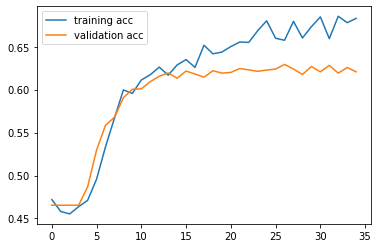

In [26]:
acc = pd.DataFrame({"training acc":history.history['acc'],
                            "validation acc": history.history['val_acc']})
acc.plot()

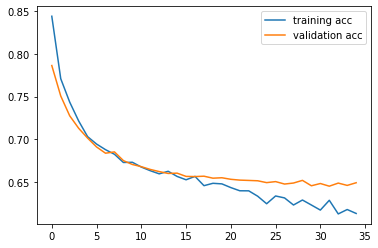

In [27]:
loss = pd.DataFrame({"training acc":history.history['loss'],
                            "validation acc": history.history['val_loss']})
loss.plot()

In [28]:
testing_data = pd.read_csv(config.config_io.get('pan_21_processed_test'))
testing_generator = DataGeneratorSiamese(testing_data, tokenizer=t, max_len=max_len, batch_size=64)
testing_generator.on_epoch_end()

In [29]:
test_loss, test_acc = model.evaluate(testing_generator)
test_loss, test_acc

220/220 [==============================] - 11s 51ms/step - loss: 0.6448 - acc: 0.6268


(0.6448089480400085, 0.6268466114997864)

In [30]:
# insert the testing part from baseline for all test files
output_path = "/home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru"
test_input_path = '/home/sukanya/PhD/Datasets/PAN SCD/pan21-style-change-detection/validation'
base = [file.split(".")[0] for file in os.listdir(test_input_path) if "txt" in file]
problem_files = [file+".txt" for file in base]

for i in tqdm(range(0, len(problem_files))):  #len(problem_files)
    print("Problem here")
    x = convertPAN_to_siamese_format_TIRA_siamese(test_input_path + "/" + problem_files[i], t, max_len)
    print("\n",problem_files[i])
    #print(x)
    y_pred = model.predict(x, verbose=1)
    changes= np.where(y_pred > 0.5, 1, 0).flatten().tolist()
    #np.argmax(y_pred, axis=-1).tolist()
    #print(y_pred)
    #print(changes)
    multi_author = 0
    if sum(changes) >= 1:
        multi_author = 1
    paragraph_authors = [0] * (len(changes) + 1)
    sol_dict = {"multi-author": multi_author, "changes": changes,
                "paragraph-authors": paragraph_authors}
    write_solution(problem_files[i], output_path, sol_dict)


  0%|          | 0/2400 [00:00<?, ?it/s]

Problem here

 problem-1543.txt
1/1 [==============================] - 0s 500ms/step



  0%|          | 1/2400 [00:00<20:56,  1.91it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1543.json
Problem here

 problem-631.txt
1/1 [==============================] - 0s 50ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-631.json
Problem here

 problem-1839.txt
1/1 [==============================] - 0s 49ms/step



  0%|          | 3/2400 [00:00<15:28,  2.58it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1839.json
Problem here

 problem-1554.txt
1/1 [==============================] - 0s 53ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1554.json
Problem here

 problem-2399.txt
1/1 [==============================] - 0s 52ms/step



  0%|          | 5/2400 [00:00<11:42,  3.41it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2399.json
Problem here

 problem-1068.txt
1/1 [==============================] - 0s 49ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1068.json
Problem here

 problem-2182.txt
1/1 [==============================] - 0s 48ms/step



  0%|          | 7/2400 [00:00<09:01,  4.42it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2182.json
Problem here

 problem-347.txt
1/1 [==============================] - 0s 50ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-347.json
Problem here

 problem-378.txt
1/1 [==============================] - 0s 50ms/step



  0%|          | 9/2400 [00:01<07:08,  5.58it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-378.json
Problem here

 problem-793.txt
1/1 [==============================] - 0s 54ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-793.json
Problem here

 problem-2091.txt
1/1 [==============================] - 0s 51ms/step



  0%|          | 11/2400 [00:01<05:51,  6.79it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2091.json
Problem here

 problem-2116.txt
1/1 [==============================] - 0s 48ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2116.json
Problem here

 problem-287.txt
1/1 [==============================] - 0s 50ms/step



  1%|          | 13/2400 [00:01<04:52,  8.17it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-287.json
Problem here

 problem-1973.txt
1/1 [==============================] - 0s 53ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1973.json
Problem here

 problem-771.txt
1/1 [==============================] - 0s 51ms/step



  1%|          | 15/2400 [00:01<04:14,  9.36it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-771.json
Problem here

 problem-1156.txt
1/1 [==============================] - 0s 55ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1156.json
Problem here

 problem-719.txt
1/1 [==============================] - 0s 52ms/step



  1%|          | 17/2400 [00:01<03:49, 10.37it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-719.json
Problem here

 problem-2125.txt
1/1 [==============================] - 0s 52ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2125.json
Problem here

 problem-1270.txt
1/1 [==============================] - 0s 55ms/step



  1%|          | 19/2400 [00:01<03:33, 11.14it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1270.json
Problem here

 problem-1257.txt
1/1 [==============================] - 0s 51ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1257.json
Problem here

 problem-172.txt
1/1 [==============================] - 0s 50ms/step



  1%|          | 21/2400 [00:01<03:19, 11.93it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-172.json
Problem here

 problem-2281.txt
1/1 [==============================] - 0s 70ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2281.json
Problem here

 problem-2167.txt
1/1 [==============================] - 0s 63ms/step



  1%|          | 23/2400 [00:02<03:25, 11.56it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2167.json
Problem here

 problem-899.txt
1/1 [==============================] - 0s 77ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-899.json
Problem here

 problem-566.txt
1/1 [==============================] - 0s 56ms/step



  1%|          | 25/2400 [00:02<03:28, 11.38it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-566.json
Problem here

 problem-377.txt
1/1 [==============================] - 0s 52ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-377.json
Problem here

 problem-1325.txt
1/1 [==============================] - 0s 52ms/step



  1%|          | 27/2400 [00:02<03:17, 12.03it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1325.json
Problem here

 problem-2172.txt
1/1 [==============================] - 0s 50ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2172.json
Problem here

 problem-1534.txt
1/1 [==============================] - 0s 51ms/step



  1%|          | 29/2400 [00:02<03:07, 12.64it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1534.json
Problem here

 problem-1117.txt
1/1 [==============================] - 0s 48ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1117.json
Problem here

 problem-205.txt
1/1 [==============================] - 0s 52ms/step



  1%|▏         | 31/2400 [00:02<03:01, 13.09it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-205.json
Problem here

 problem-367.txt
1/1 [==============================] - 0s 51ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-367.json
Problem here

 problem-2247.txt
1/1 [==============================] - 0s 50ms/step



  1%|▏         | 33/2400 [00:02<02:55, 13.47it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2247.json
Problem here

 problem-2092.txt
1/1 [==============================] - 0s 48ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2092.json
Problem here

 problem-1494.txt
1/1 [==============================] - 0s 51ms/step



  1%|▏         | 35/2400 [00:03<02:51, 13.78it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1494.json
Problem here

 problem-2304.txt
1/1 [==============================] - 0s 51ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2304.json
Problem here

 problem-1013.txt
1/1 [==============================] - 0s 46ms/step



  2%|▏         | 37/2400 [00:03<02:47, 14.10it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1013.json
Problem here

 problem-1826.txt
1/1 [==============================] - 0s 49ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1826.json
Problem here

 problem-1338.txt
1/1 [==============================] - 0s 51ms/step



  2%|▏         | 39/2400 [00:03<02:46, 14.15it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1338.json
Problem here

 problem-1316.txt
1/1 [==============================] - 0s 49ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1316.json
Problem here

 problem-441.txt
1/1 [==============================] - 0s 51ms/step



  2%|▏         | 41/2400 [00:03<02:45, 14.29it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-441.json
Problem here

 problem-1847.txt
1/1 [==============================] - 0s 48ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1847.json
Problem here

 problem-8.txt
1/1 [==============================] - 0s 47ms/step



  2%|▏         | 43/2400 [00:03<02:41, 14.56it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-8.json
Problem here

 problem-117.txt
1/1 [==============================] - 0s 47ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-117.json
Problem here

 problem-826.txt
1/1 [==============================] - 0s 49ms/step



  2%|▏         | 45/2400 [00:03<02:39, 14.75it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-826.json
Problem here

 problem-101.txt
1/1 [==============================] - 0s 48ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-101.json
Problem here

 problem-2178.txt
1/1 [==============================] - 0s 49ms/step



  2%|▏         | 47/2400 [00:03<02:38, 14.83it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2178.json
Problem here

 problem-1476.txt
1/1 [==============================] - 0s 48ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1476.json
Problem here

 problem-1150.txt
1/1 [==============================] - 0s 48ms/step



  2%|▏         | 49/2400 [00:03<02:39, 14.76it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1150.json
Problem here

 problem-396.txt
1/1 [==============================] - 0s 49ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-396.json
Problem here

 problem-1901.txt
1/1 [==============================] - 0s 49ms/step



  2%|▏         | 51/2400 [00:04<02:37, 14.93it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1901.json
Problem here

 problem-1803.txt
1/1 [==============================] - 0s 48ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1803.json
Problem here

 problem-669.txt
1/1 [==============================] - 0s 49ms/step



  2%|▏         | 53/2400 [00:04<02:38, 14.85it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-669.json
Problem here

 problem-803.txt
1/1 [==============================] - 0s 46ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-803.json
Problem here

 problem-1240.txt
1/1 [==============================] - 0s 50ms/step



  2%|▏         | 55/2400 [00:04<02:38, 14.80it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1240.json
Problem here

 problem-2202.txt
1/1 [==============================] - 0s 47ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2202.json
Problem here

 problem-2381.txt
1/1 [==============================] - 0s 51ms/step



  2%|▏         | 57/2400 [00:04<02:38, 14.74it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2381.json
Problem here

 problem-627.txt
1/1 [==============================] - 0s 49ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-627.json
Problem here

 problem-1178.txt
1/1 [==============================] - 0s 47ms/step



  2%|▏         | 59/2400 [00:04<02:38, 14.79it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1178.json
Problem here

 problem-1860.txt
1/1 [==============================] - 0s 49ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1860.json
Problem here

 problem-1935.txt
1/1 [==============================] - 0s 50ms/step



  3%|▎         | 61/2400 [00:04<02:38, 14.79it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1935.json
Problem here

 problem-329.txt
1/1 [==============================] - 0s 49ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-329.json
Problem here

 problem-518.txt
1/1 [==============================] - 0s 44ms/step



  3%|▎         | 63/2400 [00:04<02:35, 14.98it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-518.json
Problem here

 problem-673.txt
1/1 [==============================] - 0s 51ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-673.json
Problem here

 problem-1406.txt
1/1 [==============================] - 0s 48ms/step



  3%|▎         | 65/2400 [00:05<02:37, 14.85it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1406.json
Problem here

 problem-784.txt
1/1 [==============================] - 0s 47ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-784.json
Problem here

 problem-484.txt
1/1 [==============================] - 0s 48ms/step



  3%|▎         | 67/2400 [00:05<02:37, 14.84it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-484.json
Problem here

 problem-1681.txt
1/1 [==============================] - 0s 47ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1681.json
Problem here

 problem-19.txt
1/1 [==============================] - 0s 50ms/step



  3%|▎         | 69/2400 [00:05<02:35, 14.98it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-19.json
Problem here

 problem-1638.txt
1/1 [==============================] - 0s 49ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1638.json
Problem here

 problem-309.txt
1/1 [==============================] - 0s 50ms/step



  3%|▎         | 71/2400 [00:05<02:37, 14.76it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-309.json
Problem here

 problem-2064.txt
1/1 [==============================] - 0s 51ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2064.json
Problem here

 problem-1221.txt
1/1 [==============================] - 0s 49ms/step



  3%|▎         | 73/2400 [00:05<02:37, 14.77it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1221.json
Problem here

 problem-2119.txt
1/1 [==============================] - 0s 48ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2119.json
Problem here

 problem-624.txt
1/1 [==============================] - 0s 50ms/step



  3%|▎         | 75/2400 [00:05<02:39, 14.56it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-624.json
Problem here

 problem-427.txt
1/1 [==============================] - 0s 48ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-427.json
Problem here

 problem-2293.txt
1/1 [==============================] - 0s 50ms/step



  3%|▎         | 77/2400 [00:05<02:39, 14.54it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2293.json
Problem here

 problem-941.txt
1/1 [==============================] - 0s 47ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-941.json
Problem here

 problem-974.txt
1/1 [==============================] - 0s 48ms/step



  3%|▎         | 79/2400 [00:05<02:37, 14.71it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-974.json
Problem here

 problem-1029.txt
1/1 [==============================] - 0s 48ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1029.json
Problem here

 problem-81.txt
1/1 [==============================] - 0s 49ms/step



  3%|▎         | 81/2400 [00:06<02:37, 14.76it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-81.json
Problem here

 problem-1144.txt
1/1 [==============================] - 0s 50ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1144.json
Problem here

 problem-1290.txt
1/1 [==============================] - 0s 51ms/step



  3%|▎         | 83/2400 [00:06<02:37, 14.68it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1290.json
Problem here

 problem-313.txt
1/1 [==============================] - 0s 50ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-313.json
Problem here

 problem-150.txt
1/1 [==============================] - 0s 48ms/step



  4%|▎         | 85/2400 [00:06<02:40, 14.45it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-150.json
Problem here

 problem-2355.txt
1/1 [==============================] - 0s 47ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2355.json
Problem here

 problem-570.txt
1/1 [==============================] - 0s 48ms/step



  4%|▎         | 87/2400 [00:06<02:39, 14.47it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-570.json
Problem here

 problem-1109.txt
1/1 [==============================] - 0s 50ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1109.json
Problem here

 problem-1625.txt
1/1 [==============================] - 0s 49ms/step



  4%|▎         | 89/2400 [00:06<02:39, 14.52it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1625.json
Problem here

 problem-982.txt
1/1 [==============================] - 0s 47ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-982.json
Problem here

 problem-2181.txt
1/1 [==============================] - 0s 49ms/step



  4%|▍         | 91/2400 [00:06<02:36, 14.76it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2181.json
Problem here

 problem-1613.txt
1/1 [==============================] - 0s 51ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1613.json
Problem here

 problem-903.txt
1/1 [==============================] - 0s 53ms/step



  4%|▍         | 93/2400 [00:06<02:38, 14.55it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-903.json
Problem here

 problem-892.txt
1/1 [==============================] - 0s 47ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-892.json
Problem here

 problem-1809.txt
1/1 [==============================] - 0s 48ms/step



  4%|▍         | 95/2400 [00:07<02:37, 14.63it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1809.json
Problem here

 problem-1422.txt
1/1 [==============================] - 0s 51ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1422.json
Problem here

 problem-89.txt
1/1 [==============================] - 0s 48ms/step



  4%|▍         | 97/2400 [00:07<02:37, 14.58it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-89.json
Problem here

 problem-1001.txt
1/1 [==============================] - 0s 51ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1001.json
Problem here

 problem-944.txt
1/1 [==============================] - 0s 47ms/step



  4%|▍         | 99/2400 [00:07<02:37, 14.66it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-944.json
Problem here

 problem-1113.txt
1/1 [==============================] - 0s 50ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1113.json
Problem here

 problem-2026.txt
1/1 [==============================] - 0s 48ms/step



  4%|▍         | 101/2400 [00:07<02:36, 14.70it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2026.json
Problem here

 problem-917.txt
1/1 [==============================] - 0s 47ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-917.json
Problem here

 problem-1659.txt
1/1 [==============================] - 0s 50ms/step



  4%|▍         | 103/2400 [00:07<02:37, 14.63it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1659.json
Problem here

 problem-778.txt
1/1 [==============================] - 0s 51ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-778.json
Problem here

 problem-2336.txt
1/1 [==============================] - 0s 46ms/step



  4%|▍         | 105/2400 [00:07<02:35, 14.73it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2336.json
Problem here

 problem-379.txt
1/1 [==============================] - 0s 51ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-379.json
Problem here

 problem-420.txt
1/1 [==============================] - 0s 53ms/step



  4%|▍         | 107/2400 [00:07<02:37, 14.55it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-420.json
Problem here

 problem-1688.txt
1/1 [==============================] - 0s 50ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1688.json
Problem here

 problem-2312.txt
1/1 [==============================] - 0s 48ms/step



  5%|▍         | 109/2400 [00:08<02:36, 14.67it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2312.json
Problem here

 problem-1484.txt
1/1 [==============================] - 0s 49ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1484.json
Problem here

 problem-1523.txt
1/1 [==============================] - 0s 51ms/step



  5%|▍         | 111/2400 [00:08<02:38, 14.46it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1523.json
Problem here

 problem-776.txt
1/1 [==============================] - 0s 46ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-776.json
Problem here

 problem-1262.txt
1/1 [==============================] - 0s 49ms/step



  5%|▍         | 113/2400 [00:08<02:35, 14.72it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1262.json
Problem here

 problem-1323.txt
1/1 [==============================] - 0s 48ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1323.json
Problem here

 problem-1725.txt
1/1 [==============================] - 0s 48ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1725.json



  5%|▍         | 115/2400 [00:08<02:35, 14.70it/s]

Problem here

 problem-1439.txt
1/1 [==============================] - 0s 48ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1439.json
Problem here

 problem-474.txt
1/1 [==============================] - 0s 48ms/step



  5%|▍         | 117/2400 [00:08<02:34, 14.77it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-474.json
Problem here

 problem-927.txt
1/1 [==============================] - 0s 47ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-927.json
Problem here

 problem-2012.txt
1/1 [==============================] - 0s 50ms/step



  5%|▍         | 119/2400 [00:08<02:35, 14.66it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2012.json
Problem here

 problem-1928.txt
1/1 [==============================] - 0s 47ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1928.json
Problem here

 problem-2260.txt
1/1 [==============================] - 0s 46ms/step



  5%|▌         | 121/2400 [00:08<02:34, 14.75it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2260.json
Problem here

 problem-1216.txt
1/1 [==============================] - 0s 49ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1216.json
Problem here

 problem-438.txt
1/1 [==============================] - 0s 48ms/step



  5%|▌         | 123/2400 [00:08<02:33, 14.80it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-438.json
Problem here

 problem-1516.txt
1/1 [==============================] - 0s 49ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1516.json
Problem here

 problem-1336.txt
1/1 [==============================] - 0s 47ms/step



  5%|▌         | 125/2400 [00:09<02:32, 14.93it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1336.json
Problem here

 problem-1078.txt
1/1 [==============================] - 0s 48ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1078.json
Problem here

 problem-562.txt
1/1 [==============================] - 0s 47ms/step



  5%|▌         | 127/2400 [00:09<02:34, 14.71it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-562.json
Problem here

 problem-1021.txt
1/1 [==============================] - 0s 50ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1021.json
Problem here

 problem-841.txt
1/1 [==============================] - 0s 47ms/step



  5%|▌         | 129/2400 [00:09<02:34, 14.73it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-841.json
Problem here

 problem-20.txt
1/1 [==============================] - 0s 47ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-20.json
Problem here

 problem-1209.txt
1/1 [==============================] - 0s 49ms/step



  5%|▌         | 131/2400 [00:09<02:33, 14.74it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1209.json
Problem here

 problem-33.txt
1/1 [==============================] - 0s 47ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-33.json
Problem here

 problem-448.txt
1/1 [==============================] - 0s 47ms/step



  6%|▌         | 133/2400 [00:09<02:32, 14.83it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-448.json
Problem here

 problem-1387.txt
1/1 [==============================] - 0s 47ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1387.json
Problem here

 problem-534.txt
1/1 [==============================] - 0s 47ms/step



  6%|▌         | 135/2400 [00:09<02:31, 14.93it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-534.json
Problem here

 problem-268.txt
1/1 [==============================] - 0s 48ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-268.json
Problem here

 problem-850.txt
1/1 [==============================] - 0s 48ms/step



  6%|▌         | 137/2400 [00:09<02:31, 14.96it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-850.json
Problem here

 problem-1814.txt
1/1 [==============================] - 0s 51ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1814.json
Problem here

 problem-2046.txt
1/1 [==============================] - 0s 51ms/step



  6%|▌         | 139/2400 [00:10<02:33, 14.77it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2046.json
Problem here

 problem-2051.txt
1/1 [==============================] - 0s 48ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2051.json
Problem here

 problem-1457.txt
1/1 [==============================] - 0s 49ms/step



  6%|▌         | 141/2400 [00:10<02:32, 14.83it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1457.json
Problem here

 problem-1020.txt
1/1 [==============================] - 0s 50ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1020.json
Problem here

 problem-1050.txt
1/1 [==============================] - 0s 48ms/step



  6%|▌         | 143/2400 [00:10<02:33, 14.72it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1050.json
Problem here

 problem-1684.txt
1/1 [==============================] - 0s 49ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1684.json
Problem here

 problem-110.txt
1/1 [==============================] - 0s 47ms/step



  6%|▌         | 145/2400 [00:10<02:32, 14.79it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-110.json
Problem here

 problem-1304.txt
1/1 [==============================] - 0s 50ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1304.json
Problem here

 problem-788.txt
1/1 [==============================] - 0s 49ms/step



  6%|▌         | 147/2400 [00:10<02:32, 14.77it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-788.json
Problem here

 problem-550.txt
1/1 [==============================] - 0s 50ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-550.json
Problem here

 problem-1177.txt
1/1 [==============================] - 0s 49ms/step



  6%|▌         | 149/2400 [00:10<02:33, 14.65it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1177.json
Problem here

 problem-1169.txt
1/1 [==============================] - 0s 49ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1169.json
Problem here

 problem-1288.txt
1/1 [==============================] - 0s 48ms/step



  6%|▋         | 151/2400 [00:10<02:31, 14.84it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1288.json
Problem here

 problem-713.txt
1/1 [==============================] - 0s 49ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-713.json
Problem here

 problem-1312.txt
1/1 [==============================] - 0s 51ms/step



  6%|▋         | 153/2400 [00:11<02:32, 14.76it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1312.json
Problem here

 problem-558.txt
1/1 [==============================] - 0s 49ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-558.json
Problem here

 problem-756.txt
1/1 [==============================] - 0s 48ms/step



  6%|▋         | 155/2400 [00:11<02:32, 14.69it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-756.json
Problem here

 problem-243.txt
1/1 [==============================] - 0s 46ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-243.json
Problem here

 problem-1959.txt
1/1 [==============================] - 0s 48ms/step



  7%|▋         | 157/2400 [00:11<02:31, 14.82it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1959.json
Problem here

 problem-688.txt
1/1 [==============================] - 0s 49ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-688.json
Problem here

 problem-2143.txt
1/1 [==============================] - 0s 52ms/step



  7%|▋         | 159/2400 [00:11<02:35, 14.44it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2143.json
Problem here

 problem-851.txt
1/1 [==============================] - 0s 46ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-851.json
Problem here

 problem-1241.txt
1/1 [==============================] - 0s 50ms/step



  7%|▋         | 161/2400 [00:11<02:34, 14.52it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1241.json
Problem here

 problem-1417.txt
1/1 [==============================] - 0s 49ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1417.json
Problem here

 problem-822.txt
1/1 [==============================] - 0s 49ms/step



  7%|▋         | 163/2400 [00:11<02:32, 14.65it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-822.json
Problem here

 problem-1444.txt
1/1 [==============================] - 0s 49ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1444.json
Problem here

 problem-190.txt
1/1 [==============================] - 0s 49ms/step



  7%|▋         | 165/2400 [00:11<02:31, 14.76it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-190.json
Problem here

 problem-1995.txt
1/1 [==============================] - 0s 50ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1995.json
Problem here

 problem-1832.txt
1/1 [==============================] - 0s 49ms/step



  7%|▋         | 167/2400 [00:11<02:31, 14.69it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1832.json
Problem here

 problem-2354.txt
1/1 [==============================] - 0s 50ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2354.json
Problem here

 problem-525.txt
1/1 [==============================] - 0s 51ms/step



  7%|▋         | 169/2400 [00:12<02:32, 14.60it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-525.json
Problem here

 problem-780.txt
1/1 [==============================] - 0s 51ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-780.json
Problem here

 problem-1977.txt
1/1 [==============================] - 0s 48ms/step



  7%|▋         | 171/2400 [00:12<02:34, 14.39it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1977.json
Problem here

 problem-884.txt
1/1 [==============================] - 0s 53ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-884.json
Problem here

 problem-1017.txt
1/1 [==============================] - 0s 51ms/step



  7%|▋         | 173/2400 [00:12<02:36, 14.24it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1017.json
Problem here

 problem-1843.txt
1/1 [==============================] - 0s 50ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1843.json
Problem here

 problem-869.txt
1/1 [==============================] - 0s 51ms/step



  7%|▋         | 175/2400 [00:12<02:37, 14.12it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-869.json
Problem here

 problem-2053.txt
1/1 [==============================] - 0s 48ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2053.json
Problem here

 problem-595.txt
1/1 [==============================] - 0s 50ms/step



  7%|▋         | 177/2400 [00:12<02:38, 14.04it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-595.json
Problem here

 problem-222.txt
1/1 [==============================] - 0s 49ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-222.json
Problem here

 problem-2184.txt
1/1 [==============================] - 0s 48ms/step



  7%|▋         | 179/2400 [00:12<02:38, 14.05it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2184.json
Problem here

 problem-1036.txt
1/1 [==============================] - 0s 50ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1036.json
Problem here

 problem-548.txt
1/1 [==============================] - 0s 46ms/step



  8%|▊         | 181/2400 [00:12<02:33, 14.45it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-548.json
Problem here

 problem-1260.txt
1/1 [==============================] - 0s 47ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1260.json
Problem here

 problem-1345.txt
1/1 [==============================] - 0s 47ms/step



  8%|▊         | 183/2400 [00:13<02:31, 14.62it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1345.json
Problem here

 problem-746.txt
1/1 [==============================] - 0s 50ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-746.json
Problem here

 problem-1501.txt
1/1 [==============================] - 0s 46ms/step



  8%|▊         | 185/2400 [00:13<02:29, 14.82it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1501.json
Problem here

 problem-2146.txt
1/1 [==============================] - 0s 46ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2146.json
Problem here

 problem-60.txt
1/1 [==============================] - 0s 48ms/step



  8%|▊         | 187/2400 [00:13<02:29, 14.84it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-60.json
Problem here

 problem-226.txt
1/1 [==============================] - 0s 45ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-226.json
Problem here

 problem-2109.txt
1/1 [==============================] - 0s 49ms/step



  8%|▊         | 189/2400 [00:13<02:27, 15.03it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2109.json
Problem here

 problem-1528.txt
1/1 [==============================] - 0s 48ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1528.json
Problem here

 problem-1399.txt
1/1 [==============================] - 0s 48ms/step



  8%|▊         | 191/2400 [00:13<02:28, 14.84it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1399.json
Problem here

 problem-199.txt
1/1 [==============================] - 0s 46ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-199.json
Problem here

 problem-1862.txt
1/1 [==============================] - 0s 48ms/step



  8%|▊         | 193/2400 [00:13<02:26, 15.11it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1862.json
Problem here

 problem-531.txt
1/1 [==============================] - 0s 48ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-531.json
Problem here

 problem-2308.txt
1/1 [==============================] - 0s 49ms/step



  8%|▊         | 195/2400 [00:13<02:25, 15.11it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2308.json
Problem here

 problem-1738.txt
1/1 [==============================] - 0s 47ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1738.json
Problem here

 problem-1470.txt
1/1 [==============================] - 0s 48ms/step



  8%|▊         | 197/2400 [00:14<02:25, 15.15it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1470.json
Problem here

 problem-1429.txt
1/1 [==============================] - 0s 46ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1429.json
Problem here

 problem-908.txt
1/1 [==============================] - 0s 47ms/step



  8%|▊         | 199/2400 [00:14<02:25, 15.13it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-908.json
Problem here

 problem-1627.txt
1/1 [==============================] - 0s 50ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1627.json
Problem here

 problem-568.txt
1/1 [==============================] - 0s 47ms/step



  8%|▊         | 201/2400 [00:14<02:26, 14.98it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-568.json
Problem here

 problem-2057.txt
1/1 [==============================] - 0s 48ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2057.json
Problem here

 problem-1854.txt
1/1 [==============================] - 0s 47ms/step



  8%|▊         | 203/2400 [00:14<02:25, 15.09it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1854.json
Problem here

 problem-2096.txt
1/1 [==============================] - 0s 49ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2096.json
Problem here

 problem-1390.txt
1/1 [==============================] - 0s 48ms/step



  9%|▊         | 205/2400 [00:14<02:27, 14.93it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1390.json
Problem here

 problem-2239.txt
1/1 [==============================] - 0s 47ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2239.json
Problem here

 problem-1658.txt
1/1 [==============================] - 0s 48ms/step



  9%|▊         | 207/2400 [00:14<02:26, 14.95it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1658.json
Problem here

 problem-2254.txt
1/1 [==============================] - 0s 48ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2254.json
Problem here

 problem-59.txt
1/1 [==============================] - 0s 50ms/step



  9%|▊         | 209/2400 [00:14<02:27, 14.81it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-59.json
Problem here

 problem-132.txt
1/1 [==============================] - 0s 48ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-132.json
Problem here

 problem-1375.txt
1/1 [==============================] - 0s 46ms/step



  9%|▉         | 211/2400 [00:14<02:27, 14.88it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1375.json
Problem here

 problem-405.txt
1/1 [==============================] - 0s 48ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-405.json
Problem here

 problem-1916.txt
1/1 [==============================] - 0s 49ms/step



  9%|▉         | 213/2400 [00:15<02:26, 14.91it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1916.json
Problem here

 problem-495.txt
1/1 [==============================] - 0s 48ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-495.json
Problem here

 problem-1539.txt
1/1 [==============================] - 0s 49ms/step



  9%|▉         | 215/2400 [00:15<02:27, 14.84it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1539.json
Problem here

 problem-1646.txt
1/1 [==============================] - 0s 46ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1646.json
Problem here

 problem-241.txt
1/1 [==============================] - 0s 46ms/step



  9%|▉         | 217/2400 [00:15<02:24, 15.13it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-241.json
Problem here

 problem-1333.txt
1/1 [==============================] - 0s 46ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1333.json
Problem here

 problem-1611.txt
1/1 [==============================] - 0s 50ms/step



  9%|▉         | 219/2400 [00:15<02:23, 15.24it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1611.json
Problem here

 problem-1300.txt
1/1 [==============================] - 0s 46ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1300.json
Problem here

 problem-557.txt
1/1 [==============================] - 0s 50ms/step



  9%|▉         | 221/2400 [00:15<02:22, 15.28it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-557.json
Problem here

 problem-1022.txt
1/1 [==============================] - 0s 50ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1022.json
Problem here

 problem-1057.txt
1/1 [==============================] - 0s 47ms/step



  9%|▉         | 223/2400 [00:15<02:25, 15.01it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1057.json
Problem here

 problem-229.txt
1/1 [==============================] - 0s 48ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-229.json
Problem here

 problem-1549.txt
1/1 [==============================] - 0s 48ms/step



  9%|▉         | 225/2400 [00:15<02:24, 15.09it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1549.json
Problem here

 problem-1322.txt
1/1 [==============================] - 0s 48ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1322.json
Problem here

 problem-1224.txt
1/1 [==============================] - 0s 48ms/step



  9%|▉         | 227/2400 [00:16<02:24, 15.06it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1224.json
Problem here

 problem-1305.txt
1/1 [==============================] - 0s 48ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1305.json
Problem here

 problem-209.txt
1/1 [==============================] - 0s 50ms/step



 10%|▉         | 229/2400 [00:16<02:24, 15.05it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-209.json
Problem here

 problem-516.txt
1/1 [==============================] - 0s 46ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-516.json
Problem here

 problem-1023.txt
1/1 [==============================] - 0s 47ms/step



 10%|▉         | 231/2400 [00:16<02:24, 15.05it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1023.json
Problem here

 problem-749.txt
1/1 [==============================] - 0s 47ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-749.json
Problem here

 problem-2006.txt
1/1 [==============================] - 0s 48ms/step



 10%|▉         | 233/2400 [00:16<02:23, 15.13it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2006.json
Problem here

 problem-726.txt
1/1 [==============================] - 0s 48ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-726.json
Problem here

 problem-1145.txt
1/1 [==============================] - 0s 47ms/step



 10%|▉         | 235/2400 [00:16<02:22, 15.20it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1145.json
Problem here

 problem-61.txt
1/1 [==============================] - 0s 48ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-61.json
Problem here

 problem-1279.txt
1/1 [==============================] - 0s 47ms/step



 10%|▉         | 237/2400 [00:16<02:23, 15.13it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1279.json
Problem here

 problem-1373.txt
1/1 [==============================] - 0s 47ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1373.json
Problem here

 problem-79.txt
1/1 [==============================] - 0s 48ms/step
Writing in path: 


 10%|▉         | 239/2400 [00:16<02:23, 15.02it/s]

/home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-79.json
Problem here

 problem-2252.txt
1/1 [==============================] - 0s 46ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2252.json
Problem here

 problem-1487.txt
1/1 [==============================] - 0s 49ms/step



 10%|█         | 241/2400 [00:16<02:23, 15.06it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1487.json
Problem here

 problem-1990.txt
1/1 [==============================] - 0s 50ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1990.json
Problem here

 problem-973.txt
1/1 [==============================] - 0s 47ms/step



 10%|█         | 243/2400 [00:17<02:24, 14.89it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-973.json
Problem here

 problem-1715.txt
1/1 [==============================] - 0s 46ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1715.json
Problem here

 problem-2023.txt
1/1 [==============================] - 0s 47ms/step



 10%|█         | 245/2400 [00:17<02:24, 14.92it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2023.json
Problem here

 problem-1463.txt
1/1 [==============================] - 0s 51ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1463.json
Problem here

 problem-541.txt
1/1 [==============================] - 0s 50ms/step



 10%|█         | 247/2400 [00:17<02:26, 14.67it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-541.json
Problem here

 problem-2122.txt
1/1 [==============================] - 0s 51ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2122.json
Problem here

 problem-1804.txt
1/1 [==============================] - 0s 45ms/step



 10%|█         | 249/2400 [00:17<02:24, 14.90it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1804.json
Problem here

 problem-924.txt
1/1 [==============================] - 0s 48ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-924.json
Problem here

 problem-1397.txt
1/1 [==============================] - 0s 47ms/step



 10%|█         | 251/2400 [00:17<02:23, 14.99it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1397.json
Problem here

 problem-926.txt
1/1 [==============================] - 0s 52ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-926.json
Problem here

 problem-254.txt
1/1 [==============================] - 0s 49ms/step



 11%|█         | 253/2400 [00:17<02:24, 14.82it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-254.json
Problem here

 problem-1090.txt
1/1 [==============================] - 0s 47ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1090.json
Problem here

 problem-1400.txt
1/1 [==============================] - 0s 48ms/step



 11%|█         | 255/2400 [00:17<02:25, 14.79it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1400.json
Problem here

 problem-1606.txt
1/1 [==============================] - 0s 49ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1606.json
Problem here

 problem-2310.txt
1/1 [==============================] - 0s 46ms/step



 11%|█         | 257/2400 [00:18<02:23, 14.90it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2310.json
Problem here

 problem-2047.txt
1/1 [==============================] - 0s 49ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2047.json
Problem here

 problem-342.txt
1/1 [==============================] - 0s 50ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-342.json



 11%|█         | 259/2400 [00:18<02:24, 14.80it/s]

Problem here

 problem-2083.txt
1/1 [==============================] - 0s 50ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2083.json
Problem here

 problem-301.txt
1/1 [==============================] - 0s 52ms/step



 11%|█         | 261/2400 [00:18<02:25, 14.67it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-301.json
Problem here

 problem-1943.txt
1/1 [==============================] - 0s 49ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1943.json
Problem here

 problem-246.txt
1/1 [==============================] - 0s 49ms/step



 11%|█         | 263/2400 [00:18<02:26, 14.61it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-246.json
Problem here

 problem-1705.txt
1/1 [==============================] - 0s 47ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1705.json
Problem here

 problem-1645.txt
1/1 [==============================] - 0s 50ms/step



 11%|█         | 265/2400 [00:18<02:25, 14.69it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1645.json
Problem here

 problem-2269.txt
1/1 [==============================] - 0s 46ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2269.json
Problem here

 problem-1720.txt
1/1 [==============================] - 0s 46ms/step



 11%|█         | 267/2400 [00:18<02:22, 14.93it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1720.json
Problem here

 problem-386.txt
1/1 [==============================] - 0s 47ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-386.json
Problem here

 problem-2098.txt
1/1 [==============================] - 0s 49ms/step



 11%|█         | 269/2400 [00:18<02:23, 14.86it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2098.json
Problem here

 problem-1482.txt
1/1 [==============================] - 0s 48ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1482.json
Problem here

 problem-185.txt
1/1 [==============================] - 0s 50ms/step



 11%|█▏        | 271/2400 [00:18<02:24, 14.73it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-185.json
Problem here

 problem-758.txt
1/1 [==============================] - 0s 50ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-758.json
Problem here

 problem-538.txt
1/1 [==============================] - 0s 48ms/step



 11%|█▏        | 273/2400 [00:19<02:25, 14.58it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-538.json
Problem here

 problem-515.txt
1/1 [==============================] - 0s 47ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-515.json
Problem here

 problem-2229.txt
1/1 [==============================] - 0s 50ms/step



 11%|█▏        | 275/2400 [00:19<02:26, 14.48it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2229.json
Problem here

 problem-542.txt
1/1 [==============================] - 0s 49ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-542.json
Problem here

 problem-52.txt
1/1 [==============================] - 0s 52ms/step



 12%|█▏        | 277/2400 [00:19<02:27, 14.38it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-52.json
Problem here

 problem-946.txt
1/1 [==============================] - 0s 46ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-946.json
Problem here

 problem-1900.txt
1/1 [==============================] - 0s 49ms/step



 12%|█▏        | 279/2400 [00:19<02:26, 14.44it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1900.json
Problem here

 problem-829.txt
1/1 [==============================] - 0s 47ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-829.json
Problem here

 problem-459.txt
1/1 [==============================] - 0s 48ms/step



 12%|█▏        | 281/2400 [00:19<02:24, 14.69it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-459.json
Problem here

 problem-1535.txt
1/1 [==============================] - 0s 49ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1535.json
Problem here

 problem-2306.txt
1/1 [==============================] - 0s 48ms/step



 12%|█▏        | 283/2400 [00:19<02:24, 14.60it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2306.json
Problem here

 problem-1581.txt
1/1 [==============================] - 0s 51ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1581.json
Problem here

 problem-63.txt
1/1 [==============================] - 0s 49ms/step



 12%|█▏        | 285/2400 [00:19<02:24, 14.59it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-63.json
Problem here

 problem-1896.txt
1/1 [==============================] - 0s 45ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1896.json
Problem here

 problem-1948.txt
1/1 [==============================] - 0s 49ms/step



 12%|█▏        | 287/2400 [00:20<02:25, 14.57it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1948.json
Problem here

 problem-272.txt
1/1 [==============================] - 0s 50ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-272.json
Problem here

 problem-737.txt
1/1 [==============================] - 0s 54ms/step



 12%|█▏        | 289/2400 [00:20<02:26, 14.38it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-737.json
Problem here

 problem-674.txt
1/1 [==============================] - 0s 50ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-674.json
Problem here

 problem-1146.txt
1/1 [==============================] - 0s 47ms/step



 12%|█▏        | 291/2400 [00:20<02:24, 14.58it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1146.json
Problem here

 problem-1434.txt
1/1 [==============================] - 0s 48ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1434.json
Problem here

 problem-82.txt
1/1 [==============================] - 0s 48ms/step



 12%|█▏        | 293/2400 [00:20<02:25, 14.49it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-82.json
Problem here

 problem-9.txt
1/1 [==============================] - 0s 47ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-9.json
Problem here

 problem-727.txt
1/1 [==============================] - 0s 48ms/step



 12%|█▏        | 295/2400 [00:20<02:24, 14.62it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-727.json
Problem here

 problem-988.txt
1/1 [==============================] - 0s 46ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-988.json
Problem here

 problem-2350.txt
1/1 [==============================] - 0s 48ms/step



 12%|█▏        | 297/2400 [00:20<02:23, 14.69it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2350.json
Problem here

 problem-692.txt
1/1 [==============================] - 0s 49ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-692.json
Problem here

 problem-1131.txt
1/1 [==============================] - 0s 48ms/step



 12%|█▏        | 299/2400 [00:20<02:21, 14.81it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1131.json
Problem here

 problem-824.txt
1/1 [==============================] - 0s 48ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-824.json
Problem here

 problem-327.txt
1/1 [==============================] - 0s 46ms/step



 13%|█▎        | 301/2400 [00:21<02:22, 14.74it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-327.json
Problem here

 problem-404.txt
1/1 [==============================] - 0s 51ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-404.json
Problem here

 problem-1027.txt
1/1 [==============================] - 0s 52ms/step



 13%|█▎        | 303/2400 [00:21<02:25, 14.46it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1027.json
Problem here

 problem-1582.txt
1/1 [==============================] - 0s 50ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1582.json
Problem here

 problem-23.txt
1/1 [==============================] - 0s 50ms/step



 13%|█▎        | 305/2400 [00:21<02:25, 14.44it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-23.json
Problem here

 problem-394.txt
1/1 [==============================] - 0s 54ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-394.json
Problem here

 problem-959.txt
1/1 [==============================] - 0s 54ms/step



 13%|█▎        | 307/2400 [00:21<02:29, 13.99it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-959.json
Problem here

 problem-665.txt
1/1 [==============================] - 0s 47ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-665.json
Problem here

 problem-1838.txt
1/1 [==============================] - 0s 50ms/step



 13%|█▎        | 309/2400 [00:21<02:26, 14.25it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1838.json
Problem here

 problem-1308.txt
1/1 [==============================] - 0s 47ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1308.json
Problem here

 problem-1137.txt
1/1 [==============================] - 0s 47ms/step



 13%|█▎        | 311/2400 [00:21<02:26, 14.29it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1137.json
Problem here

 problem-2069.txt
1/1 [==============================] - 0s 49ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2069.json
Problem here

 problem-775.txt
1/1 [==============================] - 0s 51ms/step



 13%|█▎        | 313/2400 [00:21<02:25, 14.35it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-775.json
Problem here

 problem-1555.txt
1/1 [==============================] - 0s 49ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1555.json
Problem here

 problem-43.txt
1/1 [==============================] - 0s 47ms/step



 13%|█▎        | 315/2400 [00:22<02:23, 14.55it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-43.json
Problem here

 problem-1940.txt
1/1 [==============================] - 0s 48ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1940.json
Problem here

 problem-1530.txt
1/1 [==============================] - 0s 50ms/step



 13%|█▎        | 317/2400 [00:22<02:23, 14.55it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1530.json
Problem here

 problem-1438.txt
1/1 [==============================] - 0s 51ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1438.json
Problem here

 problem-360.txt
1/1 [==============================] - 0s 48ms/step



 13%|█▎        | 319/2400 [00:22<02:23, 14.47it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-360.json
Problem here

 problem-2086.txt
1/1 [==============================] - 0s 49ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2086.json
Problem here

 problem-900.txt
1/1 [==============================] - 0s 51ms/step



 13%|█▎        | 321/2400 [00:22<02:24, 14.44it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-900.json
Problem here

 problem-609.txt
1/1 [==============================] - 0s 48ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-609.json
Problem here

 problem-1162.txt
1/1 [==============================] - 0s 52ms/step



 13%|█▎        | 323/2400 [00:22<02:23, 14.47it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1162.json
Problem here

 problem-292.txt
1/1 [==============================] - 0s 47ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-292.json
Problem here

 problem-1731.txt
1/1 [==============================] - 0s 50ms/step



 14%|█▎        | 325/2400 [00:22<02:20, 14.72it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1731.json
Problem here

 problem-2059.txt
1/1 [==============================] - 0s 48ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2059.json
Problem here

 problem-2359.txt
1/1 [==============================] - 0s 47ms/step



 14%|█▎        | 327/2400 [00:22<02:21, 14.68it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2359.json
Problem here

 problem-2370.txt
1/1 [==============================] - 0s 51ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2370.json
Problem here

 problem-1167.txt
1/1 [==============================] - 0s 50ms/step



 14%|█▎        | 329/2400 [00:22<02:21, 14.65it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1167.json
Problem here

 problem-774.txt
1/1 [==============================] - 0s 50ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-774.json
Problem here

 problem-310.txt
1/1 [==============================] - 0s 47ms/step



 14%|█▍        | 331/2400 [00:23<02:20, 14.74it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-310.json
Problem here

 problem-1425.txt
1/1 [==============================] - 0s 50ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1425.json
Problem here

 problem-76.txt
1/1 [==============================] - 0s 49ms/step



 14%|█▍        | 333/2400 [00:23<02:21, 14.63it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-76.json
Problem here

 problem-2273.txt
1/1 [==============================] - 0s 51ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2273.json
Problem here

 problem-312.txt
1/1 [==============================] - 0s 51ms/step



 14%|█▍        | 335/2400 [00:23<02:25, 14.20it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-312.json
Problem here

 problem-1561.txt
1/1 [==============================] - 0s 51ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1561.json
Problem here

 problem-491.txt
1/1 [==============================] - 0s 51ms/step



 14%|█▍        | 337/2400 [00:23<02:25, 14.18it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-491.json
Problem here

 problem-1062.txt
1/1 [==============================] - 0s 50ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1062.json
Problem here

 problem-2234.txt
1/1 [==============================] - 0s 50ms/step



 14%|█▍        | 339/2400 [00:23<02:24, 14.23it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2234.json
Problem here

 problem-146.txt
1/1 [==============================] - 0s 50ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-146.json
Problem here

 problem-966.txt
1/1 [==============================] - 0s 49ms/step



 14%|█▍        | 341/2400 [00:23<02:22, 14.42it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-966.json
Problem here

 problem-699.txt
1/1 [==============================] - 0s 48ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-699.json
Problem here

 problem-1697.txt
1/1 [==============================] - 0s 50ms/step



 14%|█▍        | 343/2400 [00:23<02:23, 14.30it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1697.json
Problem here

 problem-1188.txt
1/1 [==============================] - 0s 49ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1188.json
Problem here

 problem-522.txt
1/1 [==============================] - 0s 50ms/step



 14%|█▍        | 345/2400 [00:24<02:22, 14.45it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-522.json
Problem here

 problem-1546.txt
1/1 [==============================] - 0s 50ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1546.json
Problem here

 problem-355.txt
1/1 [==============================] - 0s 48ms/step



 14%|█▍        | 347/2400 [00:24<02:20, 14.62it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-355.json
Problem here

 problem-351.txt
1/1 [==============================] - 0s 54ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-351.json
Problem here

 problem-945.txt
1/1 [==============================] - 0s 46ms/step



 15%|█▍        | 349/2400 [00:24<02:21, 14.53it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-945.json
Problem here

 problem-1285.txt
1/1 [==============================] - 0s 51ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1285.json
Problem here

 problem-487.txt
1/1 [==============================] - 0s 47ms/step



 15%|█▍        | 351/2400 [00:24<02:20, 14.56it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-487.json
Problem here

 problem-1863.txt
1/1 [==============================] - 0s 51ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1863.json
Problem here

 problem-1665.txt
1/1 [==============================] - 0s 49ms/step



 15%|█▍        | 353/2400 [00:24<02:21, 14.47it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1665.json
Problem here

 problem-41.txt
1/1 [==============================] - 0s 49ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-41.json
Problem here

 problem-671.txt
1/1 [==============================] - 0s 49ms/step



 15%|█▍        | 355/2400 [00:24<02:20, 14.52it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-671.json
Problem here

 problem-1970.txt
1/1 [==============================] - 0s 49ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1970.json
Problem here

 problem-1937.txt
1/1 [==============================] - 0s 49ms/step



 15%|█▍        | 357/2400 [00:24<02:20, 14.57it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1937.json
Problem here

 problem-1330.txt
1/1 [==============================] - 0s 47ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1330.json
Problem here

 problem-2243.txt
1/1 [==============================] - 0s 48ms/step



 15%|█▍        | 359/2400 [00:25<02:20, 14.56it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2243.json
Problem here

 problem-384.txt
1/1 [==============================] - 0s 49ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-384.json
Problem here

 problem-934.txt
1/1 [==============================] - 0s 50ms/step



 15%|█▌        | 361/2400 [00:25<02:19, 14.58it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-934.json
Problem here

 problem-1521.txt
1/1 [==============================] - 0s 49ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1521.json
Problem here

 problem-567.txt
1/1 [==============================] - 0s 48ms/step



 15%|█▌        | 363/2400 [00:25<02:19, 14.62it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-567.json
Problem here

 problem-981.txt
1/1 [==============================] - 0s 46ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-981.json
Problem here

 problem-1947.txt
1/1 [==============================] - 0s 48ms/step



 15%|█▌        | 365/2400 [00:25<02:18, 14.70it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1947.json
Problem here

 problem-961.txt
1/1 [==============================] - 0s 51ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-961.json
Problem here

 problem-710.txt
1/1 [==============================] - 0s 49ms/step



 15%|█▌        | 367/2400 [00:25<02:19, 14.55it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-710.json
Problem here

 problem-1220.txt
1/1 [==============================] - 0s 53ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1220.json
Problem here

 problem-494.txt
1/1 [==============================] - 0s 48ms/step



 15%|█▌        | 369/2400 [00:25<02:21, 14.35it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-494.json
Problem here

 problem-663.txt
1/1 [==============================] - 0s 55ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-663.json
Problem here

 problem-1801.txt
1/1 [==============================] - 0s 48ms/step



 15%|█▌        | 371/2400 [00:25<02:22, 14.19it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1801.json
Problem here

 problem-324.txt
1/1 [==============================] - 0s 53ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-324.json
Problem here

 problem-920.txt
1/1 [==============================] - 0s 51ms/step



 16%|█▌        | 373/2400 [00:26<02:21, 14.30it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-920.json
Problem here

 problem-77.txt
1/1 [==============================] - 0s 49ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-77.json
Problem here

 problem-861.txt
1/1 [==============================] - 0s 52ms/step



 16%|█▌        | 375/2400 [00:26<02:22, 14.18it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-861.json
Problem here

 problem-465.txt
1/1 [==============================] - 0s 52ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-465.json
Problem here

 problem-1171.txt
1/1 [==============================] - 0s 48ms/step



 16%|█▌        | 377/2400 [00:26<02:22, 14.19it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1171.json
Problem here

 problem-1892.txt
1/1 [==============================] - 0s 51ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1892.json
Problem here

 problem-1108.txt
1/1 [==============================] - 0s 51ms/step



 16%|█▌        | 379/2400 [00:26<02:22, 14.20it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1108.json
Problem here

 problem-78.txt
1/1 [==============================] - 0s 55ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-78.json
Problem here

 problem-138.txt
1/1 [==============================] - 0s 50ms/step



 16%|█▌        | 381/2400 [00:26<02:23, 14.05it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-138.json
Problem here

 problem-1633.txt
1/1 [==============================] - 0s 52ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1633.json
Problem here

 problem-1084.txt
1/1 [==============================] - 0s 52ms/step



 16%|█▌        | 383/2400 [00:26<02:24, 13.94it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1084.json
Problem here

 problem-1718.txt
1/1 [==============================] - 0s 50ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1718.json
Problem here

 problem-2400.txt
1/1 [==============================] - 0s 51ms/step



 16%|█▌        | 385/2400 [00:26<02:24, 13.91it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2400.json
Problem here

 problem-1249.txt
1/1 [==============================] - 0s 52ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1249.json
Problem here

 problem-831.txt
1/1 [==============================] - 0s 52ms/step



 16%|█▌        | 387/2400 [00:27<02:25, 13.81it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-831.json
Problem here

 problem-1883.txt
1/1 [==============================] - 0s 51ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1883.json
Problem here

 problem-1614.txt
1/1 [==============================] - 0s 51ms/step



 16%|█▌        | 389/2400 [00:27<02:25, 13.84it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1614.json
Problem here

 problem-1207.txt
1/1 [==============================] - 0s 48ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1207.json
Problem here

 problem-656.txt
1/1 [==============================] - 0s 52ms/step



 16%|█▋        | 391/2400 [00:27<02:26, 13.76it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-656.json
Problem here

 problem-1538.txt
1/1 [==============================] - 0s 54ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1538.json
Problem here

 problem-1719.txt
1/1 [==============================] - 0s 48ms/step



 16%|█▋        | 393/2400 [00:27<02:25, 13.80it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1719.json
Problem here

 problem-2171.txt
1/1 [==============================] - 0s 50ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2171.json
Problem here

 problem-447.txt
1/1 [==============================] - 0s 50ms/step



 16%|█▋        | 395/2400 [00:27<02:22, 14.08it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-447.json
Problem here

 problem-1326.txt
1/1 [==============================] - 0s 49ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1326.json
Problem here

 problem-648.txt
1/1 [==============================] - 0s 49ms/step



 17%|█▋        | 397/2400 [00:27<02:20, 14.31it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-648.json
Problem here

 problem-1557.txt
1/1 [==============================] - 0s 50ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1557.json
Problem here

 problem-1298.txt
1/1 [==============================] - 0s 49ms/step



 17%|█▋        | 399/2400 [00:27<02:20, 14.25it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1298.json
Problem here

 problem-133.txt
1/1 [==============================] - 0s 49ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-133.json
Problem here

 problem-412.txt
1/1 [==============================] - 0s 52ms/step



 17%|█▋        | 401/2400 [00:28<02:20, 14.18it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-412.json
Problem here

 problem-1871.txt
1/1 [==============================] - 0s 50ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1871.json
Problem here

 problem-2248.txt
1/1 [==============================] - 0s 49ms/step



 17%|█▋        | 403/2400 [00:28<02:19, 14.27it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2248.json
Problem here

 problem-834.txt
1/1 [==============================] - 0s 50ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-834.json
Problem here

 problem-50.txt
1/1 [==============================] - 0s 52ms/step



 17%|█▋        | 405/2400 [00:28<02:20, 14.22it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-50.json
Problem here

 problem-885.txt
1/1 [==============================] - 0s 49ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-885.json
Problem here

 problem-196.txt
1/1 [==============================] - 0s 49ms/step



 17%|█▋        | 407/2400 [00:28<02:19, 14.31it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-196.json
Problem here

 problem-660.txt
1/1 [==============================] - 0s 51ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-660.json
Problem here

 problem-2062.txt
1/1 [==============================] - 0s 47ms/step



 17%|█▋        | 409/2400 [00:28<02:17, 14.43it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2062.json
Problem here

 problem-709.txt
1/1 [==============================] - 0s 52ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-709.json
Problem here

 problem-1149.txt
1/1 [==============================] - 0s 51ms/step



 17%|█▋        | 411/2400 [00:28<02:18, 14.36it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1149.json
Problem here

 problem-129.txt
1/1 [==============================] - 0s 48ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-129.json
Problem here

 problem-1716.txt
1/1 [==============================] - 0s 48ms/step



 17%|█▋        | 413/2400 [00:28<02:17, 14.48it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1716.json
Problem here

 problem-2232.txt
1/1 [==============================] - 0s 45ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2232.json
Problem here

 problem-1844.txt
1/1 [==============================] - 0s 52ms/step



 17%|█▋        | 415/2400 [00:28<02:17, 14.44it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1844.json
Problem here

 problem-120.txt
1/1 [==============================] - 0s 51ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-120.json
Problem here

 problem-2017.txt
1/1 [==============================] - 0s 47ms/step



 17%|█▋        | 417/2400 [00:29<02:15, 14.59it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2017.json
Problem here

 problem-421.txt
1/1 [==============================] - 0s 49ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-421.json
Problem here

 problem-1031.txt
1/1 [==============================] - 0s 48ms/step



 17%|█▋        | 419/2400 [00:29<02:16, 14.50it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1031.json
Problem here

 problem-815.txt
1/1 [==============================] - 0s 46ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-815.json
Problem here

 problem-2050.txt
1/1 [==============================] - 0s 46ms/step



 18%|█▊        | 421/2400 [00:29<02:15, 14.60it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2050.json
Problem here

 problem-2211.txt
1/1 [==============================] - 0s 48ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2211.json
Problem here

 problem-1679.txt
1/1 [==============================] - 0s 51ms/step



 18%|█▊        | 423/2400 [00:29<02:17, 14.40it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1679.json
Problem here

 problem-330.txt
1/1 [==============================] - 0s 50ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-330.json
Problem here

 problem-1472.txt
1/1 [==============================] - 0s 50ms/step



 18%|█▊        | 425/2400 [00:29<02:16, 14.44it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1472.json
Problem here

 problem-1989.txt
1/1 [==============================] - 0s 52ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1989.json
Problem here

 problem-498.txt
1/1 [==============================] - 0s 51ms/step



 18%|█▊        | 427/2400 [00:29<02:18, 14.23it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-498.json
Problem here

 problem-1187.txt
1/1 [==============================] - 0s 54ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1187.json
Problem here

 problem-1115.txt
1/1 [==============================] - 0s 50ms/step



 18%|█▊        | 429/2400 [00:29<02:20, 14.05it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1115.json
Problem here

 problem-2140.txt
1/1 [==============================] - 0s 51ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2140.json
Problem here

 problem-1853.txt
1/1 [==============================] - 0s 45ms/step



 18%|█▊        | 431/2400 [00:30<02:19, 14.12it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1853.json
Problem here

 problem-299.txt
1/1 [==============================] - 0s 46ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-299.json
Problem here

 problem-1885.txt
1/1 [==============================] - 0s 53ms/step



 18%|█▊        | 433/2400 [00:30<02:18, 14.15it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1885.json
Problem here

 problem-1912.txt
1/1 [==============================] - 0s 48ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1912.json
Problem here

 problem-2142.txt
1/1 [==============================] - 0s 50ms/step



 18%|█▊        | 435/2400 [00:30<02:17, 14.25it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2142.json
Problem here

 problem-62.txt
1/1 [==============================] - 0s 47ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-62.json
Problem here

 problem-1891.txt
1/1 [==============================] - 0s 51ms/step



 18%|█▊        | 437/2400 [00:30<02:16, 14.36it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1891.json
Problem here

 problem-118.txt
1/1 [==============================] - 0s 47ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-118.json
Problem here

 problem-489.txt
1/1 [==============================] - 0s 48ms/step



 18%|█▊        | 439/2400 [00:30<02:14, 14.60it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-489.json
Problem here

 problem-372.txt
1/1 [==============================] - 0s 50ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-372.json
Problem here

 problem-1405.txt
1/1 [==============================] - 0s 47ms/step



 18%|█▊        | 441/2400 [00:30<03:04, 10.62it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1405.json
Problem here

 problem-1810.txt
1/1 [==============================] - 0s 47ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1810.json
Problem here

 problem-1983.txt
1/1 [==============================] - 0s 47ms/step



 18%|█▊        | 443/2400 [00:31<02:47, 11.69it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1983.json
Problem here

 problem-485.txt
1/1 [==============================] - 0s 47ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-485.json
Problem here

 problem-641.txt
1/1 [==============================] - 0s 46ms/step



 19%|█▊        | 445/2400 [00:31<02:36, 12.49it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-641.json
Problem here

 problem-1424.txt
1/1 [==============================] - 0s 47ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1424.json
Problem here

 problem-2033.txt
1/1 [==============================] - 0s 48ms/step



 19%|█▊        | 447/2400 [00:31<02:28, 13.19it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2033.json
Problem here

 problem-1887.txt
1/1 [==============================] - 0s 48ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1887.json
Problem here

 problem-880.txt
1/1 [==============================] - 0s 48ms/step



 19%|█▊        | 449/2400 [00:31<02:24, 13.49it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-880.json
Problem here

 problem-2237.txt
1/1 [==============================] - 0s 53ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2237.json
Problem here

 problem-265.txt
1/1 [==============================] - 0s 48ms/step



 19%|█▉        | 451/2400 [00:31<02:20, 13.83it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-265.json
Problem here

 problem-286.txt
1/1 [==============================] - 0s 46ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-286.json
Problem here

 problem-1237.txt
1/1 [==============================] - 0s 50ms/step



 19%|█▉        | 453/2400 [00:31<02:17, 14.17it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1237.json
Problem here

 problem-1564.txt
1/1 [==============================] - 0s 47ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1564.json
Problem here

 problem-1818.txt
1/1 [==============================] - 0s 46ms/step



 19%|█▉        | 455/2400 [00:31<02:13, 14.54it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1818.json
Problem here

 problem-407.txt
1/1 [==============================] - 0s 46ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-407.json
Problem here

 problem-696.txt
1/1 [==============================] - 0s 47ms/step



 19%|█▉        | 457/2400 [00:32<02:11, 14.74it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-696.json
Problem here

 problem-1570.txt
1/1 [==============================] - 0s 46ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1570.json
Problem here

 problem-1834.txt
1/1 [==============================] - 0s 46ms/step



 19%|█▉        | 459/2400 [00:32<02:08, 15.07it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1834.json
Problem here

 problem-929.txt
1/1 [==============================] - 0s 48ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-929.json
Problem here

 problem-1852.txt
1/1 [==============================] - 0s 52ms/step



 19%|█▉        | 461/2400 [00:32<02:09, 14.98it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1852.json
Problem here

 problem-1446.txt
1/1 [==============================] - 0s 46ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1446.json
Problem here

 problem-1690.txt
1/1 [==============================] - 0s 46ms/step



 19%|█▉        | 463/2400 [00:32<02:08, 15.03it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1690.json
Problem here

 problem-2071.txt
1/1 [==============================] - 0s 49ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2071.json
Problem here

 problem-415.txt
1/1 [==============================] - 0s 49ms/step



 19%|█▉        | 465/2400 [00:32<02:10, 14.84it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-415.json
Problem here

 problem-1227.txt
1/1 [==============================] - 0s 48ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1227.json
Problem here

 problem-2277.txt
1/1 [==============================] - 0s 47ms/step



 19%|█▉        | 467/2400 [00:32<02:08, 15.05it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2277.json
Problem here

 problem-1192.txt
1/1 [==============================] - 0s 49ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1192.json
Problem here

 problem-832.txt
1/1 [==============================] - 0s 48ms/step



 20%|█▉        | 469/2400 [00:32<02:11, 14.72it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-832.json
Problem here

 problem-1222.txt
1/1 [==============================] - 0s 48ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1222.json
Problem here

 problem-1419.txt
1/1 [==============================] - 0s 47ms/step



 20%|█▉        | 471/2400 [00:32<02:10, 14.80it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1419.json
Problem here

 problem-635.txt
1/1 [==============================] - 0s 47ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-635.json
Problem here

 problem-1245.txt
1/1 [==============================] - 0s 48ms/step



 20%|█▉        | 473/2400 [00:33<02:10, 14.75it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1245.json
Problem here

 problem-2376.txt
1/1 [==============================] - 0s 46ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2376.json
Problem here

 problem-151.txt
1/1 [==============================] - 0s 48ms/step



 20%|█▉        | 475/2400 [00:33<02:09, 14.86it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-151.json
Problem here

 problem-107.txt
1/1 [==============================] - 0s 50ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-107.json
Problem here

 problem-1063.txt
1/1 [==============================] - 0s 50ms/step



 20%|█▉        | 477/2400 [00:33<02:11, 14.67it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1063.json
Problem here

 problem-582.txt
1/1 [==============================] - 0s 48ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-582.json
Problem here

 problem-166.txt
1/1 [==============================] - 0s 43ms/step



 20%|█▉        | 479/2400 [00:33<02:09, 14.79it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-166.json
Problem here

 problem-93.txt
1/1 [==============================] - 0s 46ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-93.json
Problem here

 problem-227.txt
1/1 [==============================] - 0s 49ms/step



 20%|██        | 481/2400 [00:33<02:10, 14.76it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-227.json
Problem here

 problem-1356.txt
1/1 [==============================] - 0s 47ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1356.json
Problem here

 problem-1571.txt
1/1 [==============================] - 0s 48ms/step
Writing in path:


 20%|██        | 483/2400 [00:33<02:08, 14.86it/s]

 /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1571.json
Problem here

 problem-456.txt
1/1 [==============================] - 0s 51ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-456.json
Problem here

 problem-2393.txt
1/1 [==============================] - 0s 47ms/step



 20%|██        | 485/2400 [00:33<02:10, 14.70it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2393.json
Problem here

 problem-1710.txt
1/1 [==============================] - 0s 47ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1710.json
Problem here

 problem-1337.txt
1/1 [==============================] - 0s 48ms/step



 20%|██        | 487/2400 [00:34<02:09, 14.81it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1337.json
Problem here

 problem-195.txt
1/1 [==============================] - 0s 49ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-195.json
Problem here

 problem-244.txt
1/1 [==============================] - 0s 47ms/step



 20%|██        | 489/2400 [00:34<02:09, 14.72it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-244.json
Problem here

 problem-1315.txt
1/1 [==============================] - 0s 48ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1315.json
Problem here

 problem-1247.txt
1/1 [==============================] - 0s 48ms/step



 20%|██        | 491/2400 [00:34<02:09, 14.74it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1247.json
Problem here

 problem-2268.txt
1/1 [==============================] - 0s 51ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2268.json
Problem here

 problem-1046.txt
1/1 [==============================] - 0s 50ms/step



 21%|██        | 493/2400 [00:34<02:10, 14.67it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1046.json
Problem here

 problem-854.txt
1/1 [==============================] - 0s 45ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-854.json
Problem here

 problem-1510.txt
1/1 [==============================] - 0s 44ms/step



 21%|██        | 495/2400 [00:34<02:07, 14.89it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1510.json
Problem here

 problem-533.txt
1/1 [==============================] - 0s 50ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-533.json
Problem here

 problem-666.txt
1/1 [==============================] - 0s 48ms/step



 21%|██        | 497/2400 [00:34<02:09, 14.68it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-666.json
Problem here

 problem-559.txt
1/1 [==============================] - 0s 52ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-559.json
Problem here

 problem-1009.txt
1/1 [==============================] - 0s 46ms/step



 21%|██        | 499/2400 [00:34<02:10, 14.58it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1009.json
Problem here

 problem-1289.txt
1/1 [==============================] - 0s 49ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1289.json
Problem here

 problem-868.txt
1/1 [==============================] - 0s 48ms/step



 21%|██        | 501/2400 [00:34<02:09, 14.67it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-868.json
Problem here

 problem-657.txt
1/1 [==============================] - 0s 50ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-657.json
Problem here

 problem-2282.txt
1/1 [==============================] - 0s 47ms/step



 21%|██        | 503/2400 [00:35<02:09, 14.66it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2282.json
Problem here

 problem-45.txt
1/1 [==============================] - 0s 48ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-45.json
Problem here

 problem-40.txt
1/1 [==============================] - 0s 47ms/step



 21%|██        | 505/2400 [00:35<02:09, 14.68it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-40.json
Problem here

 problem-1910.txt
1/1 [==============================] - 0s 47ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1910.json
Problem here

 problem-898.txt
1/1 [==============================] - 0s 49ms/step



 21%|██        | 507/2400 [00:35<02:08, 14.68it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-898.json
Problem here

 problem-555.txt
1/1 [==============================] - 0s 50ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-555.json
Problem here

 problem-1777.txt
1/1 [==============================] - 0s 48ms/step



 21%|██        | 509/2400 [00:35<02:08, 14.66it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1777.json
Problem here

 problem-72.txt
1/1 [==============================] - 0s 45ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-72.json
Problem here

 problem-1747.txt
1/1 [==============================] - 0s 47ms/step



 21%|██▏       | 511/2400 [00:35<02:08, 14.73it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1747.json
Problem here

 problem-1636.txt
1/1 [==============================] - 0s 49ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1636.json
Problem here

 problem-1055.txt
1/1 [==============================] - 0s 48ms/step



 21%|██▏       | 513/2400 [00:35<02:09, 14.56it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1055.json
Problem here

 problem-1978.txt
1/1 [==============================] - 0s 43ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1978.json
Problem here

 problem-191.txt
1/1 [==============================] - 0s 49ms/step



 21%|██▏       | 515/2400 [00:35<02:07, 14.82it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-191.json
Problem here

 problem-87.txt
1/1 [==============================] - 0s 48ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-87.json
Problem here

 problem-1294.txt
1/1 [==============================] - 0s 48ms/step



 22%|██▏       | 517/2400 [00:36<02:07, 14.82it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1294.json
Problem here

 problem-1094.txt
1/1 [==============================] - 0s 49ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1094.json
Problem here

 problem-2173.txt
1/1 [==============================] - 0s 47ms/step



 22%|██▏       | 519/2400 [00:36<02:06, 14.82it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2173.json
Problem here

 problem-1354.txt
1/1 [==============================] - 0s 46ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1354.json
Problem here

 problem-2289.txt
1/1 [==============================] - 0s 51ms/step



 22%|██▏       | 521/2400 [00:36<02:07, 14.71it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2289.json
Problem here

 problem-2205.txt
1/1 [==============================] - 0s 47ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2205.json
Problem here

 problem-1692.txt
1/1 [==============================] - 0s 46ms/step



 22%|██▏       | 523/2400 [00:36<02:05, 14.91it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1692.json
Problem here

 problem-349.txt
1/1 [==============================] - 0s 48ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-349.json
Problem here

 problem-1640.txt
1/1 [==============================] - 0s 47ms/step
Writing in path: 


 22%|██▏       | 525/2400 [00:36<02:06, 14.77it/s]

/home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1640.json
Problem here

 problem-2210.txt
1/1 [==============================] - 0s 46ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2210.json
Problem here

 problem-390.txt
1/1 [==============================] - 0s 49ms/step



 22%|██▏       | 527/2400 [00:36<02:07, 14.70it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-390.json
Problem here

 problem-623.txt
1/1 [==============================] - 0s 48ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-623.json
Problem here

 problem-1992.txt
1/1 [==============================] - 0s 50ms/step



 22%|██▏       | 529/2400 [00:36<02:10, 14.31it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1992.json
Problem here

 problem-2189.txt
1/1 [==============================] - 0s 49ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2189.json
Problem here

 problem-2034.txt
1/1 [==============================] - 0s 50ms/step



 22%|██▏       | 531/2400 [00:37<02:10, 14.37it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2034.json
Problem here

 problem-1225.txt
1/1 [==============================] - 0s 48ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1225.json
Problem here

 problem-1556.txt
1/1 [==============================] - 0s 49ms/step



 22%|██▏       | 533/2400 [00:37<02:09, 14.43it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1556.json
Problem here

 problem-715.txt
1/1 [==============================] - 0s 50ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-715.json
Problem here

 problem-1442.txt
1/1 [==============================] - 0s 45ms/step



 22%|██▏       | 535/2400 [00:37<02:08, 14.52it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1442.json
Problem here

 problem-2.txt
1/1 [==============================] - 0s 47ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2.json
Problem here

 problem-925.txt
1/1 [==============================] - 0s 48ms/step



 22%|██▏       | 537/2400 [00:37<02:09, 14.43it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-925.json
Problem here

 problem-901.txt
1/1 [==============================] - 0s 47ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-901.json
Problem here

 problem-765.txt
1/1 [==============================] - 0s 48ms/step



 22%|██▏       | 539/2400 [00:37<02:07, 14.65it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-765.json
Problem here

 problem-1794.txt
1/1 [==============================] - 0s 49ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1794.json
Problem here

 problem-530.txt
1/1 [==============================] - 0s 47ms/step



 23%|██▎       | 541/2400 [00:37<02:06, 14.74it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-530.json
Problem here

 problem-2295.txt
1/1 [==============================] - 0s 47ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2295.json
Problem here

 problem-783.txt
1/1 [==============================] - 0s 45ms/step



 23%|██▎       | 543/2400 [00:37<02:04, 14.90it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-783.json
Problem here

 problem-1967.txt
1/1 [==============================] - 0s 49ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1967.json
Problem here

 problem-1428.txt
1/1 [==============================] - 0s 50ms/step



 23%|██▎       | 545/2400 [00:38<02:06, 14.68it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1428.json
Problem here

 problem-2390.txt
1/1 [==============================] - 0s 50ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2390.json
Problem here

 problem-461.txt
1/1 [==============================] - 0s 48ms/step



 23%|██▎       | 547/2400 [00:38<02:05, 14.75it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-461.json
Problem here

 problem-267.txt
1/1 [==============================] - 0s 47ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-267.json
Problem here

 problem-1693.txt
1/1 [==============================] - 0s 47ms/step



 23%|██▎       | 549/2400 [00:38<02:03, 14.95it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1693.json
Problem here

 problem-2344.txt
1/1 [==============================] - 0s 50ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2344.json
Problem here

 problem-622.txt
1/1 [==============================] - 0s 48ms/step



 23%|██▎       | 551/2400 [00:38<02:04, 14.83it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-622.json
Problem here

 problem-366.txt
1/1 [==============================] - 0s 46ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-366.json
Problem here

 problem-32.txt
1/1 [==============================] - 0s 49ms/step



 23%|██▎       | 553/2400 [00:38<02:05, 14.76it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-32.json
Problem here

 problem-1371.txt
1/1 [==============================] - 0s 50ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1371.json
Problem here

 problem-115.txt
1/1 [==============================] - 0s 46ms/step



 23%|██▎       | 555/2400 [00:38<02:04, 14.82it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-115.json
Problem here

 problem-1381.txt
1/1 [==============================] - 0s 48ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1381.json
Problem here

 problem-2309.txt
1/1 [==============================] - 0s 46ms/step



 23%|██▎       | 557/2400 [00:38<02:03, 14.93it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2309.json
Problem here

 problem-1230.txt
1/1 [==============================] - 0s 48ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1230.json
Problem here

 problem-1651.txt
1/1 [==============================] - 0s 46ms/step



 23%|██▎       | 559/2400 [00:38<02:02, 15.03it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1651.json
Problem here

 problem-2035.txt
1/1 [==============================] - 0s 49ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2035.json
Problem here

 problem-2222.txt
1/1 [==============================] - 0s 45ms/step



 23%|██▎       | 561/2400 [00:39<02:02, 14.99it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2222.json
Problem here

 problem-654.txt
1/1 [==============================] - 0s 49ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-654.json
Problem here

 problem-1532.txt
1/1 [==============================] - 0s 50ms/step



 23%|██▎       | 563/2400 [00:39<02:03, 14.91it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1532.json
Problem here

 problem-2075.txt
1/1 [==============================] - 0s 49ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2075.json
Problem here

 problem-1869.txt
1/1 [==============================] - 0s 48ms/step



 24%|██▎       | 565/2400 [00:39<02:02, 14.94it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1869.json
Problem here

 problem-527.txt
1/1 [==============================] - 0s 44ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-527.json
Problem here

 problem-1044.txt
1/1 [==============================] - 0s 49ms/step



 24%|██▎       | 567/2400 [00:39<02:03, 14.85it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1044.json
Problem here

 problem-2318.txt
1/1 [==============================] - 0s 46ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2318.json
Problem here

 problem-2014.txt
1/1 [==============================] - 0s 50ms/step



 24%|██▎       | 569/2400 [00:39<02:04, 14.73it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2014.json
Problem here

 problem-336.txt
1/1 [==============================] - 0s 49ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-336.json
Problem here

 problem-1587.txt
1/1 [==============================] - 0s 47ms/step



 24%|██▍       | 571/2400 [00:39<02:02, 14.94it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1587.json
Problem here

 problem-729.txt
1/1 [==============================] - 0s 51ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-729.json
Problem here

 problem-1764.txt
1/1 [==============================] - 0s 53ms/step



 24%|██▍       | 573/2400 [00:39<02:05, 14.56it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1764.json
Problem here

 problem-1502.txt
1/1 [==============================] - 0s 48ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1502.json
Problem here

 problem-560.txt
1/1 [==============================] - 0s 48ms/step



 24%|██▍       | 575/2400 [00:40<02:04, 14.62it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-560.json
Problem here

 problem-2379.txt
1/1 [==============================] - 0s 47ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2379.json
Problem here

 problem-845.txt
1/1 [==============================] - 0s 45ms/step



 24%|██▍       | 577/2400 [00:40<02:04, 14.69it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-845.json
Problem here

 problem-1086.txt
1/1 [==============================] - 0s 47ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1086.json
Problem here

 problem-39.txt
1/1 [==============================] - 0s 52ms/step



 24%|██▍       | 579/2400 [00:40<02:04, 14.63it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-39.json
Problem here

 problem-2147.txt
1/1 [==============================] - 0s 47ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2147.json
Problem here

 problem-2088.txt
1/1 [==============================] - 0s 51ms/step



 24%|██▍       | 581/2400 [00:40<02:04, 14.66it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2088.json
Problem here

 problem-99.txt
1/1 [==============================] - 0s 47ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-99.json
Problem here

 problem-1255.txt
1/1 [==============================] - 0s 52ms/step



 24%|██▍       | 583/2400 [00:40<02:04, 14.54it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1255.json
Problem here

 problem-1963.txt
1/1 [==============================] - 0s 50ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1963.json
Problem here

 problem-645.txt
1/1 [==============================] - 0s 50ms/step



 24%|██▍       | 585/2400 [00:40<02:06, 14.31it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-645.json
Problem here

 problem-2102.txt
1/1 [==============================] - 0s 48ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2102.json
Problem here

 problem-409.txt
1/1 [==============================] - 0s 50ms/step



 24%|██▍       | 587/2400 [00:40<02:08, 14.15it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-409.json
Problem here

 problem-1361.txt
1/1 [==============================] - 0s 47ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1361.json
Problem here

 problem-993.txt
1/1 [==============================] - 0s 47ms/step



 25%|██▍       | 589/2400 [00:41<02:07, 14.24it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-993.json
Problem here

 problem-2188.txt
1/1 [==============================] - 0s 48ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2188.json
Problem here

 problem-1986.txt
1/1 [==============================] - 0s 47ms/step



 25%|██▍       | 591/2400 [00:41<02:05, 14.40it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1986.json
Problem here

 problem-626.txt
1/1 [==============================] - 0s 49ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-626.json
Problem here

 problem-341.txt
1/1 [==============================] - 0s 48ms/step



 25%|██▍       | 593/2400 [00:41<02:04, 14.46it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-341.json
Problem here

 problem-583.txt
1/1 [==============================] - 0s 47ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-583.json
Problem here

 problem-619.txt
1/1 [==============================] - 0s 51ms/step



 25%|██▍       | 595/2400 [00:41<02:05, 14.41it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-619.json
Problem here

 problem-1451.txt
1/1 [==============================] - 0s 44ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1451.json
Problem here

 problem-240.txt
1/1 [==============================] - 0s 47ms/step



 25%|██▍       | 597/2400 [00:41<02:02, 14.71it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-240.json
Problem here

 problem-1183.txt
1/1 [==============================] - 0s 47ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1183.json
Problem here

 problem-2334.txt
1/1 [==============================] - 0s 47ms/step



 25%|██▍       | 599/2400 [00:41<02:01, 14.79it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2334.json
Problem here

 problem-871.txt
1/1 [==============================] - 0s 47ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-871.json
Problem here

 problem-954.txt
1/1 [==============================] - 0s 46ms/step



 25%|██▌       | 601/2400 [00:41<02:01, 14.75it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-954.json
Problem here

 problem-258.txt
1/1 [==============================] - 0s 46ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-258.json
Problem here

 problem-905.txt
1/1 [==============================] - 0s 46ms/step



 25%|██▌       | 603/2400 [00:41<02:00, 14.88it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-905.json
Problem here

 problem-454.txt
1/1 [==============================] - 0s 46ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-454.json
Problem here

 problem-848.txt
1/1 [==============================] - 0s 45ms/step



 25%|██▌       | 605/2400 [00:42<01:59, 15.06it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-848.json
Problem here

 problem-1128.txt
1/1 [==============================] - 0s 47ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1128.json
Problem here

 problem-486.txt
1/1 [==============================] - 0s 48ms/step



 25%|██▌       | 607/2400 [00:42<01:58, 15.13it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-486.json
Problem here

 problem-1172.txt
1/1 [==============================] - 0s 45ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1172.json
Problem here

 problem-1238.txt
1/1 [==============================] - 0s 48ms/step



 25%|██▌       | 609/2400 [00:42<01:58, 15.15it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1238.json
Problem here

 problem-629.txt
1/1 [==============================] - 0s 48ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-629.json
Problem here

 problem-318.txt
1/1 [==============================] - 0s 48ms/step



 25%|██▌       | 611/2400 [00:42<01:58, 15.05it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-318.json
Problem here

 problem-1096.txt
1/1 [==============================] - 0s 47ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1096.json
Problem here

 problem-1755.txt
1/1 [==============================] - 0s 51ms/step



 26%|██▌       | 613/2400 [00:42<02:01, 14.71it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1755.json
Problem here

 problem-1579.txt
1/1 [==============================] - 0s 48ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1579.json
Problem here

 problem-2367.txt
1/1 [==============================] - 0s 51ms/step



 26%|██▌       | 615/2400 [00:42<02:01, 14.74it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2367.json
Problem here

 problem-930.txt
1/1 [==============================] - 0s 48ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-930.json
Problem here

 problem-1931.txt
1/1 [==============================] - 0s 47ms/step



 26%|██▌       | 617/2400 [00:42<02:01, 14.74it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1931.json
Problem here

 problem-471.txt
1/1 [==============================] - 0s 47ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-471.json
Problem here

 problem-1202.txt
1/1 [==============================] - 0s 48ms/step



 26%|██▌       | 619/2400 [00:43<02:00, 14.82it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1202.json
Problem here

 problem-29.txt
1/1 [==============================] - 0s 49ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-29.json
Problem here

 problem-970.txt
1/1 [==============================] - 0s 48ms/step



 26%|██▌       | 621/2400 [00:43<02:00, 14.79it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-970.json
Problem here

 problem-2337.txt
1/1 [==============================] - 0s 51ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2337.json
Problem here

 problem-237.txt
1/1 [==============================] - 0s 48ms/step



 26%|██▌       | 623/2400 [00:43<02:01, 14.67it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-237.json
Problem here

 problem-1234.txt
1/1 [==============================] - 0s 53ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1234.json
Problem here

 problem-1723.txt
1/1 [==============================] - 0s 48ms/step



 26%|██▌       | 625/2400 [00:43<02:06, 13.98it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1723.json
Problem here

 problem-11.txt
1/1 [==============================] - 0s 50ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-11.json
Problem here

 problem-753.txt
1/1 [==============================] - 0s 48ms/step



 26%|██▌       | 627/2400 [00:43<02:06, 14.05it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-753.json
Problem here

 problem-1575.txt
1/1 [==============================] - 0s 49ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1575.json
Problem here

 problem-1380.txt
1/1 [==============================] - 0s 50ms/step



 26%|██▌       | 629/2400 [00:43<02:04, 14.17it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1380.json
Problem here

 problem-587.txt
1/1 [==============================] - 0s 48ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-587.json
Problem here

 problem-1039.txt
1/1 [==============================] - 0s 49ms/step



 26%|██▋       | 631/2400 [00:43<02:02, 14.44it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1039.json
Problem here

 problem-1922.txt
1/1 [==============================] - 0s 47ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1922.json
Problem here

 problem-907.txt
1/1 [==============================] - 0s 44ms/step



 26%|██▋       | 633/2400 [00:43<02:01, 14.49it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-907.json
Problem here

 problem-2056.txt
1/1 [==============================] - 0s 49ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2056.json
Problem here

 problem-1348.txt
1/1 [==============================] - 0s 49ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1348.json



 26%|██▋       | 635/2400 [00:44<02:01, 14.56it/s]

Problem here

 problem-1467.txt
1/1 [==============================] - 0s 47ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1467.json
Problem here

 problem-1907.txt
1/1 [==============================] - 0s 48ms/step



 27%|██▋       | 637/2400 [00:44<02:00, 14.68it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1907.json
Problem here

 problem-2187.txt
1/1 [==============================] - 0s 48ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2187.json
Problem here

 problem-1266.txt
1/1 [==============================] - 0s 50ms/step



 27%|██▋       | 639/2400 [00:44<02:01, 14.43it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1266.json
Problem here

 problem-600.txt
1/1 [==============================] - 0s 48ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-600.json
Problem here

 problem-1771.txt
1/1 [==============================] - 0s 49ms/step



 27%|██▋       | 641/2400 [00:44<02:02, 14.41it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1771.json
Problem here

 problem-638.txt
1/1 [==============================] - 0s 47ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-638.json
Problem here

 problem-124.txt
1/1 [==============================] - 0s 48ms/step



 27%|██▋       | 643/2400 [00:44<02:01, 14.42it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-124.json
Problem here

 problem-2320.txt
1/1 [==============================] - 0s 48ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2320.json
Problem here

 problem-2129.txt
1/1 [==============================] - 0s 46ms/step
Writing in path:


 27%|██▋       | 645/2400 [00:44<02:00, 14.61it/s]

 /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2129.json
Problem here

 problem-1641.txt
1/1 [==============================] - 0s 50ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1641.json
Problem here

 problem-2120.txt
1/1 [==============================] - 0s 48ms/step



 27%|██▋       | 647/2400 [00:44<02:00, 14.55it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2120.json
Problem here

 problem-853.txt
1/1 [==============================] - 0s 47ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-853.json
Problem here

 problem-593.txt
1/1 [==============================] - 0s 48ms/step



 27%|██▋       | 649/2400 [00:45<02:00, 14.57it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-593.json
Problem here

 problem-732.txt
1/1 [==============================] - 0s 49ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-732.json
Problem here

 problem-526.txt
1/1 [==============================] - 0s 48ms/step



 27%|██▋       | 651/2400 [00:45<02:00, 14.55it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-526.json
Problem here

 problem-752.txt
1/1 [==============================] - 0s 46ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-752.json
Problem here

 problem-2029.txt
1/1 [==============================] - 0s 46ms/step



 27%|██▋       | 653/2400 [00:45<01:58, 14.75it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2029.json
Problem here

 problem-1359.txt
1/1 [==============================] - 0s 47ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1359.json
Problem here

 problem-621.txt
1/1 [==============================] - 0s 45ms/step



 27%|██▋       | 655/2400 [00:45<01:55, 15.12it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-621.json
Problem here

 problem-2176.txt
1/1 [==============================] - 0s 49ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2176.json
Problem here

 problem-569.txt
1/1 [==============================] - 0s 48ms/step



 27%|██▋       | 657/2400 [00:45<01:56, 15.02it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-569.json
Problem here

 problem-577.txt
1/1 [==============================] - 0s 49ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-577.json
Problem here

 problem-2385.txt
1/1 [==============================] - 0s 47ms/step



 27%|██▋       | 659/2400 [00:45<01:56, 14.97it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2385.json
Problem here

 problem-233.txt
1/1 [==============================] - 0s 47ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-233.json
Problem here

 problem-164.txt
1/1 [==============================] - 0s 48ms/step



 28%|██▊       | 661/2400 [00:45<01:56, 14.94it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-164.json
Problem here

 problem-1008.txt
1/1 [==============================] - 0s 49ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1008.json
Problem here

 problem-2128.txt
1/1 [==============================] - 0s 45ms/step



 28%|██▊       | 663/2400 [00:46<01:56, 14.90it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2128.json
Problem here

 problem-368.txt
1/1 [==============================] - 0s 47ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-368.json
Problem here

 problem-1699.txt
1/1 [==============================] - 0s 47ms/step



 28%|██▊       | 665/2400 [00:46<01:57, 14.75it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1699.json
Problem here

 problem-1827.txt
1/1 [==============================] - 0s 50ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1827.json
Problem here

 problem-1677.txt
1/1 [==============================] - 0s 48ms/step



 28%|██▊       | 667/2400 [00:46<01:57, 14.73it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1677.json
Problem here

 problem-601.txt
1/1 [==============================] - 0s 48ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-601.json
Problem here

 problem-992.txt
1/1 [==============================] - 0s 48ms/step



 28%|██▊       | 669/2400 [00:46<01:57, 14.76it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-992.json
Problem here

 problem-1630.txt
1/1 [==============================] - 0s 49ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1630.json
Problem here

 problem-1025.txt
1/1 [==============================] - 0s 49ms/step



 28%|██▊       | 671/2400 [00:46<01:57, 14.73it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1025.json
Problem here

 problem-915.txt
1/1 [==============================] - 0s 47ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-915.json
Problem here

 problem-2028.txt
1/1 [==============================] - 0s 46ms/step



 28%|██▊       | 673/2400 [00:46<01:56, 14.86it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2028.json
Problem here

 problem-863.txt
1/1 [==============================] - 0s 49ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-863.json
Problem here

 problem-536.txt
1/1 [==============================] - 0s 50ms/step



 28%|██▊       | 675/2400 [00:46<01:57, 14.73it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-536.json
Problem here

 problem-2149.txt
1/1 [==============================] - 0s 47ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2149.json
Problem here

 problem-1459.txt
1/1 [==============================] - 0s 45ms/step



 28%|██▊       | 677/2400 [00:46<01:54, 14.98it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1459.json
Problem here

 problem-1776.txt
1/1 [==============================] - 0s 49ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1776.json
Problem here

 problem-742.txt
1/1 [==============================] - 0s 47ms/step



 28%|██▊       | 679/2400 [00:47<01:54, 15.03it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-742.json
Problem here

 problem-248.txt
1/1 [==============================] - 0s 47ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-248.json
Problem here

 problem-1635.txt
1/1 [==============================] - 0s 47ms/step



 28%|██▊       | 681/2400 [00:47<01:53, 15.13it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1635.json
Problem here

 problem-1661.txt
1/1 [==============================] - 0s 51ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1661.json
Problem here

 problem-213.txt
1/1 [==============================] - 0s 48ms/step



 28%|██▊       | 683/2400 [00:47<01:54, 15.00it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-213.json
Problem here

 problem-88.txt
1/1 [==============================] - 0s 46ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-88.json
Problem here

 problem-1041.txt
1/1 [==============================] - 0s 47ms/step



 29%|██▊       | 685/2400 [00:47<01:52, 15.20it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1041.json
Problem here

 problem-1974.txt
1/1 [==============================] - 0s 48ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1974.json
Problem here

 problem-1898.txt
1/1 [==============================] - 0s 45ms/step



 29%|██▊       | 687/2400 [00:47<01:52, 15.19it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1898.json
Problem here

 problem-500.txt
1/1 [==============================] - 0s 46ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-500.json
Problem here

 problem-401.txt
1/1 [==============================] - 0s 51ms/step



 29%|██▊       | 689/2400 [00:47<01:54, 15.01it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-401.json
Problem here

 problem-662.txt
1/1 [==============================] - 0s 48ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-662.json
Problem here

 problem-108.txt
1/1 [==============================] - 0s 47ms/step



 29%|██▉       | 691/2400 [00:47<01:54, 14.89it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-108.json
Problem here

 problem-2330.txt
1/1 [==============================] - 0s 48ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2330.json
Problem here

 problem-2036.txt
1/1 [==============================] - 0s 50ms/step



 29%|██▉       | 693/2400 [00:48<01:55, 14.73it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2036.json
Problem here

 problem-1708.txt
1/1 [==============================] - 0s 49ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1708.json
Problem here

 problem-1867.txt
1/1 [==============================] - 0s 45ms/step



 29%|██▉       | 695/2400 [00:48<01:55, 14.77it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1867.json
Problem here

 problem-2348.txt
1/1 [==============================] - 0s 45ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2348.json
Problem here

 problem-270.txt
1/1 [==============================] - 0s 52ms/step



 29%|██▉       | 697/2400 [00:48<01:57, 14.54it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-270.json
Problem here

 problem-1120.txt
1/1 [==============================] - 0s 50ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1120.json
Problem here

 problem-27.txt
1/1 [==============================] - 0s 47ms/step



 29%|██▉       | 699/2400 [00:48<01:56, 14.56it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-27.json
Problem here

 problem-1565.txt
1/1 [==============================] - 0s 46ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1565.json
Problem here

 problem-2177.txt
1/1 [==============================] - 0s 48ms/step



 29%|██▉       | 701/2400 [00:48<01:56, 14.59it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2177.json
Problem here

 problem-2213.txt
1/1 [==============================] - 0s 52ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2213.json
Problem here

 problem-1378.txt
1/1 [==============================] - 0s 47ms/step



 29%|██▉       | 703/2400 [00:48<01:55, 14.70it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1378.json
Problem here

 problem-1006.txt
1/1 [==============================] - 0s 48ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1006.json
Problem here

 problem-1193.txt
1/1 [==============================] - 0s 45ms/step



 29%|██▉       | 705/2400 [00:48<01:55, 14.74it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1193.json
Problem here

 problem-450.txt
1/1 [==============================] - 0s 47ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-450.json
Problem here

 problem-1126.txt
1/1 [==============================] - 0s 48ms/step



 29%|██▉       | 707/2400 [00:48<01:52, 15.00it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1126.json
Problem here

 problem-306.txt
1/1 [==============================] - 0s 48ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-306.json
Problem here

 problem-35.txt
1/1 [==============================] - 0s 48ms/step



 30%|██▉       | 709/2400 [00:49<01:52, 15.06it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-35.json
Problem here

 problem-264.txt
1/1 [==============================] - 0s 47ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-264.json
Problem here

 problem-482.txt
1/1 [==============================] - 0s 45ms/step



 30%|██▉       | 711/2400 [00:49<01:51, 15.11it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-482.json
Problem here

 problem-49.txt
1/1 [==============================] - 0s 47ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-49.json
Problem here

 problem-322.txt
1/1 [==============================] - 0s 48ms/step



 30%|██▉       | 713/2400 [00:49<01:51, 15.17it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-322.json
Problem here

 problem-1595.txt
1/1 [==============================] - 0s 47ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1595.json
Problem here

 problem-581.txt
1/1 [==============================] - 0s 45ms/step



 30%|██▉       | 715/2400 [00:49<01:48, 15.50it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-581.json
Problem here

 problem-1159.txt
1/1 [==============================] - 0s 45ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1159.json
Problem here

 problem-745.txt
1/1 [==============================] - 0s 49ms/step



 30%|██▉       | 717/2400 [00:49<01:49, 15.40it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-745.json
Problem here

 problem-161.txt
1/1 [==============================] - 0s 47ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-161.json
Problem here

 problem-92.txt
1/1 [==============================] - 0s 45ms/step



 30%|██▉       | 719/2400 [00:49<01:49, 15.40it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-92.json
Problem here

 problem-90.txt
1/1 [==============================] - 0s 48ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-90.json
Problem here

 problem-894.txt
1/1 [==============================] - 0s 46ms/step



 30%|███       | 721/2400 [00:49<01:50, 15.23it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-894.json
Problem here

 problem-1961.txt
1/1 [==============================] - 0s 46ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1961.json
Problem here

 problem-1028.txt
1/1 [==============================] - 0s 45ms/step



 30%|███       | 723/2400 [00:50<01:49, 15.32it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1028.json
Problem here

 problem-1737.txt
1/1 [==============================] - 0s 45ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1737.json
Problem here

 problem-547.txt
1/1 [==============================] - 0s 46ms/step



 30%|███       | 725/2400 [00:50<01:47, 15.51it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-547.json
Problem here

 problem-1239.txt
1/1 [==============================] - 0s 45ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1239.json
Problem here

 problem-1309.txt
1/1 [==============================] - 0s 48ms/step



 30%|███       | 727/2400 [00:50<01:48, 15.49it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1309.json
Problem here

 problem-1477.txt
1/1 [==============================] - 0s 47ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1477.json
Problem here

 problem-1566.txt
1/1 [==============================] - 0s 49ms/step



 30%|███       | 729/2400 [00:50<01:49, 15.27it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1566.json
Problem here

 problem-680.txt
1/1 [==============================] - 0s 51ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-680.json
Problem here

 problem-2169.txt
1/1 [==============================] - 0s 50ms/step



 30%|███       | 731/2400 [00:50<01:51, 14.99it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2169.json
Problem here

 problem-1993.txt
1/1 [==============================] - 0s 45ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1993.json
Problem here

 problem-228.txt
1/1 [==============================] - 0s 43ms/step



 31%|███       | 733/2400 [00:50<01:50, 15.14it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-228.json
Problem here

 problem-128.txt
1/1 [==============================] - 0s 47ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-128.json
Problem here

 problem-953.txt
1/1 [==============================] - 0s 43ms/step



 31%|███       | 735/2400 [00:50<01:47, 15.43it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-953.json
Problem here

 problem-748.txt
1/1 [==============================] - 0s 50ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-748.json
Problem here

 problem-2346.txt
1/1 [==============================] - 0s 52ms/step



 31%|███       | 737/2400 [00:50<01:51, 14.85it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2346.json
Problem here

 problem-1458.txt
1/1 [==============================] - 0s 49ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1458.json
Problem here

 problem-1051.txt
1/1 [==============================] - 0s 48ms/step



 31%|███       | 739/2400 [00:51<01:51, 14.85it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1051.json
Problem here

 problem-149.txt
1/1 [==============================] - 0s 47ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-149.json
Problem here

 problem-1174.txt
1/1 [==============================] - 0s 45ms/step



 31%|███       | 741/2400 [00:51<01:49, 15.18it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1174.json
Problem here

 problem-1450.txt
1/1 [==============================] - 0s 49ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1450.json
Problem here

 problem-556.txt
1/1 [==============================] - 0s 47ms/step



 31%|███       | 743/2400 [00:51<01:49, 15.07it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-556.json
Problem here

 problem-1250.txt
1/1 [==============================] - 0s 44ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1250.json
Problem here

 problem-1741.txt
1/1 [==============================] - 0s 46ms/step



 31%|███       | 745/2400 [00:51<01:49, 15.13it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1741.json
Problem here

 problem-1639.txt
1/1 [==============================] - 0s 43ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1639.json
Problem here

 problem-728.txt
1/1 [==============================] - 0s 55ms/step



 31%|███       | 747/2400 [00:51<01:50, 14.98it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-728.json
Problem here

 problem-720.txt
1/1 [==============================] - 0s 47ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-720.json
Problem here

 problem-2297.txt
1/1 [==============================] - 0s 47ms/step



 31%|███       | 749/2400 [00:51<01:49, 15.06it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2297.json
Problem here

 problem-68.txt
1/1 [==============================] - 0s 51ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-68.json
Problem here

 problem-578.txt
1/1 [==============================] - 0s 47ms/step



 31%|███▏      | 751/2400 [00:51<01:50, 14.88it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-578.json
Problem here

 problem-235.txt
1/1 [==============================] - 0s 45ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-235.json
Problem here

 problem-2107.txt
1/1 [==============================] - 0s 49ms/step



 31%|███▏      | 753/2400 [00:52<01:50, 14.88it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2107.json
Problem here

 problem-2154.txt
1/1 [==============================] - 0s 46ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2154.json
Problem here

 problem-1164.txt
1/1 [==============================] - 0s 47ms/step



 31%|███▏      | 755/2400 [00:52<01:50, 14.90it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1164.json
Problem here

 problem-890.txt
1/1 [==============================] - 0s 44ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-890.json
Problem here

 problem-296.txt
1/1 [==============================] - 0s 49ms/step



 32%|███▏      | 757/2400 [00:52<01:51, 14.77it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-296.json
Problem here

 problem-1618.txt
1/1 [==============================] - 0s 46ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1618.json
Problem here

 problem-1346.txt
1/1 [==============================] - 0s 49ms/step



 32%|███▏      | 759/2400 [00:52<01:50, 14.89it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1346.json
Problem here

 problem-374.txt
1/1 [==============================] - 0s 46ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-374.json
Problem here

 problem-1134.txt
1/1 [==============================] - 0s 45ms/step



 32%|███▏      | 761/2400 [00:52<01:49, 14.98it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1134.json
Problem here

 problem-1712.txt
1/1 [==============================] - 0s 45ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1712.json
Problem here

 problem-361.txt
1/1 [==============================] - 0s 42ms/step



 32%|███▏      | 763/2400 [00:52<01:48, 15.04it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-361.json
Problem here

 problem-1984.txt
1/1 [==============================] - 0s 47ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1984.json
Problem here

 problem-916.txt
1/1 [==============================] - 0s 49ms/step



 32%|███▏      | 765/2400 [00:52<01:49, 14.88it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-916.json
Problem here

 problem-1049.txt
1/1 [==============================] - 0s 45ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1049.json
Problem here

 problem-800.txt
1/1 [==============================] - 0s 45ms/step



 32%|███▏      | 767/2400 [00:52<01:47, 15.20it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-800.json
Problem here

 problem-1813.txt
1/1 [==============================] - 0s 48ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1813.json
Problem here

 problem-2061.txt
1/1 [==============================] - 0s 45ms/step



 32%|███▏      | 769/2400 [00:53<01:47, 15.23it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2061.json
Problem here

 problem-597.txt
1/1 [==============================] - 0s 46ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-597.json
Problem here

 problem-493.txt
1/1 [==============================] - 0s 49ms/step



 32%|███▏      | 771/2400 [00:53<01:47, 15.21it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-493.json
Problem here

 problem-1339.txt
1/1 [==============================] - 0s 48ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1339.json
Problem here

 problem-893.txt
1/1 [==============================] - 0s 52ms/step



 32%|███▏      | 773/2400 [00:53<01:49, 14.79it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-893.json
Problem here

 problem-782.txt
1/1 [==============================] - 0s 49ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-782.json
Problem here

 problem-1644.txt
1/1 [==============================] - 0s 48ms/step



 32%|███▏      | 775/2400 [00:53<01:50, 14.67it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1644.json
Problem here

 problem-1447.txt
1/1 [==============================] - 0s 47ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1447.json
Problem here

 problem-1808.txt
1/1 [==============================] - 0s 49ms/step



 32%|███▏      | 777/2400 [00:53<01:51, 14.56it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1808.json
Problem here

 problem-223.txt
1/1 [==============================] - 0s 49ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-223.json
Problem here

 problem-2137.txt
1/1 [==============================] - 0s 49ms/step



 32%|███▏      | 779/2400 [00:53<01:51, 14.54it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2137.json
Problem here

 problem-365.txt
1/1 [==============================] - 0s 51ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-365.json
Problem here

 problem-170.txt
1/1 [==============================] - 0s 51ms/step



 33%|███▎      | 781/2400 [00:53<01:53, 14.24it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-170.json
Problem here

 problem-163.txt
1/1 [==============================] - 0s 49ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-163.json
Problem here

 problem-919.txt
1/1 [==============================] - 0s 48ms/step



 33%|███▎      | 783/2400 [00:54<01:52, 14.31it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-919.json
Problem here

 problem-416.txt
1/1 [==============================] - 0s 50ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-416.json
Problem here

 problem-2209.txt
1/1 [==============================] - 0s 47ms/step



 33%|███▎      | 785/2400 [00:54<01:52, 14.33it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2209.json
Problem here

 problem-1998.txt
1/1 [==============================] - 0s 47ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1998.json
Problem here

 problem-1889.txt
1/1 [==============================] - 0s 50ms/step



 33%|███▎      | 787/2400 [00:54<01:51, 14.45it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1889.json
Problem here

 problem-2060.txt
1/1 [==============================] - 0s 50ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2060.json
Problem here

 problem-2341.txt
1/1 [==============================] - 0s 49ms/step



 33%|███▎      | 789/2400 [00:54<01:53, 14.20it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2341.json
Problem here

 problem-552.txt
1/1 [==============================] - 0s 48ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-552.json
Problem here

 problem-2216.txt
1/1 [==============================] - 0s 51ms/step



 33%|███▎      | 791/2400 [00:54<01:53, 14.13it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2216.json
Problem here

 problem-1631.txt
1/1 [==============================] - 0s 48ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1631.json
Problem here

 problem-1729.txt
1/1 [==============================] - 0s 51ms/step



 33%|███▎      | 793/2400 [00:54<01:54, 14.00it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1729.json
Problem here

 problem-588.txt
1/1 [==============================] - 0s 48ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-588.json
Problem here

 problem-2230.txt
1/1 [==============================] - 0s 49ms/step



 33%|███▎      | 795/2400 [00:54<01:52, 14.23it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2230.json
Problem here

 problem-1683.txt
1/1 [==============================] - 0s 49ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1683.json
Problem here

 problem-2241.txt
1/1 [==============================] - 0s 49ms/step



 33%|███▎      | 797/2400 [00:55<01:52, 14.20it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2241.json
Problem here

 problem-712.txt
1/1 [==============================] - 0s 47ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-712.json
Problem here

 problem-1895.txt
1/1 [==============================] - 0s 46ms/step



 33%|███▎      | 799/2400 [00:55<01:50, 14.49it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1895.json
Problem here

 problem-2068.txt
1/1 [==============================] - 0s 47ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2068.json
Problem here

 problem-708.txt
1/1 [==============================] - 0s 46ms/step



 33%|███▎      | 801/2400 [00:55<01:50, 14.51it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-708.json
Problem here

 problem-956.txt
1/1 [==============================] - 0s 47ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-956.json
Problem here

 problem-1522.txt
1/1 [==============================] - 0s 45ms/step



 33%|███▎      | 803/2400 [00:55<01:49, 14.54it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1522.json
Problem here

 problem-1890.txt
1/1 [==============================] - 0s 52ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1890.json
Problem here

 problem-951.txt
1/1 [==============================] - 0s 49ms/step



 34%|███▎      | 805/2400 [00:55<01:51, 14.27it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-951.json
Problem here

 problem-1445.txt
1/1 [==============================] - 0s 48ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1445.json
Problem here

 problem-2135.txt
1/1 [==============================] - 0s 46ms/step



 34%|███▎      | 807/2400 [00:55<01:49, 14.51it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2135.json
Problem here

 problem-2030.txt
1/1 [==============================] - 0s 51ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2030.json
Problem here

 problem-676.txt
1/1 [==============================] - 0s 47ms/step



 34%|███▎      | 809/2400 [00:55<01:50, 14.36it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-676.json
Problem here

 problem-472.txt
1/1 [==============================] - 0s 49ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-472.json
Problem here

 problem-682.txt
1/1 [==============================] - 0s 48ms/step



 34%|███▍      | 811/2400 [00:56<01:49, 14.58it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-682.json
Problem here

 problem-1040.txt
1/1 [==============================] - 0s 46ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1040.json
Problem here

 problem-440.txt
1/1 [==============================] - 0s 49ms/step



 34%|███▍      | 813/2400 [00:56<01:47, 14.79it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-440.json
Problem here

 problem-1363.txt
1/1 [==============================] - 0s 46ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1363.json
Problem here

 problem-391.txt
1/1 [==============================] - 0s 46ms/step



 34%|███▍      | 815/2400 [00:56<01:45, 14.96it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-391.json
Problem here

 problem-439.txt
1/1 [==============================] - 0s 46ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-439.json
Problem here

 problem-1284.txt
1/1 [==============================] - 0s 47ms/step



 34%|███▍      | 817/2400 [00:56<01:46, 14.80it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1284.json
Problem here

 problem-644.txt
1/1 [==============================] - 0s 50ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-644.json
Problem here

 problem-1490.txt
1/1 [==============================] - 0s 50ms/step



 34%|███▍      | 819/2400 [00:56<01:48, 14.63it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1490.json
Problem here

 problem-2153.txt
1/1 [==============================] - 0s 47ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2153.json
Problem here

 problem-1435.txt
1/1 [==============================] - 0s 46ms/step



 34%|███▍      | 821/2400 [00:56<01:47, 14.69it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1435.json
Problem here

 problem-703.txt
1/1 [==============================] - 0s 47ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-703.json
Problem here

 problem-71.txt
1/1 [==============================] - 0s 48ms/step



 34%|███▍      | 823/2400 [00:56<01:46, 14.79it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-71.json
Problem here

 problem-231.txt
1/1 [==============================] - 0s 52ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-231.json
Problem here

 problem-169.txt
1/1 [==============================] - 0s 46ms/step



 34%|███▍      | 825/2400 [00:56<01:46, 14.72it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-169.json
Problem here

 problem-1796.txt
1/1 [==============================] - 0s 46ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1796.json
Problem here

 problem-1488.txt
1/1 [==============================] - 0s 48ms/step



 34%|███▍      | 827/2400 [00:57<01:45, 14.86it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1488.json
Problem here

 problem-2214.txt
1/1 [==============================] - 0s 46ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2214.json
Problem here

 problem-1785.txt
1/1 [==============================] - 0s 45ms/step



 35%|███▍      | 829/2400 [00:57<01:44, 15.03it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1785.json
Problem here

 problem-1714.txt
1/1 [==============================] - 0s 50ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1714.json
Problem here

 problem-610.txt
1/1 [==============================] - 0s 47ms/step



 35%|███▍      | 831/2400 [00:57<01:43, 15.10it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-610.json
Problem here

 problem-1213.txt
1/1 [==============================] - 0s 47ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1213.json
Problem here

 problem-2217.txt
1/1 [==============================] - 0s 46ms/step



 35%|███▍      | 833/2400 [00:57<01:43, 15.13it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2217.json
Problem here

 problem-1593.txt
1/1 [==============================] - 0s 46ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1593.json
Problem here

 problem-1655.txt
1/1 [==============================] - 0s 44ms/step



 35%|███▍      | 835/2400 [00:57<01:41, 15.38it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1655.json
Problem here

 problem-1730.txt
1/1 [==============================] - 0s 45ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1730.json
Problem here

 problem-1632.txt
1/1 [==============================] - 0s 49ms/step



 35%|███▍      | 837/2400 [00:57<01:41, 15.38it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1632.json
Problem here

 problem-1007.txt
1/1 [==============================] - 0s 45ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1007.json
Problem here

 problem-284.txt
1/1 [==============================] - 0s 48ms/step



 35%|███▍      | 839/2400 [00:57<01:40, 15.48it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-284.json
Problem here

 problem-74.txt
1/1 [==============================] - 0s 48ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-74.json
Problem here

 problem-1133.txt
1/1 [==============================] - 0s 45ms/step



 35%|███▌      | 841/2400 [00:57<01:41, 15.38it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1133.json
Problem here

 problem-507.txt
1/1 [==============================] - 0s 45ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-507.json
Problem here

 problem-1398.txt
1/1 [==============================] - 0s 45ms/step



 35%|███▌      | 843/2400 [00:58<01:40, 15.46it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1398.json
Problem here

 problem-1194.txt
1/1 [==============================] - 0s 46ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1194.json
Problem here

 problem-872.txt
1/1 [==============================] - 0s 46ms/step



 35%|███▌      | 845/2400 [00:58<01:39, 15.56it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-872.json
Problem here

 problem-3.txt
1/1 [==============================] - 0s 47ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-3.json
Problem here

 problem-1624.txt
1/1 [==============================] - 0s 46ms/step



 35%|███▌      | 847/2400 [00:58<01:39, 15.60it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1624.json
Problem here

 problem-704.txt
1/1 [==============================] - 0s 48ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-704.json
Problem here

 problem-972.txt
1/1 [==============================] - 0s 48ms/step



 35%|███▌      | 849/2400 [00:58<01:40, 15.41it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-972.json
Problem here

 problem-197.txt
1/1 [==============================] - 0s 46ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-197.json
Problem here

 problem-1857.txt
1/1 [==============================] - 0s 48ms/step



 35%|███▌      | 851/2400 [00:58<01:41, 15.31it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1857.json
Problem here

 problem-1012.txt
1/1 [==============================] - 0s 49ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1012.json
Problem here

 problem-1011.txt
1/1 [==============================] - 0s 46ms/step



 36%|███▌      | 853/2400 [00:58<01:41, 15.19it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1011.json
Problem here

 problem-94.txt
1/1 [==============================] - 0s 46ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-94.json
Problem here

 problem-1102.txt
1/1 [==============================] - 0s 45ms/step



 36%|███▌      | 855/2400 [00:58<01:40, 15.30it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1102.json
Problem here

 problem-1287.txt
1/1 [==============================] - 0s 47ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1287.json
Problem here

 problem-1236.txt
1/1 [==============================] - 0s 48ms/step



 36%|███▌      | 857/2400 [00:59<01:42, 15.05it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1236.json
Problem here

 problem-812.txt
1/1 [==============================] - 0s 49ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-812.json
Problem here

 problem-403.txt
1/1 [==============================] - 0s 50ms/step



 36%|███▌      | 859/2400 [00:59<01:43, 14.88it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-403.json
Problem here

 problem-2134.txt
1/1 [==============================] - 0s 48ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2134.json
Problem here

 problem-1317.txt
1/1 [==============================] - 0s 48ms/step



 36%|███▌      | 861/2400 [00:59<01:42, 15.01it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1317.json
Problem here

 problem-805.txt
1/1 [==============================] - 0s 45ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-805.json
Problem here

 problem-844.txt
1/1 [==============================] - 0s 47ms/step



 36%|███▌      | 863/2400 [00:59<01:41, 15.14it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-844.json
Problem here

 problem-2009.txt
1/1 [==============================] - 0s 46ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2009.json
Problem here

 problem-1197.txt
1/1 [==============================] - 0s 49ms/step



 36%|███▌      | 865/2400 [00:59<01:41, 15.15it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1197.json
Problem here

 problem-1277.txt
1/1 [==============================] - 0s 46ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1277.json
Problem here

 problem-1320.txt
1/1 [==============================] - 0s 47ms/step



 36%|███▌      | 867/2400 [00:59<01:39, 15.39it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1320.json
Problem here

 problem-738.txt
1/1 [==============================] - 0s 48ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-738.json
Problem here

 problem-2166.txt
1/1 [==============================] - 0s 45ms/step



 36%|███▌      | 869/2400 [00:59<01:39, 15.44it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2166.json
Problem here

 problem-2152.txt
1/1 [==============================] - 0s 48ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2152.json
Problem here

 problem-200.txt
1/1 [==============================] - 0s 47ms/step



 36%|███▋      | 871/2400 [00:59<01:39, 15.34it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-200.json
Problem here

 problem-388.txt
1/1 [==============================] - 0s 46ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-388.json
Problem here

 problem-1089.txt
1/1 [==============================] - 0s 48ms/step



 36%|███▋      | 873/2400 [01:00<01:40, 15.25it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1089.json
Problem here

 problem-184.txt
1/1 [==============================] - 0s 48ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-184.json
Problem here

 problem-791.txt
1/1 [==============================] - 0s 50ms/step



 36%|███▋      | 875/2400 [01:00<01:40, 15.18it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-791.json
Problem here

 problem-2203.txt
1/1 [==============================] - 0s 47ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2203.json
Problem here

 problem-279.txt
1/1 [==============================] - 0s 46ms/step



 37%|███▋      | 877/2400 [01:00<01:39, 15.31it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-279.json
Problem here

 problem-599.txt
1/1 [==============================] - 0s 47ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-599.json
Problem here

 problem-1968.txt
1/1 [==============================] - 0s 46ms/step



 37%|███▋      | 879/2400 [01:00<01:39, 15.36it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1968.json
Problem here

 problem-2300.txt
1/1 [==============================] - 0s 48ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2300.json
Problem here

 problem-1805.txt
1/1 [==============================] - 0s 46ms/step



 37%|███▋      | 881/2400 [01:00<01:39, 15.20it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1805.json
Problem here

 problem-1148.txt
1/1 [==============================] - 0s 44ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1148.json
Problem here

 problem-2284.txt
1/1 [==============================] - 0s 50ms/step



 37%|███▋      | 883/2400 [01:00<01:38, 15.33it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2284.json
Problem here

 problem-1503.txt
1/1 [==============================] - 0s 47ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1503.json
Problem here

 problem-357.txt
1/1 [==============================] - 0s 46ms/step



 37%|███▋      | 885/2400 [01:00<01:37, 15.57it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-357.json
Problem here

 problem-2387.txt
1/1 [==============================] - 0s 46ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2387.json
Problem here

 problem-65.txt
1/1 [==============================] - 0s 47ms/step



 37%|███▋      | 887/2400 [01:01<01:37, 15.52it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-65.json
Problem here

 problem-1768.txt
1/1 [==============================] - 0s 48ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1768.json
Problem here

 problem-718.txt
1/1 [==============================] - 0s 45ms/step



 37%|███▋      | 889/2400 [01:01<01:37, 15.44it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-718.json
Problem here

 problem-430.txt
1/1 [==============================] - 0s 47ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-430.json
Problem here

 problem-2264.txt
1/1 [==============================] - 0s 47ms/step



 37%|███▋      | 891/2400 [01:01<01:37, 15.43it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2264.json
Problem here

 problem-1574.txt
1/1 [==============================] - 0s 46ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1574.json
Problem here

 problem-139.txt
1/1 [==============================] - 0s 46ms/step



 37%|███▋      | 893/2400 [01:01<01:37, 15.46it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-139.json
Problem here

 problem-949.txt
1/1 [==============================] - 0s 51ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-949.json
Problem here

 problem-1357.txt
1/1 [==============================] - 0s 51ms/step



 37%|███▋      | 895/2400 [01:01<01:40, 14.93it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1357.json
Problem here

 problem-1765.txt
1/1 [==============================] - 0s 46ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1765.json
Problem here

 problem-589.txt
1/1 [==============================] - 0s 50ms/step



 37%|███▋      | 897/2400 [01:01<01:41, 14.83it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-589.json
Problem here

 problem-816.txt
1/1 [==============================] - 0s 46ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-816.json
Problem here

 problem-2321.txt
1/1 [==============================] - 0s 47ms/step



 37%|███▋      | 899/2400 [01:01<01:40, 15.00it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2321.json
Problem here

 problem-1122.txt
1/1 [==============================] - 0s 46ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1122.json
Problem here

 problem-2250.txt
1/1 [==============================] - 0s 47ms/step



 38%|███▊      | 901/2400 [01:01<01:38, 15.16it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2250.json
Problem here

 problem-1125.txt
1/1 [==============================] - 0s 46ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1125.json
Problem here

 problem-2080.txt
1/1 [==============================] - 0s 48ms/step



 38%|███▊      | 903/2400 [01:02<01:38, 15.26it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2080.json
Problem here

 problem-975.txt
1/1 [==============================] - 0s 45ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-975.json
Problem here

 problem-47.txt
1/1 [==============================] - 0s 50ms/step



 38%|███▊      | 905/2400 [01:02<01:38, 15.11it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-47.json
Problem here

 problem-234.txt
1/1 [==============================] - 0s 46ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-234.json
Problem here

 problem-1789.txt
1/1 [==============================] - 0s 49ms/step



 38%|███▊      | 907/2400 [01:02<01:38, 15.19it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1789.json
Problem here

 problem-2345.txt
1/1 [==============================] - 0s 46ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2345.json
Problem here

 problem-2236.txt
1/1 [==============================] - 0s 46ms/step



 38%|███▊      | 909/2400 [01:02<01:36, 15.38it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2236.json
Problem here

 problem-1420.txt
1/1 [==============================] - 0s 48ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1420.json
Problem here

 problem-2010.txt
1/1 [==============================] - 0s 50ms/step



 38%|███▊      | 911/2400 [01:02<01:39, 15.03it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2010.json
Problem here

 problem-2263.txt
1/1 [==============================] - 0s 47ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2263.json
Problem here

 problem-2055.txt
1/1 [==============================] - 0s 47ms/step



 38%|███▊      | 913/2400 [01:02<01:39, 14.98it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2055.json
Problem here

 problem-1667.txt
1/1 [==============================] - 0s 46ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1667.json
Problem here

 problem-1921.txt
1/1 [==============================] - 0s 48ms/step



 38%|███▊      | 915/2400 [01:02<01:38, 15.00it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1921.json
Problem here

 problem-2196.txt
1/1 [==============================] - 0s 50ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2196.json
Problem here

 problem-242.txt
1/1 [==============================] - 0s 47ms/step



 38%|███▊      | 917/2400 [01:02<01:39, 14.94it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-242.json
Problem here

 problem-2164.txt
1/1 [==============================] - 0s 45ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2164.json
Problem here

 problem-1750.txt
1/1 [==============================] - 0s 45ms/step



 38%|███▊      | 919/2400 [01:03<01:37, 15.20it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1750.json
Problem here

 problem-690.txt
1/1 [==============================] - 0s 50ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-690.json
Problem here

 problem-1353.txt
1/1 [==============================] - 0s 45ms/step



 38%|███▊      | 921/2400 [01:03<01:36, 15.25it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1353.json
Problem here

 problem-2090.txt
1/1 [==============================] - 0s 44ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2090.json
Problem here

 problem-1393.txt
1/1 [==============================] - 0s 48ms/step



 38%|███▊      | 923/2400 [01:03<01:36, 15.34it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1393.json
Problem here

 problem-100.txt
1/1 [==============================] - 0s 46ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-100.json
Problem here

 problem-1141.txt
1/1 [==============================] - 0s 47ms/step



 39%|███▊      | 925/2400 [01:03<01:35, 15.49it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1141.json
Problem here

 problem-971.txt
1/1 [==============================] - 0s 45ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-971.json
Problem here

 problem-1087.txt
1/1 [==============================] - 0s 49ms/step



 39%|███▊      | 927/2400 [01:03<01:36, 15.26it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1087.json
Problem here

 problem-159.txt
1/1 [==============================] - 0s 46ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-159.json
Problem here

 problem-2158.txt
1/1 [==============================] - 0s 49ms/step



 39%|███▊      | 929/2400 [01:03<01:37, 15.13it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2158.json
Problem here

 problem-1449.txt
1/1 [==============================] - 0s 50ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1449.json
Problem here

 problem-2093.txt
1/1 [==============================] - 0s 47ms/step



 39%|███▉      | 931/2400 [01:03<01:36, 15.16it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2093.json
Problem here

 problem-338.txt
1/1 [==============================] - 0s 50ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-338.json
Problem here

 problem-1608.txt
1/1 [==============================] - 0s 49ms/step



 39%|███▉      | 933/2400 [01:04<01:37, 14.98it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1608.json
Problem here

 problem-356.txt
1/1 [==============================] - 0s 48ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-356.json
Problem here

 problem-607.txt
1/1 [==============================] - 0s 49ms/step



 39%|███▉      | 935/2400 [01:04<01:36, 15.11it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-607.json
Problem here

 problem-383.txt
1/1 [==============================] - 0s 46ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-383.json
Problem here

 problem-1065.txt
1/1 [==============================] - 0s 47ms/step



 39%|███▉      | 937/2400 [01:04<01:37, 15.00it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1065.json
Problem here

 problem-393.txt
1/1 [==============================] - 0s 46ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-393.json
Problem here

 problem-787.txt
1/1 [==============================] - 0s 51ms/step



 39%|███▉      | 939/2400 [01:04<01:37, 14.99it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-787.json
Problem here

 problem-1841.txt
1/1 [==============================] - 0s 52ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1841.json
Problem here

 problem-302.txt
1/1 [==============================] - 0s 45ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-302.json



 39%|███▉      | 941/2400 [01:04<01:37, 15.02it/s]

Problem here

 problem-1416.txt
1/1 [==============================] - 0s 46ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1416.json
Problem here

 problem-962.txt
1/1 [==============================] - 0s 49ms/step



 39%|███▉      | 943/2400 [01:04<01:35, 15.24it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-962.json
Problem here

 problem-1143.txt
1/1 [==============================] - 0s 48ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1143.json
Problem here

 problem-153.txt
1/1 [==============================] - 0s 47ms/step



 39%|███▉      | 945/2400 [01:04<01:36, 15.02it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-153.json
Problem here

 problem-1722.txt
1/1 [==============================] - 0s 46ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1722.json
Problem here

 problem-294.txt
1/1 [==============================] - 0s 50ms/step



 39%|███▉      | 947/2400 [01:04<01:35, 15.14it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-294.json
Problem here

 problem-2351.txt
1/1 [==============================] - 0s 50ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2351.json
Problem here

 problem-2255.txt
1/1 [==============================] - 0s 48ms/step



 40%|███▉      | 949/2400 [01:05<01:36, 15.08it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2255.json
Problem here

 problem-236.txt
1/1 [==============================] - 0s 47ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-236.json
Problem here

 problem-1436.txt
1/1 [==============================] - 0s 53ms/step



 40%|███▉      | 951/2400 [01:05<01:36, 15.00it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1436.json
Problem here

 problem-2224.txt
1/1 [==============================] - 0s 51ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2224.json
Problem here

 problem-1082.txt
1/1 [==============================] - 0s 50ms/step



 40%|███▉      | 953/2400 [01:05<01:37, 14.80it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1082.json
Problem here

 problem-768.txt
1/1 [==============================] - 0s 51ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-768.json
Problem here

 problem-706.txt
1/1 [==============================] - 0s 47ms/step



 40%|███▉      | 955/2400 [01:05<01:38, 14.66it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-706.json
Problem here

 problem-505.txt
1/1 [==============================] - 0s 48ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-505.json
Problem here

 problem-1749.txt
1/1 [==============================] - 0s 47ms/step



 40%|███▉      | 957/2400 [01:05<01:37, 14.87it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1749.json
Problem here

 problem-1456.txt
1/1 [==============================] - 0s 46ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1456.json
Problem here

 problem-1497.txt
1/1 [==============================] - 0s 48ms/step



 40%|███▉      | 959/2400 [01:05<01:36, 14.97it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1497.json
Problem here

 problem-1545.txt
1/1 [==============================] - 0s 46ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1545.json
Problem here

 problem-1374.txt
1/1 [==============================] - 0s 51ms/step



 40%|████      | 961/2400 [01:05<01:36, 14.84it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1374.json
Problem here

 problem-762.txt
1/1 [==============================] - 0s 49ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-762.json
Problem here

 problem-877.txt
1/1 [==============================] - 0s 48ms/step



 40%|████      | 963/2400 [01:06<01:37, 14.76it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-877.json
Problem here

 problem-1301.txt
1/1 [==============================] - 0s 48ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1301.json
Problem here

 problem-1938.txt
1/1 [==============================] - 0s 48ms/step



 40%|████      | 965/2400 [01:06<01:36, 14.83it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1938.json
Problem here

 problem-711.txt
1/1 [==============================] - 0s 49ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-711.json
Problem here

 problem-2054.txt
1/1 [==============================] - 0s 46ms/step



 40%|████      | 967/2400 [01:06<01:36, 14.80it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2054.json
Problem here

 problem-1460.txt
1/1 [==============================] - 0s 48ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1460.json
Problem here

 problem-363.txt
1/1 [==============================] - 0s 52ms/step



 40%|████      | 969/2400 [01:06<01:37, 14.64it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-363.json
Problem here

 problem-1672.txt
1/1 [==============================] - 0s 47ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1672.json
Problem here

 problem-847.txt
1/1 [==============================] - 0s 48ms/step



 40%|████      | 971/2400 [01:06<01:35, 14.89it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-847.json
Problem here

 problem-406.txt
1/1 [==============================] - 0s 48ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-406.json
Problem here

 problem-1053.txt
1/1 [==============================] - 0s 52ms/step



 41%|████      | 973/2400 [01:06<01:36, 14.79it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1053.json
Problem here

 problem-1792.txt
1/1 [==============================] - 0s 49ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1792.json
Problem here

 problem-424.txt
1/1 [==============================] - 0s 49ms/step



 41%|████      | 975/2400 [01:06<01:36, 14.74it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-424.json
Problem here

 problem-571.txt
1/1 [==============================] - 0s 48ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-571.json
Problem here

 problem-2227.txt
1/1 [==============================] - 0s 45ms/step



 41%|████      | 977/2400 [01:06<01:36, 14.82it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2227.json
Problem here

 problem-828.txt
1/1 [==============================] - 0s 48ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-828.json
Problem here

 problem-2287.txt
1/1 [==============================] - 0s 50ms/step



 41%|████      | 979/2400 [01:07<01:36, 14.74it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2287.json
Problem here

 problem-731.txt
1/1 [==============================] - 0s 47ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-731.json
Problem here

 problem-64.txt
1/1 [==============================] - 0s 48ms/step



 41%|████      | 981/2400 [01:07<01:35, 14.87it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-64.json
Problem here

 problem-639.txt
1/1 [==============================] - 0s 50ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-639.json
Problem here

 problem-1355.txt
1/1 [==============================] - 0s 46ms/step



 41%|████      | 983/2400 [01:07<01:34, 14.93it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1355.json
Problem here

 problem-804.txt
1/1 [==============================] - 0s 47ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-804.json
Problem here

 problem-1541.txt
1/1 [==============================] - 0s 47ms/step



 41%|████      | 985/2400 [01:07<01:34, 14.96it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1541.json
Problem here

 problem-1544.txt
1/1 [==============================] - 0s 50ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1544.json
Problem here

 problem-1735.txt
1/1 [==============================] - 0s 50ms/step



 41%|████      | 987/2400 [01:07<01:35, 14.84it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1735.json
Problem here

 problem-1235.txt
1/1 [==============================] - 0s 47ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1235.json
Problem here

 problem-1812.txt
1/1 [==============================] - 0s 48ms/step



 41%|████      | 989/2400 [01:07<01:34, 14.95it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1812.json
Problem here

 problem-594.txt
1/1 [==============================] - 0s 49ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-594.json
Problem here

 problem-2259.txt
1/1 [==============================] - 0s 48ms/step



 41%|████▏     | 991/2400 [01:07<01:33, 15.00it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2259.json
Problem here

 problem-464.txt
1/1 [==============================] - 0s 48ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-464.json
Problem here

 problem-2220.txt
1/1 [==============================] - 0s 50ms/step



 41%|████▏     | 993/2400 [01:08<01:35, 14.78it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2220.json
Problem here

 problem-716.txt
1/1 [==============================] - 0s 46ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-716.json
Problem here

 problem-998.txt
1/1 [==============================] - 0s 48ms/step



 41%|████▏     | 995/2400 [01:08<01:33, 15.00it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-998.json
Problem here

 problem-585.txt
1/1 [==============================] - 0s 46ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-585.json
Problem here

 problem-174.txt
1/1 [==============================] - 0s 45ms/step



 42%|████▏     | 997/2400 [01:08<01:32, 15.19it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-174.json
Problem here

 problem-575.txt
1/1 [==============================] - 0s 46ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-575.json
Problem here

 problem-1596.txt
1/1 [==============================] - 0s 46ms/step



 42%|████▏     | 999/2400 [01:08<01:31, 15.36it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1596.json
Problem here

 problem-1492.txt
1/1 [==============================] - 0s 45ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1492.json
Problem here

 problem-70.txt
1/1 [==============================] - 0s 49ms/step



 42%|████▏     | 1001/2400 [01:08<01:31, 15.24it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-70.json
Problem here

 problem-1480.txt
1/1 [==============================] - 0s 50ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1480.json
Problem here

 problem-426.txt
1/1 [==============================] - 0s 49ms/step



 42%|████▏     | 1003/2400 [01:08<01:32, 15.06it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-426.json
Problem here

 problem-1924.txt
1/1 [==============================] - 0s 53ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1924.json
Problem here

 problem-249.txt
1/1 [==============================] - 0s 49ms/step



 42%|████▏     | 1005/2400 [01:08<01:34, 14.79it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-249.json
Problem here

 problem-683.txt
1/1 [==============================] - 0s 48ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-683.json
Problem here

 problem-504.txt
1/1 [==============================] - 0s 46ms/step



 42%|████▏     | 1007/2400 [01:08<01:33, 14.96it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-504.json
Problem here

 problem-681.txt
1/1 [==============================] - 0s 49ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-681.json
Problem here

 problem-2386.txt
1/1 [==============================] - 0s 50ms/step



 42%|████▏     | 1009/2400 [01:09<01:34, 14.69it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2386.json
Problem here

 problem-796.txt
1/1 [==============================] - 0s 52ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-796.json
Problem here

 problem-1663.txt
1/1 [==============================] - 0s 45ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1663.json



 42%|████▏     | 1011/2400 [01:09<01:33, 14.85it/s]

Problem here

 problem-1881.txt
1/1 [==============================] - 0s 49ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1881.json
Problem here

 problem-770.txt
1/1 [==============================] - 0s 46ms/step



 42%|████▏     | 1013/2400 [01:09<01:32, 14.92it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-770.json
Problem here

 problem-1850.txt
1/1 [==============================] - 0s 48ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1850.json
Problem here

 problem-2094.txt
1/1 [==============================] - 0s 48ms/step



 42%|████▏     | 1015/2400 [01:09<01:32, 14.89it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2094.json
Problem here

 problem-1798.txt
1/1 [==============================] - 0s 46ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1798.json
Problem here

 problem-288.txt
1/1 [==============================] - 0s 48ms/step



 42%|████▏     | 1017/2400 [01:09<01:33, 14.76it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-288.json
Problem here

 problem-725.txt
1/1 [==============================] - 0s 49ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-725.json
Problem here

 problem-986.txt
1/1 [==============================] - 0s 52ms/step



 42%|████▏     | 1019/2400 [01:09<01:35, 14.49it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-986.json
Problem here

 problem-856.txt
1/1 [==============================] - 0s 45ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-856.json
Problem here

 problem-1392.txt
1/1 [==============================] - 0s 46ms/step



 43%|████▎     | 1021/2400 [01:09<01:32, 14.92it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1392.json
Problem here

 problem-1958.txt
1/1 [==============================] - 0s 46ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1958.json
Problem here

 problem-1426.txt
1/1 [==============================] - 0s 47ms/step



 43%|████▎     | 1023/2400 [01:10<01:31, 14.99it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1426.json
Problem here

 problem-1537.txt
1/1 [==============================] - 0s 47ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1537.json
Problem here

 problem-178.txt
1/1 [==============================] - 0s 49ms/step



 43%|████▎     | 1025/2400 [01:10<01:32, 14.94it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-178.json
Problem here

 problem-1414.txt
1/1 [==============================] - 0s 45ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1414.json
Problem here

 problem-458.txt
1/1 [==============================] - 0s 44ms/step



 43%|████▎     | 1027/2400 [01:10<01:30, 15.13it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-458.json
Problem here

 problem-423.txt
1/1 [==============================] - 0s 45ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-423.json
Problem here

 problem-811.txt
1/1 [==============================] - 0s 47ms/step



 43%|████▎     | 1029/2400 [01:10<01:30, 15.19it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-811.json
Problem here

 problem-2231.txt
1/1 [==============================] - 0s 46ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2231.json
Problem here

 problem-1342.txt
1/1 [==============================] - 0s 48ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1342.json



 43%|████▎     | 1031/2400 [01:10<01:30, 15.11it/s]

Problem here

 problem-2063.txt
1/1 [==============================] - 0s 46ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2063.json
Problem here

 problem-1123.txt
1/1 [==============================] - 0s 48ms/step



 43%|████▎     | 1033/2400 [01:10<01:30, 15.05it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1123.json
Problem here

 problem-1527.txt
1/1 [==============================] - 0s 49ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1527.json
Problem here

 problem-1093.txt
1/1 [==============================] - 0s 48ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1093.json



 43%|████▎     | 1035/2400 [01:10<01:31, 14.96it/s]

Problem here

 problem-1073.txt
1/1 [==============================] - 0s 48ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1073.json
Problem here

 problem-1328.txt
1/1 [==============================] - 0s 50ms/step



 43%|████▎     | 1037/2400 [01:11<01:31, 14.89it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1328.json
Problem here

 problem-1981.txt
1/1 [==============================] - 0s 51ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1981.json
Problem here

 problem-2307.txt
1/1 [==============================] - 0s 56ms/step



 43%|████▎     | 1039/2400 [01:11<01:33, 14.57it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2307.json
Problem here

 problem-21.txt
1/1 [==============================] - 0s 49ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-21.json
Problem here

 problem-314.txt
1/1 [==============================] - 0s 46ms/step



 43%|████▎     | 1041/2400 [01:11<01:33, 14.56it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-314.json
Problem here

 problem-695.txt
1/1 [==============================] - 0s 45ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-695.json
Problem here

 problem-1005.txt
1/1 [==============================] - 0s 50ms/step



 43%|████▎     | 1043/2400 [01:11<01:32, 14.69it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1005.json
Problem here

 problem-1185.txt
1/1 [==============================] - 0s 46ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1185.json
Problem here

 problem-2246.txt
1/1 [==============================] - 0s 50ms/step



 44%|████▎     | 1045/2400 [01:11<01:31, 14.75it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2246.json
Problem here

 problem-291.txt
1/1 [==============================] - 0s 49ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-291.json
Problem here

 problem-188.txt
1/1 [==============================] - 0s 49ms/step



 44%|████▎     | 1047/2400 [01:11<01:31, 14.75it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-188.json
Problem here

 problem-183.txt
1/1 [==============================] - 0s 51ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-183.json
Problem here

 problem-1469.txt
1/1 [==============================] - 0s 47ms/step



 44%|████▎     | 1049/2400 [01:11<01:31, 14.78it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1469.json
Problem here

 problem-1229.txt
1/1 [==============================] - 0s 48ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1229.json
Problem here

 problem-1934.txt
1/1 [==============================] - 0s 49ms/step



 44%|████▍     | 1051/2400 [01:11<01:31, 14.73it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1934.json
Problem here

 problem-1774.txt
1/1 [==============================] - 0s 52ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1774.json
Problem here

 problem-777.txt
1/1 [==============================] - 0s 46ms/step



 44%|████▍     | 1053/2400 [01:12<01:31, 14.66it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-777.json
Problem here

 problem-466.txt
1/1 [==============================] - 0s 46ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-466.json
Problem here

 problem-1016.txt
1/1 [==============================] - 0s 48ms/step



 44%|████▍     | 1055/2400 [01:12<01:30, 14.85it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1016.json
Problem here

 problem-1778.txt
1/1 [==============================] - 0s 44ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1778.json
Problem here

 problem-1352.txt
1/1 [==============================] - 0s 51ms/step



 44%|████▍     | 1057/2400 [01:12<01:30, 14.78it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1352.json
Problem here

 problem-1127.txt
1/1 [==============================] - 0s 46ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1127.json
Problem here

 problem-1830.txt
1/1 [==============================] - 0s 47ms/step



 44%|████▍     | 1059/2400 [01:12<01:30, 14.76it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1830.json
Problem here

 problem-940.txt
1/1 [==============================] - 0s 45ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-940.json
Problem here

 problem-860.txt
1/1 [==============================] - 0s 50ms/step



 44%|████▍     | 1061/2400 [01:12<01:29, 15.01it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-860.json
Problem here

 problem-2204.txt
1/1 [==============================] - 0s 48ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2204.json
Problem here

 problem-1252.txt
1/1 [==============================] - 0s 46ms/step



 44%|████▍     | 1063/2400 [01:12<01:28, 15.13it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1252.json
Problem here

 problem-95.txt
1/1 [==============================] - 0s 50ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-95.json
Problem here

 problem-789.txt
1/1 [==============================] - 0s 47ms/step



 44%|████▍     | 1065/2400 [01:12<01:29, 14.90it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-789.json
Problem here

 problem-802.txt
1/1 [==============================] - 0s 48ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-802.json
Problem here

 problem-103.txt
1/1 [==============================] - 0s 47ms/step



 44%|████▍     | 1067/2400 [01:13<01:29, 14.94it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-103.json
Problem here

 problem-1223.txt
1/1 [==============================] - 0s 50ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1223.json
Problem here

 problem-1097.txt
1/1 [==============================] - 0s 48ms/step



 45%|████▍     | 1069/2400 [01:13<01:29, 14.85it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1097.json
Problem here

 problem-1652.txt
1/1 [==============================] - 0s 48ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1652.json
Problem here

 problem-1283.txt
1/1 [==============================] - 0s 51ms/step



 45%|████▍     | 1071/2400 [01:13<01:29, 14.91it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1283.json
Problem here

 problem-280.txt
1/1 [==============================] - 0s 47ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-280.json
Problem here

 problem-2242.txt
1/1 [==============================] - 0s 48ms/step



 45%|████▍     | 1073/2400 [01:13<01:29, 14.89it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2242.json
Problem here

 problem-1432.txt
1/1 [==============================] - 0s 47ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1432.json
Problem here

 problem-1264.txt
1/1 [==============================] - 0s 47ms/step



 45%|████▍     | 1075/2400 [01:13<01:28, 15.01it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1264.json
Problem here

 problem-1385.txt
1/1 [==============================] - 0s 49ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1385.json
Problem here

 problem-158.txt
1/1 [==============================] - 0s 50ms/step



 45%|████▍     | 1077/2400 [01:13<01:29, 14.77it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-158.json
Problem here

 problem-999.txt
1/1 [==============================] - 0s 47ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-999.json
Problem here

 problem-911.txt
1/1 [==============================] - 0s 49ms/step



 45%|████▍     | 1079/2400 [01:13<01:29, 14.83it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-911.json
Problem here

 problem-2305.txt
1/1 [==============================] - 0s 45ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2305.json
Problem here

 problem-689.txt
1/1 [==============================] - 0s 50ms/step



 45%|████▌     | 1081/2400 [01:13<01:29, 14.75it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-689.json
Problem here

 problem-1825.txt
1/1 [==============================] - 0s 47ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1825.json
Problem here

 problem-957.txt
1/1 [==============================] - 0s 44ms/step



 45%|████▌     | 1083/2400 [01:14<01:28, 14.94it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-957.json
Problem here

 problem-473.txt
1/1 [==============================] - 0s 43ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-473.json
Problem here

 problem-1744.txt
1/1 [==============================] - 0s 48ms/step



 45%|████▌     | 1085/2400 [01:14<01:27, 14.98it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1744.json
Problem here

 problem-2065.txt
1/1 [==============================] - 0s 47ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2065.json
Problem here

 problem-1919.txt
1/1 [==============================] - 0s 49ms/step



 45%|████▌     | 1087/2400 [01:14<01:28, 14.85it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1919.json
Problem here

 problem-127.txt
1/1 [==============================] - 0s 51ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-127.json
Problem here

 problem-1292.txt
1/1 [==============================] - 0s 50ms/step



 45%|████▌     | 1089/2400 [01:14<01:30, 14.55it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1292.json
Problem here

 problem-1597.txt
1/1 [==============================] - 0s 53ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1597.json
Problem here

 problem-1727.txt
1/1 [==============================] - 0s 47ms/step



 45%|████▌     | 1091/2400 [01:14<01:30, 14.51it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1727.json
Problem here

 problem-1829.txt
1/1 [==============================] - 0s 48ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1829.json
Problem here

 problem-1388.txt
1/1 [==============================] - 0s 47ms/step



 46%|████▌     | 1093/2400 [01:14<01:29, 14.66it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1388.json
Problem here

 problem-1000.txt
1/1 [==============================] - 0s 47ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1000.json
Problem here

 problem-321.txt
1/1 [==============================] - 0s 43ms/step



 46%|████▌     | 1095/2400 [01:14<01:27, 14.99it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-321.json
Problem here

 problem-1140.txt
1/1 [==============================] - 0s 47ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1140.json
Problem here

 problem-1512.txt
2/2 [==============================] - 0s 43ms/step



 46%|████▌     | 1097/2400 [01:15<01:37, 13.40it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1512.json
Problem here

 problem-1915.txt
1/1 [==============================] - 0s 45ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1915.json
Problem here

 problem-261.txt
1/1 [==============================] - 0s 51ms/step



 46%|████▌     | 1099/2400 [01:15<01:33, 13.99it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-261.json
Problem here

 problem-1056.txt
1/1 [==============================] - 0s 48ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1056.json
Problem here

 problem-211.txt
1/1 [==============================] - 0s 52ms/step



 46%|████▌     | 1101/2400 [01:15<01:31, 14.16it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-211.json
Problem here

 problem-1662.txt
1/1 [==============================] - 0s 47ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1662.json
Problem here

 problem-1865.txt
1/1 [==============================] - 0s 48ms/step



 46%|████▌     | 1103/2400 [01:15<01:29, 14.52it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1865.json
Problem here

 problem-251.txt
1/1 [==============================] - 0s 49ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-251.json
Problem here

 problem-187.txt
1/1 [==============================] - 0s 45ms/step



 46%|████▌     | 1105/2400 [01:15<01:28, 14.60it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-187.json
Problem here

 problem-876.txt
1/1 [==============================] - 0s 52ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-876.json
Problem here

 problem-1184.txt
1/1 [==============================] - 0s 45ms/step



 46%|████▌     | 1107/2400 [01:15<01:28, 14.59it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1184.json
Problem here

 problem-1897.txt
1/1 [==============================] - 0s 46ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1897.json
Problem here

 problem-1384.txt
1/1 [==============================] - 0s 51ms/step



 46%|████▌     | 1109/2400 [01:15<01:28, 14.55it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1384.json
Problem here

 problem-1965.txt
1/1 [==============================] - 0s 47ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1965.json
Problem here

 problem-1702.txt
1/1 [==============================] - 0s 45ms/step



 46%|████▋     | 1111/2400 [01:16<01:26, 14.93it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1702.json
Problem here

 problem-1360.txt
1/1 [==============================] - 0s 52ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1360.json
Problem here

 problem-2148.txt
1/1 [==============================] - 0s 45ms/step



 46%|████▋     | 1113/2400 [01:16<01:27, 14.74it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2148.json
Problem here

 problem-2353.txt
1/1 [==============================] - 0s 47ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2353.json
Problem here

 problem-1433.txt
1/1 [==============================] - 0s 47ms/step



 46%|████▋     | 1115/2400 [01:16<01:27, 14.75it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1433.json
Problem here

 problem-1819.txt
1/1 [==============================] - 0s 46ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1819.json
Problem here

 problem-1175.txt
1/1 [==============================] - 0s 48ms/step



 47%|████▋     | 1117/2400 [01:16<01:26, 14.85it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1175.json
Problem here

 problem-203.txt
1/1 [==============================] - 0s 47ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-203.json
Problem here

 problem-1070.txt
1/1 [==============================] - 0s 47ms/step



 47%|████▋     | 1119/2400 [01:16<01:25, 14.90it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1070.json
Problem here

 problem-1858.txt
1/1 [==============================] - 0s 47ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1858.json
Problem here

 problem-2018.txt
1/1 [==============================] - 0s 45ms/step



 47%|████▋     | 1121/2400 [01:16<01:25, 15.01it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2018.json
Problem here

 problem-422.txt
1/1 [==============================] - 0s 46ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-422.json
Problem here

 problem-1769.txt
1/1 [==============================] - 0s 46ms/step



 47%|████▋     | 1123/2400 [01:16<01:23, 15.25it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1769.json
Problem here

 problem-1821.txt
1/1 [==============================] - 0s 47ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1821.json
Problem here

 problem-1033.txt
1/1 [==============================] - 0s 45ms/step



 47%|████▋     | 1125/2400 [01:16<01:23, 15.33it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1033.json
Problem here

 problem-687.txt
1/1 [==============================] - 0s 47ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-687.json
Problem here

 problem-2292.txt
1/1 [==============================] - 0s 47ms/step



 47%|████▋     | 1127/2400 [01:17<01:23, 15.27it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2292.json
Problem here

 problem-1567.txt
1/1 [==============================] - 0s 47ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1567.json
Problem here

 problem-677.txt
1/1 [==============================] - 0s 48ms/step



 47%|████▋     | 1129/2400 [01:17<01:23, 15.16it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-677.json
Problem here

 problem-2219.txt
1/1 [==============================] - 0s 48ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2219.json
Problem here

 problem-1770.txt
1/1 [==============================] - 0s 44ms/step



 47%|████▋     | 1131/2400 [01:17<01:22, 15.31it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1770.json
Problem here

 problem-488.txt
1/1 [==============================] - 0s 45ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-488.json
Problem here

 problem-260.txt
1/1 [==============================] - 0s 49ms/step



 47%|████▋     | 1133/2400 [01:17<01:21, 15.53it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-260.json
Problem here

 problem-434.txt
1/1 [==============================] - 0s 48ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-434.json
Problem here

 problem-532.txt
1/1 [==============================] - 0s 46ms/step



 47%|████▋     | 1135/2400 [01:17<01:22, 15.32it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-532.json
Problem here

 problem-1743.txt
1/1 [==============================] - 0s 51ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1743.json
Problem here

 problem-857.txt
1/1 [==============================] - 0s 47ms/step



 47%|████▋     | 1137/2400 [01:17<01:23, 15.09it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-857.json
Problem here

 problem-891.txt
1/1 [==============================] - 0s 46ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-891.json
Problem here

 problem-1806.txt
1/1 [==============================] - 0s 47ms/step



 47%|████▋     | 1139/2400 [01:17<01:23, 15.03it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1806.json
Problem here

 problem-1820.txt
1/1 [==============================] - 0s 47ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1820.json
Problem here

 problem-446.txt
1/1 [==============================] - 0s 46ms/step



 48%|████▊     | 1141/2400 [01:18<01:23, 15.04it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-446.json
Problem here

 problem-2162.txt
1/1 [==============================] - 0s 48ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2162.json
Problem here

 problem-1382.txt
1/1 [==============================] - 0s 46ms/step



 48%|████▊     | 1143/2400 [01:18<01:22, 15.18it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1382.json
Problem here

 problem-2141.txt
1/1 [==============================] - 0s 51ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2141.json
Problem here

 problem-492.txt
1/1 [==============================] - 0s 49ms/step



 48%|████▊     | 1145/2400 [01:18<01:23, 14.95it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-492.json
Problem here

 problem-806.txt
1/1 [==============================] - 0s 51ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-806.json
Problem here

 problem-1648.txt
1/1 [==============================] - 0s 55ms/step



 48%|████▊     | 1147/2400 [01:18<01:26, 14.52it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1648.json
Problem here

 problem-1572.txt
1/1 [==============================] - 0s 50ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1572.json
Problem here

 problem-2133.txt
1/1 [==============================] - 0s 48ms/step



 48%|████▊     | 1149/2400 [01:18<01:26, 14.40it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2133.json
Problem here

 problem-354.txt
1/1 [==============================] - 0s 47ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-354.json
Problem here

 problem-1859.txt
1/1 [==============================] - 0s 56ms/step



 48%|████▊     | 1151/2400 [01:18<01:27, 14.28it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1859.json
Problem here

 problem-186.txt
1/1 [==============================] - 0s 55ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-186.json
Problem here

 problem-1226.txt
1/1 [==============================] - 0s 51ms/step



 48%|████▊     | 1153/2400 [01:18<01:29, 13.97it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1226.json
Problem here

 problem-2007.txt
1/1 [==============================] - 0s 49ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2007.json
Problem here

 problem-640.txt
1/1 [==============================] - 0s 50ms/step



 48%|████▊     | 1155/2400 [01:19<01:27, 14.17it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-640.json
Problem here

 problem-1274.txt
1/1 [==============================] - 0s 46ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1274.json
Problem here

 problem-1166.txt
1/1 [==============================] - 0s 49ms/step



 48%|████▊     | 1157/2400 [01:19<01:25, 14.48it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1166.json
Problem here

 problem-2159.txt
1/1 [==============================] - 0s 50ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2159.json
Problem here

 problem-2157.txt
1/1 [==============================] - 0s 47ms/step



 48%|████▊     | 1159/2400 [01:19<01:25, 14.49it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2157.json
Problem here

 problem-1461.txt
1/1 [==============================] - 0s 50ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1461.json
Problem here

 problem-2186.txt
1/1 [==============================] - 0s 50ms/step



 48%|████▊     | 1161/2400 [01:19<01:25, 14.42it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2186.json
Problem here

 problem-1256.txt
1/1 [==============================] - 0s 44ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1256.json
Problem here

 problem-937.txt
1/1 [==============================] - 0s 44ms/step



 48%|████▊     | 1163/2400 [01:19<01:22, 15.01it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-937.json
Problem here

 problem-135.txt
1/1 [==============================] - 0s 47ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-135.json
Problem here

 problem-2261.txt
1/1 [==============================] - 0s 45ms/step



 49%|████▊     | 1165/2400 [01:19<01:21, 15.09it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2261.json
Problem here

 problem-647.txt
1/1 [==============================] - 0s 47ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-647.json
Problem here

 problem-1038.txt
1/1 [==============================] - 0s 47ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1038.json



 49%|████▊     | 1167/2400 [01:19<01:21, 15.04it/s]

Problem here

 problem-387.txt
1/1 [==============================] - 0s 48ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-387.json
Problem here

 problem-2226.txt
1/1 [==============================] - 0s 48ms/step



 49%|████▊     | 1169/2400 [01:19<01:22, 14.91it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2226.json
Problem here

 problem-684.txt
1/1 [==============================] - 0s 52ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-684.json
Problem here

 problem-215.txt
1/1 [==============================] - 0s 48ms/step



 49%|████▉     | 1171/2400 [01:20<01:23, 14.66it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-215.json
Problem here

 problem-232.txt
1/1 [==============================] - 0s 48ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-232.json
Problem here

 problem-1085.txt
1/1 [==============================] - 0s 48ms/step



 49%|████▉     | 1173/2400 [01:20<01:23, 14.73it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1085.json
Problem here

 problem-976.txt
1/1 [==============================] - 0s 48ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-976.json
Problem here

 problem-397.txt
1/1 [==============================] - 0s 48ms/step



 49%|████▉     | 1175/2400 [01:20<01:22, 14.84it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-397.json
Problem here

 problem-741.txt
1/1 [==============================] - 0s 47ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-741.json
Problem here

 problem-1072.txt
1/1 [==============================] - 0s 47ms/step



 49%|████▉     | 1177/2400 [01:20<01:58, 10.34it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1072.json
Problem here

 problem-1560.txt
1/1 [==============================] - 0s 52ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1560.json
Problem here

 problem-1848.txt
1/1 [==============================] - 0s 47ms/step



 49%|████▉     | 1179/2400 [01:20<01:48, 11.28it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1848.json
Problem here

 problem-1421.txt
1/1 [==============================] - 0s 51ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1421.json
Problem here

 problem-1936.txt
1/1 [==============================] - 0s 47ms/step



 49%|████▉     | 1181/2400 [01:20<01:39, 12.21it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1936.json
Problem here

 problem-2270.txt
1/1 [==============================] - 0s 51ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2270.json
Problem here

 problem-1015.txt
1/1 [==============================] - 0s 51ms/step



 49%|████▉     | 1183/2400 [01:21<01:35, 12.81it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1015.json
Problem here

 problem-1991.txt
1/1 [==============================] - 0s 52ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1991.json
Problem here

 problem-1511.txt
1/1 [==============================] - 0s 50ms/step



 49%|████▉     | 1185/2400 [01:21<01:32, 13.15it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1511.json
Problem here

 problem-469.txt
1/1 [==============================] - 0s 50ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-469.json
Problem here

 problem-6.txt
1/1 [==============================] - 0s 54ms/step



 49%|████▉     | 1187/2400 [01:21<01:30, 13.45it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-6.json
Problem here

 problem-1828.txt
1/1 [==============================] - 0s 47ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1828.json
Problem here

 problem-1080.txt
1/1 [==============================] - 0s 49ms/step



 50%|████▉     | 1189/2400 [01:21<01:26, 14.00it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1080.json
Problem here

 problem-411.txt
1/1 [==============================] - 0s 47ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-411.json
Problem here

 problem-2000.txt
1/1 [==============================] - 0s 46ms/step



 50%|████▉     | 1191/2400 [01:21<01:23, 14.42it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2000.json
Problem here

 problem-936.txt
1/1 [==============================] - 0s 46ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-936.json
Problem here

 problem-1724.txt
1/1 [==============================] - 0s 50ms/step



 50%|████▉     | 1193/2400 [01:21<01:23, 14.53it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1724.json
Problem here

 problem-1092.txt
1/1 [==============================] - 0s 47ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1092.json
Problem here

 problem-269.txt
1/1 [==============================] - 0s 49ms/step



 50%|████▉     | 1195/2400 [01:21<01:22, 14.66it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-269.json
Problem here

 problem-1845.txt
1/1 [==============================] - 0s 49ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1845.json
Problem here

 problem-1032.txt
1/1 [==============================] - 0s 47ms/step



 50%|████▉     | 1197/2400 [01:22<01:21, 14.80it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1032.json
Problem here

 problem-1118.txt
1/1 [==============================] - 0s 43ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1118.json
Problem here

 problem-218.txt
1/1 [==============================] - 0s 50ms/step



 50%|████▉     | 1199/2400 [01:22<01:20, 14.98it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-218.json
Problem here

 problem-2024.txt
1/1 [==============================] - 0s 47ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2024.json
Problem here

 problem-1717.txt
1/1 [==============================] - 0s 47ms/step



 50%|█████     | 1201/2400 [01:22<01:21, 14.67it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1717.json
Problem here

 problem-540.txt
1/1 [==============================] - 0s 47ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-540.json
Problem here

 problem-1761.txt
1/1 [==============================] - 0s 51ms/step



 50%|█████     | 1203/2400 [01:22<01:21, 14.69it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1761.json
Problem here

 problem-1278.txt
1/1 [==============================] - 0s 47ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1278.json
Problem here

 problem-2256.txt
1/1 [==============================] - 0s 48ms/step



 50%|█████     | 1205/2400 [01:22<01:20, 14.92it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2256.json
Problem here

 problem-1473.txt
1/1 [==============================] - 0s 46ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1473.json
Problem here

 problem-563.txt
1/1 [==============================] - 0s 45ms/step



 50%|█████     | 1207/2400 [01:22<01:19, 15.06it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-563.json
Problem here

 problem-1689.txt
1/1 [==============================] - 0s 49ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1689.json
Problem here

 problem-823.txt
1/1 [==============================] - 0s 52ms/step



 50%|█████     | 1209/2400 [01:22<01:21, 14.66it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-823.json
Problem here

 problem-136.txt
1/1 [==============================] - 0s 47ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-136.json
Problem here

 problem-1822.txt
1/1 [==============================] - 0s 52ms/step



 50%|█████     | 1211/2400 [01:22<01:21, 14.66it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1822.json
Problem here

 problem-443.txt
1/1 [==============================] - 0s 46ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-443.json
Problem here

 problem-1529.txt
1/1 [==============================] - 0s 48ms/step



 51%|█████     | 1213/2400 [01:23<01:20, 14.71it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1529.json
Problem here

 problem-2099.txt
1/1 [==============================] - 0s 46ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2099.json
Problem here

 problem-735.txt
1/1 [==============================] - 0s 46ms/step



 51%|█████     | 1215/2400 [01:23<01:18, 15.00it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-735.json
Problem here

 problem-650.txt
1/1 [==============================] - 0s 49ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-650.json
Problem here

 problem-262.txt
1/1 [==============================] - 0s 50ms/step



 51%|█████     | 1217/2400 [01:23<01:19, 14.82it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-262.json
Problem here

 problem-1756.txt
1/1 [==============================] - 0s 46ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1756.json
Problem here

 problem-1969.txt
1/1 [==============================] - 0s 49ms/step



 51%|█████     | 1219/2400 [01:23<01:19, 14.84it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1969.json
Problem here

 problem-453.txt
1/1 [==============================] - 0s 51ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-453.json
Problem here

 problem-1840.txt
1/1 [==============================] - 0s 49ms/step



 51%|█████     | 1221/2400 [01:23<01:19, 14.75it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1840.json
Problem here

 problem-1787.txt
1/1 [==============================] - 0s 48ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1787.json
Problem here

 problem-1524.txt
1/1 [==============================] - 0s 45ms/step



 51%|█████     | 1223/2400 [01:23<01:18, 14.95it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1524.json
Problem here

 problem-2301.txt
1/1 [==============================] - 0s 49ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2301.json
Problem here

 problem-177.txt
1/1 [==============================] - 0s 50ms/step



 51%|█████     | 1225/2400 [01:23<01:19, 14.79it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-177.json
Problem here

 problem-501.txt
1/1 [==============================] - 0s 48ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-501.json
Problem here

 problem-2016.txt
1/1 [==============================] - 0s 47ms/step



 51%|█████     | 1227/2400 [01:24<01:18, 14.97it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2016.json
Problem here

 problem-480.txt
1/1 [==============================] - 0s 43ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-480.json
Problem here

 problem-2001.txt
1/1 [==============================] - 0s 48ms/step



 51%|█████     | 1229/2400 [01:24<01:16, 15.23it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2001.json
Problem here

 problem-25.txt
1/1 [==============================] - 0s 47ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-25.json
Problem here

 problem-1580.txt
1/1 [==============================] - 0s 46ms/step



 51%|█████▏    | 1231/2400 [01:24<01:16, 15.30it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1580.json
Problem here

 problem-1763.txt
1/1 [==============================] - 0s 48ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1763.json
Problem here

 problem-939.txt
1/1 [==============================] - 0s 48ms/step



 51%|█████▏    | 1233/2400 [01:24<01:17, 15.09it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-939.json
Problem here

 problem-2045.txt
1/1 [==============================] - 0s 50ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2045.json
Problem here

 problem-44.txt
1/1 [==============================] - 0s 46ms/step



 51%|█████▏    | 1235/2400 [01:24<01:17, 15.13it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-44.json
Problem here

 problem-1775.txt
1/1 [==============================] - 0s 48ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1775.json
Problem here

 problem-263.txt
1/1 [==============================] - 0s 49ms/step



 52%|█████▏    | 1237/2400 [01:24<01:17, 14.97it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-263.json
Problem here

 problem-923.txt
1/1 [==============================] - 0s 48ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-923.json
Problem here

 problem-1496.txt
1/1 [==============================] - 0s 48ms/step



 52%|█████▏    | 1239/2400 [01:24<01:17, 15.01it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1496.json
Problem here

 problem-230.txt
1/1 [==============================] - 0s 47ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-230.json
Problem here

 problem-1479.txt
1/1 [==============================] - 0s 49ms/step



 52%|█████▏    | 1241/2400 [01:24<01:17, 15.04it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1479.json
Problem here

 problem-1037.txt
1/1 [==============================] - 0s 50ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1037.json
Problem here

 problem-1752.txt
1/1 [==============================] - 0s 48ms/step



 52%|█████▏    | 1243/2400 [01:25<01:17, 14.92it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1752.json
Problem here

 problem-611.txt
1/1 [==============================] - 0s 49ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-611.json
Problem here

 problem-1734.txt
1/1 [==============================] - 0s 48ms/step



 52%|█████▏    | 1245/2400 [01:25<01:16, 15.02it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1734.json
Problem here

 problem-348.txt
1/1 [==============================] - 0s 51ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-348.json
Problem here

 problem-521.txt
1/1 [==============================] - 0s 49ms/step



 52%|█████▏    | 1247/2400 [01:25<01:16, 14.99it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-521.json
Problem here

 problem-1258.txt
1/1 [==============================] - 0s 53ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1258.json
Problem here

 problem-2238.txt
1/1 [==============================] - 0s 54ms/step



 52%|█████▏    | 1249/2400 [01:25<01:19, 14.56it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2238.json
Problem here

 problem-700.txt
1/1 [==============================] - 0s 53ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-700.json
Problem here

 problem-266.txt
1/1 [==============================] - 0s 47ms/step



 52%|█████▏    | 1251/2400 [01:25<01:18, 14.59it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-266.json
Problem here

 problem-2218.txt
1/1 [==============================] - 0s 50ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2218.json
Problem here

 problem-2110.txt
1/1 [==============================] - 0s 49ms/step



 52%|█████▏    | 1253/2400 [01:25<01:18, 14.59it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2110.json
Problem here

 problem-1358.txt
1/1 [==============================] - 0s 48ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1358.json
Problem here

 problem-1401.txt
1/1 [==============================] - 0s 51ms/step



 52%|█████▏    | 1255/2400 [01:25<01:18, 14.67it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1401.json
Problem here

 problem-1054.txt
1/1 [==============================] - 0s 48ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1054.json
Problem here

 problem-1988.txt
1/1 [==============================] - 0s 47ms/step



 52%|█████▏    | 1257/2400 [01:26<01:17, 14.77it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1988.json
Problem here

 problem-1211.txt
1/1 [==============================] - 0s 45ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1211.json
Problem here

 problem-413.txt
1/1 [==============================] - 0s 48ms/step



 52%|█████▏    | 1259/2400 [01:26<01:16, 14.96it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-413.json
Problem here

 problem-1713.txt
1/1 [==============================] - 0s 50ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1713.json
Problem here

 problem-410.txt
1/1 [==============================] - 0s 47ms/step



 53%|█████▎    | 1261/2400 [01:26<01:16, 14.96it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-410.json
Problem here

 problem-345.txt
1/1 [==============================] - 0s 48ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-345.json
Problem here

 problem-1014.txt
1/1 [==============================] - 0s 50ms/step



 53%|█████▎    | 1263/2400 [01:26<01:16, 14.85it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1014.json
Problem here

 problem-1918.txt
1/1 [==============================] - 0s 48ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1918.json
Problem here

 problem-1930.txt
1/1 [==============================] - 0s 48ms/step



 53%|█████▎    | 1265/2400 [01:26<01:15, 14.94it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1930.json
Problem here

 problem-98.txt
1/1 [==============================] - 0s 49ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-98.json
Problem here

 problem-685.txt
1/1 [==============================] - 0s 48ms/step



 53%|█████▎    | 1267/2400 [01:26<01:15, 15.03it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-685.json
Problem here

 problem-1562.txt
1/1 [==============================] - 0s 49ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1562.json
Problem here

 problem-69.txt
1/1 [==============================] - 0s 45ms/step



 53%|█████▎    | 1269/2400 [01:26<01:14, 15.13it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-69.json
Problem here

 problem-1779.txt
1/1 [==============================] - 0s 47ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1779.json
Problem here

 problem-2168.txt
1/1 [==============================] - 0s 48ms/step



 53%|█████▎    | 1271/2400 [01:26<01:14, 15.20it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2168.json
Problem here

 problem-2395.txt
1/1 [==============================] - 0s 49ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2395.json
Problem here

 problem-2095.txt
1/1 [==============================] - 0s 48ms/step



 53%|█████▎    | 1273/2400 [01:27<01:14, 15.05it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2095.json
Problem here

 problem-1985.txt
1/1 [==============================] - 0s 47ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1985.json
Problem here

 problem-967.txt
1/1 [==============================] - 0s 49ms/step



 53%|█████▎    | 1275/2400 [01:27<01:15, 15.00it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-967.json
Problem here

 problem-1751.txt
1/1 [==============================] - 0s 51ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1751.json
Problem here

 problem-221.txt
1/1 [==============================] - 0s 49ms/step



 53%|█████▎    | 1277/2400 [01:27<01:15, 14.93it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-221.json
Problem here

 problem-2113.txt
1/1 [==============================] - 0s 47ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2113.json
Problem here

 problem-1971.txt
1/1 [==============================] - 0s 47ms/step



 53%|█████▎    | 1279/2400 [01:27<01:14, 15.11it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1971.json
Problem here

 problem-1758.txt
1/1 [==============================] - 0s 49ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1758.json
Problem here

 problem-502.txt
1/1 [==============================] - 0s 50ms/step



 53%|█████▎    | 1281/2400 [01:27<01:15, 14.88it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-502.json
Problem here

 problem-2363.txt
1/1 [==============================] - 0s 49ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2363.json
Problem here

 problem-799.txt
1/1 [==============================] - 0s 51ms/step



 53%|█████▎    | 1283/2400 [01:27<01:15, 14.72it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-799.json
Problem here

 problem-1505.txt
1/1 [==============================] - 0s 51ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1505.json
Problem here

 problem-1147.txt
1/1 [==============================] - 0s 50ms/step



 54%|█████▎    | 1285/2400 [01:27<01:16, 14.61it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1147.json
Problem here

 problem-2357.txt
1/1 [==============================] - 0s 48ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2357.json
Problem here

 problem-1604.txt
1/1 [==============================] - 0s 51ms/step



 54%|█████▎    | 1287/2400 [01:28<01:16, 14.62it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1604.json
Problem here

 problem-1615.txt
1/1 [==============================] - 0s 47ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1615.json
Problem here

 problem-147.txt
1/1 [==============================] - 0s 47ms/step



 54%|█████▎    | 1289/2400 [01:28<01:15, 14.68it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-147.json
Problem here

 problem-947.txt
1/1 [==============================] - 0s 50ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-947.json
Problem here

 problem-1649.txt
1/1 [==============================] - 0s 49ms/step



 54%|█████▍    | 1291/2400 [01:28<01:15, 14.70it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1649.json
Problem here

 problem-1275.txt
1/1 [==============================] - 0s 49ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1275.json
Problem here

 problem-315.txt
1/1 [==============================] - 0s 48ms/step



 54%|█████▍    | 1293/2400 [01:28<01:14, 14.79it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-315.json
Problem here

 problem-1976.txt
1/1 [==============================] - 0s 51ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1976.json
Problem here

 problem-889.txt
1/1 [==============================] - 0s 47ms/step



 54%|█████▍    | 1295/2400 [01:28<01:15, 14.71it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-889.json
Problem here

 problem-1474.txt
1/1 [==============================] - 0s 47ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1474.json
Problem here

 problem-694.txt
1/1 [==============================] - 0s 47ms/step



 54%|█████▍    | 1297/2400 [01:28<01:14, 14.71it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-694.json
Problem here

 problem-918.txt
1/1 [==============================] - 0s 51ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-918.json
Problem here

 problem-952.txt
1/1 [==============================] - 0s 48ms/step



 54%|█████▍    | 1299/2400 [01:28<01:14, 14.75it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-952.json
Problem here

 problem-259.txt
1/1 [==============================] - 0s 48ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-259.json
Problem here

 problem-2032.txt
1/1 [==============================] - 0s 49ms/step



 54%|█████▍    | 1301/2400 [01:29<01:14, 14.84it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2032.json
Problem here

 problem-1621.txt
1/1 [==============================] - 0s 50ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1621.json
Problem here

 problem-1486.txt
1/1 [==============================] - 0s 48ms/step



 54%|█████▍    | 1303/2400 [01:29<01:13, 14.90it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1486.json
Problem here

 problem-1478.txt
1/1 [==============================] - 0s 46ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1478.json
Problem here

 problem-1909.txt
1/1 [==============================] - 0s 47ms/step



 54%|█████▍    | 1305/2400 [01:29<01:13, 14.93it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1909.json
Problem here

 problem-691.txt
1/1 [==============================] - 0s 49ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-691.json
Problem here

 problem-2070.txt
1/1 [==============================] - 0s 47ms/step



 54%|█████▍    | 1307/2400 [01:29<01:12, 15.14it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2070.json
Problem here

 problem-1950.txt
1/1 [==============================] - 0s 49ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1950.json
Problem here

 problem-1186.txt
1/1 [==============================] - 0s 47ms/step



 55%|█████▍    | 1309/2400 [01:29<01:12, 15.03it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1186.json
Problem here

 problem-2066.txt
1/1 [==============================] - 0s 49ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2066.json
Problem here

 problem-381.txt
1/1 [==============================] - 0s 46ms/step



 55%|█████▍    | 1311/2400 [01:29<01:12, 15.09it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-381.json
Problem here

 problem-2042.txt
1/1 [==============================] - 0s 48ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2042.json
Problem here

 problem-1105.txt
1/1 [==============================] - 0s 49ms/step



 55%|█████▍    | 1313/2400 [01:29<01:12, 14.92it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1105.json
Problem here

 problem-909.txt
1/1 [==============================] - 0s 50ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-909.json
Problem here

 problem-1191.txt
1/1 [==============================] - 0s 50ms/step



 55%|█████▍    | 1315/2400 [01:29<01:12, 14.87it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1191.json
Problem here

 problem-130.txt
1/1 [==============================] - 0s 48ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-130.json
Problem here

 problem-520.txt
1/1 [==============================] - 0s 50ms/step



 55%|█████▍    | 1317/2400 [01:30<01:11, 15.06it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-520.json
Problem here

 problem-608.txt
1/1 [==============================] - 0s 45ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-608.json
Problem here

 problem-180.txt
1/1 [==============================] - 0s 47ms/step



 55%|█████▍    | 1319/2400 [01:30<01:11, 15.07it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-180.json
Problem here

 problem-1407.txt
1/1 [==============================] - 0s 45ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1407.json
Problem here

 problem-958.txt
1/1 [==============================] - 0s 51ms/step



 55%|█████▌    | 1321/2400 [01:30<01:12, 14.87it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-958.json
Problem here

 problem-7.txt
1/1 [==============================] - 0s 47ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-7.json
Problem here

 problem-417.txt
1/1 [==============================] - 0s 49ms/step



 55%|█████▌    | 1323/2400 [01:30<01:12, 14.86it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-417.json
Problem here

 problem-4.txt
1/1 [==============================] - 0s 47ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-4.json
Problem here

 problem-1324.txt
1/1 [==============================] - 0s 45ms/step



 55%|█████▌    | 1325/2400 [01:30<01:11, 15.03it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1324.json
Problem here

 problem-1515.txt
1/1 [==============================] - 0s 49ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1515.json
Problem here

 problem-392.txt
1/1 [==============================] - 0s 48ms/step



 55%|█████▌    | 1327/2400 [01:30<01:11, 14.93it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-392.json
Problem here

 problem-838.txt
1/1 [==============================] - 0s 48ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-838.json
Problem here

 problem-881.txt
1/1 [==============================] - 0s 48ms/step



 55%|█████▌    | 1329/2400 [01:30<01:11, 14.89it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-881.json
Problem here

 problem-54.txt
1/1 [==============================] - 0s 47ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-54.json
Problem here

 problem-651.txt
1/1 [==============================] - 0s 48ms/step



 55%|█████▌    | 1331/2400 [01:31<01:11, 15.03it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-651.json
Problem here

 problem-2356.txt
1/1 [==============================] - 0s 47ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2356.json
Problem here

 problem-598.txt
1/1 [==============================] - 0s 50ms/step



 56%|█████▌    | 1333/2400 [01:31<01:10, 15.06it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-598.json
Problem here

 problem-141.txt
1/1 [==============================] - 0s 45ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-141.json
Problem here

 problem-2352.txt
1/1 [==============================] - 0s 49ms/step



 56%|█████▌    | 1335/2400 [01:31<01:09, 15.26it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2352.json
Problem here

 problem-2082.txt
1/1 [==============================] - 0s 49ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2082.json
Problem here

 problem-16.txt
1/1 [==============================] - 0s 48ms/step



 56%|█████▌    | 1337/2400 [01:31<01:11, 14.96it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-16.json
Problem here

 problem-701.txt
1/1 [==============================] - 0s 47ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-701.json
Problem here

 problem-591.txt
1/1 [==============================] - 0s 50ms/step



 56%|█████▌    | 1339/2400 [01:31<01:10, 14.99it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-591.json
Problem here

 problem-1319.txt
1/1 [==============================] - 0s 47ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1319.json
Problem here

 problem-2283.txt
1/1 [==============================] - 0s 48ms/step



 56%|█████▌    | 1341/2400 [01:31<01:10, 15.04it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2283.json
Problem here

 problem-1726.txt
1/1 [==============================] - 0s 49ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1726.json
Problem here

 problem-1199.txt
1/1 [==============================] - 0s 46ms/step



 56%|█████▌    | 1343/2400 [01:31<01:09, 15.20it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1199.json
Problem here

 problem-376.txt
1/1 [==============================] - 0s 49ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-376.json
Problem here

 problem-1542.txt
1/1 [==============================] - 0s 47ms/step



 56%|█████▌    | 1345/2400 [01:31<01:10, 15.06it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1542.json
Problem here

 problem-2049.txt
1/1 [==============================] - 0s 47ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2049.json
Problem here

 problem-1884.txt
1/1 [==============================] - 0s 47ms/step



 56%|█████▌    | 1347/2400 [01:32<01:09, 15.18it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1884.json
Problem here

 problem-1242.txt
1/1 [==============================] - 0s 49ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1242.json
Problem here

 problem-1920.txt
1/1 [==============================] - 0s 47ms/step



 56%|█████▌    | 1349/2400 [01:32<01:09, 15.08it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1920.json
Problem here

 problem-2019.txt
1/1 [==============================] - 0s 48ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2019.json
Problem here

 problem-978.txt
1/1 [==============================] - 0s 45ms/step



 56%|█████▋    | 1351/2400 [01:32<01:08, 15.23it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-978.json
Problem here

 problem-189.txt
1/1 [==============================] - 0s 49ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-189.json
Problem here

 problem-51.txt
1/1 [==============================] - 0s 47ms/step



 56%|█████▋    | 1353/2400 [01:32<01:10, 14.95it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-51.json
Problem here

 problem-38.txt
1/1 [==============================] - 0s 48ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-38.json
Problem here

 problem-352.txt
1/1 [==============================] - 0s 52ms/step



 56%|█████▋    | 1355/2400 [01:32<01:10, 14.88it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-352.json
Problem here

 problem-1996.txt
1/1 [==============================] - 0s 47ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1996.json
Problem here

 problem-1842.txt
1/1 [==============================] - 0s 47ms/step



 57%|█████▋    | 1357/2400 [01:32<01:08, 15.15it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1842.json
Problem here

 problem-2249.txt
1/1 [==============================] - 0s 47ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2249.json
Problem here

 problem-887.txt
1/1 [==============================] - 0s 50ms/step



 57%|█████▋    | 1359/2400 [01:32<01:09, 15.07it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-887.json
Problem here

 problem-2195.txt
1/1 [==============================] - 0s 50ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2195.json
Problem here

 problem-1880.txt
1/1 [==============================] - 0s 47ms/step



 57%|█████▋    | 1361/2400 [01:33<01:09, 15.00it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1880.json
Problem here

 problem-1179.txt
1/1 [==============================] - 0s 47ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1179.json
Problem here

 problem-2074.txt
1/1 [==============================] - 0s 46ms/step



 57%|█████▋    | 1363/2400 [01:33<01:08, 15.07it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2074.json
Problem here

 problem-250.txt
1/1 [==============================] - 0s 48ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-250.json
Problem here

 problem-1466.txt
1/1 [==============================] - 0s 49ms/step



 57%|█████▋    | 1365/2400 [01:33<01:08, 15.09it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1466.json
Problem here

 problem-380.txt
1/1 [==============================] - 0s 44ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-380.json
Problem here

 problem-2389.txt
1/1 [==============================] - 0s 48ms/step



 57%|█████▋    | 1367/2400 [01:33<01:07, 15.27it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2389.json
Problem here

 problem-697.txt
1/1 [==============================] - 0s 46ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-697.json
Problem here

 problem-714.txt
1/1 [==============================] - 0s 48ms/step



 57%|█████▋    | 1369/2400 [01:33<01:07, 15.20it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-714.json
Problem here

 problem-604.txt
1/1 [==============================] - 0s 47ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-604.json
Problem here

 problem-833.txt
1/1 [==============================] - 0s 50ms/step



 57%|█████▋    | 1371/2400 [01:33<01:07, 15.15it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-833.json
Problem here

 problem-1081.txt
1/1 [==============================] - 0s 47ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1081.json
Problem here

 problem-1547.txt
1/1 [==============================] - 0s 47ms/step



 57%|█████▋    | 1373/2400 [01:33<01:07, 15.16it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1547.json
Problem here

 problem-293.txt
1/1 [==============================] - 0s 49ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-293.json
Problem here

 problem-1035.txt
1/1 [==============================] - 0s 50ms/step



 57%|█████▋    | 1375/2400 [01:33<01:07, 15.10it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1035.json
Problem here

 problem-1979.txt
1/1 [==============================] - 0s 48ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1979.json
Problem here

 problem-125.txt
1/1 [==============================] - 0s 47ms/step



 57%|█████▋    | 1377/2400 [01:34<01:08, 14.94it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-125.json
Problem here

 problem-2163.txt
1/1 [==============================] - 0s 48ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2163.json
Problem here

 problem-740.txt
1/1 [==============================] - 0s 47ms/step



 57%|█████▋    | 1379/2400 [01:34<01:07, 15.03it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-740.json
Problem here

 problem-2132.txt
1/1 [==============================] - 0s 47ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2132.json
Problem here

 problem-34.txt
1/1 [==============================] - 0s 48ms/step



 58%|█████▊    | 1381/2400 [01:34<01:07, 15.05it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-34.json
Problem here

 problem-1772.txt
1/1 [==============================] - 0s 47ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1772.json
Problem here

 problem-281.txt
1/1 [==============================] - 0s 49ms/step



 58%|█████▊    | 1383/2400 [01:34<01:07, 15.10it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-281.json
Problem here

 problem-1824.txt
1/1 [==============================] - 0s 46ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1824.json
Problem here

 problem-573.txt
1/1 [==============================] - 0s 49ms/step



 58%|█████▊    | 1385/2400 [01:34<01:07, 15.01it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-573.json
Problem here

 problem-524.txt
1/1 [==============================] - 0s 48ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-524.json
Problem here

 problem-2144.txt
1/1 [==============================] - 0s 46ms/step



 58%|█████▊    | 1387/2400 [01:34<01:07, 15.03it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2144.json
Problem here

 problem-1753.txt
1/1 [==============================] - 0s 45ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1753.json
Problem here

 problem-882.txt
1/1 [==============================] - 0s 48ms/step



 58%|█████▊    | 1389/2400 [01:34<01:06, 15.11it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-882.json
Problem here

 problem-1584.txt
1/1 [==============================] - 0s 48ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1584.json
Problem here

 problem-1917.txt
1/1 [==============================] - 0s 47ms/step



 58%|█████▊    | 1391/2400 [01:35<01:06, 15.26it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1917.json
Problem here

 problem-239.txt
1/1 [==============================] - 0s 47ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-239.json
Problem here

 problem-996.txt
1/1 [==============================] - 0s 48ms/step



 58%|█████▊    | 1393/2400 [01:35<01:06, 15.18it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-996.json
Problem here

 problem-1071.txt
1/1 [==============================] - 0s 48ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1071.json
Problem here

 problem-2089.txt
1/1 [==============================] - 0s 45ms/step



 58%|█████▊    | 1395/2400 [01:35<01:06, 15.22it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2089.json
Problem here

 problem-437.txt
1/1 [==============================] - 0s 49ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-437.json
Problem here

 problem-733.txt
1/1 [==============================] - 0s 47ms/step



 58%|█████▊    | 1397/2400 [01:35<01:04, 15.45it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-733.json
Problem here

 problem-1964.txt
1/1 [==============================] - 0s 46ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1964.json
Problem here

 problem-836.txt
1/1 [==============================] - 0s 49ms/step



 58%|█████▊    | 1399/2400 [01:35<01:04, 15.46it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-836.json
Problem here

 problem-1894.txt
1/1 [==============================] - 0s 48ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1894.json
Problem here

 problem-1061.txt
1/1 [==============================] - 0s 47ms/step



 58%|█████▊    | 1401/2400 [01:35<01:05, 15.36it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1061.json
Problem here

 problem-1098.txt
1/1 [==============================] - 0s 48ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1098.json
Problem here

 problem-1059.txt
1/1 [==============================] - 0s 46ms/step



 58%|█████▊    | 1403/2400 [01:35<01:05, 15.31it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1059.json
Problem here

 problem-2271.txt
1/1 [==============================] - 0s 50ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2271.json
Problem here

 problem-1142.txt
1/1 [==============================] - 0s 49ms/step



 59%|█████▊    | 1405/2400 [01:35<01:05, 15.08it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1142.json
Problem here

 problem-751.txt
1/1 [==============================] - 0s 49ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-751.json
Problem here

 problem-1879.txt
1/1 [==============================] - 0s 50ms/step



 59%|█████▊    | 1407/2400 [01:36<01:05, 15.08it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1879.json
Problem here

 problem-1868.txt
1/1 [==============================] - 0s 50ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1868.json
Problem here

 problem-1379.txt
1/1 [==============================] - 0s 46ms/step



 59%|█████▊    | 1409/2400 [01:36<01:06, 14.95it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1379.json
Problem here

 problem-1585.txt
1/1 [==============================] - 0s 47ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1585.json
Problem here

 problem-2011.txt
1/1 [==============================] - 0s 48ms/step



 59%|█████▉    | 1411/2400 [01:36<01:06, 14.97it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2011.json
Problem here

 problem-867.txt
1/1 [==============================] - 0s 48ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-867.json
Problem here

 problem-1953.txt
1/1 [==============================] - 0s 50ms/step



 59%|█████▉    | 1413/2400 [01:36<01:06, 14.94it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1953.json
Problem here

 problem-214.txt
1/1 [==============================] - 0s 46ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-214.json
Problem here

 problem-1282.txt
1/1 [==============================] - 0s 49ms/step



 59%|█████▉    | 1415/2400 [01:36<01:05, 15.07it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1282.json
Problem here

 problem-2368.txt
1/1 [==============================] - 0s 46ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2368.json
Problem here

 problem-506.txt
1/1 [==============================] - 0s 50ms/step



 59%|█████▉    | 1417/2400 [01:36<01:05, 14.96it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-506.json
Problem here

 problem-2079.txt
1/1 [==============================] - 0s 49ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2079.json
Problem here

 problem-1335.txt
1/1 [==============================] - 0s 47ms/step



 59%|█████▉    | 1419/2400 [01:36<01:05, 14.92it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1335.json
Problem here

 problem-769.txt
1/1 [==============================] - 0s 49ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-769.json
Problem here

 problem-943.txt
1/1 [==============================] - 0s 49ms/step



 59%|█████▉    | 1421/2400 [01:36<01:06, 14.77it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-943.json
Problem here

 problem-922.txt
1/1 [==============================] - 0s 51ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-922.json
Problem here

 problem-636.txt
1/1 [==============================] - 0s 46ms/step



 59%|█████▉    | 1423/2400 [01:37<01:05, 14.85it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-636.json
Problem here

 problem-273.txt
1/1 [==============================] - 0s 51ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-273.json
Problem here

 problem-2022.txt
1/1 [==============================] - 0s 46ms/step



 59%|█████▉    | 1425/2400 [01:37<01:06, 14.74it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2022.json
Problem here

 problem-2223.txt
1/1 [==============================] - 0s 47ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2223.json
Problem here

 problem-878.txt
1/1 [==============================] - 0s 45ms/step



 59%|█████▉    | 1427/2400 [01:37<01:04, 14.98it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-878.json
Problem here

 problem-1261.txt
1/1 [==============================] - 0s 47ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1261.json
Problem here

 problem-207.txt
1/1 [==============================] - 0s 49ms/step



 60%|█████▉    | 1429/2400 [01:37<01:04, 14.99it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-207.json
Problem here

 problem-496.txt
1/1 [==============================] - 0s 50ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-496.json
Problem here

 problem-75.txt
1/1 [==============================] - 0s 50ms/step



 60%|█████▉    | 1431/2400 [01:37<01:05, 14.88it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-75.json
Problem here

 problem-42.txt
1/1 [==============================] - 0s 47ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-42.json
Problem here

 problem-1430.txt
1/1 [==============================] - 0s 47ms/step



 60%|█████▉    | 1433/2400 [01:37<01:04, 14.90it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1430.json
Problem here

 problem-736.txt
1/1 [==============================] - 0s 47ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-736.json
Problem here

 problem-2077.txt
1/1 [==============================] - 0s 48ms/step



 60%|█████▉    | 1435/2400 [01:37<01:04, 15.03it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2077.json
Problem here

 problem-323.txt
1/1 [==============================] - 0s 46ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-323.json
Problem here

 problem-1816.txt
1/1 [==============================] - 0s 47ms/step



 60%|█████▉    | 1437/2400 [01:38<01:04, 15.03it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1816.json
Problem here

 problem-1138.txt
1/1 [==============================] - 0s 50ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1138.json
Problem here

 problem-358.txt
1/1 [==============================] - 0s 45ms/step



 60%|█████▉    | 1439/2400 [01:38<01:03, 15.07it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-358.json
Problem here

 problem-960.txt
1/1 [==============================] - 0s 51ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-960.json
Problem here

 problem-1332.txt
1/1 [==============================] - 0s 50ms/step



 60%|██████    | 1441/2400 [01:38<01:04, 14.79it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1332.json
Problem here

 problem-2004.txt
1/1 [==============================] - 0s 46ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2004.json
Problem here

 problem-1650.txt
1/1 [==============================] - 0s 46ms/step



 60%|██████    | 1443/2400 [01:38<01:03, 15.02it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1650.json
Problem here

 problem-1654.txt
1/1 [==============================] - 0s 46ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1654.json
Problem here

 problem-1386.txt
1/1 [==============================] - 0s 48ms/step



 60%|██████    | 1445/2400 [01:38<01:03, 15.15it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1386.json
Problem here

 problem-1975.txt
1/1 [==============================] - 0s 50ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1975.json
Problem here

 problem-1019.txt
1/1 [==============================] - 0s 53ms/step



 60%|██████    | 1447/2400 [01:38<01:04, 14.66it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1019.json
Problem here

 problem-2361.txt
1/1 [==============================] - 0s 47ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2361.json
Problem here

 problem-451.txt
1/1 [==============================] - 0s 48ms/step



 60%|██████    | 1449/2400 [01:38<01:05, 14.61it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-451.json
Problem here

 problem-2175.txt
1/1 [==============================] - 0s 46ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2175.json
Problem here

 problem-790.txt
1/1 [==============================] - 0s 50ms/step



 60%|██████    | 1451/2400 [01:39<01:04, 14.60it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-790.json
Problem here

 problem-395.txt
1/1 [==============================] - 0s 50ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-395.json
Problem here

 problem-1906.txt
1/1 [==============================] - 0s 48ms/step



 61%|██████    | 1453/2400 [01:39<01:05, 14.45it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1906.json
Problem here

 problem-895.txt
1/1 [==============================] - 0s 46ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-895.json
Problem here

 problem-1951.txt
1/1 [==============================] - 0s 48ms/step



 61%|██████    | 1455/2400 [01:39<01:04, 14.55it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1951.json
Problem here

 problem-1351.txt
1/1 [==============================] - 0s 46ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1351.json
Problem here

 problem-176.txt
1/1 [==============================] - 0s 50ms/step



 61%|██████    | 1457/2400 [01:39<01:05, 14.49it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-176.json
Problem here

 problem-1367.txt
1/1 [==============================] - 0s 50ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1367.json
Problem here

 problem-1877.txt
1/1 [==============================] - 0s 49ms/step



 61%|██████    | 1459/2400 [01:39<01:05, 14.37it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1877.json
Problem here

 problem-1201.txt
1/1 [==============================] - 0s 48ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1201.json
Problem here

 problem-2165.txt
1/1 [==============================] - 0s 47ms/step



 61%|██████    | 1461/2400 [01:39<01:04, 14.64it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2165.json
Problem here

 problem-182.txt
1/1 [==============================] - 0s 49ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-182.json
Problem here

 problem-13.txt
1/1 [==============================] - 0s 49ms/step



 61%|██████    | 1463/2400 [01:39<01:03, 14.71it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-13.json
Problem here

 problem-2332.txt
1/1 [==============================] - 0s 48ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2332.json
Problem here

 problem-1441.txt
1/1 [==============================] - 0s 52ms/step



 61%|██████    | 1465/2400 [01:39<01:04, 14.56it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1441.json
Problem here

 problem-1404.txt
1/1 [==============================] - 0s 49ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1404.json
Problem here

 problem-875.txt
1/1 [==============================] - 0s 46ms/step



 61%|██████    | 1467/2400 [01:40<01:03, 14.73it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-875.json
Problem here

 problem-2078.txt
1/1 [==============================] - 0s 52ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2078.json
Problem here

 problem-1704.txt
1/1 [==============================] - 0s 47ms/step



 61%|██████    | 1469/2400 [01:40<01:03, 14.66it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1704.json
Problem here

 problem-1205.txt
1/1 [==============================] - 0s 48ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1205.json
Problem here

 problem-817.txt
1/1 [==============================] - 0s 47ms/step



 61%|██████▏   | 1471/2400 [01:40<01:02, 14.82it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-817.json
Problem here

 problem-1668.txt
1/1 [==============================] - 0s 46ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1668.json
Problem here

 problem-335.txt
1/1 [==============================] - 0s 49ms/step



 61%|██████▏   | 1473/2400 [01:40<01:01, 14.99it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-335.json
Problem here

 problem-2003.txt
1/1 [==============================] - 0s 47ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2003.json
Problem here

 problem-561.txt
1/1 [==============================] - 0s 48ms/step



 61%|██████▏   | 1475/2400 [01:40<01:01, 14.95it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-561.json
Problem here

 problem-2378.txt
1/1 [==============================] - 0s 46ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2378.json
Problem here

 problem-1306.txt
1/1 [==============================] - 0s 49ms/step



 62%|██████▏   | 1477/2400 [01:40<01:01, 14.95it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1306.json
Problem here

 problem-2316.txt
1/1 [==============================] - 0s 44ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2316.json
Problem here

 problem-225.txt
1/1 [==============================] - 0s 46ms/step



 62%|██████▏   | 1479/2400 [01:40<01:00, 15.23it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-225.json
Problem here

 problem-1748.txt
1/1 [==============================] - 0s 49ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1748.json
Problem here

 problem-414.txt
1/1 [==============================] - 0s 52ms/step



 62%|██████▏   | 1481/2400 [01:41<01:03, 14.56it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-414.json
Problem here

 problem-984.txt
1/1 [==============================] - 0s 47ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-984.json
Problem here

 problem-1383.txt
1/1 [==============================] - 0s 47ms/step



 62%|██████▏   | 1483/2400 [01:41<01:02, 14.61it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1383.json
Problem here

 problem-1944.txt
1/1 [==============================] - 0s 48ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1944.json
Problem here

 problem-2364.txt
1/1 [==============================] - 0s 47ms/step



 62%|██████▏   | 1485/2400 [01:41<01:03, 14.51it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2364.json
Problem here

 problem-1923.txt
1/1 [==============================] - 0s 45ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1923.json
Problem here

 problem-1578.txt
1/1 [==============================] - 0s 49ms/step



 62%|██████▏   | 1487/2400 [01:41<01:02, 14.67it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1578.json
Problem here

 problem-326.txt
1/1 [==============================] - 0s 49ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-326.json
Problem here

 problem-84.txt
1/1 [==============================] - 0s 50ms/step



 62%|██████▏   | 1489/2400 [01:41<01:02, 14.57it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-84.json
Problem here

 problem-1198.txt
1/1 [==============================] - 0s 47ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1198.json
Problem here

 problem-810.txt
1/1 [==============================] - 0s 46ms/step



 62%|██████▏   | 1491/2400 [01:41<01:01, 14.83it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-810.json
Problem here

 problem-859.txt
1/1 [==============================] - 0s 47ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-859.json
Problem here

 problem-91.txt
1/1 [==============================] - 0s 50ms/step



 62%|██████▏   | 1493/2400 [01:41<01:01, 14.87it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-91.json
Problem here

 problem-565.txt
1/1 [==============================] - 0s 47ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-565.json
Problem here

 problem-46.txt
1/1 [==============================] - 0s 46ms/step



 62%|██████▏   | 1495/2400 [01:41<01:00, 14.99it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-46.json
Problem here

 problem-661.txt
1/1 [==============================] - 0s 49ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-661.json
Problem here

 problem-1563.txt
1/1 [==============================] - 0s 50ms/step



 62%|██████▏   | 1497/2400 [01:42<01:00, 14.85it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1563.json
Problem here

 problem-1350.txt
1/1 [==============================] - 0s 47ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1350.json
Problem here

 problem-1903.txt
1/1 [==============================] - 0s 46ms/step



 62%|██████▏   | 1499/2400 [01:42<01:00, 14.87it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1903.json
Problem here

 problem-985.txt
1/1 [==============================] - 0s 49ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-985.json
Problem here

 problem-969.txt
1/1 [==============================] - 0s 48ms/step



 63%|██████▎   | 1501/2400 [01:42<01:00, 14.83it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-969.json
Problem here

 problem-2197.txt
1/1 [==============================] - 0s 48ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2197.json
Problem here

 problem-1782.txt
1/1 [==============================] - 0s 48ms/step



 63%|██████▎   | 1503/2400 [01:42<01:00, 14.95it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1782.json
Problem here

 problem-1533.txt
1/1 [==============================] - 0s 47ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1533.json
Problem here

 problem-1182.txt
1/1 [==============================] - 0s 47ms/step



 63%|██████▎   | 1505/2400 [01:42<01:00, 14.87it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1182.json
Problem here

 problem-1746.txt
1/1 [==============================] - 0s 48ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1746.json
Problem here

 problem-1559.txt
1/1 [==============================] - 0s 45ms/step



 63%|██████▎   | 1507/2400 [01:42<00:59, 14.97it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1559.json
Problem here

 problem-786.txt
1/1 [==============================] - 0s 47ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-786.json
Problem here

 problem-580.txt
1/1 [==============================] - 0s 48ms/step



 63%|██████▎   | 1509/2400 [01:42<00:58, 15.25it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-580.json
Problem here

 problem-308.txt
1/1 [==============================] - 0s 46ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-308.json
Problem here

 problem-1740.txt
1/1 [==============================] - 0s 49ms/step



 63%|██████▎   | 1511/2400 [01:43<00:58, 15.21it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1740.json
Problem here

 problem-2150.txt
1/1 [==============================] - 0s 53ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2150.json
Problem here

 problem-1003.txt
1/1 [==============================] - 0s 49ms/step



 63%|██████▎   | 1513/2400 [01:43<01:00, 14.77it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1003.json
Problem here

 problem-1303.txt
1/1 [==============================] - 0s 49ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1303.json
Problem here

 problem-2106.txt
1/1 [==============================] - 0s 48ms/step



 63%|██████▎   | 1515/2400 [01:43<00:59, 14.84it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2106.json
Problem here

 problem-1180.txt
1/1 [==============================] - 0s 44ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1180.json
Problem here

 problem-1064.txt
1/1 [==============================] - 0s 48ms/step



 63%|██████▎   | 1517/2400 [01:43<00:59, 14.91it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1064.json
Problem here

 problem-862.txt
1/1 [==============================] - 0s 48ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-862.json
Problem here

 problem-343.txt
1/1 [==============================] - 0s 47ms/step



 63%|██████▎   | 1519/2400 [01:43<00:59, 14.82it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-343.json
Problem here

 problem-1932.txt
1/1 [==============================] - 0s 47ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1932.json
Problem here

 problem-419.txt
1/1 [==============================] - 0s 46ms/step



 63%|██████▎   | 1521/2400 [01:43<00:59, 14.76it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-419.json
Problem here

 problem-1498.txt
1/1 [==============================] - 0s 49ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1498.json
Problem here

 problem-1602.txt
1/1 [==============================] - 0s 51ms/step



 63%|██████▎   | 1523/2400 [01:43<01:00, 14.48it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1602.json
Problem here

 problem-2371.txt
1/1 [==============================] - 0s 51ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2371.json
Problem here

 problem-2347.txt
1/1 [==============================] - 0s 51ms/step



 64%|██████▎   | 1525/2400 [01:44<00:59, 14.62it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2347.json
Problem here

 problem-1299.txt
1/1 [==============================] - 0s 53ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1299.json
Problem here

 problem-1800.txt
1/1 [==============================] - 0s 48ms/step



 64%|██████▎   | 1527/2400 [01:44<01:00, 14.54it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1800.json
Problem here

 problem-297.txt
1/1 [==============================] - 0s 48ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-297.json
Problem here

 problem-628.txt
1/1 [==============================] - 0s 48ms/step



 64%|██████▎   | 1529/2400 [01:44<00:59, 14.63it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-628.json
Problem here

 problem-152.txt
1/1 [==============================] - 0s 51ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-152.json
Problem here

 problem-142.txt
1/1 [==============================] - 0s 49ms/step



 64%|██████▍   | 1531/2400 [01:44<00:59, 14.58it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-142.json
Problem here

 problem-2343.txt
1/1 [==============================] - 0s 48ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2343.json
Problem here

 problem-2111.txt
1/1 [==============================] - 0s 49ms/step



 64%|██████▍   | 1533/2400 [01:44<00:58, 14.84it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2111.json
Problem here

 problem-362.txt
1/1 [==============================] - 0s 46ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-362.json
Problem here

 problem-879.txt
1/1 [==============================] - 0s 46ms/step



 64%|██████▍   | 1535/2400 [01:44<00:57, 15.07it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-879.json
Problem here

 problem-137.txt
1/1 [==============================] - 0s 49ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-137.json
Problem here

 problem-2161.txt
1/1 [==============================] - 0s 47ms/step



 64%|██████▍   | 1537/2400 [01:44<00:57, 14.99it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2161.json
Problem here

 problem-902.txt
1/1 [==============================] - 0s 48ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-902.json
Problem here

 problem-332.txt
1/1 [==============================] - 0s 47ms/step



 64%|██████▍   | 1539/2400 [01:44<00:56, 15.14it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-332.json
Problem here

 problem-1066.txt
1/1 [==============================] - 0s 48ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1066.json
Problem here

 problem-1823.txt
1/1 [==============================] - 0s 47ms/step



 64%|██████▍   | 1541/2400 [01:45<00:56, 15.27it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1823.json
Problem here

 problem-2027.txt
1/1 [==============================] - 0s 47ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2027.json
Problem here

 problem-1619.txt
1/1 [==============================] - 0s 47ms/step



 64%|██████▍   | 1543/2400 [01:45<00:55, 15.38it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1619.json
Problem here

 problem-2340.txt
1/1 [==============================] - 0s 46ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2340.json
Problem here

 problem-1856.txt
1/1 [==============================] - 0s 49ms/step



 64%|██████▍   | 1545/2400 [01:45<00:56, 15.24it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1856.json
Problem here

 problem-1642.txt
1/1 [==============================] - 0s 45ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1642.json
Problem here

 problem-2087.txt
1/1 [==============================] - 0s 48ms/step



 64%|██████▍   | 1547/2400 [01:45<00:55, 15.44it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2087.json
Problem here

 problem-948.txt
1/1 [==============================] - 0s 43ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-948.json
Problem here

 problem-2101.txt
1/1 [==============================] - 0s 49ms/step



 65%|██████▍   | 1549/2400 [01:45<00:54, 15.61it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2101.json
Problem here

 problem-1982.txt
1/1 [==============================] - 0s 48ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1982.json
Problem here

 problem-2221.txt
1/1 [==============================] - 0s 49ms/step



 65%|██████▍   | 1551/2400 [01:45<00:55, 15.39it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2221.json
Problem here

 problem-1204.txt
1/1 [==============================] - 0s 46ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1204.json
Problem here

 problem-819.txt
1/1 [==============================] - 0s 48ms/step



 65%|██████▍   | 1553/2400 [01:45<00:55, 15.24it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-819.json
Problem here

 problem-1418.txt
1/1 [==============================] - 0s 47ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1418.json
Problem here

 problem-2319.txt
1/1 [==============================] - 0s 46ms/step



 65%|██████▍   | 1555/2400 [01:45<00:55, 15.16it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2319.json
Problem here

 problem-2215.txt
1/1 [==============================] - 0s 48ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2215.json
Problem here

 problem-1124.txt
1/1 [==============================] - 0s 49ms/step



 65%|██████▍   | 1557/2400 [01:46<00:55, 15.12it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1124.json
Problem here

 problem-1427.txt
1/1 [==============================] - 0s 49ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1427.json
Problem here

 problem-307.txt
1/1 [==============================] - 0s 48ms/step



 65%|██████▍   | 1559/2400 [01:46<00:56, 14.94it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-307.json
Problem here

 problem-282.txt
1/1 [==============================] - 0s 44ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-282.json
Problem here

 problem-1.txt
1/1 [==============================] - 0s 50ms/step



 65%|██████▌   | 1561/2400 [01:46<00:56, 14.87it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1.json
Problem here

 problem-1083.txt
1/1 [==============================] - 0s 46ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1083.json
Problem here

 problem-933.txt
1/1 [==============================] - 0s 49ms/step



 65%|██████▌   | 1563/2400 [01:46<00:56, 14.81it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-933.json
Problem here

 problem-1116.txt
1/1 [==============================] - 0s 46ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1116.json
Problem here

 problem-1815.txt
1/1 [==============================] - 0s 46ms/step



 65%|██████▌   | 1565/2400 [01:46<00:55, 15.07it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1815.json
Problem here

 problem-2191.txt
1/1 [==============================] - 0s 49ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2191.json
Problem here

 problem-747.txt
1/1 [==============================] - 0s 48ms/step



 65%|██████▌   | 1567/2400 [01:46<00:55, 15.01it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-747.json
Problem here

 problem-1583.txt
1/1 [==============================] - 0s 47ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1583.json
Problem here

 problem-1767.txt
1/1 [==============================] - 0s 48ms/step



 65%|██████▌   | 1569/2400 [01:46<00:55, 14.88it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1767.json
Problem here

 problem-275.txt
1/1 [==============================] - 0s 47ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-275.json
Problem here

 problem-220.txt
1/1 [==============================] - 0s 49ms/step



 65%|██████▌   | 1571/2400 [01:47<00:55, 14.95it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-220.json
Problem here

 problem-785.txt
1/1 [==============================] - 0s 52ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-785.json
Problem here

 problem-603.txt
1/1 [==============================] - 0s 46ms/step



 66%|██████▌   | 1573/2400 [01:47<00:55, 14.85it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-603.json
Problem here

 problem-1455.txt
1/1 [==============================] - 0s 45ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1455.json
Problem here

 problem-590.txt
1/1 [==============================] - 0s 47ms/step



 66%|██████▌   | 1575/2400 [01:47<00:54, 15.01it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-590.json
Problem here

 problem-2333.txt
1/1 [==============================] - 0s 52ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2333.json
Problem here

 problem-529.txt
1/1 [==============================] - 0s 50ms/step



 66%|██████▌   | 1577/2400 [01:47<00:56, 14.51it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-529.json
Problem here

 problem-1362.txt
1/1 [==============================] - 0s 47ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1362.json
Problem here

 problem-2302.txt
1/1 [==============================] - 0s 46ms/step



 66%|██████▌   | 1579/2400 [01:47<00:56, 14.61it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2302.json
Problem here

 problem-2115.txt
1/1 [==============================] - 0s 49ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2115.json
Problem here

 problem-1152.txt
1/1 [==============================] - 0s 47ms/step



 66%|██████▌   | 1581/2400 [01:47<00:56, 14.61it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1152.json
Problem here

 problem-2324.txt
1/1 [==============================] - 0s 47ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2324.json
Problem here

 problem-2257.txt
1/1 [==============================] - 0s 49ms/step



 66%|██████▌   | 1583/2400 [01:47<00:55, 14.61it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2257.json
Problem here

 problem-1605.txt
1/1 [==============================] - 0s 49ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1605.json
Problem here

 problem-1310.txt
1/1 [==============================] - 0s 50ms/step



 66%|██████▌   | 1585/2400 [01:48<00:55, 14.65it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1310.json
Problem here

 problem-1259.txt
1/1 [==============================] - 0s 43ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1259.json
Problem here

 problem-2156.txt
1/1 [==============================] - 0s 47ms/step



 66%|██████▌   | 1587/2400 [01:48<00:55, 14.74it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2156.json
Problem here

 problem-1161.txt
1/1 [==============================] - 0s 46ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1161.json
Problem here

 problem-613.txt
1/1 [==============================] - 0s 49ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-613.json



 66%|██████▌   | 1589/2400 [01:48<00:54, 14.80it/s]

Problem here

 problem-436.txt
1/1 [==============================] - 0s 49ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-436.json
Problem here

 problem-1165.txt
1/1 [==============================] - 0s 46ms/step



 66%|██████▋   | 1591/2400 [01:48<00:54, 14.74it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1165.json
Problem here

 problem-1757.txt
1/1 [==============================] - 0s 50ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1757.json
Problem here

 problem-162.txt
1/1 [==============================] - 0s 47ms/step



 66%|██████▋   | 1593/2400 [01:48<00:54, 14.76it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-162.json
Problem here

 problem-175.txt
1/1 [==============================] - 0s 46ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-175.json
Problem here

 problem-2288.txt
1/1 [==============================] - 0s 49ms/step



 66%|██████▋   | 1595/2400 [01:48<00:54, 14.77it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2288.json
Problem here

 problem-1660.txt
1/1 [==============================] - 0s 49ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1660.json
Problem here

 problem-2040.txt
1/1 [==============================] - 0s 47ms/step



 67%|██████▋   | 1597/2400 [01:48<00:54, 14.77it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2040.json
Problem here

 problem-2073.txt
1/1 [==============================] - 0s 52ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2073.json
Problem here

 problem-2258.txt
1/1 [==============================] - 0s 48ms/step



 67%|██████▋   | 1599/2400 [01:48<00:54, 14.73it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2258.json
Problem here

 problem-253.txt
1/1 [==============================] - 0s 48ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-253.json
Problem here

 problem-1244.txt
1/1 [==============================] - 0s 49ms/step



 67%|██████▋   | 1601/2400 [01:49<00:54, 14.67it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1244.json
Problem here

 problem-2233.txt
1/1 [==============================] - 0s 49ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2233.json
Problem here

 problem-1103.txt
1/1 [==============================] - 0s 46ms/step



 67%|██████▋   | 1603/2400 [01:49<00:53, 14.90it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1103.json
Problem here

 problem-2396.txt
1/1 [==============================] - 0s 44ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2396.json
Problem here

 problem-1671.txt
1/1 [==============================] - 0s 46ms/step



 67%|██████▋   | 1605/2400 [01:49<00:52, 15.16it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1671.json
Problem here

 problem-1112.txt
1/1 [==============================] - 0s 48ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1112.json
Problem here

 problem-497.txt
1/1 [==============================] - 0s 49ms/step



 67%|██████▋   | 1607/2400 [01:49<00:52, 15.01it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-497.json
Problem here

 problem-757.txt
1/1 [==============================] - 0s 51ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-757.json
Problem here

 problem-1603.txt
1/1 [==============================] - 0s 51ms/step



 67%|██████▋   | 1609/2400 [01:49<00:54, 14.46it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1603.json
Problem here

 problem-1864.txt
1/1 [==============================] - 0s 46ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1864.json
Problem here

 problem-1331.txt
1/1 [==============================] - 0s 49ms/step



 67%|██████▋   | 1611/2400 [01:49<00:53, 14.68it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1331.json
Problem here

 problem-2315.txt
1/1 [==============================] - 0s 49ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2315.json
Problem here

 problem-359.txt
1/1 [==============================] - 0s 47ms/step



 67%|██████▋   | 1613/2400 [01:49<00:53, 14.75it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-359.json
Problem here

 problem-96.txt
1/1 [==============================] - 0s 45ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-96.json
Problem here

 problem-652.txt
1/1 [==============================] - 0s 44ms/step



 67%|██████▋   | 1615/2400 [01:50<00:52, 15.00it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-652.json
Problem here

 problem-2280.txt
1/1 [==============================] - 0s 47ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2280.json
Problem here

 problem-1349.txt
1/1 [==============================] - 0s 46ms/step



 67%|██████▋   | 1617/2400 [01:50<00:52, 14.97it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1349.json
Problem here

 problem-1846.txt
1/1 [==============================] - 0s 47ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1846.json
Problem here

 problem-247.txt
1/1 [==============================] - 0s 51ms/step



 67%|██████▋   | 1619/2400 [01:50<00:52, 14.95it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-247.json
Problem here

 problem-509.txt
1/1 [==============================] - 0s 48ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-509.json
Problem here

 problem-1870.txt
1/1 [==============================] - 0s 47ms/step



 68%|██████▊   | 1621/2400 [01:50<00:52, 14.96it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1870.json
Problem here

 problem-821.txt
1/1 [==============================] - 0s 47ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-821.json
Problem here

 problem-1678.txt
1/1 [==============================] - 0s 48ms/step



 68%|██████▊   | 1623/2400 [01:50<00:51, 15.02it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1678.json
Problem here

 problem-85.txt
1/1 [==============================] - 0s 46ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-85.json
Problem here

 problem-1577.txt
1/1 [==============================] - 0s 45ms/step



 68%|██████▊   | 1625/2400 [01:50<00:51, 15.14it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1577.json
Problem here

 problem-1573.txt
1/1 [==============================] - 0s 49ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1573.json
Problem here

 problem-2180.txt
1/1 [==============================] - 0s 50ms/step



 68%|██████▊   | 1627/2400 [01:50<00:51, 14.97it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2180.json
Problem here

 problem-2097.txt
1/1 [==============================] - 0s 49ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2097.json
Problem here

 problem-449.txt
1/1 [==============================] - 0s 47ms/step



 68%|██████▊   | 1629/2400 [01:50<00:50, 15.13it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-449.json
Problem here

 problem-1368.txt
1/1 [==============================] - 0s 47ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1368.json
Problem here

 problem-2388.txt
1/1 [==============================] - 0s 50ms/step



 68%|██████▊   | 1631/2400 [01:51<00:51, 15.06it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2388.json
Problem here

 problem-2397.txt
1/1 [==============================] - 0s 45ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2397.json
Problem here

 problem-883.txt
1/1 [==============================] - 0s 44ms/step



 68%|██████▊   | 1633/2400 [01:51<00:50, 15.19it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-883.json
Problem here

 problem-1454.txt
1/1 [==============================] - 0s 48ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1454.json
Problem here

 problem-2323.txt
1/1 [==============================] - 0s 47ms/step



 68%|██████▊   | 1635/2400 [01:51<00:50, 15.24it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2323.json
Problem here

 problem-1088.txt
1/1 [==============================] - 0s 49ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1088.json
Problem here

 problem-840.txt
1/1 [==============================] - 0s 49ms/step



 68%|██████▊   | 1637/2400 [01:51<00:50, 15.13it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-840.json
Problem here

 problem-1888.txt
1/1 [==============================] - 0s 44ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1888.json
Problem here

 problem-1313.txt
1/1 [==============================] - 0s 46ms/step



 68%|██████▊   | 1639/2400 [01:51<00:49, 15.50it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1313.json
Problem here

 problem-481.txt
1/1 [==============================] - 0s 50ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-481.json
Problem here

 problem-702.txt
1/1 [==============================] - 0s 48ms/step



 68%|██████▊   | 1641/2400 [01:51<00:49, 15.21it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-702.json
Problem here

 problem-1657.txt
1/1 [==============================] - 0s 48ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1657.json
Problem here

 problem-24.txt
1/1 [==============================] - 0s 50ms/step



 68%|██████▊   | 1643/2400 [01:51<00:50, 15.13it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-24.json
Problem here

 problem-707.txt
1/1 [==============================] - 0s 49ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-707.json
Problem here

 problem-2112.txt
1/1 [==============================] - 0s 46ms/step



 69%|██████▊   | 1645/2400 [01:52<00:49, 15.11it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2112.json
Problem here

 problem-1307.txt
1/1 [==============================] - 0s 45ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1307.json
Problem here

 problem-1836.txt
1/1 [==============================] - 0s 49ms/step



 69%|██████▊   | 1647/2400 [01:52<00:49, 15.12it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1836.json
Problem here

 problem-28.txt
1/1 [==============================] - 0s 47ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-28.json
Problem here

 problem-2043.txt
1/1 [==============================] - 0s 45ms/step



 69%|██████▊   | 1649/2400 [01:52<00:50, 14.94it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2043.json
Problem here

 problem-475.txt
1/1 [==============================] - 0s 50ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-475.json
Problem here

 problem-167.txt
1/1 [==============================] - 0s 47ms/step



 69%|██████▉   | 1651/2400 [01:52<00:50, 14.84it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-167.json
Problem here

 problem-1475.txt
1/1 [==============================] - 0s 46ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1475.json
Problem here

 problem-1391.txt
1/1 [==============================] - 0s 50ms/step



 69%|██████▉   | 1653/2400 [01:52<00:50, 14.94it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1391.json
Problem here

 problem-843.txt
1/1 [==============================] - 0s 48ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-843.json
Problem here

 problem-809.txt
1/1 [==============================] - 0s 46ms/step



 69%|██████▉   | 1655/2400 [01:52<00:49, 15.02it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-809.json
Problem here

 problem-618.txt
1/1 [==============================] - 0s 48ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-618.json
Problem here

 problem-116.txt
1/1 [==============================] - 0s 47ms/step



 69%|██████▉   | 1657/2400 [01:52<00:49, 14.89it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-116.json
Problem here

 problem-305.txt
1/1 [==============================] - 0s 50ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-305.json
Problem here

 problem-290.txt
1/1 [==============================] - 0s 47ms/step



 69%|██████▉   | 1659/2400 [01:52<00:50, 14.82it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-290.json
Problem here

 problem-2123.txt
1/1 [==============================] - 0s 46ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2123.json
Problem here

 problem-1409.txt
1/1 [==============================] - 0s 50ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1409.json



 69%|██████▉   | 1661/2400 [01:53<00:49, 14.87it/s]

Problem here

 problem-1669.txt
1/1 [==============================] - 0s 50ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1669.json
Problem here

 problem-1908.txt
1/1 [==============================] - 0s 49ms/step



 69%|██████▉   | 1663/2400 [01:53<00:49, 14.78it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1908.json
Problem here

 problem-328.txt
1/1 [==============================] - 0s 49ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-328.json
Problem here

 problem-1254.txt
1/1 [==============================] - 0s 48ms/step



 69%|██████▉   | 1665/2400 [01:53<00:50, 14.66it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1254.json
Problem here

 problem-1905.txt
1/1 [==============================] - 0s 47ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1905.json
Problem here

 problem-2170.txt
1/1 [==============================] - 0s 48ms/step



 69%|██████▉   | 1667/2400 [01:53<00:49, 14.79it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2170.json
Problem here

 problem-1866.txt
1/1 [==============================] - 0s 48ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1866.json
Problem here

 problem-553.txt
1/1 [==============================] - 0s 48ms/step



 70%|██████▉   | 1669/2400 [01:53<00:49, 14.80it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-553.json
Problem here

 problem-1415.txt
1/1 [==============================] - 0s 50ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1415.json
Problem here

 problem-283.txt
1/1 [==============================] - 0s 48ms/step



 70%|██████▉   | 1671/2400 [01:53<00:49, 14.71it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-283.json
Problem here

 problem-820.txt
1/1 [==============================] - 0s 50ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-820.json
Problem here

 problem-1347.txt
1/1 [==============================] - 0s 47ms/step



 70%|██████▉   | 1673/2400 [01:53<00:49, 14.64it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1347.json
Problem here

 problem-1780.txt
1/1 [==============================] - 0s 46ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1780.json
Problem here

 problem-2193.txt
1/1 [==============================] - 0s 48ms/step



 70%|██████▉   | 1675/2400 [01:54<00:48, 14.89it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2193.json
Problem here

 problem-827.txt
1/1 [==============================] - 0s 51ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-827.json
Problem here

 problem-1327.txt
1/1 [==============================] - 0s 47ms/step



 70%|██████▉   | 1677/2400 [01:54<00:48, 14.95it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1327.json
Problem here

 problem-2296.txt
1/1 [==============================] - 0s 56ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2296.json
Problem here

 problem-2044.txt
1/1 [==============================] - 0s 58ms/step



 70%|██████▉   | 1679/2400 [01:54<00:50, 14.20it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2044.json
Problem here

 problem-371.txt
1/1 [==============================] - 0s 47ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-371.json
Problem here

 problem-435.txt
1/1 [==============================] - 0s 48ms/step



 70%|███████   | 1681/2400 [01:54<00:50, 14.37it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-435.json
Problem here

 problem-722.txt
1/1 [==============================] - 0s 48ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-722.json
Problem here

 problem-173.txt
1/1 [==============================] - 0s 46ms/step



 70%|███████   | 1683/2400 [01:54<00:48, 14.64it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-173.json
Problem here

 problem-2331.txt
1/1 [==============================] - 0s 48ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2331.json
Problem here

 problem-813.txt
1/1 [==============================] - 0s 46ms/step



 70%|███████   | 1685/2400 [01:54<00:48, 14.82it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-813.json
Problem here

 problem-642.txt
1/1 [==============================] - 0s 46ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-642.json
Problem here

 problem-997.txt
1/1 [==============================] - 0s 48ms/step



 70%|███████   | 1687/2400 [01:54<00:47, 14.89it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-997.json
Problem here

 problem-274.txt
1/1 [==============================] - 0s 48ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-274.json
Problem here

 problem-1296.txt
1/1 [==============================] - 0s 47ms/step



 70%|███████   | 1689/2400 [01:55<00:48, 14.72it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1296.json
Problem here

 problem-1754.txt
1/1 [==============================] - 0s 46ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1754.json
Problem here

 problem-1783.txt
1/1 [==============================] - 0s 47ms/step



 70%|███████   | 1691/2400 [01:55<00:47, 14.98it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1783.json
Problem here

 problem-216.txt
1/1 [==============================] - 0s 51ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-216.json
Problem here

 problem-144.txt
1/1 [==============================] - 0s 49ms/step



 71%|███████   | 1693/2400 [01:55<00:47, 15.01it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-144.json
Problem here

 problem-2076.txt
1/1 [==============================] - 0s 50ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2076.json
Problem here

 problem-1517.txt
1/1 [==============================] - 0s 50ms/step



 71%|███████   | 1695/2400 [01:55<00:47, 14.81it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1517.json
Problem here

 problem-1551.txt
1/1 [==============================] - 0s 51ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1551.json
Problem here

 problem-276.txt
1/1 [==============================] - 0s 49ms/step



 71%|███████   | 1697/2400 [01:55<00:47, 14.73it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-276.json
Problem here

 problem-106.txt
1/1 [==============================] - 0s 49ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-106.json
Problem here

 problem-1047.txt
1/1 [==============================] - 0s 45ms/step



 71%|███████   | 1699/2400 [01:55<00:46, 15.02it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1047.json
Problem here

 problem-1626.txt
1/1 [==============================] - 0s 48ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1626.json
Problem here

 problem-1876.txt
1/1 [==============================] - 0s 50ms/step



 71%|███████   | 1701/2400 [01:55<00:46, 15.02it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1876.json
Problem here

 problem-1956.txt
1/1 [==============================] - 0s 46ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1956.json
Problem here

 problem-754.txt
1/1 [==============================] - 0s 46ms/step



 71%|███████   | 1703/2400 [01:55<00:45, 15.18it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-754.json
Problem here

 problem-1675.txt
1/1 [==============================] - 0s 48ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1675.json
Problem here

 problem-539.txt
1/1 [==============================] - 0s 50ms/step



 71%|███████   | 1705/2400 [01:56<00:46, 14.91it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-539.json
Problem here

 problem-1377.txt
1/1 [==============================] - 0s 45ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1377.json
Problem here

 problem-2020.txt
1/1 [==============================] - 0s 48ms/step



 71%|███████   | 1707/2400 [01:56<00:45, 15.07it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2020.json
Problem here

 problem-1831.txt
1/1 [==============================] - 0s 47ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1831.json
Problem here

 problem-1610.txt
1/1 [==============================] - 0s 49ms/step



 71%|███████   | 1709/2400 [01:56<00:45, 15.09it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1610.json
Problem here

 problem-212.txt
1/1 [==============================] - 0s 44ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-212.json
Problem here

 problem-1215.txt
1/1 [==============================] - 0s 49ms/step



 71%|███████▏  | 1711/2400 [01:56<00:45, 15.20it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1215.json
Problem here

 problem-950.txt
1/1 [==============================] - 0s 51ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-950.json
Problem here

 problem-2372.txt
1/1 [==============================] - 0s 46ms/step



 71%|███████▏  | 1713/2400 [01:56<00:45, 15.12it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2372.json
Problem here

 problem-1394.txt
1/1 [==============================] - 0s 50ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1394.json
Problem here

 problem-67.txt
1/1 [==============================] - 0s 52ms/step



 71%|███████▏  | 1715/2400 [01:56<00:45, 14.91it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-67.json
Problem here

 problem-478.txt
1/1 [==============================] - 0s 43ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-478.json
Problem here

 problem-615.txt
1/1 [==============================] - 0s 48ms/step



 72%|███████▏  | 1717/2400 [01:56<00:44, 15.22it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-615.json
Problem here

 problem-1711.txt
1/1 [==============================] - 0s 47ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1711.json
Problem here

 problem-1366.txt
1/1 [==============================] - 0s 48ms/step



 72%|███████▏  | 1719/2400 [01:57<00:45, 15.07it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1366.json
Problem here

 problem-400.txt
1/1 [==============================] - 0s 47ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-400.json
Problem here

 problem-564.txt
1/1 [==============================] - 0s 49ms/step



 72%|███████▏  | 1721/2400 [01:57<00:45, 15.02it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-564.json
Problem here

 problem-2200.txt
1/1 [==============================] - 0s 46ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2200.json
Problem here

 problem-855.txt
1/1 [==============================] - 0s 49ms/step



 72%|███████▏  | 1723/2400 [01:57<00:45, 15.03it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-855.json
Problem here

 problem-2207.txt
1/1 [==============================] - 0s 46ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2207.json
Problem here

 problem-298.txt
1/1 [==============================] - 0s 47ms/step



 72%|███████▏  | 1725/2400 [01:57<00:44, 15.13it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-298.json
Problem here

 problem-1760.txt
1/1 [==============================] - 0s 50ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1760.json
Problem here

 problem-670.txt
1/1 [==============================] - 0s 48ms/step



 72%|███████▏  | 1727/2400 [01:57<00:44, 14.96it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-670.json
Problem here

 problem-1913.txt
1/1 [==============================] - 0s 47ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1913.json
Problem here

 problem-2294.txt
1/1 [==============================] - 0s 49ms/step



 72%|███████▏  | 1729/2400 [01:57<00:45, 14.88it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2294.json
Problem here

 problem-543.txt
1/1 [==============================] - 0s 47ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-543.json
Problem here

 problem-667.txt
1/1 [==============================] - 0s 51ms/step



 72%|███████▏  | 1731/2400 [01:57<00:45, 14.75it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-667.json
Problem here

 problem-797.txt
1/1 [==============================] - 0s 49ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-797.json
Problem here

 problem-1933.txt
1/1 [==============================] - 0s 46ms/step



 72%|███████▏  | 1733/2400 [01:57<00:45, 14.73it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1933.json
Problem here

 problem-514.txt
1/1 [==============================] - 0s 45ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-514.json
Problem here

 problem-2008.txt
1/1 [==============================] - 0s 49ms/step



 72%|███████▏  | 1735/2400 [01:58<00:44, 14.86it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2008.json
Problem here

 problem-2002.txt
1/1 [==============================] - 0s 47ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2002.json
Problem here

 problem-179.txt
1/1 [==============================] - 0s 48ms/step



 72%|███████▏  | 1737/2400 [01:58<00:45, 14.72it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-179.json
Problem here

 problem-1786.txt
1/1 [==============================] - 0s 48ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1786.json
Problem here

 problem-271.txt
1/1 [==============================] - 0s 46ms/step



 72%|███████▏  | 1739/2400 [01:58<00:44, 14.81it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-271.json
Problem here

 problem-792.txt
1/1 [==============================] - 0s 51ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-792.json
Problem here

 problem-457.txt
1/1 [==============================] - 0s 48ms/step



 73%|███████▎  | 1741/2400 [01:58<00:45, 14.59it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-457.json
Problem here

 problem-2265.txt
1/1 [==============================] - 0s 47ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2265.json
Problem here

 problem-334.txt
1/1 [==============================] - 0s 45ms/step



 73%|███████▎  | 1743/2400 [01:58<00:44, 14.78it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-334.json
Problem here

 problem-364.txt
1/1 [==============================] - 0s 48ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-364.json
Problem here

 problem-339.txt
1/1 [==============================] - 0s 47ms/step



 73%|███████▎  | 1745/2400 [01:58<00:44, 14.62it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-339.json
Problem here

 problem-2072.txt
1/1 [==============================] - 0s 50ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2072.json
Problem here

 problem-1272.txt
1/1 [==============================] - 0s 46ms/step



 73%|███████▎  | 1747/2400 [01:58<00:44, 14.84it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1272.json
Problem here

 problem-510.txt
1/1 [==============================] - 0s 48ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-510.json
Problem here

 problem-1101.txt
1/1 [==============================] - 0s 50ms/step



 73%|███████▎  | 1749/2400 [01:59<00:44, 14.73it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1101.json
Problem here

 problem-724.txt
1/1 [==============================] - 0s 47ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-724.json
Problem here

 problem-337.txt
1/1 [==============================] - 0s 47ms/step



 73%|███████▎  | 1751/2400 [01:59<00:44, 14.67it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-337.json
Problem here

 problem-964.txt
1/1 [==============================] - 0s 47ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-964.json
Problem here

 problem-432.txt
2/2 [==============================] - 0s 37ms/step



 73%|███████▎  | 1753/2400 [01:59<00:48, 13.44it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-432.json
Problem here

 problem-1911.txt
1/1 [==============================] - 0s 48ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1911.json
Problem here

 problem-483.txt
1/1 [==============================] - 0s 48ms/step



 73%|███████▎  | 1755/2400 [01:59<00:46, 13.87it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-483.json
Problem here

 problem-625.txt
1/1 [==============================] - 0s 49ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-625.json
Problem here

 problem-989.txt
1/1 [==============================] - 0s 46ms/step



 73%|███████▎  | 1757/2400 [01:59<00:45, 14.28it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-989.json
Problem here

 problem-888.txt
1/1 [==============================] - 0s 51ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-888.json
Problem here

 problem-1590.txt
1/1 [==============================] - 0s 48ms/step



 73%|███████▎  | 1759/2400 [01:59<00:44, 14.45it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1590.json
Problem here

 problem-156.txt
1/1 [==============================] - 0s 46ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-156.json
Problem here

 problem-2038.txt
1/1 [==============================] - 0s 48ms/step



 73%|███████▎  | 1761/2400 [01:59<00:43, 14.57it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2038.json
Problem here

 problem-995.txt
1/1 [==============================] - 0s 48ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-995.json
Problem here

 problem-1052.txt
1/1 [==============================] - 0s 46ms/step



 73%|███████▎  | 1763/2400 [02:00<00:42, 14.84it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1052.json
Problem here

 problem-1550.txt
1/1 [==============================] - 0s 49ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1550.json
Problem here

 problem-126.txt
1/1 [==============================] - 0s 49ms/step



 74%|███████▎  | 1765/2400 [02:00<00:43, 14.73it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-126.json
Problem here

 problem-1069.txt
1/1 [==============================] - 0s 47ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1069.json
Problem here

 problem-2383.txt
1/1 [==============================] - 0s 52ms/step



 74%|███████▎  | 1767/2400 [02:00<00:43, 14.60it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2383.json
Problem here

 problem-605.txt
1/1 [==============================] - 0s 48ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-605.json
Problem here

 problem-1344.txt
1/1 [==============================] - 0s 47ms/step



 74%|███████▎  | 1769/2400 [02:00<00:42, 14.68it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1344.json
Problem here

 problem-602.txt
1/1 [==============================] - 0s 46ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-602.json
Problem here

 problem-193.txt
1/1 [==============================] - 0s 49ms/step



 74%|███████▍  | 1771/2400 [02:00<00:42, 14.69it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-193.json
Problem here

 problem-15.txt
1/1 [==============================] - 0s 49ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-15.json
Problem here

 problem-2349.txt
1/1 [==============================] - 0s 47ms/step



 74%|███████▍  | 1773/2400 [02:00<00:42, 14.64it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2349.json
Problem here

 problem-1552.txt
1/1 [==============================] - 0s 47ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1552.json
Problem here

 problem-121.txt
1/1 [==============================] - 0s 50ms/step



 74%|███████▍  | 1775/2400 [02:00<00:42, 14.78it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-121.json
Problem here

 problem-2392.txt
1/1 [==============================] - 0s 49ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2392.json
Problem here

 problem-134.txt
1/1 [==============================] - 0s 47ms/step



 74%|███████▍  | 1777/2400 [02:00<00:42, 14.62it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-134.json
Problem here

 problem-1878.txt
1/1 [==============================] - 0s 46ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1878.json
Problem here

 problem-57.txt
1/1 [==============================] - 0s 47ms/step



 74%|███████▍  | 1779/2400 [02:01<00:41, 14.82it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-57.json
Problem here

 problem-1104.txt
1/1 [==============================] - 0s 52ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1104.json
Problem here

 problem-592.txt
1/1 [==============================] - 0s 47ms/step



 74%|███████▍  | 1781/2400 [02:01<00:42, 14.61it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-592.json
Problem here

 problem-2285.txt
1/1 [==============================] - 0s 46ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2285.json
Problem here

 problem-1966.txt
1/1 [==============================] - 0s 46ms/step



 74%|███████▍  | 1783/2400 [02:01<00:41, 15.02it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1966.json
Problem here

 problem-1874.txt
1/1 [==============================] - 0s 45ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1874.json
Problem here

 problem-1759.txt
1/1 [==============================] - 0s 48ms/step



 74%|███████▍  | 1785/2400 [02:01<00:41, 14.94it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1759.json
Problem here

 problem-807.txt
1/1 [==============================] - 0s 48ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-807.json
Problem here

 problem-1163.txt
1/1 [==============================] - 0s 49ms/step



 74%|███████▍  | 1787/2400 [02:01<00:40, 14.96it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1163.json
Problem here

 problem-2290.txt
1/1 [==============================] - 0s 47ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2290.json
Problem here

 problem-2155.txt
1/1 [==============================] - 0s 45ms/step



 75%|███████▍  | 1789/2400 [02:01<00:40, 15.17it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2155.json
Problem here

 problem-523.txt
1/1 [==============================] - 0s 45ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-523.json
Problem here

 problem-1269.txt
1/1 [==============================] - 0s 47ms/step



 75%|███████▍  | 1791/2400 [02:01<00:39, 15.35it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1269.json
Problem here

 problem-1733.txt
1/1 [==============================] - 0s 46ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1733.json
Problem here

 problem-2100.txt
1/1 [==============================] - 0s 48ms/step



 75%|███████▍  | 1793/2400 [02:02<00:39, 15.29it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2100.json
Problem here

 problem-2124.txt
1/1 [==============================] - 0s 45ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2124.json
Problem here

 problem-104.txt
1/1 [==============================] - 0s 50ms/step



 75%|███████▍  | 1795/2400 [02:02<00:39, 15.14it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-104.json
Problem here

 problem-1558.txt
1/1 [==============================] - 0s 47ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1558.json
Problem here

 problem-1139.txt
1/1 [==============================] - 0s 46ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1139.json



 75%|███████▍  | 1797/2400 [02:02<00:39, 15.24it/s]

Problem here

 problem-1443.txt
1/1 [==============================] - 0s 45ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1443.json
Problem here

 problem-1811.txt
1/1 [==============================] - 0s 48ms/step



 75%|███████▍  | 1799/2400 [02:02<00:38, 15.42it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1811.json
Problem here

 problem-866.txt
1/1 [==============================] - 0s 48ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-866.json
Problem here

 problem-1536.txt
1/1 [==============================] - 0s 49ms/step



 75%|███████▌  | 1801/2400 [02:02<00:39, 15.17it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1536.json
Problem here

 problem-1396.txt
1/1 [==============================] - 0s 49ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1396.json
Problem here

 problem-1799.txt
1/1 [==============================] - 0s 52ms/step



 75%|███████▌  | 1803/2400 [02:02<00:40, 14.62it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1799.json
Problem here

 problem-910.txt
1/1 [==============================] - 0s 52ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-910.json
Problem here

 problem-2267.txt
1/1 [==============================] - 0s 50ms/step



 75%|███████▌  | 1805/2400 [02:02<00:41, 14.44it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2267.json
Problem here

 problem-1483.txt
1/1 [==============================] - 0s 47ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1483.json
Problem here

 problem-1882.txt
1/1 [==============================] - 0s 51ms/step



 75%|███████▌  | 1807/2400 [02:02<00:40, 14.53it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1882.json
Problem here

 problem-111.txt
1/1 [==============================] - 0s 51ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-111.json
Problem here

 problem-759.txt
1/1 [==============================] - 0s 47ms/step



 75%|███████▌  | 1809/2400 [02:03<00:40, 14.46it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-759.json
Problem here

 problem-2190.txt
1/1 [==============================] - 0s 47ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2190.json
Problem here

 problem-1647.txt
1/1 [==============================] - 0s 47ms/step



 75%|███████▌  | 1811/2400 [02:03<00:40, 14.58it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1647.json
Problem here

 problem-1670.txt
1/1 [==============================] - 0s 49ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1670.json
Problem here

 problem-1489.txt
1/1 [==============================] - 0s 47ms/step



 76%|███████▌  | 1813/2400 [02:03<00:39, 14.76it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1489.json
Problem here

 problem-1410.txt
1/1 [==============================] - 0s 47ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1410.json
Problem here

 problem-2278.txt
1/1 [==============================] - 0s 45ms/step



 76%|███████▌  | 1815/2400 [02:03<00:38, 15.13it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2278.json
Problem here

 problem-1448.txt
1/1 [==============================] - 0s 50ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1448.json
Problem here

 problem-477.txt
1/1 [==============================] - 0s 47ms/step



 76%|███████▌  | 1817/2400 [02:03<00:38, 14.97it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-477.json
Problem here

 problem-2081.txt
1/1 [==============================] - 0s 47ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2081.json
Problem here

 problem-1513.txt
1/1 [==============================] - 0s 46ms/step



 76%|███████▌  | 1819/2400 [02:03<00:38, 15.05it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1513.json
Problem here

 problem-2373.txt
1/1 [==============================] - 0s 47ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2373.json
Problem here

 problem-31.txt
1/1 [==============================] - 0s 48ms/step



 76%|███████▌  | 1821/2400 [02:03<00:38, 15.05it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-31.json
Problem here

 problem-551.txt
1/1 [==============================] - 0s 49ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-551.json
Problem here

 problem-1267.txt
1/1 [==============================] - 0s 47ms/step



 76%|███████▌  | 1823/2400 [02:04<00:38, 14.94it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1267.json
Problem here

 problem-105.txt
1/1 [==============================] - 0s 46ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-105.json
Problem here

 problem-2322.txt
1/1 [==============================] - 0s 48ms/step



 76%|███████▌  | 1825/2400 [02:04<00:38, 14.94it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2322.json
Problem here

 problem-1121.txt
1/1 [==============================] - 0s 47ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1121.json
Problem here

 problem-18.txt
1/1 [==============================] - 0s 46ms/step



 76%|███████▌  | 1827/2400 [02:04<00:37, 15.10it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-18.json
Problem here

 problem-1837.txt
1/1 [==============================] - 0s 50ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1837.json
Problem here

 problem-344.txt
1/1 [==============================] - 0s 51ms/step



 76%|███████▌  | 1829/2400 [02:04<00:37, 15.05it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-344.json
Problem here

 problem-572.txt
1/1 [==============================] - 0s 49ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-572.json
Problem here

 problem-991.txt
1/1 [==============================] - 0s 49ms/step



 76%|███████▋  | 1831/2400 [02:04<00:37, 14.99it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-991.json
Problem here

 problem-2131.txt
1/1 [==============================] - 0s 50ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2131.json
Problem here

 problem-1340.txt
1/1 [==============================] - 0s 46ms/step



 76%|███████▋  | 1833/2400 [02:04<00:38, 14.86it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1340.json
Problem here

 problem-955.txt
1/1 [==============================] - 0s 47ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-955.json
Problem here

 problem-921.txt
1/1 [==============================] - 0s 49ms/step
Writing in path:


 76%|███████▋  | 1835/2400 [02:04<00:37, 14.97it/s]

 /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-921.json
Problem here

 problem-808.txt
1/1 [==============================] - 0s 51ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-808.json
Problem here

 problem-772.txt
1/1 [==============================] - 0s 47ms/step



 77%|███████▋  | 1837/2400 [02:04<00:37, 14.93it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-772.json
Problem here

 problem-849.txt
1/1 [==============================] - 0s 50ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-849.json
Problem here

 problem-1024.txt
1/1 [==============================] - 0s 47ms/step



 77%|███████▋  | 1839/2400 [02:05<00:37, 14.94it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1024.json
Problem here

 problem-814.txt
1/1 [==============================] - 0s 44ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-814.json
Problem here

 problem-2121.txt
1/1 [==============================] - 0s 51ms/step



 77%|███████▋  | 1841/2400 [02:05<00:37, 14.94it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2121.json
Problem here

 problem-444.txt
1/1 [==============================] - 0s 51ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-444.json
Problem here

 problem-373.txt
1/1 [==============================] - 0s 49ms/step



 77%|███████▋  | 1843/2400 [02:05<00:37, 14.76it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-373.json
Problem here

 problem-679.txt
1/1 [==============================] - 0s 48ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-679.json
Problem here

 problem-1788.txt
1/1 [==============================] - 0s 50ms/step



 77%|███████▋  | 1845/2400 [02:05<00:37, 14.70it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1788.json
Problem here

 problem-17.txt
1/1 [==============================] - 0s 48ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-17.json
Problem here

 problem-1623.txt
1/1 [==============================] - 0s 44ms/step



 77%|███████▋  | 1847/2400 [02:05<00:37, 14.92it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1623.json
Problem here

 problem-204.txt
1/1 [==============================] - 0s 45ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-204.json
Problem here

 problem-1111.txt
1/1 [==============================] - 0s 48ms/step



 77%|███████▋  | 1849/2400 [02:05<00:36, 14.93it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1111.json
Problem here

 problem-2058.txt
1/1 [==============================] - 0s 47ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2058.json
Problem here

 problem-418.txt
1/1 [==============================] - 0s 48ms/step



 77%|███████▋  | 1851/2400 [02:05<00:36, 14.88it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-418.json
Problem here

 problem-659.txt
1/1 [==============================] - 0s 48ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-659.json
Problem here

 problem-2103.txt
1/1 [==============================] - 0s 48ms/step



 77%|███████▋  | 1853/2400 [02:06<00:36, 14.96it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2103.json
Problem here

 problem-675.txt
1/1 [==============================] - 0s 50ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-675.json
Problem here

 problem-1955.txt
1/1 [==============================] - 0s 49ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1955.json



 77%|███████▋  | 1855/2400 [02:06<00:36, 14.89it/s]

Problem here

 problem-1010.txt
1/1 [==============================] - 0s 49ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1010.json
Problem here

 problem-1945.txt
1/1 [==============================] - 0s 50ms/step



 77%|███████▋  | 1857/2400 [02:06<00:36, 14.73it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1945.json
Problem here

 problem-761.txt
1/1 [==============================] - 0s 49ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-761.json
Problem here

 problem-398.txt
1/1 [==============================] - 0s 46ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-398.json



 77%|███████▋  | 1859/2400 [02:06<00:36, 14.92it/s]

Problem here

 problem-2262.txt
1/1 [==============================] - 0s 48ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2262.json
Problem here

 problem-369.txt
1/1 [==============================] - 0s 48ms/step



 78%|███████▊  | 1861/2400 [02:06<00:36, 14.96it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-369.json
Problem here

 problem-1673.txt
1/1 [==============================] - 0s 47ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1673.json
Problem here

 problem-2138.txt
1/1 [==============================] - 0s 49ms/step



 78%|███████▊  | 1863/2400 [02:06<00:36, 14.91it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2138.json
Problem here

 problem-932.txt
1/1 [==============================] - 0s 49ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-932.json
Problem here

 problem-1281.txt
1/1 [==============================] - 0s 48ms/step



 78%|███████▊  | 1865/2400 [02:06<00:36, 14.74it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1281.json
Problem here

 problem-870.txt
1/1 [==============================] - 0s 47ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-870.json
Problem here

 problem-2299.txt
1/1 [==============================] - 0s 47ms/step



 78%|███████▊  | 1867/2400 [02:07<00:35, 14.85it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2299.json
Problem here

 problem-511.txt
1/1 [==============================] - 0s 47ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-511.json
Problem here

 problem-476.txt
1/1 [==============================] - 0s 47ms/step



 78%|███████▊  | 1869/2400 [02:07<00:35, 14.84it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-476.json
Problem here

 problem-408.txt
1/1 [==============================] - 0s 44ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-408.json
Problem here

 problem-1609.txt
1/1 [==============================] - 0s 47ms/step



 78%|███████▊  | 1871/2400 [02:07<00:35, 14.99it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1609.json
Problem here

 problem-2358.txt
1/1 [==============================] - 0s 46ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2358.json
Problem here

 problem-198.txt
1/1 [==============================] - 0s 49ms/step



 78%|███████▊  | 1873/2400 [02:07<00:35, 15.01it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-198.json
Problem here

 problem-1540.txt
1/1 [==============================] - 0s 48ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1540.json
Problem here

 problem-1364.txt
1/1 [==============================] - 0s 47ms/step



 78%|███████▊  | 1875/2400 [02:07<00:34, 15.02it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1364.json
Problem here

 problem-2084.txt
1/1 [==============================] - 0s 50ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2084.json
Problem here

 problem-773.txt
1/1 [==============================] - 0s 49ms/step



 78%|███████▊  | 1877/2400 [02:07<00:34, 15.09it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-773.json
Problem here

 problem-1612.txt
1/1 [==============================] - 0s 46ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1612.json
Problem here

 problem-123.txt
1/1 [==============================] - 0s 49ms/step



 78%|███████▊  | 1879/2400 [02:07<00:34, 15.31it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-123.json
Problem here

 problem-837.txt
1/1 [==============================] - 0s 47ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-837.json
Problem here

 problem-942.txt
1/1 [==============================] - 0s 46ms/step



 78%|███████▊  | 1881/2400 [02:07<00:34, 15.25it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-942.json
Problem here

 problem-1957.txt
1/1 [==============================] - 0s 45ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1957.json
Problem here

 problem-1402.txt
1/1 [==============================] - 0s 44ms/step



 78%|███████▊  | 1883/2400 [02:08<00:33, 15.48it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1402.json
Problem here

 problem-192.txt
1/1 [==============================] - 0s 45ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-192.json
Problem here

 problem-1280.txt
1/1 [==============================] - 0s 47ms/step



 79%|███████▊  | 1885/2400 [02:08<00:33, 15.42it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1280.json
Problem here

 problem-325.txt
1/1 [==============================] - 0s 45ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-325.json
Problem here

 problem-370.txt
1/1 [==============================] - 0s 46ms/step



 79%|███████▊  | 1887/2400 [02:08<00:33, 15.47it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-370.json
Problem here

 problem-1509.txt
1/1 [==============================] - 0s 47ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1509.json
Problem here

 problem-1291.txt
1/1 [==============================] - 0s 48ms/step



 79%|███████▊  | 1889/2400 [02:08<00:33, 15.25it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1291.json
Problem here

 problem-490.txt
1/1 [==============================] - 0s 48ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-490.json
Problem here

 problem-2326.txt
1/1 [==============================] - 0s 50ms/step



 79%|███████▉  | 1891/2400 [02:08<00:33, 15.08it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2326.json
Problem here

 problem-319.txt
1/1 [==============================] - 0s 49ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-319.json
Problem here

 problem-858.txt
1/1 [==============================] - 0s 47ms/step



 79%|███████▉  | 1893/2400 [02:08<00:33, 15.00it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-858.json
Problem here

 problem-217.txt
1/1 [==============================] - 0s 51ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-217.json
Problem here

 problem-2185.txt
1/1 [==============================] - 0s 53ms/step



 79%|███████▉  | 1895/2400 [02:08<00:33, 14.86it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2185.json
Problem here

 problem-1233.txt
1/1 [==============================] - 0s 47ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1233.json
Problem here

 problem-1231.txt
1/1 [==============================] - 0s 49ms/step



 79%|███████▉  | 1897/2400 [02:08<00:33, 14.91it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1231.json
Problem here

 problem-468.txt
1/1 [==============================] - 0s 45ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-468.json
Problem here

 problem-1994.txt
1/1 [==============================] - 0s 50ms/step



 79%|███████▉  | 1899/2400 [02:09<00:33, 15.09it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1994.json
Problem here

 problem-1481.txt
1/1 [==============================] - 0s 46ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1481.json
Problem here

 problem-1875.txt
1/1 [==============================] - 0s 49ms/step



 79%|███████▉  | 1901/2400 [02:09<00:32, 15.15it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1875.json
Problem here

 problem-2329.txt
1/1 [==============================] - 0s 48ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2329.json
Problem here

 problem-445.txt
1/1 [==============================] - 0s 45ms/step



 79%|███████▉  | 1903/2400 [02:09<00:32, 15.20it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-445.json
Problem here

 problem-2212.txt
1/1 [==============================] - 0s 48ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2212.json
Problem here

 problem-1195.txt
1/1 [==============================] - 0s 50ms/step



 79%|███████▉  | 1905/2400 [02:09<00:32, 15.01it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1195.json
Problem here

 problem-2199.txt
1/1 [==============================] - 0s 47ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2199.json
Problem here

 problem-655.txt
1/1 [==============================] - 0s 46ms/step



 79%|███████▉  | 1907/2400 [02:09<00:32, 15.22it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-655.json
Problem here

 problem-1423.txt
1/1 [==============================] - 0s 47ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1423.json
Problem here

 problem-37.txt
1/1 [==============================] - 0s 49ms/step



 80%|███████▉  | 1909/2400 [02:09<00:32, 15.24it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-37.json
Problem here

 problem-2314.txt
1/1 [==============================] - 0s 45ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2314.json
Problem here

 problem-1762.txt
1/1 [==============================] - 0s 49ms/step



 80%|███████▉  | 1911/2400 [02:09<00:31, 15.43it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1762.json
Problem here

 problem-1656.txt
1/1 [==============================] - 0s 47ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1656.json
Problem here

 problem-1493.txt
1/1 [==============================] - 0s 49ms/step



 80%|███████▉  | 1913/2400 [02:10<00:31, 15.38it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1493.json
Problem here

 problem-1268.txt
1/1 [==============================] - 0s 49ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1268.json
Problem here

 problem-1403.txt
1/1 [==============================] - 0s 51ms/step



 80%|███████▉  | 1915/2400 [02:10<00:46, 10.44it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1403.json
Problem here

 problem-839.txt
1/1 [==============================] - 0s 52ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-839.json
Problem here

 problem-1601.txt
1/1 [==============================] - 0s 48ms/step



 80%|███████▉  | 1917/2400 [02:10<00:42, 11.43it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1601.json
Problem here

 problem-238.txt
1/1 [==============================] - 0s 49ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-238.json
Problem here

 problem-750.txt
1/1 [==============================] - 0s 47ms/step



 80%|███████▉  | 1919/2400 [02:10<00:39, 12.31it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-750.json
Problem here

 problem-1168.txt
1/1 [==============================] - 0s 49ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1168.json
Problem here

 problem-977.txt
1/1 [==============================] - 0s 47ms/step



 80%|████████  | 1921/2400 [02:10<00:36, 13.00it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-977.json
Problem here

 problem-2031.txt
1/1 [==============================] - 0s 48ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2031.json
Problem here

 problem-2253.txt
1/1 [==============================] - 0s 47ms/step



 80%|████████  | 1923/2400 [02:10<00:35, 13.49it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2253.json
Problem here

 problem-633.txt
1/1 [==============================] - 0s 47ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-633.json
Problem here

 problem-1893.txt
1/1 [==============================] - 0s 47ms/step



 80%|████████  | 1925/2400 [02:11<00:33, 14.07it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1893.json
Problem here

 problem-1773.txt
1/1 [==============================] - 0s 46ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1773.json
Problem here

 problem-402.txt
1/1 [==============================] - 0s 48ms/step



 80%|████████  | 1927/2400 [02:11<00:32, 14.45it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-402.json
Problem here

 problem-549.txt
1/1 [==============================] - 0s 45ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-549.json
Problem here

 problem-1160.txt
1/1 [==============================] - 0s 49ms/step



 80%|████████  | 1929/2400 [02:11<00:32, 14.67it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1160.json
Problem here

 problem-385.txt
1/1 [==============================] - 0s 49ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-385.json
Problem here

 problem-499.txt
1/1 [==============================] - 0s 47ms/step



 80%|████████  | 1931/2400 [02:11<00:32, 14.63it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-499.json
Problem here

 problem-1411.txt
1/1 [==============================] - 0s 49ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1411.json
Problem here

 problem-744.txt
1/1 [==============================] - 0s 48ms/step



 81%|████████  | 1933/2400 [02:11<00:31, 14.73it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-744.json
Problem here

 problem-1872.txt
1/1 [==============================] - 0s 49ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1872.json
Problem here

 problem-1518.txt
1/1 [==============================] - 0s 52ms/step



 81%|████████  | 1935/2400 [02:11<00:31, 14.76it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1518.json
Problem here

 problem-389.txt
1/1 [==============================] - 0s 49ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-389.json
Problem here

 problem-1286.txt
1/1 [==============================] - 0s 47ms/step



 81%|████████  | 1937/2400 [02:11<00:31, 14.76it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1286.json
Problem here

 problem-2275.txt
1/1 [==============================] - 0s 48ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2275.json
Problem here

 problem-1835.txt
1/1 [==============================] - 0s 46ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1835.json



 81%|████████  | 1939/2400 [02:11<00:31, 14.87it/s]

Problem here

 problem-1173.txt
1/1 [==============================] - 0s 47ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1173.json
Problem here

 problem-1076.txt
1/1 [==============================] - 0s 46ms/step



 81%|████████  | 1941/2400 [02:12<00:30, 14.97it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1076.json
Problem here

 problem-579.txt
1/1 [==============================] - 0s 49ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-579.json
Problem here

 problem-470.txt
1/1 [==============================] - 0s 45ms/step



 81%|████████  | 1943/2400 [02:12<00:30, 15.05it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-470.json
Problem here

 problem-1042.txt
1/1 [==============================] - 0s 48ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1042.json
Problem here

 problem-1707.txt
1/1 [==============================] - 0s 46ms/step



 81%|████████  | 1945/2400 [02:12<00:30, 14.99it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1707.json
Problem here

 problem-1077.txt
1/1 [==============================] - 0s 47ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1077.json
Problem here

 problem-1553.txt
1/1 [==============================] - 0s 49ms/step



 81%|████████  | 1947/2400 [02:12<00:30, 14.81it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1553.json
Problem here

 problem-760.txt
1/1 [==============================] - 0s 48ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-760.json
Problem here

 problem-1855.txt
1/1 [==============================] - 0s 48ms/step



 81%|████████  | 1949/2400 [02:12<00:30, 14.82it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1855.json
Problem here

 problem-73.txt
1/1 [==============================] - 0s 47ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-73.json
Problem here

 problem-865.txt
1/1 [==============================] - 0s 47ms/step



 81%|████████▏ | 1951/2400 [02:12<00:30, 14.91it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-865.json
Problem here

 problem-1210.txt
1/1 [==============================] - 0s 45ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1210.json
Problem here

 problem-766.txt
1/1 [==============================] - 0s 48ms/step



 81%|████████▏ | 1953/2400 [02:12<00:29, 15.01it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-766.json
Problem here

 problem-1793.txt
1/1 [==============================] - 0s 53ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1793.json
Problem here

 problem-1293.txt
1/1 [==============================] - 0s 46ms/step



 81%|████████▏ | 1955/2400 [02:13<00:29, 14.87it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1293.json
Problem here

 problem-693.txt
1/1 [==============================] - 0s 49ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-693.json
Problem here

 problem-97.txt
1/1 [==============================] - 0s 48ms/step



 82%|████████▏ | 1957/2400 [02:13<00:29, 14.88it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-97.json
Problem here

 problem-1691.txt
1/1 [==============================] - 0s 47ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1691.json
Problem here

 problem-1181.txt
1/1 [==============================] - 0s 49ms/step



 82%|████████▏ | 1959/2400 [02:13<00:29, 15.07it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1181.json
Problem here

 problem-245.txt
1/1 [==============================] - 0s 45ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-245.json
Problem here

 problem-2335.txt
1/1 [==============================] - 0s 43ms/step



 82%|████████▏ | 1961/2400 [02:13<00:28, 15.28it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2335.json
Problem here

 problem-1170.txt
1/1 [==============================] - 0s 48ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1170.json
Problem here

 problem-277.txt
1/1 [==============================] - 0s 50ms/step



 82%|████████▏ | 1963/2400 [02:13<00:28, 15.10it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-277.json
Problem here

 problem-1099.txt
1/1 [==============================] - 0s 48ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1099.json
Problem here

 problem-300.txt
1/1 [==============================] - 0s 48ms/step



 82%|████████▏ | 1965/2400 [02:13<00:28, 15.25it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-300.json
Problem here

 problem-2183.txt
1/1 [==============================] - 0s 45ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2183.json
Problem here

 problem-931.txt
1/1 [==============================] - 0s 48ms/step



 82%|████████▏ | 1967/2400 [02:13<00:28, 15.38it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-931.json
Problem here

 problem-80.txt
1/1 [==============================] - 0s 47ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-80.json
Problem here

 problem-1491.txt
1/1 [==============================] - 0s 45ms/step



 82%|████████▏ | 1969/2400 [02:13<00:27, 15.53it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1491.json
Problem here

 problem-764.txt
1/1 [==============================] - 0s 47ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-764.json
Problem here

 problem-48.txt
1/1 [==============================] - 0s 47ms/step



 82%|████████▏ | 1971/2400 [02:14<00:28, 15.29it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-48.json
Problem here

 problem-2117.txt
1/1 [==============================] - 0s 44ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2117.json
Problem here

 problem-1939.txt
1/1 [==============================] - 0s 47ms/step



 82%|████████▏ | 1973/2400 [02:14<00:28, 15.24it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1939.json
Problem here

 problem-2015.txt
1/1 [==============================] - 0s 49ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2015.json
Problem here

 problem-1914.txt
1/1 [==============================] - 0s 45ms/step



 82%|████████▏ | 1975/2400 [02:14<00:27, 15.21it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1914.json
Problem here

 problem-36.txt
1/1 [==============================] - 0s 49ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-36.json
Problem here

 problem-1075.txt
1/1 [==============================] - 0s 46ms/step



 82%|████████▏ | 1977/2400 [02:14<00:27, 15.12it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1075.json
Problem here

 problem-1314.txt
1/1 [==============================] - 0s 46ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1314.json
Problem here

 problem-886.txt
1/1 [==============================] - 0s 47ms/step



 82%|████████▏ | 1979/2400 [02:14<00:27, 15.26it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-886.json
Problem here

 problem-512.txt
1/1 [==============================] - 0s 48ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-512.json
Problem here

 problem-717.txt
1/1 [==============================] - 0s 46ms/step



 83%|████████▎ | 1981/2400 [02:14<00:27, 15.37it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-717.json
Problem here

 problem-2013.txt
1/1 [==============================] - 0s 48ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2013.json
Problem here

 problem-2105.txt
1/1 [==============================] - 0s 48ms/step



 83%|████████▎ | 1983/2400 [02:14<00:27, 15.15it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2105.json
Problem here

 problem-1208.txt
1/1 [==============================] - 0s 47ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1208.json
Problem here

 problem-1217.txt
1/1 [==============================] - 0s 46ms/step



 83%|████████▎ | 1985/2400 [02:14<00:27, 15.29it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1217.json
Problem here

 problem-705.txt
1/1 [==============================] - 0s 47ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-705.json
Problem here

 problem-2272.txt
1/1 [==============================] - 0s 48ms/step



 83%|████████▎ | 1987/2400 [02:15<00:27, 15.08it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2272.json
Problem here

 problem-968.txt
1/1 [==============================] - 0s 48ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-968.json
Problem here

 problem-455.txt
1/1 [==============================] - 0s 49ms/step



 83%|████████▎ | 1989/2400 [02:15<00:27, 15.04it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-455.json
Problem here

 problem-508.txt
1/1 [==============================] - 0s 47ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-508.json
Problem here

 problem-2206.txt
1/1 [==============================] - 0s 48ms/step



 83%|████████▎ | 1991/2400 [02:15<00:27, 15.02it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2206.json
Problem here

 problem-2369.txt
1/1 [==============================] - 0s 47ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2369.json
Problem here

 problem-113.txt
1/1 [==============================] - 0s 47ms/step



 83%|████████▎ | 1993/2400 [02:15<00:26, 15.12it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-113.json
Problem here

 problem-1058.txt
1/1 [==============================] - 0s 48ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1058.json
Problem here

 problem-1622.txt
1/1 [==============================] - 0s 49ms/step



 83%|████████▎ | 1995/2400 [02:15<00:27, 14.90it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1622.json
Problem here

 problem-2160.txt
1/1 [==============================] - 0s 46ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2160.json
Problem here

 problem-1265.txt
1/1 [==============================] - 0s 46ms/step



 83%|████████▎ | 1997/2400 [02:15<00:26, 15.15it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1265.json
Problem here

 problem-2126.txt
1/1 [==============================] - 0s 47ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2126.json
Problem here

 problem-664.txt
1/1 [==============================] - 0s 47ms/step



 83%|████████▎ | 1999/2400 [02:15<00:26, 15.23it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-664.json
Problem here

 problem-1452.txt
1/1 [==============================] - 0s 46ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1452.json
Problem here

 problem-830.txt
1/1 [==============================] - 0s 47ms/step



 83%|████████▎ | 2001/2400 [02:16<00:26, 15.24it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-830.json
Problem here

 problem-168.txt
1/1 [==============================] - 0s 51ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-168.json
Problem here

 problem-545.txt
1/1 [==============================] - 0s 51ms/step



 83%|████████▎ | 2003/2400 [02:16<00:26, 14.87it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-545.json
Problem here

 problem-1243.txt
1/1 [==============================] - 0s 50ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1243.json
Problem here

 problem-1043.txt
1/1 [==============================] - 0s 46ms/step



 84%|████████▎ | 2005/2400 [02:16<00:26, 14.95it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1043.json
Problem here

 problem-1212.txt
1/1 [==============================] - 0s 49ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1212.json
Problem here

 problem-10.txt
1/1 [==============================] - 0s 53ms/step



 84%|████████▎ | 2007/2400 [02:16<00:26, 14.86it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-10.json
Problem here

 problem-2274.txt
1/1 [==============================] - 0s 51ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2274.json
Problem here

 problem-1620.txt
1/1 [==============================] - 0s 46ms/step



 84%|████████▎ | 2009/2400 [02:16<00:26, 14.78it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1620.json
Problem here

 problem-171.txt
1/1 [==============================] - 0s 46ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-171.json
Problem here

 problem-1106.txt
1/1 [==============================] - 0s 47ms/step



 84%|████████▍ | 2011/2400 [02:16<00:26, 14.83it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1106.json
Problem here

 problem-1228.txt
1/1 [==============================] - 0s 45ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1228.json
Problem here

 problem-208.txt
1/1 [==============================] - 0s 46ms/step



 84%|████████▍ | 2013/2400 [02:16<00:25, 14.95it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-208.json
Problem here

 problem-1095.txt
1/1 [==============================] - 0s 46ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1095.json
Problem here

 problem-1745.txt
1/1 [==============================] - 0s 49ms/step



 84%|████████▍ | 2015/2400 [02:17<00:25, 14.90it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1745.json
Problem here

 problem-257.txt
1/1 [==============================] - 0s 52ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-257.json
Problem here

 problem-2021.txt
1/1 [==============================] - 0s 46ms/step



 84%|████████▍ | 2017/2400 [02:17<00:25, 14.80it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2021.json
Problem here

 problem-1946.txt
1/1 [==============================] - 0s 48ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1946.json
Problem here

 problem-2266.txt
1/1 [==============================] - 0s 49ms/step



 84%|████████▍ | 2019/2400 [02:17<00:25, 14.91it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2266.json
Problem here

 problem-2325.txt
1/1 [==============================] - 0s 49ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2325.json
Problem here

 problem-194.txt
1/1 [==============================] - 0s 46ms/step



 84%|████████▍ | 2021/2400 [02:17<00:25, 14.93it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-194.json
Problem here

 problem-503.txt
1/1 [==============================] - 0s 45ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-503.json
Problem here

 problem-1617.txt
1/1 [==============================] - 0s 46ms/step



 84%|████████▍ | 2023/2400 [02:17<00:24, 15.19it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1617.json
Problem here

 problem-1453.txt
1/1 [==============================] - 0s 47ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1453.json
Problem here

 problem-994.txt
1/1 [==============================] - 0s 48ms/step



 84%|████████▍ | 2025/2400 [02:17<00:25, 14.99it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-994.json
Problem here

 problem-938.txt
1/1 [==============================] - 0s 50ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-938.json
Problem here

 problem-148.txt
1/1 [==============================] - 0s 47ms/step



 84%|████████▍ | 2027/2400 [02:17<00:24, 14.97it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-148.json
Problem here

 problem-56.txt
1/1 [==============================] - 0s 46ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-56.json
Problem here

 problem-202.txt
1/1 [==============================] - 0s 43ms/step



 85%|████████▍ | 2029/2400 [02:17<00:24, 15.39it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-202.json
Problem here

 problem-320.txt
1/1 [==============================] - 0s 49ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-320.json
Problem here

 problem-155.txt
1/1 [==============================] - 0s 46ms/step



 85%|████████▍ | 2031/2400 [02:18<00:24, 15.22it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-155.json
Problem here

 problem-818.txt
1/1 [==============================] - 0s 45ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-818.json
Problem here

 problem-1119.txt
1/1 [==============================] - 0s 43ms/step



 85%|████████▍ | 2033/2400 [02:18<00:23, 15.39it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1119.json
Problem here

 problem-1437.txt
1/1 [==============================] - 0s 48ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1437.json
Problem here

 problem-1412.txt
1/1 [==============================] - 0s 49ms/step



 85%|████████▍ | 2035/2400 [02:18<00:24, 15.01it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1412.json
Problem here

 problem-252.txt
1/1 [==============================] - 0s 51ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-252.json
Problem here

 problem-1637.txt
1/1 [==============================] - 0s 46ms/step



 85%|████████▍ | 2037/2400 [02:18<00:24, 14.83it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1637.json
Problem here

 problem-1440.txt
1/1 [==============================] - 0s 48ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1440.json
Problem here

 problem-1251.txt
1/1 [==============================] - 0s 43ms/step



 85%|████████▍ | 2039/2400 [02:18<00:23, 15.17it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1251.json
Problem here

 problem-224.txt
1/1 [==============================] - 0s 47ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-224.json
Problem here

 problem-2362.txt
1/1 [==============================] - 0s 48ms/step



 85%|████████▌ | 2041/2400 [02:18<00:23, 15.25it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2362.json
Problem here

 problem-399.txt
1/1 [==============================] - 0s 47ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-399.json
Problem here

 problem-109.txt
1/1 [==============================] - 0s 47ms/step



 85%|████████▌ | 2043/2400 [02:18<00:23, 15.18it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-109.json
Problem here

 problem-165.txt
1/1 [==============================] - 0s 47ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-165.json
Problem here

 problem-546.txt
1/1 [==============================] - 0s 47ms/step



 85%|████████▌ | 2045/2400 [02:18<00:23, 15.18it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-546.json
Problem here

 problem-181.txt
1/1 [==============================] - 0s 47ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-181.json
Problem here

 problem-723.txt
1/1 [==============================] - 0s 48ms/step



 85%|████████▌ | 2047/2400 [02:19<00:23, 15.12it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-723.json
Problem here

 problem-12.txt
1/1 [==============================] - 0s 49ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-12.json
Problem here

 problem-119.txt
1/1 [==============================] - 0s 46ms/step



 85%|████████▌ | 2049/2400 [02:19<00:23, 14.96it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-119.json
Problem here

 problem-1190.txt
1/1 [==============================] - 0s 47ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1190.json
Problem here

 problem-1341.txt
1/1 [==============================] - 0s 48ms/step



 85%|████████▌ | 2051/2400 [02:19<00:23, 14.96it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1341.json
Problem here

 problem-2127.txt
1/1 [==============================] - 0s 45ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2127.json
Problem here

 problem-2037.txt
1/1 [==============================] - 0s 49ms/step



 86%|████████▌ | 2053/2400 [02:19<00:22, 15.23it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2037.json
Problem here

 problem-102.txt
1/1 [==============================] - 0s 47ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-102.json
Problem here

 problem-333.txt
1/1 [==============================] - 0s 47ms/step



 86%|████████▌ | 2055/2400 [02:19<00:22, 15.30it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-333.json
Problem here

 problem-2366.txt
1/1 [==============================] - 0s 49ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2366.json
Problem here

 problem-2317.txt
1/1 [==============================] - 0s 47ms/step



 86%|████████▌ | 2057/2400 [02:19<00:22, 15.11it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2317.json
Problem here

 problem-632.txt
1/1 [==============================] - 0s 48ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-632.json
Problem here

 problem-1302.txt
1/1 [==============================] - 0s 48ms/step



 86%|████████▌ | 2059/2400 [02:19<00:22, 15.00it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1302.json
Problem here

 problem-1616.txt
1/1 [==============================] - 0s 52ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1616.json
Problem here

 problem-643.txt
1/1 [==============================] - 0s 50ms/step



 86%|████████▌ | 2061/2400 [02:20<00:22, 14.84it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-643.json
Problem here

 problem-842.txt
1/1 [==============================] - 0s 50ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-842.json
Problem here

 problem-1929.txt
1/1 [==============================] - 0s 45ms/step



 86%|████████▌ | 2063/2400 [02:20<00:22, 14.93it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1929.json
Problem here

 problem-160.txt
1/1 [==============================] - 0s 48ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-160.json
Problem here

 problem-2382.txt
1/1 [==============================] - 0s 49ms/step



 86%|████████▌ | 2065/2400 [02:20<00:22, 15.03it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2382.json
Problem here

 problem-1568.txt
1/1 [==============================] - 0s 48ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1568.json
Problem here

 problem-649.txt
1/1 [==============================] - 0s 44ms/step



 86%|████████▌ | 2067/2400 [02:20<00:22, 15.11it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-649.json
Problem here

 problem-1136.txt
1/1 [==============================] - 0s 49ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1136.json
Problem here

 problem-479.txt
1/1 [==============================] - 0s 49ms/step



 86%|████████▌ | 2069/2400 [02:20<00:21, 15.06it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-479.json
Problem here

 problem-2114.txt
1/1 [==============================] - 0s 47ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2114.json
Problem here

 problem-1694.txt
1/1 [==============================] - 0s 53ms/step



 86%|████████▋ | 2071/2400 [02:20<00:22, 14.88it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1694.json
Problem here

 problem-1569.txt
1/1 [==============================] - 0s 47ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1569.json
Problem here

 problem-425.txt
1/1 [==============================] - 0s 49ms/step



 86%|████████▋ | 2073/2400 [02:20<00:21, 15.02it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-425.json
Problem here

 problem-519.txt
1/1 [==============================] - 0s 48ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-519.json
Problem here

 problem-2041.txt
1/1 [==============================] - 0s 47ms/step



 86%|████████▋ | 2075/2400 [02:20<00:21, 14.97it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2041.json
Problem here

 problem-429.txt
1/1 [==============================] - 0s 49ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-429.json
Problem here

 problem-596.txt
1/1 [==============================] - 0s 50ms/step



 87%|████████▋ | 2077/2400 [02:21<00:21, 14.98it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-596.json
Problem here

 problem-303.txt
1/1 [==============================] - 0s 47ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-303.json
Problem here

 problem-2085.txt
1/1 [==============================] - 0s 47ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2085.json



 87%|████████▋ | 2079/2400 [02:21<00:21, 15.07it/s]

Problem here

 problem-1736.txt
1/1 [==============================] - 0s 46ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1736.json
Problem here

 problem-1706.txt
1/1 [==============================] - 0s 51ms/step



 87%|████████▋ | 2081/2400 [02:21<00:21, 15.12it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1706.json
Problem here

 problem-734.txt
1/1 [==============================] - 0s 48ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-734.json
Problem here

 problem-743.txt
1/1 [==============================] - 0s 48ms/step



 87%|████████▋ | 2083/2400 [02:21<00:21, 15.02it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-743.json
Problem here

 problem-2136.txt
1/1 [==============================] - 0s 49ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2136.json
Problem here

 problem-1784.txt
1/1 [==============================] - 0s 50ms/step



 87%|████████▋ | 2085/2400 [02:21<00:21, 14.97it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1784.json
Problem here

 problem-2311.txt
1/1 [==============================] - 0s 47ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2311.json
Problem here

 problem-1531.txt
1/1 [==============================] - 0s 47ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1531.json



 87%|████████▋ | 2087/2400 [02:21<00:20, 15.03it/s]

Problem here

 problem-1589.txt
1/1 [==============================] - 0s 45ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1589.json
Problem here

 problem-987.txt
1/1 [==============================] - 0s 49ms/step



 87%|████████▋ | 2089/2400 [02:21<00:20, 15.20it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-987.json
Problem here

 problem-2375.txt
1/1 [==============================] - 0s 50ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2375.json
Problem here

 problem-1151.txt
1/1 [==============================] - 0s 47ms/step



 87%|████████▋ | 2091/2400 [02:22<00:20, 14.97it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1151.json
Problem here

 problem-1739.txt
1/1 [==============================] - 0s 47ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1739.json
Problem here

 problem-1586.txt
1/1 [==============================] - 0s 46ms/step



 87%|████████▋ | 2093/2400 [02:22<00:20, 15.15it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1586.json
Problem here

 problem-460.txt
1/1 [==============================] - 0s 46ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-460.json
Problem here

 problem-1519.txt
1/1 [==============================] - 0s 49ms/step



 87%|████████▋ | 2095/2400 [02:22<00:20, 15.23it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1519.json
Problem here

 problem-2240.txt
1/1 [==============================] - 0s 45ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2240.json
Problem here

 problem-350.txt
1/1 [==============================] - 0s 47ms/step



 87%|████████▋ | 2097/2400 [02:22<00:20, 15.13it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-350.json
Problem here

 problem-1980.txt
1/1 [==============================] - 0s 48ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1980.json
Problem here

 problem-2245.txt
1/1 [==============================] - 0s 46ms/step



 87%|████████▋ | 2099/2400 [02:22<00:20, 14.98it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2245.json
Problem here

 problem-1110.txt
1/1 [==============================] - 0s 48ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1110.json
Problem here

 problem-1004.txt
1/1 [==============================] - 0s 52ms/step



 88%|████████▊ | 2101/2400 [02:22<00:20, 14.90it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1004.json
Problem here

 problem-1232.txt
1/1 [==============================] - 0s 47ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1232.json
Problem here

 problem-1849.txt
1/1 [==============================] - 0s 50ms/step



 88%|████████▊ | 2103/2400 [02:22<00:19, 14.90it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1849.json
Problem here

 problem-1369.txt
1/1 [==============================] - 0s 45ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1369.json
Problem here

 problem-612.txt
1/1 [==============================] - 0s 45ms/step



 88%|████████▊ | 2105/2400 [02:22<00:19, 15.21it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-612.json
Problem here

 problem-1030.txt
1/1 [==============================] - 0s 44ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1030.json
Problem here

 problem-2025.txt
1/1 [==============================] - 0s 47ms/step



 88%|████████▊ | 2107/2400 [02:23<00:19, 15.23it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2025.json
Problem here

 problem-1107.txt
1/1 [==============================] - 0s 49ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1107.json
Problem here

 problem-1926.txt
1/1 [==============================] - 0s 46ms/step



 88%|████████▊ | 2109/2400 [02:23<00:19, 15.13it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1926.json
Problem here

 problem-1471.txt
1/1 [==============================] - 0s 45ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1471.json
Problem here

 problem-1807.txt
1/1 [==============================] - 0s 49ms/step



 88%|████████▊ | 2111/2400 [02:23<00:18, 15.31it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1807.json
Problem here

 problem-1218.txt
1/1 [==============================] - 0s 44ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1218.json
Problem here

 problem-2225.txt
1/1 [==============================] - 0s 47ms/step



 88%|████████▊ | 2113/2400 [02:23<00:18, 15.59it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2225.json
Problem here

 problem-980.txt
1/1 [==============================] - 0s 49ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-980.json
Problem here

 problem-616.txt
1/1 [==============================] - 0s 45ms/step



 88%|████████▊ | 2115/2400 [02:23<00:18, 15.46it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-616.json
Problem here

 problem-1742.txt
1/1 [==============================] - 0s 50ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1742.json
Problem here

 problem-1588.txt
1/1 [==============================] - 0s 51ms/step



 88%|████████▊ | 2117/2400 [02:23<00:18, 15.19it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1588.json
Problem here

 problem-2198.txt
1/1 [==============================] - 0s 47ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2198.json
Problem here

 problem-1548.txt
1/1 [==============================] - 0s 47ms/step



 88%|████████▊ | 2119/2400 [02:23<00:18, 15.29it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1548.json
Problem here

 problem-1790.txt
1/1 [==============================] - 0s 49ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1790.json
Problem here

 problem-779.txt
1/1 [==============================] - 0s 48ms/step



 88%|████████▊ | 2121/2400 [02:24<00:18, 15.16it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-779.json
Problem here

 problem-1686.txt
1/1 [==============================] - 0s 47ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1686.json
Problem here

 problem-614.txt
1/1 [==============================] - 0s 45ms/step



 88%|████████▊ | 2123/2400 [02:24<00:18, 15.00it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-614.json
Problem here

 problem-30.txt
1/1 [==============================] - 0s 45ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-30.json
Problem here

 problem-1253.txt
1/1 [==============================] - 0s 44ms/step



 89%|████████▊ | 2125/2400 [02:24<00:18, 15.21it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1253.json
Problem here

 problem-668.txt
1/1 [==============================] - 0s 46ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-668.json
Problem here

 problem-2244.txt
1/1 [==============================] - 0s 47ms/step



 89%|████████▊ | 2127/2400 [02:24<00:17, 15.25it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2244.json
Problem here

 problem-513.txt
1/1 [==============================] - 0s 45ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-513.json
Problem here

 problem-1130.txt
1/1 [==============================] - 0s 47ms/step



 89%|████████▊ | 2129/2400 [02:24<00:17, 15.31it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1130.json
Problem here

 problem-1370.txt
1/1 [==============================] - 0s 48ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1370.json
Problem here

 problem-1034.txt
1/1 [==============================] - 0s 47ms/step



 89%|████████▉ | 2131/2400 [02:24<00:17, 15.21it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1034.json
Problem here

 problem-1925.txt
1/1 [==============================] - 0s 46ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1925.json
Problem here

 problem-1997.txt
1/1 [==============================] - 0s 43ms/step



 89%|████████▉ | 2133/2400 [02:24<00:17, 15.47it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1997.json
Problem here

 problem-755.txt
1/1 [==============================] - 0s 48ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-755.json
Problem here

 problem-1413.txt
1/1 [==============================] - 0s 45ms/step



 89%|████████▉ | 2135/2400 [02:24<00:16, 15.60it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1413.json
Problem here

 problem-2298.txt
1/1 [==============================] - 0s 47ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2298.json
Problem here

 problem-1334.txt
1/1 [==============================] - 0s 47ms/step



 89%|████████▉ | 2137/2400 [02:25<00:17, 15.38it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1334.json
Problem here

 problem-1666.txt
1/1 [==============================] - 0s 48ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1666.json
Problem here

 problem-721.txt
1/1 [==============================] - 0s 50ms/step



 89%|████████▉ | 2139/2400 [02:25<00:17, 15.06it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-721.json
Problem here

 problem-537.txt
1/1 [==============================] - 0s 45ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-537.json
Problem here

 problem-1074.txt
1/1 [==============================] - 0s 49ms/step
Writing in path:


 89%|████████▉ | 2141/2400 [02:25<00:17, 15.06it/s]

 /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1074.json
Problem here

 problem-295.txt
1/1 [==============================] - 0s 46ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-295.json
Problem here

 problem-1797.txt
1/1 [==============================] - 0s 45ms/step



 89%|████████▉ | 2143/2400 [02:25<00:16, 15.30it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1797.json
Problem here

 problem-2139.txt
1/1 [==============================] - 0s 49ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2139.json
Problem here

 problem-634.txt
1/1 [==============================] - 0s 46ms/step



 89%|████████▉ | 2145/2400 [02:25<00:16, 15.12it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-634.json
Problem here

 problem-794.txt
1/1 [==============================] - 0s 47ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-794.json
Problem here

 problem-311.txt
1/1 [==============================] - 0s 48ms/step



 89%|████████▉ | 2147/2400 [02:25<00:16, 15.11it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-311.json
Problem here

 problem-1157.txt
1/1 [==============================] - 0s 46ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1157.json
Problem here

 problem-1206.txt
1/1 [==============================] - 0s 45ms/step



 90%|████████▉ | 2149/2400 [02:25<00:16, 15.39it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1206.json
Problem here

 problem-1219.txt
1/1 [==============================] - 0s 47ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1219.json
Problem here

 problem-1273.txt
1/1 [==============================] - 0s 50ms/step



 90%|████████▉ | 2151/2400 [02:25<00:16, 15.22it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1273.json
Problem here

 problem-1795.txt
1/1 [==============================] - 0s 47ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1795.json
Problem here

 problem-1700.txt
1/1 [==============================] - 0s 48ms/step



 90%|████████▉ | 2153/2400 [02:26<00:16, 15.17it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1700.json
Problem here

 problem-2360.txt
1/1 [==============================] - 0s 49ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2360.json
Problem here

 problem-2303.txt
1/1 [==============================] - 0s 47ms/step



 90%|████████▉ | 2155/2400 [02:26<00:16, 15.00it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2303.json
Problem here

 problem-2374.txt
1/1 [==============================] - 0s 46ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2374.json
Problem here

 problem-2377.txt
1/1 [==============================] - 0s 50ms/step



 90%|████████▉ | 2157/2400 [02:26<00:16, 15.03it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2377.json
Problem here

 problem-1599.txt
1/1 [==============================] - 0s 45ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1599.json
Problem here

 problem-1297.txt
1/1 [==============================] - 0s 48ms/step



 90%|████████▉ | 2159/2400 [02:26<00:15, 15.18it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1297.json
Problem here

 problem-1485.txt
1/1 [==============================] - 0s 48ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1485.json
Problem here

 problem-873.txt
1/1 [==============================] - 0s 45ms/step



 90%|█████████ | 2161/2400 [02:26<00:15, 15.39it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-873.json
Problem here

 problem-1886.txt
1/1 [==============================] - 0s 51ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1886.json
Problem here

 problem-289.txt
1/1 [==============================] - 0s 47ms/step



 90%|█████████ | 2163/2400 [02:26<00:15, 15.02it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-289.json
Problem here

 problem-83.txt
1/1 [==============================] - 0s 49ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-83.json
Problem here

 problem-1155.txt
1/1 [==============================] - 0s 47ms/step



 90%|█████████ | 2165/2400 [02:26<00:15, 15.05it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1155.json
Problem here

 problem-2328.txt
1/1 [==============================] - 0s 50ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2328.json
Problem here

 problem-1200.txt
1/1 [==============================] - 0s 47ms/step



 90%|█████████ | 2167/2400 [02:27<00:15, 14.89it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1200.json
Problem here

 problem-22.txt
1/1 [==============================] - 0s 47ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-22.json
Problem here

 problem-846.txt
1/1 [==============================] - 0s 46ms/step



 90%|█████████ | 2169/2400 [02:27<00:15, 15.08it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-846.json
Problem here

 problem-1962.txt
1/1 [==============================] - 0s 46ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1962.json
Problem here

 problem-2048.txt
1/1 [==============================] - 0s 49ms/step



 90%|█████████ | 2171/2400 [02:27<00:15, 15.09it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2048.json
Problem here

 problem-2251.txt
1/1 [==============================] - 0s 49ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2251.json
Problem here

 problem-535.txt
1/1 [==============================] - 0s 47ms/step



 91%|█████████ | 2173/2400 [02:27<00:15, 15.13it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-535.json
Problem here

 problem-965.txt
1/1 [==============================] - 0s 49ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-965.json
Problem here

 problem-1873.txt
1/1 [==============================] - 0s 51ms/step



 91%|█████████ | 2175/2400 [02:27<00:15, 14.84it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1873.json
Problem here

 problem-1295.txt
1/1 [==============================] - 0s 50ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1295.json
Problem here

 problem-1674.txt
1/1 [==============================] - 0s 49ms/step



 91%|█████████ | 2177/2400 [02:27<00:15, 14.72it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1674.json
Problem here

 problem-730.txt
1/1 [==============================] - 0s 51ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-730.json
Problem here

 problem-114.txt
1/1 [==============================] - 0s 52ms/step



 91%|█████████ | 2179/2400 [02:27<00:15, 14.43it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-114.json
Problem here

 problem-1902.txt
1/1 [==============================] - 0s 46ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1902.json
Problem here

 problem-2291.txt
1/1 [==============================] - 0s 51ms/step



 91%|█████████ | 2181/2400 [02:28<00:15, 14.55it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2291.json
Problem here

 problem-1766.txt
1/1 [==============================] - 0s 53ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1766.json
Problem here

 problem-1576.txt
1/1 [==============================] - 0s 51ms/step



 91%|█████████ | 2183/2400 [02:28<00:15, 14.38it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1576.json
Problem here

 problem-914.txt
1/1 [==============================] - 0s 49ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-914.json
Problem here

 problem-2104.txt
1/1 [==============================] - 0s 55ms/step



 91%|█████████ | 2185/2400 [02:28<00:15, 14.26it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2104.json
Problem here

 problem-1520.txt
1/1 [==============================] - 0s 49ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1520.json
Problem here

 problem-620.txt
1/1 [==============================] - 0s 49ms/step



 91%|█████████ | 2187/2400 [02:28<00:14, 14.29it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-620.json
Problem here

 problem-2384.txt
1/1 [==============================] - 0s 54ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2384.json
Problem here

 problem-1664.txt
1/1 [==============================] - 0s 48ms/step



 91%|█████████ | 2189/2400 [02:28<00:14, 14.28it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1664.json
Problem here

 problem-1732.txt
1/1 [==============================] - 0s 47ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1732.json
Problem here

 problem-2313.txt
1/1 [==============================] - 0s 47ms/step



 91%|█████████▏| 2191/2400 [02:28<00:14, 14.52it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2313.json
Problem here

 problem-1018.txt
1/1 [==============================] - 0s 48ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1018.json
Problem here

 problem-763.txt
1/1 [==============================] - 0s 44ms/step



 91%|█████████▏| 2193/2400 [02:28<00:14, 14.77it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-763.json
Problem here

 problem-739.txt
1/1 [==============================] - 0s 46ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-739.json
Problem here

 problem-2339.txt
1/1 [==============================] - 0s 47ms/step



 91%|█████████▏| 2195/2400 [02:28<00:13, 14.85it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2339.json
Problem here

 problem-2145.txt
1/1 [==============================] - 0s 46ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2145.json
Problem here

 problem-653.txt
1/1 [==============================] - 0s 49ms/step



 92%|█████████▏| 2197/2400 [02:29<00:13, 15.03it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-653.json
Problem here

 problem-2391.txt
1/1 [==============================] - 0s 50ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2391.json
Problem here

 problem-346.txt
1/1 [==============================] - 0s 48ms/step



 92%|█████████▏| 2199/2400 [02:29<00:13, 14.92it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-346.json
Problem here

 problem-131.txt
1/1 [==============================] - 0s 46ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-131.json
Problem here

 problem-145.txt
1/1 [==============================] - 0s 47ms/step



 92%|█████████▏| 2201/2400 [02:29<00:13, 15.14it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-145.json
Problem here

 problem-1079.txt
1/1 [==============================] - 0s 49ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1079.json
Problem here

 problem-1248.txt
1/1 [==============================] - 0s 47ms/step



 92%|█████████▏| 2203/2400 [02:29<00:13, 15.12it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1248.json
Problem here

 problem-122.txt
1/1 [==============================] - 0s 48ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-122.json
Problem here

 problem-1634.txt
1/1 [==============================] - 0s 47ms/step



 92%|█████████▏| 2205/2400 [02:29<00:12, 15.14it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1634.json
Problem here

 problem-382.txt
1/1 [==============================] - 0s 49ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-382.json
Problem here

 problem-1833.txt
1/1 [==============================] - 0s 47ms/step



 92%|█████████▏| 2207/2400 [02:29<00:12, 15.00it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1833.json
Problem here

 problem-1904.txt
1/1 [==============================] - 0s 46ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1904.json
Problem here

 problem-1999.txt
1/1 [==============================] - 0s 44ms/step



 92%|█████████▏| 2209/2400 [02:29<00:12, 15.21it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1999.json
Problem here

 problem-678.txt
1/1 [==============================] - 0s 49ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-678.json
Problem here

 problem-1045.txt
1/1 [==============================] - 0s 47ms/step



 92%|█████████▏| 2211/2400 [02:30<00:12, 15.09it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1045.json
Problem here

 problem-1526.txt
1/1 [==============================] - 0s 48ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1526.json
Problem here

 problem-2394.txt
1/1 [==============================] - 0s 47ms/step



 92%|█████████▏| 2213/2400 [02:30<00:12, 15.12it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2394.json
Problem here

 problem-1506.txt
1/1 [==============================] - 0s 48ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1506.json
Problem here

 problem-912.txt
1/1 [==============================] - 0s 49ms/step



 92%|█████████▏| 2215/2400 [02:30<00:12, 15.10it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-912.json
Problem here

 problem-1508.txt
1/1 [==============================] - 0s 47ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1508.json
Problem here

 problem-646.txt
1/1 [==============================] - 0s 49ms/step



 92%|█████████▏| 2217/2400 [02:30<00:12, 15.16it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-646.json
Problem here

 problem-864.txt
1/1 [==============================] - 0s 49ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-864.json
Problem here

 problem-140.txt
1/1 [==============================] - 0s 45ms/step



 92%|█████████▏| 2219/2400 [02:30<00:12, 15.07it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-140.json
Problem here

 problem-781.txt
1/1 [==============================] - 0s 46ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-781.json
Problem here

 problem-1685.txt
1/1 [==============================] - 0s 50ms/step



 93%|█████████▎| 2221/2400 [02:30<00:11, 15.02it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1685.json
Problem here

 problem-1728.txt
1/1 [==============================] - 0s 47ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1728.json
Problem here

 problem-1507.txt
1/1 [==============================] - 0s 46ms/step



 93%|█████████▎| 2223/2400 [02:30<00:11, 15.00it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1507.json
Problem here

 problem-1499.txt
1/1 [==============================] - 0s 49ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1499.json
Problem here

 problem-2192.txt
1/1 [==============================] - 0s 47ms/step



 93%|█████████▎| 2225/2400 [02:30<00:11, 14.99it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2192.json
Problem here

 problem-2039.txt
1/1 [==============================] - 0s 50ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2039.json
Problem here

 problem-574.txt
1/1 [==============================] - 0s 47ms/step



 93%|█████████▎| 2227/2400 [02:31<00:11, 14.94it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-574.json
Problem here

 problem-2338.txt
1/1 [==============================] - 0s 46ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2338.json
Problem here

 problem-1321.txt
1/1 [==============================] - 0s 48ms/step



 93%|█████████▎| 2229/2400 [02:31<00:11, 15.09it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1321.json
Problem here

 problem-1643.txt
1/1 [==============================] - 0s 49ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1643.json
Problem here

 problem-1395.txt
1/1 [==============================] - 0s 48ms/step



 93%|█████████▎| 2231/2400 [02:31<00:11, 15.03it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1395.json
Problem here

 problem-1949.txt
1/1 [==============================] - 0s 48ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1949.json
Problem here

 problem-1628.txt
1/1 [==============================] - 0s 50ms/step



 93%|█████████▎| 2233/2400 [02:31<00:11, 14.88it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1628.json
Problem here

 problem-255.txt
1/1 [==============================] - 0s 47ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-255.json
Problem here

 problem-1002.txt
1/1 [==============================] - 0s 49ms/step



 93%|█████████▎| 2235/2400 [02:31<00:11, 14.79it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1002.json
Problem here

 problem-353.txt
1/1 [==============================] - 0s 48ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-353.json
Problem here

 problem-1696.txt
1/1 [==============================] - 0s 48ms/step



 93%|█████████▎| 2237/2400 [02:31<00:10, 14.95it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1696.json
Problem here

 problem-452.txt
1/1 [==============================] - 0s 47ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-452.json
Problem here

 problem-544.txt
1/1 [==============================] - 0s 47ms/step



 93%|█████████▎| 2239/2400 [02:31<00:10, 15.09it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-544.json
Problem here

 problem-1952.txt
1/1 [==============================] - 0s 47ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1952.json
Problem here

 problem-2208.txt
1/1 [==============================] - 0s 47ms/step



 93%|█████████▎| 2241/2400 [02:32<00:10, 15.09it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2208.json
Problem here

 problem-53.txt
1/1 [==============================] - 0s 49ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-53.json
Problem here

 problem-1408.txt
1/1 [==============================] - 0s 44ms/step



 93%|█████████▎| 2243/2400 [02:32<00:10, 15.11it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1408.json
Problem here

 problem-1972.txt
1/1 [==============================] - 0s 47ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1972.json
Problem here

 problem-528.txt
1/1 [==============================] - 0s 48ms/step



 94%|█████████▎| 2245/2400 [02:32<00:10, 15.03it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-528.json
Problem here

 problem-935.txt
1/1 [==============================] - 0s 49ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-935.json
Problem here

 problem-1899.txt
1/1 [==============================] - 0s 48ms/step



 94%|█████████▎| 2247/2400 [02:32<00:10, 15.03it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1899.json
Problem here

 problem-554.txt
1/1 [==============================] - 0s 49ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-554.json
Problem here

 problem-58.txt
1/1 [==============================] - 0s 51ms/step



 94%|█████████▎| 2249/2400 [02:32<00:10, 14.88it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-58.json
Problem here

 problem-1802.txt
1/1 [==============================] - 0s 47ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1802.json
Problem here

 problem-2130.txt
1/1 [==============================] - 0s 46ms/step



 94%|█████████▍| 2251/2400 [02:32<00:09, 14.92it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2130.json
Problem here

 problem-1954.txt
1/1 [==============================] - 0s 50ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1954.json
Problem here

 problem-1343.txt
1/1 [==============================] - 0s 47ms/step



 94%|█████████▍| 2253/2400 [02:32<00:09, 14.87it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1343.json
Problem here

 problem-1318.txt
1/1 [==============================] - 0s 48ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1318.json
Problem here

 problem-1525.txt
1/1 [==============================] - 0s 46ms/step



 94%|█████████▍| 2255/2400 [02:32<00:09, 14.91it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1525.json
Problem here

 problem-630.txt
1/1 [==============================] - 0s 51ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-630.json
Problem here

 problem-990.txt
1/1 [==============================] - 0s 53ms/step



 94%|█████████▍| 2257/2400 [02:33<00:09, 14.63it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-990.json
Problem here

 problem-1329.txt
1/1 [==============================] - 0s 44ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1329.json
Problem here

 problem-584.txt
1/1 [==============================] - 0s 51ms/step



 94%|█████████▍| 2259/2400 [02:33<00:09, 14.55it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-584.json
Problem here

 problem-1781.txt
1/1 [==============================] - 0s 51ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1781.json
Problem here

 problem-2052.txt
1/1 [==============================] - 0s 49ms/step



 94%|█████████▍| 2261/2400 [02:33<00:09, 14.49it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2052.json
Problem here

 problem-1246.txt
1/1 [==============================] - 0s 46ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1246.json
Problem here

 problem-897.txt
1/1 [==============================] - 0s 52ms/step



 94%|█████████▍| 2263/2400 [02:33<00:09, 14.47it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-897.json
Problem here

 problem-112.txt
1/1 [==============================] - 0s 48ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-112.json
Problem here

 problem-1214.txt
1/1 [==============================] - 0s 46ms/step



 94%|█████████▍| 2265/2400 [02:33<00:09, 14.64it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1214.json
Problem here

 problem-1365.txt
1/1 [==============================] - 0s 47ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1365.json
Problem here

 problem-2067.txt
1/1 [==============================] - 0s 45ms/step



 94%|█████████▍| 2267/2400 [02:33<00:09, 14.70it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2067.json
Problem here

 problem-1153.txt
1/1 [==============================] - 0s 48ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1153.json
Problem here

 problem-1653.txt
1/1 [==============================] - 0s 50ms/step



 95%|█████████▍| 2269/2400 [02:33<00:08, 14.62it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1653.json
Problem here

 problem-798.txt
1/1 [==============================] - 0s 49ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-798.json
Problem here

 problem-375.txt
1/1 [==============================] - 0s 50ms/step



 95%|█████████▍| 2271/2400 [02:34<00:08, 14.67it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-375.json
Problem here

 problem-698.txt
1/1 [==============================] - 0s 53ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-698.json
Problem here

 problem-463.txt
1/1 [==============================] - 0s 53ms/step



 95%|█████████▍| 2273/2400 [02:34<00:08, 14.25it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-463.json
Problem here

 problem-1861.txt
1/1 [==============================] - 0s 48ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1861.json
Problem here

 problem-1431.txt
1/1 [==============================] - 0s 49ms/step



 95%|█████████▍| 2275/2400 [02:34<00:08, 14.22it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1431.json
Problem here

 problem-795.txt
1/1 [==============================] - 0s 50ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-795.json
Problem here

 problem-206.txt
1/1 [==============================] - 0s 49ms/step



 95%|█████████▍| 2277/2400 [02:34<00:08, 14.35it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-206.json
Problem here

 problem-1311.txt
1/1 [==============================] - 0s 48ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1311.json
Problem here

 problem-55.txt
1/1 [==============================] - 0s 49ms/step



 95%|█████████▍| 2279/2400 [02:34<00:08, 14.57it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-55.json
Problem here

 problem-1495.txt
1/1 [==============================] - 0s 46ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1495.json
Problem here

 problem-606.txt
1/1 [==============================] - 0s 46ms/step



 95%|█████████▌| 2281/2400 [02:34<00:08, 14.66it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-606.json
Problem here

 problem-1026.txt
1/1 [==============================] - 0s 50ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1026.json
Problem here

 problem-157.txt
1/1 [==============================] - 0s 47ms/step



 95%|█████████▌| 2283/2400 [02:34<00:07, 14.65it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-157.json
Problem here

 problem-2228.txt
1/1 [==============================] - 0s 48ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2228.json
Problem here

 problem-331.txt
1/1 [==============================] - 0s 46ms/step



 95%|█████████▌| 2285/2400 [02:35<00:07, 14.72it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-331.json
Problem here

 problem-1591.txt
1/1 [==============================] - 0s 47ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1591.json
Problem here

 problem-904.txt
1/1 [==============================] - 0s 46ms/step



 95%|█████████▌| 2287/2400 [02:35<00:07, 15.02it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-904.json
Problem here

 problem-1703.txt
1/1 [==============================] - 0s 45ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1703.json
Problem here

 problem-1927.txt
1/1 [==============================] - 0s 46ms/step



 95%|█████████▌| 2289/2400 [02:35<00:07, 15.07it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1927.json
Problem here

 problem-1817.txt
1/1 [==============================] - 0s 48ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1817.json
Problem here

 problem-219.txt
1/1 [==============================] - 0s 49ms/step



 95%|█████████▌| 2291/2400 [02:35<00:07, 14.91it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-219.json
Problem here

 problem-686.txt
1/1 [==============================] - 0s 48ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-686.json
Problem here

 problem-1132.txt
1/1 [==============================] - 0s 50ms/step



 96%|█████████▌| 2293/2400 [02:35<00:07, 14.91it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1132.json
Problem here

 problem-340.txt
1/1 [==============================] - 0s 50ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-340.json
Problem here

 problem-2235.txt
1/1 [==============================] - 0s 47ms/step



 96%|█████████▌| 2295/2400 [02:35<00:07, 14.92it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2235.json
Problem here

 problem-1100.txt
1/1 [==============================] - 0s 51ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1100.json
Problem here

 problem-576.txt
1/1 [==============================] - 0s 46ms/step



 96%|█████████▌| 2297/2400 [02:35<00:06, 14.95it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-576.json
Problem here

 problem-1687.txt
1/1 [==============================] - 0s 52ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1687.json
Problem here

 problem-2398.txt
1/1 [==============================] - 0s 49ms/step



 96%|█████████▌| 2299/2400 [02:35<00:06, 14.72it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2398.json
Problem here

 problem-14.txt
1/1 [==============================] - 0s 47ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-14.json
Problem here

 problem-1263.txt
1/1 [==============================] - 0s 46ms/step



 96%|█████████▌| 2301/2400 [02:36<00:06, 14.93it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1263.json
Problem here

 problem-1135.txt
1/1 [==============================] - 0s 47ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1135.json
Problem here

 problem-2174.txt
1/1 [==============================] - 0s 45ms/step



 96%|█████████▌| 2303/2400 [02:36<00:06, 15.17it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2174.json
Problem here

 problem-428.txt
1/1 [==============================] - 0s 49ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-428.json
Problem here

 problem-317.txt
1/1 [==============================] - 0s 46ms/step



 96%|█████████▌| 2305/2400 [02:36<00:06, 15.14it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-317.json
Problem here

 problem-1698.txt
1/1 [==============================] - 0s 47ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1698.json
Problem here

 problem-1500.txt
1/1 [==============================] - 0s 46ms/step



 96%|█████████▌| 2307/2400 [02:36<00:06, 15.09it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1500.json
Problem here

 problem-1600.txt
1/1 [==============================] - 0s 46ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1600.json
Problem here

 problem-1942.txt
1/1 [==============================] - 0s 50ms/step



 96%|█████████▌| 2309/2400 [02:36<00:06, 15.10it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1942.json
Problem here

 problem-1189.txt
1/1 [==============================] - 0s 48ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1189.json
Problem here

 problem-285.txt
1/1 [==============================] - 0s 50ms/step



 96%|█████████▋| 2311/2400 [02:36<00:05, 15.00it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-285.json
Problem here

 problem-1598.txt
1/1 [==============================] - 0s 48ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1598.json
Problem here

 problem-2118.txt
1/1 [==============================] - 0s 48ms/step



 96%|█████████▋| 2313/2400 [02:36<00:05, 15.17it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2118.json
Problem here

 problem-5.txt
1/1 [==============================] - 0s 47ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-5.json
Problem here

 problem-1941.txt
1/1 [==============================] - 0s 48ms/step



 96%|█████████▋| 2315/2400 [02:37<00:05, 14.99it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1941.json
Problem here

 problem-467.txt
1/1 [==============================] - 0s 45ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-467.json
Problem here

 problem-1468.txt
1/1 [==============================] - 0s 48ms/step



 97%|█████████▋| 2317/2400 [02:37<00:05, 15.08it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1468.json
Problem here

 problem-1709.txt
1/1 [==============================] - 0s 48ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1709.json
Problem here

 problem-2286.txt
1/1 [==============================] - 0s 45ms/step



 97%|█████████▋| 2319/2400 [02:37<00:05, 15.03it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2286.json
Problem here

 problem-1129.txt
1/1 [==============================] - 0s 47ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1129.json
Problem here

 problem-2179.txt
1/1 [==============================] - 0s 46ms/step



 97%|█████████▋| 2321/2400 [02:37<00:05, 15.08it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2179.json
Problem here

 problem-2365.txt
1/1 [==============================] - 0s 46ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2365.json
Problem here

 problem-1695.txt
1/1 [==============================] - 0s 49ms/step



 97%|█████████▋| 2323/2400 [02:37<00:05, 15.03it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1695.json
Problem here

 problem-201.txt
1/1 [==============================] - 0s 48ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-201.json
Problem here

 problem-2327.txt
1/1 [==============================] - 0s 49ms/step



 97%|█████████▋| 2325/2400 [02:37<00:05, 14.98it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2327.json
Problem here

 problem-979.txt
1/1 [==============================] - 0s 48ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-979.json
Problem here

 problem-442.txt
1/1 [==============================] - 0s 48ms/step



 97%|█████████▋| 2327/2400 [02:37<00:04, 14.96it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-442.json
Problem here

 problem-304.txt
1/1 [==============================] - 0s 47ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-304.json
Problem here

 problem-1680.txt
1/1 [==============================] - 0s 48ms/step



 97%|█████████▋| 2329/2400 [02:37<00:04, 14.97it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1680.json
Problem here

 problem-1514.txt
1/1 [==============================] - 0s 47ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1514.json
Problem here

 problem-210.txt
1/1 [==============================] - 0s 48ms/step



 97%|█████████▋| 2331/2400 [02:38<00:04, 14.92it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-210.json
Problem here

 problem-1060.txt
1/1 [==============================] - 0s 46ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1060.json
Problem here

 problem-896.txt
1/1 [==============================] - 0s 46ms/step



 97%|█████████▋| 2333/2400 [02:38<00:04, 15.16it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-896.json
Problem here

 problem-1592.txt
1/1 [==============================] - 0s 46ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1592.json
Problem here

 problem-462.txt
1/1 [==============================] - 0s 48ms/step



 97%|█████████▋| 2335/2400 [02:38<00:04, 15.27it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-462.json
Problem here

 problem-1154.txt
1/1 [==============================] - 0s 46ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1154.json
Problem here

 problem-1158.txt
1/1 [==============================] - 0s 48ms/step



 97%|█████████▋| 2337/2400 [02:38<00:04, 15.49it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1158.json
Problem here

 problem-1114.txt
1/1 [==============================] - 0s 47ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1114.json
Problem here

 problem-1372.txt
1/1 [==============================] - 0s 49ms/step



 97%|█████████▋| 2339/2400 [02:38<00:04, 15.14it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1372.json
Problem here

 problem-1594.txt
1/1 [==============================] - 0s 49ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1594.json
Problem here

 problem-143.txt
1/1 [==============================] - 0s 49ms/step



 98%|█████████▊| 2341/2400 [02:38<00:03, 15.11it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-143.json
Problem here

 problem-316.txt
1/1 [==============================] - 0s 48ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-316.json
Problem here

 problem-433.txt
1/1 [==============================] - 0s 50ms/step



 98%|█████████▊| 2343/2400 [02:38<00:03, 14.99it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-433.json
Problem here

 problem-1203.txt
1/1 [==============================] - 0s 50ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1203.json
Problem here

 problem-2276.txt
1/1 [==============================] - 0s 53ms/step



 98%|█████████▊| 2345/2400 [02:39<00:03, 14.62it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2276.json
Problem here

 problem-1629.txt
1/1 [==============================] - 0s 52ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1629.json
Problem here

 problem-1276.txt
1/1 [==============================] - 0s 49ms/step



 98%|█████████▊| 2347/2400 [02:39<00:03, 14.50it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1276.json
Problem here

 problem-1462.txt
1/1 [==============================] - 0s 48ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1462.json
Problem here

 problem-1465.txt
1/1 [==============================] - 0s 46ms/step



 98%|█████████▊| 2349/2400 [02:39<00:03, 14.65it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1465.json
Problem here

 problem-928.txt
1/1 [==============================] - 0s 47ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-928.json
Problem here

 problem-1987.txt
1/1 [==============================] - 0s 50ms/step



 98%|█████████▊| 2351/2400 [02:39<00:03, 14.57it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1987.json
Problem here

 problem-2005.txt
1/1 [==============================] - 0s 48ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2005.json
Problem here

 problem-1504.txt
1/1 [==============================] - 0s 48ms/step



 98%|█████████▊| 2353/2400 [02:39<00:03, 14.43it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1504.json
Problem here

 problem-1851.txt
1/1 [==============================] - 0s 44ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1851.json
Problem here

 problem-256.txt
1/1 [==============================] - 0s 50ms/step



 98%|█████████▊| 2355/2400 [02:39<00:03, 14.51it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-256.json
Problem here

 problem-963.txt
1/1 [==============================] - 0s 46ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-963.json
Problem here

 problem-2279.txt
1/1 [==============================] - 0s 49ms/step
Writing in path:


 98%|█████████▊| 2357/2400 [02:39<00:02, 14.67it/s]

 /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2279.json
Problem here

 problem-1271.txt
1/1 [==============================] - 0s 47ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1271.json
Problem here

 problem-1676.txt
1/1 [==============================] - 0s 50ms/step



 98%|█████████▊| 2359/2400 [02:39<00:02, 14.75it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1676.json
Problem here

 problem-637.txt
1/1 [==============================] - 0s 47ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-637.json
Problem here

 problem-767.txt
1/1 [==============================] - 0s 49ms/step



 98%|█████████▊| 2361/2400 [02:40<00:02, 14.78it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-767.json
Problem here

 problem-1091.txt
1/1 [==============================] - 0s 46ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1091.json
Problem here

 problem-913.txt
1/1 [==============================] - 0s 49ms/step



 98%|█████████▊| 2363/2400 [02:40<00:02, 14.84it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-913.json
Problem here

 problem-86.txt
1/1 [==============================] - 0s 52ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-86.json
Problem here

 problem-672.txt
1/1 [==============================] - 0s 50ms/step



 99%|█████████▊| 2365/2400 [02:40<00:02, 14.60it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-672.json
Problem here

 problem-1607.txt
1/1 [==============================] - 0s 46ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1607.json
Problem here

 problem-2108.txt
1/1 [==============================] - 0s 47ms/step



 99%|█████████▊| 2367/2400 [02:40<00:02, 14.71it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2108.json
Problem here

 problem-617.txt
1/1 [==============================] - 0s 46ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-617.json
Problem here

 problem-1067.txt
1/1 [==============================] - 0s 48ms/step



 99%|█████████▊| 2369/2400 [02:40<00:02, 14.97it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1067.json
Problem here

 problem-586.txt
1/1 [==============================] - 0s 47ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-586.json
Problem here

 problem-278.txt
1/1 [==============================] - 0s 46ms/step



 99%|█████████▉| 2371/2400 [02:40<00:01, 14.89it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-278.json
Problem here

 problem-1721.txt
1/1 [==============================] - 0s 47ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1721.json
Problem here

 problem-1376.txt
1/1 [==============================] - 0s 47ms/step



 99%|█████████▉| 2373/2400 [02:40<00:01, 14.94it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1376.json
Problem here

 problem-2342.txt
1/1 [==============================] - 0s 52ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2342.json
Problem here

 problem-1176.txt
1/1 [==============================] - 0s 51ms/step



 99%|█████████▉| 2375/2400 [02:41<00:01, 14.53it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1176.json
Problem here

 problem-431.txt
1/1 [==============================] - 0s 45ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-431.json
Problem here

 problem-154.txt
1/1 [==============================] - 0s 50ms/step



 99%|█████████▉| 2377/2400 [02:41<00:01, 14.50it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-154.json
Problem here

 problem-66.txt
1/1 [==============================] - 0s 49ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-66.json
Problem here

 problem-1682.txt
1/1 [==============================] - 0s 49ms/step



 99%|█████████▉| 2379/2400 [02:41<00:01, 14.37it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1682.json
Problem here

 problem-825.txt
1/1 [==============================] - 0s 51ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-825.json
Problem here

 problem-983.txt
1/1 [==============================] - 0s 46ms/step



 99%|█████████▉| 2381/2400 [02:41<00:01, 14.44it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-983.json
Problem here

 problem-658.txt
1/1 [==============================] - 0s 49ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-658.json
Problem here

 problem-1791.txt
1/1 [==============================] - 0s 48ms/step



 99%|█████████▉| 2383/2400 [02:41<00:01, 14.38it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1791.json
Problem here

 problem-2201.txt
1/1 [==============================] - 0s 48ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2201.json
Problem here

 problem-1701.txt
1/1 [==============================] - 0s 47ms/step



 99%|█████████▉| 2385/2400 [02:41<00:01, 14.43it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1701.json
Problem here

 problem-874.txt
1/1 [==============================] - 0s 48ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-874.json
Problem here

 problem-517.txt
1/1 [==============================] - 0s 48ms/step



 99%|█████████▉| 2387/2400 [02:41<00:00, 14.78it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-517.json
Problem here

 problem-852.txt
1/1 [==============================] - 0s 47ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-852.json
Problem here

 problem-1389.txt
1/1 [==============================] - 0s 50ms/step



100%|█████████▉| 2389/2400 [02:42<00:00, 14.95it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1389.json
Problem here

 problem-26.txt
1/1 [==============================] - 0s 46ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-26.json
Problem here

 problem-1464.txt
1/1 [==============================] - 0s 50ms/step



100%|█████████▉| 2391/2400 [02:42<00:00, 14.89it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1464.json
Problem here

 problem-2194.txt
1/1 [==============================] - 0s 46ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2194.json
Problem here

 problem-2380.txt
1/1 [==============================] - 0s 49ms/step



100%|█████████▉| 2393/2400 [02:42<00:00, 14.98it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2380.json
Problem here

 problem-835.txt
1/1 [==============================] - 0s 48ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-835.json
Problem here

 problem-906.txt
1/1 [==============================] - 0s 47ms/step



100%|█████████▉| 2395/2400 [02:42<00:00, 14.93it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-906.json
Problem here

 problem-801.txt
1/1 [==============================] - 0s 47ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-801.json
Problem here

 problem-1960.txt
1/1 [==============================] - 0s 47ms/step



100%|█████████▉| 2397/2400 [02:42<00:00, 15.00it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1960.json
Problem here

 problem-2151.txt
1/1 [==============================] - 0s 49ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-2151.json
Problem here

 problem-1196.txt
1/1 [==============================] - 0s 50ms/step



100%|█████████▉| 2399/2400 [02:42<00:00, 14.96it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1196.json
Problem here

 problem-1048.txt
1/1 [==============================] - 0s 51ms/step



100%|██████████| 2400/2400 [02:42<00:00, 14.75it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_7_may_siamese_cosine_tira_gru/solution-problem-1048.json


In [19]:
#loading from checkpoint
os.listdir(checkpoint_dir)


['cp.ckpt.index', 'cp.ckpt.data-00000-of-00001', 'checkpoint']

In [20]:
latest = tf.train.latest_checkpoint(checkpoint_dir)
latest

'training_1/cp.ckpt'

In [21]:
# Create a new model instance
#model = create_model()

# Load the previously saved weights
model.load_weights(latest)

# Re-evaluate the model
# insert the testing part from baseline for all test files
output_path = "/home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded"
test_input_path = '/home/sukanya/PhD/Datasets/PAN SCD/pan21-style-change-detection/validation'
base = [file.split(".")[0] for file in os.listdir(test_input_path) if "txt" in file]
problem_files = [file+".txt" for file in base]

for i in tqdm(range(0, len(problem_files))):  #len(problem_files)
    print("Problem here")
    x = convertPAN_to_siamese_format_TIRA_siamese(test_input_path + "/" + problem_files[i], t, max_len)
    print("\n",problem_files[i])
    #print(x)
    y_pred = model.predict(x, verbose=1)
    changes= np.where(y_pred > 0.5, 1, 0).flatten().tolist()
    #np.argmax(y_pred, axis=-1).tolist()
    #print(y_pred)
    #print(changes)
    multi_author = 0
    if sum(changes) >= 1:
        multi_author = 1
    paragraph_authors = [0] * (len(changes) + 1)
    sol_dict = {"multi-author": multi_author, "changes": changes,
                "paragraph-authors": paragraph_authors}
    write_solution(problem_files[i], output_path, sol_dict)


  0%|          | 0/2400 [00:00<?, ?it/s]

Problem here

 problem-1543.txt
1/1 [==============================] - 0s 460ms/step



  0%|          | 1/2400 [00:00<19:04,  2.10it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1543.json
Problem here

 problem-631.txt
1/1 [==============================] - 0s 45ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-631.json
Problem here

 problem-1839.txt
1/1 [==============================] - 0s 45ms/step



  0%|          | 3/2400 [00:00<14:07,  2.83it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1839.json
Problem here

 problem-1554.txt
1/1 [==============================] - 0s 42ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1554.json
Problem here

 problem-2399.txt
1/1 [==============================] - 0s 45ms/step



  0%|          | 5/2400 [00:00<10:38,  3.75it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2399.json
Problem here

 problem-1068.txt
1/1 [==============================] - 0s 44ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1068.json
Problem here

 problem-2182.txt
1/1 [==============================] - 0s 42ms/step



  0%|          | 7/2400 [00:00<08:11,  4.87it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2182.json
Problem here

 problem-347.txt
1/1 [==============================] - 0s 44ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-347.json
Problem here

 problem-378.txt
1/1 [==============================] - 0s 43ms/step



  0%|          | 9/2400 [00:00<06:28,  6.16it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-378.json
Problem here

 problem-793.txt
1/1 [==============================] - 0s 42ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-793.json
Problem here

 problem-2091.txt
1/1 [==============================] - 0s 45ms/step



  0%|          | 11/2400 [00:01<05:17,  7.53it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2091.json
Problem here

 problem-2116.txt
1/1 [==============================] - 0s 44ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2116.json
Problem here

 problem-287.txt
1/1 [==============================] - 0s 43ms/step



  1%|          | 13/2400 [00:01<04:26,  8.94it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-287.json
Problem here

 problem-1973.txt
1/1 [==============================] - 0s 45ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1973.json
Problem here

 problem-771.txt
1/1 [==============================] - 0s 44ms/step



  1%|          | 15/2400 [00:01<03:55, 10.14it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-771.json
Problem here

 problem-1156.txt
1/1 [==============================] - 0s 42ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1156.json
Problem here

 problem-719.txt
1/1 [==============================] - 0s 42ms/step



  1%|          | 17/2400 [00:01<03:26, 11.52it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-719.json
Problem here

 problem-2125.txt
1/1 [==============================] - 0s 43ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2125.json
Problem here

 problem-1270.txt
1/1 [==============================] - 0s 42ms/step



  1%|          | 19/2400 [00:01<03:09, 12.55it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1270.json
Problem here

 problem-1257.txt
1/1 [==============================] - 0s 44ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1257.json
Problem here

 problem-172.txt
1/1 [==============================] - 0s 42ms/step



  1%|          | 21/2400 [00:01<02:55, 13.57it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-172.json
Problem here

 problem-2281.txt
1/1 [==============================] - 0s 43ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2281.json
Problem here

 problem-2167.txt
1/1 [==============================] - 0s 45ms/step



  1%|          | 23/2400 [00:01<02:49, 14.03it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2167.json
Problem here

 problem-899.txt
1/1 [==============================] - 0s 47ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-899.json
Problem here

 problem-566.txt
1/1 [==============================] - 0s 45ms/step



  1%|          | 25/2400 [00:02<02:46, 14.28it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-566.json
Problem here

 problem-377.txt
1/1 [==============================] - 0s 44ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-377.json
Problem here

 problem-1325.txt
1/1 [==============================] - 0s 41ms/step



  1%|          | 27/2400 [00:02<02:39, 14.84it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1325.json
Problem here

 problem-2172.txt
1/1 [==============================] - 0s 44ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2172.json
Problem here

 problem-1534.txt
1/1 [==============================] - 0s 41ms/step



  1%|          | 29/2400 [00:02<02:36, 15.17it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1534.json
Problem here

 problem-1117.txt
1/1 [==============================] - 0s 41ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1117.json
Problem here

 problem-205.txt
1/1 [==============================] - 0s 43ms/step



  1%|▏         | 31/2400 [00:02<03:12, 12.29it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-205.json
Problem here

 problem-367.txt
1/1 [==============================] - 0s 46ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-367.json
Problem here

 problem-2247.txt
1/1 [==============================] - 0s 41ms/step



  1%|▏         | 33/2400 [00:02<02:59, 13.18it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2247.json
Problem here

 problem-2092.txt
1/1 [==============================] - 0s 41ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2092.json
Problem here

 problem-1494.txt
1/1 [==============================] - 0s 43ms/step



  1%|▏         | 35/2400 [00:02<02:48, 14.00it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1494.json
Problem here

 problem-2304.txt
1/1 [==============================] - 0s 43ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2304.json
Problem here

 problem-1013.txt
1/1 [==============================] - 0s 41ms/step



  2%|▏         | 37/2400 [00:02<02:38, 14.86it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1013.json
Problem here

 problem-1826.txt
1/1 [==============================] - 0s 43ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1826.json
Problem here

 problem-1338.txt
1/1 [==============================] - 0s 44ms/step



  2%|▏         | 39/2400 [00:02<02:34, 15.29it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1338.json
Problem here

 problem-1316.txt
1/1 [==============================] - 0s 45ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1316.json
Problem here

 problem-441.txt
1/1 [==============================] - 0s 43ms/step



  2%|▏         | 41/2400 [00:03<02:33, 15.38it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-441.json
Problem here

 problem-1847.txt
1/1 [==============================] - 0s 40ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1847.json
Problem here

 problem-8.txt
1/1 [==============================] - 0s 43ms/step



  2%|▏         | 43/2400 [00:03<02:29, 15.73it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-8.json
Problem here

 problem-117.txt
1/1 [==============================] - 0s 43ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-117.json
Problem here

 problem-826.txt
1/1 [==============================] - 0s 42ms/step



  2%|▏         | 45/2400 [00:03<02:29, 15.78it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-826.json
Problem here

 problem-101.txt
1/1 [==============================] - 0s 43ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-101.json
Problem here

 problem-2178.txt
1/1 [==============================] - 0s 42ms/step



  2%|▏         | 47/2400 [00:03<02:28, 15.82it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2178.json
Problem here

 problem-1476.txt
1/1 [==============================] - 0s 42ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1476.json
Problem here

 problem-1150.txt
1/1 [==============================] - 0s 44ms/step



  2%|▏         | 49/2400 [00:03<02:29, 15.76it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1150.json
Problem here

 problem-396.txt
1/1 [==============================] - 0s 42ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-396.json
Problem here

 problem-1901.txt
1/1 [==============================] - 0s 44ms/step



  2%|▏         | 51/2400 [00:03<02:27, 15.94it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1901.json
Problem here

 problem-1803.txt
1/1 [==============================] - 0s 43ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1803.json
Problem here

 problem-669.txt
1/1 [==============================] - 0s 42ms/step



  2%|▏         | 53/2400 [00:03<02:26, 16.04it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-669.json
Problem here

 problem-803.txt
1/1 [==============================] - 0s 40ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-803.json
Problem here

 problem-1240.txt
1/1 [==============================] - 0s 45ms/step



  2%|▏         | 55/2400 [00:03<02:26, 16.04it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1240.json
Problem here

 problem-2202.txt
1/1 [==============================] - 0s 41ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2202.json
Problem here

 problem-2381.txt
1/1 [==============================] - 0s 40ms/step



  2%|▏         | 57/2400 [00:04<02:22, 16.46it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2381.json
Problem here

 problem-627.txt
1/1 [==============================] - 0s 43ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-627.json
Problem here

 problem-1178.txt
1/1 [==============================] - 0s 45ms/step



  2%|▏         | 59/2400 [00:04<02:23, 16.36it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1178.json
Problem here

 problem-1860.txt
1/1 [==============================] - 0s 42ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1860.json
Problem here

 problem-1935.txt
1/1 [==============================] - 0s 44ms/step



  3%|▎         | 61/2400 [00:04<02:22, 16.46it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1935.json
Problem here

 problem-329.txt
1/1 [==============================] - 0s 38ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-329.json
Problem here

 problem-518.txt
1/1 [==============================] - 0s 39ms/step



  3%|▎         | 63/2400 [00:04<02:20, 16.64it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-518.json
Problem here

 problem-673.txt
1/1 [==============================] - 0s 43ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-673.json
Problem here

 problem-1406.txt
1/1 [==============================] - 0s 41ms/step



  3%|▎         | 65/2400 [00:04<02:19, 16.70it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1406.json
Problem here

 problem-784.txt
1/1 [==============================] - 0s 41ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-784.json
Problem here

 problem-484.txt
1/1 [==============================] - 0s 41ms/step



  3%|▎         | 67/2400 [00:04<02:17, 16.94it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-484.json
Problem here

 problem-1681.txt
1/1 [==============================] - 0s 43ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1681.json
Problem here

 problem-19.txt
1/1 [==============================] - 0s 41ms/step



  3%|▎         | 69/2400 [00:04<02:18, 16.86it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-19.json
Problem here

 problem-1638.txt
1/1 [==============================] - 0s 44ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1638.json
Problem here

 problem-309.txt
1/1 [==============================] - 0s 42ms/step



  3%|▎         | 71/2400 [00:04<02:20, 16.53it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-309.json
Problem here

 problem-2064.txt
1/1 [==============================] - 0s 40ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2064.json
Problem here

 problem-1221.txt
1/1 [==============================] - 0s 44ms/step



  3%|▎         | 73/2400 [00:05<02:20, 16.61it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1221.json
Problem here

 problem-2119.txt
1/1 [==============================] - 0s 41ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2119.json
Problem here

 problem-624.txt
1/1 [==============================] - 0s 42ms/step



  3%|▎         | 75/2400 [00:05<02:20, 16.56it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-624.json
Problem here

 problem-427.txt
1/1 [==============================] - 0s 42ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-427.json
Problem here

 problem-2293.txt
1/1 [==============================] - 0s 45ms/step



  3%|▎         | 77/2400 [00:05<02:21, 16.38it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2293.json
Problem here

 problem-941.txt
1/1 [==============================] - 0s 40ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-941.json
Problem here

 problem-974.txt
1/1 [==============================] - 0s 43ms/step



  3%|▎         | 79/2400 [00:05<02:23, 16.21it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-974.json
Problem here

 problem-1029.txt
1/1 [==============================] - 0s 42ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1029.json
Problem here

 problem-81.txt
1/1 [==============================] - 0s 42ms/step



  3%|▎         | 81/2400 [00:05<02:21, 16.40it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-81.json
Problem here

 problem-1144.txt
1/1 [==============================] - 0s 42ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1144.json
Problem here

 problem-1290.txt
1/1 [==============================] - 0s 43ms/step



  3%|▎         | 83/2400 [00:05<02:21, 16.39it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1290.json
Problem here

 problem-313.txt
1/1 [==============================] - 0s 42ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-313.json
Problem here

 problem-150.txt
1/1 [==============================] - 0s 40ms/step



  4%|▎         | 85/2400 [00:05<02:21, 16.38it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-150.json
Problem here

 problem-2355.txt
1/1 [==============================] - 0s 46ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2355.json
Problem here

 problem-570.txt
1/1 [==============================] - 0s 41ms/step



  4%|▎         | 87/2400 [00:05<02:21, 16.29it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-570.json
Problem here

 problem-1109.txt
1/1 [==============================] - 0s 42ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1109.json
Problem here

 problem-1625.txt
1/1 [==============================] - 0s 44ms/step



  4%|▎         | 89/2400 [00:06<02:22, 16.23it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1625.json
Problem here

 problem-982.txt
1/1 [==============================] - 0s 39ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-982.json
Problem here

 problem-2181.txt
1/1 [==============================] - 0s 45ms/step



  4%|▍         | 91/2400 [00:06<02:21, 16.34it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2181.json
Problem here

 problem-1613.txt
1/1 [==============================] - 0s 41ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1613.json
Problem here

 problem-903.txt
1/1 [==============================] - 0s 43ms/step



  4%|▍         | 93/2400 [00:06<02:19, 16.48it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-903.json
Problem here

 problem-892.txt
1/1 [==============================] - 0s 40ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-892.json
Problem here

 problem-1809.txt
1/1 [==============================] - 0s 41ms/step



  4%|▍         | 95/2400 [00:06<02:18, 16.59it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1809.json
Problem here

 problem-1422.txt
1/1 [==============================] - 0s 42ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1422.json
Problem here

 problem-89.txt
1/1 [==============================] - 0s 42ms/step



  4%|▍         | 97/2400 [00:06<02:18, 16.65it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-89.json
Problem here

 problem-1001.txt
1/1 [==============================] - 0s 43ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1001.json
Problem here

 problem-944.txt
1/1 [==============================] - 0s 43ms/step



  4%|▍         | 99/2400 [00:06<02:16, 16.91it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-944.json
Problem here

 problem-1113.txt
1/1 [==============================] - 0s 42ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1113.json
Problem here

 problem-2026.txt
1/1 [==============================] - 0s 42ms/step



  4%|▍         | 101/2400 [00:06<02:16, 16.79it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2026.json
Problem here

 problem-917.txt
1/1 [==============================] - 0s 42ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-917.json
Problem here

 problem-1659.txt
1/1 [==============================] - 0s 41ms/step



  4%|▍         | 103/2400 [00:06<02:16, 16.78it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1659.json
Problem here

 problem-778.txt
1/1 [==============================] - 0s 42ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-778.json
Problem here

 problem-2336.txt
1/1 [==============================] - 0s 39ms/step



  4%|▍         | 105/2400 [00:06<02:16, 16.80it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2336.json
Problem here

 problem-379.txt
1/1 [==============================] - 0s 41ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-379.json
Problem here

 problem-420.txt
1/1 [==============================] - 0s 40ms/step



  4%|▍         | 107/2400 [00:07<02:17, 16.70it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-420.json
Problem here

 problem-1688.txt
1/1 [==============================] - 0s 42ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1688.json
Problem here

 problem-2312.txt
1/1 [==============================] - 0s 41ms/step



  5%|▍         | 109/2400 [00:07<02:16, 16.80it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2312.json
Problem here

 problem-1484.txt
1/1 [==============================] - 0s 42ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1484.json
Problem here

 problem-1523.txt
1/1 [==============================] - 0s 41ms/step



  5%|▍         | 111/2400 [00:07<02:16, 16.77it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1523.json
Problem here

 problem-776.txt
1/1 [==============================] - 0s 43ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-776.json
Problem here

 problem-1262.txt
1/1 [==============================] - 0s 43ms/step



  5%|▍         | 113/2400 [00:07<02:18, 16.51it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1262.json
Problem here

 problem-1323.txt
1/1 [==============================] - 0s 41ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1323.json
Problem here

 problem-1725.txt
1/1 [==============================] - 0s 45ms/step



  5%|▍         | 115/2400 [00:07<02:18, 16.50it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1725.json
Problem here

 problem-1439.txt
1/1 [==============================] - 0s 43ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1439.json
Problem here

 problem-474.txt
1/1 [==============================] - 0s 42ms/step



  5%|▍         | 117/2400 [00:07<02:18, 16.48it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-474.json
Problem here

 problem-927.txt
1/1 [==============================] - 0s 40ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-927.json
Problem here

 problem-2012.txt
1/1 [==============================] - 0s 43ms/step



  5%|▍         | 119/2400 [00:07<02:18, 16.44it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2012.json
Problem here

 problem-1928.txt
1/1 [==============================] - 0s 43ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1928.json
Problem here

 problem-2260.txt
1/1 [==============================] - 0s 40ms/step



  5%|▌         | 121/2400 [00:07<02:16, 16.65it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2260.json
Problem here

 problem-1216.txt
1/1 [==============================] - 0s 43ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1216.json
Problem here

 problem-438.txt
1/1 [==============================] - 0s 44ms/step



  5%|▌         | 123/2400 [00:08<02:16, 16.70it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-438.json
Problem here

 problem-1516.txt
1/1 [==============================] - 0s 40ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1516.json
Problem here

 problem-1336.txt
1/1 [==============================] - 0s 42ms/step



  5%|▌         | 125/2400 [00:08<02:13, 17.00it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1336.json
Problem here

 problem-1078.txt
1/1 [==============================] - 0s 40ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1078.json
Problem here

 problem-562.txt
1/1 [==============================] - 0s 41ms/step



  5%|▌         | 127/2400 [00:08<02:14, 16.93it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-562.json
Problem here

 problem-1021.txt
1/1 [==============================] - 0s 41ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1021.json
Problem here

 problem-841.txt
1/1 [==============================] - 0s 42ms/step



  5%|▌         | 129/2400 [00:08<02:14, 16.86it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-841.json
Problem here

 problem-20.txt
1/1 [==============================] - 0s 42ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-20.json
Problem here

 problem-1209.txt
1/1 [==============================] - 0s 41ms/step



  5%|▌         | 131/2400 [00:08<02:14, 16.91it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1209.json
Problem here

 problem-33.txt
1/1 [==============================] - 0s 41ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-33.json
Problem here

 problem-448.txt
1/1 [==============================] - 0s 42ms/step



  6%|▌         | 133/2400 [00:08<02:15, 16.77it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-448.json
Problem here

 problem-1387.txt
1/1 [==============================] - 0s 45ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1387.json
Problem here

 problem-534.txt
1/1 [==============================] - 0s 40ms/step



  6%|▌         | 135/2400 [00:08<02:15, 16.66it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-534.json
Problem here

 problem-268.txt
1/1 [==============================] - 0s 40ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-268.json
Problem here

 problem-850.txt
1/1 [==============================] - 0s 40ms/step



  6%|▌         | 137/2400 [00:08<02:13, 16.93it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-850.json
Problem here

 problem-1814.txt
1/1 [==============================] - 0s 41ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1814.json
Problem here

 problem-2046.txt
1/1 [==============================] - 0s 44ms/step



  6%|▌         | 139/2400 [00:09<02:13, 16.90it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2046.json
Problem here

 problem-2051.txt
1/1 [==============================] - 0s 41ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2051.json
Problem here

 problem-1457.txt
1/1 [==============================] - 0s 44ms/step



  6%|▌         | 141/2400 [00:09<02:14, 16.78it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1457.json
Problem here

 problem-1020.txt
1/1 [==============================] - 0s 45ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1020.json
Problem here

 problem-1050.txt
1/1 [==============================] - 0s 43ms/step



  6%|▌         | 143/2400 [00:09<02:16, 16.53it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1050.json
Problem here

 problem-1684.txt
1/1 [==============================] - 0s 41ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1684.json
Problem here

 problem-110.txt
1/1 [==============================] - 0s 40ms/step



  6%|▌         | 145/2400 [00:09<02:14, 16.74it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-110.json
Problem here

 problem-1304.txt
1/1 [==============================] - 0s 41ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1304.json
Problem here

 problem-788.txt
1/1 [==============================] - 0s 40ms/step



  6%|▌         | 147/2400 [00:09<02:12, 16.96it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-788.json
Problem here

 problem-550.txt
1/1 [==============================] - 0s 41ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-550.json
Problem here

 problem-1177.txt
1/1 [==============================] - 0s 41ms/step



  6%|▌         | 149/2400 [00:09<02:13, 16.82it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1177.json
Problem here

 problem-1169.txt
1/1 [==============================] - 0s 42ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1169.json
Problem here

 problem-1288.txt
1/1 [==============================] - 0s 41ms/step



  6%|▋         | 151/2400 [00:09<02:14, 16.66it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1288.json
Problem here

 problem-713.txt
1/1 [==============================] - 0s 41ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-713.json
Problem here

 problem-1312.txt
1/1 [==============================] - 0s 42ms/step



  6%|▋         | 153/2400 [00:09<02:14, 16.64it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1312.json
Problem here

 problem-558.txt
1/1 [==============================] - 0s 43ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-558.json
Problem here

 problem-756.txt
1/1 [==============================] - 0s 45ms/step



  6%|▋         | 155/2400 [00:09<02:17, 16.34it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-756.json
Problem here

 problem-243.txt
1/1 [==============================] - 0s 42ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-243.json
Problem here

 problem-1959.txt
1/1 [==============================] - 0s 43ms/step



  7%|▋         | 157/2400 [00:10<02:19, 16.13it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1959.json
Problem here

 problem-688.txt
1/1 [==============================] - 0s 41ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-688.json
Problem here

 problem-2143.txt
1/1 [==============================] - 0s 44ms/step



  7%|▋         | 159/2400 [00:10<02:19, 16.10it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2143.json
Problem here

 problem-851.txt
1/1 [==============================] - 0s 43ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-851.json
Problem here

 problem-1241.txt
1/1 [==============================] - 0s 43ms/step



  7%|▋         | 161/2400 [00:10<02:20, 15.92it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1241.json
Problem here

 problem-1417.txt
1/1 [==============================] - 0s 41ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1417.json
Problem here

 problem-822.txt
1/1 [==============================] - 0s 41ms/step



  7%|▋         | 163/2400 [00:10<02:18, 16.15it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-822.json
Problem here

 problem-1444.txt
1/1 [==============================] - 0s 46ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1444.json
Problem here

 problem-190.txt
1/1 [==============================] - 0s 40ms/step



  7%|▋         | 165/2400 [00:10<02:18, 16.16it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-190.json
Problem here

 problem-1995.txt
1/1 [==============================] - 0s 41ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1995.json
Problem here

 problem-1832.txt
1/1 [==============================] - 0s 41ms/step



  7%|▋         | 167/2400 [00:10<02:17, 16.27it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1832.json
Problem here

 problem-2354.txt
1/1 [==============================] - 0s 45ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2354.json
Problem here

 problem-525.txt
1/1 [==============================] - 0s 40ms/step



  7%|▋         | 169/2400 [00:10<02:18, 16.14it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-525.json
Problem here

 problem-780.txt
1/1 [==============================] - 0s 41ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-780.json
Problem here

 problem-1977.txt
1/1 [==============================] - 0s 42ms/step



  7%|▋         | 171/2400 [00:10<02:17, 16.23it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1977.json
Problem here

 problem-884.txt
1/1 [==============================] - 0s 45ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-884.json
Problem here

 problem-1017.txt
1/1 [==============================] - 0s 44ms/step



  7%|▋         | 173/2400 [00:11<02:17, 16.16it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1017.json
Problem here

 problem-1843.txt
1/1 [==============================] - 0s 41ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1843.json
Problem here

 problem-869.txt
1/1 [==============================] - 0s 40ms/step



  7%|▋         | 175/2400 [00:11<02:16, 16.31it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-869.json
Problem here

 problem-2053.txt
1/1 [==============================] - 0s 42ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2053.json
Problem here

 problem-595.txt
1/1 [==============================] - 0s 39ms/step



  7%|▋         | 177/2400 [00:11<02:13, 16.66it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-595.json
Problem here

 problem-222.txt
1/1 [==============================] - 0s 41ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-222.json
Problem here

 problem-2184.txt
1/1 [==============================] - 0s 41ms/step



  7%|▋         | 179/2400 [00:11<02:13, 16.69it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2184.json
Problem here

 problem-1036.txt
1/1 [==============================] - 0s 42ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1036.json
Problem here

 problem-548.txt
1/1 [==============================] - 0s 43ms/step



  8%|▊         | 181/2400 [00:11<02:11, 16.87it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-548.json
Problem here

 problem-1260.txt
1/1 [==============================] - 0s 42ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1260.json
Problem here

 problem-1345.txt
1/1 [==============================] - 0s 43ms/step



  8%|▊         | 183/2400 [00:11<02:13, 16.60it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1345.json
Problem here

 problem-746.txt
1/1 [==============================] - 0s 42ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-746.json
Problem here

 problem-1501.txt
1/1 [==============================] - 0s 40ms/step



  8%|▊         | 185/2400 [00:11<02:12, 16.74it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1501.json
Problem here

 problem-2146.txt
1/1 [==============================] - 0s 41ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2146.json
Problem here

 problem-60.txt
1/1 [==============================] - 0s 41ms/step



  8%|▊         | 187/2400 [00:11<02:12, 16.73it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-60.json
Problem here

 problem-226.txt
1/1 [==============================] - 0s 41ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-226.json
Problem here

 problem-2109.txt
1/1 [==============================] - 0s 42ms/step



  8%|▊         | 189/2400 [00:12<02:11, 16.83it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2109.json
Problem here

 problem-1528.txt
1/1 [==============================] - 0s 42ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1528.json
Problem here

 problem-1399.txt
1/1 [==============================] - 0s 45ms/step



  8%|▊         | 191/2400 [00:12<02:12, 16.64it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1399.json
Problem here

 problem-199.txt
1/1 [==============================] - 0s 43ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-199.json
Problem here

 problem-1862.txt
1/1 [==============================] - 0s 39ms/step



  8%|▊         | 193/2400 [00:12<02:11, 16.81it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1862.json
Problem here

 problem-531.txt
1/1 [==============================] - 0s 41ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-531.json
Problem here

 problem-2308.txt
1/1 [==============================] - 0s 42ms/step



  8%|▊         | 195/2400 [00:12<02:12, 16.70it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2308.json
Problem here

 problem-1738.txt
1/1 [==============================] - 0s 45ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1738.json
Problem here

 problem-1470.txt
1/1 [==============================] - 0s 41ms/step



  8%|▊         | 197/2400 [00:12<02:12, 16.65it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1470.json
Problem here

 problem-1429.txt
1/1 [==============================] - 0s 40ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1429.json
Problem here

 problem-908.txt
1/1 [==============================] - 0s 42ms/step



  8%|▊         | 199/2400 [00:12<02:11, 16.68it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-908.json
Problem here

 problem-1627.txt
1/1 [==============================] - 0s 44ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1627.json
Problem here

 problem-568.txt
1/1 [==============================] - 0s 40ms/step



  8%|▊         | 201/2400 [00:12<02:10, 16.80it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-568.json
Problem here

 problem-2057.txt
1/1 [==============================] - 0s 42ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2057.json
Problem here

 problem-1854.txt
1/1 [==============================] - 0s 42ms/step



  8%|▊         | 203/2400 [00:12<02:10, 16.86it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1854.json
Problem here

 problem-2096.txt
1/1 [==============================] - 0s 43ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2096.json
Problem here

 problem-1390.txt
1/1 [==============================] - 0s 40ms/step



  9%|▊         | 205/2400 [00:12<02:09, 16.89it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1390.json
Problem here

 problem-2239.txt
1/1 [==============================] - 0s 41ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2239.json
Problem here

 problem-1658.txt
1/1 [==============================] - 0s 40ms/step



  9%|▊         | 207/2400 [00:13<02:09, 16.97it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1658.json
Problem here

 problem-2254.txt
1/1 [==============================] - 0s 42ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2254.json
Problem here

 problem-59.txt
1/1 [==============================] - 0s 41ms/step



  9%|▊         | 209/2400 [00:13<02:08, 17.09it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-59.json
Problem here

 problem-132.txt
1/1 [==============================] - 0s 40ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-132.json
Problem here

 problem-1375.txt
1/1 [==============================] - 0s 43ms/step



  9%|▉         | 211/2400 [00:13<02:08, 17.00it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1375.json
Problem here

 problem-405.txt
1/1 [==============================] - 0s 39ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-405.json
Problem here

 problem-1916.txt
1/1 [==============================] - 0s 45ms/step



  9%|▉         | 213/2400 [00:13<02:09, 16.93it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1916.json
Problem here

 problem-495.txt
1/1 [==============================] - 0s 43ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-495.json
Problem here

 problem-1539.txt
1/1 [==============================] - 0s 41ms/step



  9%|▉         | 215/2400 [00:13<02:11, 16.67it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1539.json
Problem here

 problem-1646.txt
1/1 [==============================] - 0s 43ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1646.json
Problem here

 problem-241.txt
1/1 [==============================] - 0s 43ms/step



  9%|▉         | 217/2400 [00:13<02:11, 16.56it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-241.json
Problem here

 problem-1333.txt
1/1 [==============================] - 0s 41ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1333.json
Problem here

 problem-1611.txt
1/1 [==============================] - 0s 42ms/step



  9%|▉         | 219/2400 [00:13<02:10, 16.67it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1611.json
Problem here

 problem-1300.txt
1/1 [==============================] - 0s 41ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1300.json
Problem here

 problem-557.txt
1/1 [==============================] - 0s 40ms/step



  9%|▉         | 221/2400 [00:13<02:09, 16.78it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-557.json
Problem here

 problem-1022.txt
1/1 [==============================] - 0s 44ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1022.json
Problem here

 problem-1057.txt
1/1 [==============================] - 0s 40ms/step



  9%|▉         | 223/2400 [00:14<02:11, 16.55it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1057.json
Problem here

 problem-229.txt
1/1 [==============================] - 0s 44ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-229.json
Problem here

 problem-1549.txt
1/1 [==============================] - 0s 41ms/step



  9%|▉         | 225/2400 [00:14<02:11, 16.51it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1549.json
Problem here

 problem-1322.txt
1/1 [==============================] - 0s 41ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1322.json
Problem here

 problem-1224.txt
1/1 [==============================] - 0s 41ms/step



  9%|▉         | 227/2400 [00:14<02:10, 16.59it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1224.json
Problem here

 problem-1305.txt
1/1 [==============================] - 0s 42ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1305.json
Problem here

 problem-209.txt
1/1 [==============================] - 0s 42ms/step



 10%|▉         | 229/2400 [00:14<02:11, 16.56it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-209.json
Problem here

 problem-516.txt
1/1 [==============================] - 0s 41ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-516.json
Problem here

 problem-1023.txt
1/1 [==============================] - 0s 42ms/step



 10%|▉         | 231/2400 [00:14<02:11, 16.54it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1023.json
Problem here

 problem-749.txt
1/1 [==============================] - 0s 41ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-749.json
Problem here

 problem-2006.txt
1/1 [==============================] - 0s 41ms/step



 10%|▉         | 233/2400 [00:14<02:09, 16.73it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2006.json
Problem here

 problem-726.txt
1/1 [==============================] - 0s 43ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-726.json
Problem here

 problem-1145.txt
1/1 [==============================] - 0s 42ms/step



 10%|▉         | 235/2400 [00:14<02:08, 16.79it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1145.json
Problem here

 problem-61.txt
1/1 [==============================] - 0s 42ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-61.json
Problem here

 problem-1279.txt
1/1 [==============================] - 0s 41ms/step



 10%|▉         | 237/2400 [00:14<02:09, 16.72it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1279.json
Problem here

 problem-1373.txt
1/1 [==============================] - 0s 40ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1373.json
Problem here

 problem-79.txt
1/1 [==============================] - 0s 41ms/step



 10%|▉         | 239/2400 [00:15<02:09, 16.68it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-79.json
Problem here

 problem-2252.txt
1/1 [==============================] - 0s 41ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2252.json
Problem here

 problem-1487.txt
1/1 [==============================] - 0s 44ms/step



 10%|█         | 241/2400 [00:15<02:09, 16.61it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1487.json
Problem here

 problem-1990.txt
1/1 [==============================] - 0s 42ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1990.json
Problem here

 problem-973.txt
1/1 [==============================] - 0s 42ms/step



 10%|█         | 243/2400 [00:15<02:08, 16.84it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-973.json
Problem here

 problem-1715.txt
1/1 [==============================] - 0s 43ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1715.json
Problem here

 problem-2023.txt
1/1 [==============================] - 0s 43ms/step



 10%|█         | 245/2400 [00:15<02:08, 16.79it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2023.json
Problem here

 problem-1463.txt
1/1 [==============================] - 0s 40ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1463.json
Problem here

 problem-541.txt
1/1 [==============================] - 0s 41ms/step



 10%|█         | 247/2400 [00:15<02:09, 16.57it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-541.json
Problem here

 problem-2122.txt
1/1 [==============================] - 0s 44ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2122.json
Problem here

 problem-1804.txt
1/1 [==============================] - 0s 43ms/step



 10%|█         | 249/2400 [00:15<02:10, 16.46it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1804.json
Problem here

 problem-924.txt
1/1 [==============================] - 0s 44ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-924.json
Problem here

 problem-1397.txt
1/1 [==============================] - 0s 43ms/step



 10%|█         | 251/2400 [00:15<02:12, 16.26it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1397.json
Problem here

 problem-926.txt
1/1 [==============================] - 0s 43ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-926.json
Problem here

 problem-254.txt
1/1 [==============================] - 0s 42ms/step



 11%|█         | 253/2400 [00:15<02:11, 16.31it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-254.json
Problem here

 problem-1090.txt
1/1 [==============================] - 0s 41ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1090.json
Problem here

 problem-1400.txt
1/1 [==============================] - 0s 43ms/step



 11%|█         | 255/2400 [00:16<02:12, 16.14it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1400.json
Problem here

 problem-1606.txt
1/1 [==============================] - 0s 44ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1606.json
Problem here

 problem-2310.txt
1/1 [==============================] - 0s 42ms/step



 11%|█         | 257/2400 [00:16<02:11, 16.25it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2310.json
Problem here

 problem-2047.txt
1/1 [==============================] - 0s 42ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2047.json
Problem here

 problem-342.txt
1/1 [==============================] - 0s 43ms/step



 11%|█         | 259/2400 [00:16<02:10, 16.40it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-342.json
Problem here

 problem-2083.txt
1/1 [==============================] - 0s 44ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2083.json
Problem here

 problem-301.txt
1/1 [==============================] - 0s 44ms/step



 11%|█         | 261/2400 [00:16<02:12, 16.19it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-301.json
Problem here

 problem-1943.txt
1/1 [==============================] - 0s 39ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1943.json
Problem here

 problem-246.txt
1/1 [==============================] - 0s 45ms/step



 11%|█         | 263/2400 [00:16<02:12, 16.12it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-246.json
Problem here

 problem-1705.txt
1/1 [==============================] - 0s 43ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1705.json
Problem here

 problem-1645.txt
1/1 [==============================] - 0s 42ms/step



 11%|█         | 265/2400 [00:16<02:11, 16.25it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1645.json
Problem here

 problem-2269.txt
1/1 [==============================] - 0s 42ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2269.json
Problem here

 problem-1720.txt
1/1 [==============================] - 0s 41ms/step



 11%|█         | 267/2400 [00:16<02:09, 16.50it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1720.json
Problem here

 problem-386.txt
1/1 [==============================] - 0s 41ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-386.json
Problem here

 problem-2098.txt
1/1 [==============================] - 0s 40ms/step



 11%|█         | 269/2400 [00:16<02:07, 16.71it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2098.json
Problem here

 problem-1482.txt
1/1 [==============================] - 0s 40ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1482.json
Problem here

 problem-185.txt
1/1 [==============================] - 0s 41ms/step



 11%|█▏        | 271/2400 [00:16<02:08, 16.61it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-185.json
Problem here

 problem-758.txt
1/1 [==============================] - 0s 42ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-758.json
Problem here

 problem-538.txt
1/1 [==============================] - 0s 42ms/step



 11%|█▏        | 273/2400 [00:17<02:09, 16.39it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-538.json
Problem here

 problem-515.txt
1/1 [==============================] - 0s 42ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-515.json
Problem here

 problem-2229.txt
1/1 [==============================] - 0s 43ms/step



 11%|█▏        | 275/2400 [00:17<02:10, 16.34it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2229.json
Problem here

 problem-542.txt
1/1 [==============================] - 0s 40ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-542.json
Problem here

 problem-52.txt
1/1 [==============================] - 0s 44ms/step



 12%|█▏        | 277/2400 [00:17<02:08, 16.55it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-52.json
Problem here

 problem-946.txt
1/1 [==============================] - 0s 41ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-946.json
Problem here

 problem-1900.txt
1/1 [==============================] - 0s 42ms/step



 12%|█▏        | 279/2400 [00:17<02:08, 16.50it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1900.json
Problem here

 problem-829.txt
1/1 [==============================] - 0s 42ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-829.json
Problem here

 problem-459.txt
1/1 [==============================] - 0s 41ms/step



 12%|█▏        | 281/2400 [00:17<02:09, 16.34it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-459.json
Problem here

 problem-1535.txt
1/1 [==============================] - 0s 43ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1535.json
Problem here

 problem-2306.txt
1/1 [==============================] - 0s 43ms/step



 12%|█▏        | 283/2400 [00:17<02:09, 16.33it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2306.json
Problem here

 problem-1581.txt
1/1 [==============================] - 0s 42ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1581.json
Problem here

 problem-63.txt
1/1 [==============================] - 0s 41ms/step



 12%|█▏        | 285/2400 [00:17<02:08, 16.44it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-63.json
Problem here

 problem-1896.txt
1/1 [==============================] - 0s 42ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1896.json
Problem here

 problem-1948.txt
1/1 [==============================] - 0s 43ms/step



 12%|█▏        | 287/2400 [00:17<02:09, 16.29it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1948.json
Problem here

 problem-272.txt
1/1 [==============================] - 0s 43ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-272.json
Problem here

 problem-737.txt
1/1 [==============================] - 0s 42ms/step



 12%|█▏        | 289/2400 [00:18<02:09, 16.33it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-737.json
Problem here

 problem-674.txt
1/1 [==============================] - 0s 42ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-674.json
Problem here

 problem-1146.txt
1/1 [==============================] - 0s 42ms/step



 12%|█▏        | 291/2400 [00:18<02:09, 16.30it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1146.json
Problem here

 problem-1434.txt
1/1 [==============================] - 0s 41ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1434.json
Problem here

 problem-82.txt
1/1 [==============================] - 0s 43ms/step



 12%|█▏        | 293/2400 [00:18<02:08, 16.45it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-82.json
Problem here

 problem-9.txt
1/1 [==============================] - 0s 42ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-9.json
Problem here

 problem-727.txt
1/1 [==============================] - 0s 44ms/step



 12%|█▏        | 295/2400 [00:18<02:08, 16.37it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-727.json
Problem here

 problem-988.txt
1/1 [==============================] - 0s 41ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-988.json
Problem here

 problem-2350.txt
1/1 [==============================] - 0s 44ms/step



 12%|█▏        | 297/2400 [00:18<02:09, 16.30it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2350.json
Problem here

 problem-692.txt
1/1 [==============================] - 0s 45ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-692.json
Problem here

 problem-1131.txt
1/1 [==============================] - 0s 42ms/step



 12%|█▏        | 299/2400 [00:18<02:10, 16.12it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1131.json
Problem here

 problem-824.txt
1/1 [==============================] - 0s 43ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-824.json
Problem here

 problem-327.txt
1/1 [==============================] - 0s 41ms/step



 13%|█▎        | 301/2400 [00:18<02:09, 16.25it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-327.json
Problem here

 problem-404.txt
1/1 [==============================] - 0s 43ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-404.json
Problem here

 problem-1027.txt
1/1 [==============================] - 0s 41ms/step



 13%|█▎        | 303/2400 [00:18<02:09, 16.20it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1027.json
Problem here

 problem-1582.txt
1/1 [==============================] - 0s 40ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1582.json
Problem here

 problem-23.txt
1/1 [==============================] - 0s 44ms/step



 13%|█▎        | 305/2400 [00:19<02:09, 16.24it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-23.json
Problem here

 problem-394.txt
1/1 [==============================] - 0s 42ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-394.json
Problem here

 problem-959.txt
1/1 [==============================] - 0s 42ms/step



 13%|█▎        | 307/2400 [00:19<02:08, 16.32it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-959.json
Problem here

 problem-665.txt
1/1 [==============================] - 0s 42ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-665.json
Problem here

 problem-1838.txt
1/1 [==============================] - 0s 42ms/step



 13%|█▎        | 309/2400 [00:19<02:07, 16.41it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1838.json
Problem here

 problem-1308.txt
1/1 [==============================] - 0s 44ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1308.json
Problem here

 problem-1137.txt
1/1 [==============================] - 0s 42ms/step



 13%|█▎        | 311/2400 [00:19<02:08, 16.24it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1137.json
Problem here

 problem-2069.txt
1/1 [==============================] - 0s 42ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2069.json
Problem here

 problem-775.txt
1/1 [==============================] - 0s 43ms/step



 13%|█▎        | 313/2400 [00:19<02:07, 16.35it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-775.json
Problem here

 problem-1555.txt
1/1 [==============================] - 0s 41ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1555.json
Problem here

 problem-43.txt
1/1 [==============================] - 0s 41ms/step



 13%|█▎        | 315/2400 [00:19<02:05, 16.65it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-43.json
Problem here

 problem-1940.txt
1/1 [==============================] - 0s 43ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1940.json
Problem here

 problem-1530.txt
1/1 [==============================] - 0s 40ms/step



 13%|█▎        | 317/2400 [00:19<02:04, 16.68it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1530.json
Problem here

 problem-1438.txt
1/1 [==============================] - 0s 43ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1438.json
Problem here

 problem-360.txt
1/1 [==============================] - 0s 40ms/step



 13%|█▎        | 319/2400 [00:19<02:05, 16.57it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-360.json
Problem here

 problem-2086.txt
1/1 [==============================] - 0s 42ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2086.json
Problem here

 problem-900.txt
1/1 [==============================] - 0s 40ms/step



 13%|█▎        | 321/2400 [00:20<02:06, 16.47it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-900.json
Problem here

 problem-609.txt
1/1 [==============================] - 0s 44ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-609.json
Problem here

 problem-1162.txt
1/1 [==============================] - 0s 43ms/step



 13%|█▎        | 323/2400 [00:20<02:05, 16.55it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1162.json
Problem here

 problem-292.txt
1/1 [==============================] - 0s 43ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-292.json
Problem here

 problem-1731.txt
1/1 [==============================] - 0s 44ms/step



 14%|█▎        | 325/2400 [00:20<02:05, 16.49it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1731.json
Problem here

 problem-2059.txt
1/1 [==============================] - 0s 46ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2059.json
Problem here

 problem-2359.txt
1/1 [==============================] - 0s 40ms/step



 14%|█▎        | 327/2400 [00:20<02:07, 16.30it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2359.json
Problem here

 problem-2370.txt
1/1 [==============================] - 0s 42ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2370.json
Problem here

 problem-1167.txt
1/1 [==============================] - 0s 43ms/step



 14%|█▎        | 329/2400 [00:20<02:07, 16.29it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1167.json
Problem here

 problem-774.txt
1/1 [==============================] - 0s 44ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-774.json
Problem here

 problem-310.txt
1/1 [==============================] - 0s 44ms/step



 14%|█▍        | 331/2400 [00:20<02:07, 16.25it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-310.json
Problem here

 problem-1425.txt
1/1 [==============================] - 0s 43ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1425.json
Problem here

 problem-76.txt
1/1 [==============================] - 0s 40ms/step



 14%|█▍        | 333/2400 [00:20<02:06, 16.36it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-76.json
Problem here

 problem-2273.txt
1/1 [==============================] - 0s 41ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2273.json
Problem here

 problem-312.txt
1/1 [==============================] - 0s 42ms/step



 14%|█▍        | 335/2400 [00:20<02:07, 16.24it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-312.json
Problem here

 problem-1561.txt
1/1 [==============================] - 0s 42ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1561.json
Problem here

 problem-491.txt
1/1 [==============================] - 0s 43ms/step



 14%|█▍        | 337/2400 [00:21<02:06, 16.28it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-491.json
Problem here

 problem-1062.txt
1/1 [==============================] - 0s 43ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1062.json
Problem here

 problem-2234.txt
1/1 [==============================] - 0s 41ms/step



 14%|█▍        | 339/2400 [00:21<02:06, 16.28it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2234.json
Problem here

 problem-146.txt
1/1 [==============================] - 0s 41ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-146.json
Problem here

 problem-966.txt
1/1 [==============================] - 0s 41ms/step



 14%|█▍        | 341/2400 [00:21<02:04, 16.55it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-966.json
Problem here

 problem-699.txt
1/1 [==============================] - 0s 44ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-699.json
Problem here

 problem-1697.txt
1/1 [==============================] - 0s 39ms/step



 14%|█▍        | 343/2400 [00:21<02:03, 16.64it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1697.json
Problem here

 problem-1188.txt
1/1 [==============================] - 0s 44ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1188.json
Problem here

 problem-522.txt
1/1 [==============================] - 0s 44ms/step



 14%|█▍        | 345/2400 [00:21<02:04, 16.47it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-522.json
Problem here

 problem-1546.txt
1/1 [==============================] - 0s 44ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1546.json
Problem here

 problem-355.txt
1/1 [==============================] - 0s 41ms/step



 14%|█▍        | 347/2400 [00:21<02:05, 16.36it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-355.json
Problem here

 problem-351.txt
1/1 [==============================] - 0s 42ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-351.json
Problem here

 problem-945.txt
1/1 [==============================] - 0s 43ms/step



 15%|█▍        | 349/2400 [00:21<02:05, 16.33it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-945.json
Problem here

 problem-1285.txt
1/1 [==============================] - 0s 41ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1285.json
Problem here

 problem-487.txt
1/1 [==============================] - 0s 40ms/step



 15%|█▍        | 351/2400 [00:21<02:05, 16.28it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-487.json
Problem here

 problem-1863.txt
1/1 [==============================] - 0s 42ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1863.json
Problem here

 problem-1665.txt
1/1 [==============================] - 0s 40ms/step



 15%|█▍        | 353/2400 [00:21<02:03, 16.60it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1665.json
Problem here

 problem-41.txt
1/1 [==============================] - 0s 41ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-41.json
Problem here

 problem-671.txt
1/1 [==============================] - 0s 41ms/step



 15%|█▍        | 355/2400 [00:22<02:01, 16.85it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-671.json
Problem here

 problem-1970.txt
1/1 [==============================] - 0s 41ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1970.json
Problem here

 problem-1937.txt
1/1 [==============================] - 0s 42ms/step



 15%|█▍        | 357/2400 [00:22<02:01, 16.75it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1937.json
Problem here

 problem-1330.txt
1/1 [==============================] - 0s 44ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1330.json
Problem here

 problem-2243.txt
1/1 [==============================] - 0s 40ms/step



 15%|█▍        | 359/2400 [00:22<02:02, 16.64it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2243.json
Problem here

 problem-384.txt
1/1 [==============================] - 0s 41ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-384.json
Problem here

 problem-934.txt
1/1 [==============================] - 0s 42ms/step



 15%|█▌        | 361/2400 [00:22<02:02, 16.60it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-934.json
Problem here

 problem-1521.txt
1/1 [==============================] - 0s 43ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1521.json
Problem here

 problem-567.txt
1/1 [==============================] - 0s 43ms/step



 15%|█▌        | 363/2400 [00:22<02:02, 16.57it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-567.json
Problem here

 problem-981.txt
1/1 [==============================] - 0s 44ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-981.json
Problem here

 problem-1947.txt
1/1 [==============================] - 0s 39ms/step



 15%|█▌        | 365/2400 [00:22<02:03, 16.51it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1947.json
Problem here

 problem-961.txt
1/1 [==============================] - 0s 45ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-961.json
Problem here

 problem-710.txt
1/1 [==============================] - 0s 42ms/step



 15%|█▌        | 367/2400 [00:22<02:02, 16.60it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-710.json
Problem here

 problem-1220.txt
1/1 [==============================] - 0s 43ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1220.json
Problem here

 problem-494.txt
1/1 [==============================] - 0s 43ms/step



 15%|█▌        | 369/2400 [00:22<02:01, 16.73it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-494.json
Problem here

 problem-663.txt
1/1 [==============================] - 0s 42ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-663.json
Problem here

 problem-1801.txt
1/1 [==============================] - 0s 40ms/step



 15%|█▌        | 371/2400 [00:23<02:00, 16.78it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1801.json
Problem here

 problem-324.txt
1/1 [==============================] - 0s 42ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-324.json
Problem here

 problem-920.txt
1/1 [==============================] - 0s 42ms/step



 16%|█▌        | 373/2400 [00:23<02:01, 16.70it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-920.json
Problem here

 problem-77.txt
1/1 [==============================] - 0s 39ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-77.json
Problem here

 problem-861.txt
1/1 [==============================] - 0s 40ms/step



 16%|█▌        | 375/2400 [00:23<01:59, 16.89it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-861.json
Problem here

 problem-465.txt
1/1 [==============================] - 0s 44ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-465.json
Problem here

 problem-1171.txt
1/1 [==============================] - 0s 41ms/step



 16%|█▌        | 377/2400 [00:23<02:01, 16.71it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1171.json
Problem here

 problem-1892.txt
1/1 [==============================] - 0s 40ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1892.json
Problem here

 problem-1108.txt
1/1 [==============================] - 0s 41ms/step



 16%|█▌        | 379/2400 [00:23<02:01, 16.69it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1108.json
Problem here

 problem-78.txt
1/1 [==============================] - 0s 43ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-78.json
Problem here

 problem-138.txt
1/1 [==============================] - 0s 41ms/step



 16%|█▌        | 381/2400 [00:23<02:00, 16.77it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-138.json
Problem here

 problem-1633.txt
1/1 [==============================] - 0s 40ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1633.json
Problem here

 problem-1084.txt
1/1 [==============================] - 0s 43ms/step



 16%|█▌        | 383/2400 [00:23<02:02, 16.44it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1084.json
Problem here

 problem-1718.txt
1/1 [==============================] - 0s 41ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1718.json
Problem here

 problem-2400.txt
1/1 [==============================] - 0s 42ms/step



 16%|█▌        | 385/2400 [00:23<02:02, 16.48it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2400.json
Problem here

 problem-1249.txt
1/1 [==============================] - 0s 42ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1249.json
Problem here

 problem-831.txt
1/1 [==============================] - 0s 39ms/step



 16%|█▌        | 387/2400 [00:24<02:03, 16.35it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-831.json
Problem here

 problem-1883.txt
1/1 [==============================] - 0s 41ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1883.json
Problem here

 problem-1614.txt
1/1 [==============================] - 0s 43ms/step



 16%|█▌        | 389/2400 [00:24<02:03, 16.30it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1614.json
Problem here

 problem-1207.txt
1/1 [==============================] - 0s 43ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1207.json
Problem here

 problem-656.txt
1/1 [==============================] - 0s 40ms/step



 16%|█▋        | 391/2400 [00:24<02:02, 16.40it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-656.json
Problem here

 problem-1538.txt
1/1 [==============================] - 0s 41ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1538.json
Problem here

 problem-1719.txt
1/1 [==============================] - 0s 43ms/step



 16%|█▋        | 393/2400 [00:24<02:00, 16.62it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1719.json
Problem here

 problem-2171.txt
1/1 [==============================] - 0s 44ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2171.json
Problem here

 problem-447.txt
1/1 [==============================] - 0s 42ms/step



 16%|█▋        | 395/2400 [00:24<02:00, 16.57it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-447.json
Problem here

 problem-1326.txt
1/1 [==============================] - 0s 42ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1326.json
Problem here

 problem-648.txt
1/1 [==============================] - 0s 42ms/step



 17%|█▋        | 397/2400 [00:24<02:00, 16.61it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-648.json
Problem here

 problem-1557.txt
1/1 [==============================] - 0s 42ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1557.json
Problem here

 problem-1298.txt
1/1 [==============================] - 0s 39ms/step



 17%|█▋        | 399/2400 [00:24<01:59, 16.70it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1298.json
Problem here

 problem-133.txt
1/1 [==============================] - 0s 44ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-133.json
Problem here

 problem-412.txt
1/1 [==============================] - 0s 41ms/step



 17%|█▋        | 401/2400 [00:24<02:00, 16.62it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-412.json
Problem here

 problem-1871.txt
1/1 [==============================] - 0s 43ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1871.json
Problem here

 problem-2248.txt
1/1 [==============================] - 0s 41ms/step



 17%|█▋        | 403/2400 [00:24<01:59, 16.68it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2248.json
Problem here

 problem-834.txt
1/1 [==============================] - 0s 41ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-834.json
Problem here

 problem-50.txt
1/1 [==============================] - 0s 43ms/step



 17%|█▋        | 405/2400 [00:25<01:58, 16.77it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-50.json
Problem here

 problem-885.txt
1/1 [==============================] - 0s 40ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-885.json
Problem here

 problem-196.txt
1/1 [==============================] - 0s 41ms/step



 17%|█▋        | 407/2400 [00:25<02:00, 16.59it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-196.json
Problem here

 problem-660.txt
1/1 [==============================] - 0s 42ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-660.json
Problem here

 problem-2062.txt
1/1 [==============================] - 0s 42ms/step



 17%|█▋        | 409/2400 [00:25<02:00, 16.55it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2062.json
Problem here

 problem-709.txt
1/1 [==============================] - 0s 41ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-709.json
Problem here

 problem-1149.txt
1/1 [==============================] - 0s 44ms/step



 17%|█▋        | 411/2400 [00:25<02:01, 16.42it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1149.json
Problem here

 problem-129.txt
1/1 [==============================] - 0s 43ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-129.json
Problem here

 problem-1716.txt
1/1 [==============================] - 0s 41ms/step



 17%|█▋        | 413/2400 [00:25<02:01, 16.35it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1716.json
Problem here

 problem-2232.txt
1/1 [==============================] - 0s 41ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2232.json
Problem here

 problem-1844.txt
1/1 [==============================] - 0s 44ms/step



 17%|█▋        | 415/2400 [00:25<02:02, 16.20it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1844.json
Problem here

 problem-120.txt
1/1 [==============================] - 0s 44ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-120.json
Problem here

 problem-2017.txt
1/1 [==============================] - 0s 42ms/step



 17%|█▋        | 417/2400 [00:25<02:02, 16.23it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2017.json
Problem here

 problem-421.txt
1/1 [==============================] - 0s 41ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-421.json
Problem here

 problem-1031.txt
1/1 [==============================] - 0s 42ms/step



 17%|█▋        | 419/2400 [00:25<02:00, 16.41it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1031.json
Problem here

 problem-815.txt
1/1 [==============================] - 0s 42ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-815.json
Problem here

 problem-2050.txt
1/1 [==============================] - 0s 41ms/step



 18%|█▊        | 421/2400 [00:26<01:59, 16.58it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2050.json
Problem here

 problem-2211.txt
1/1 [==============================] - 0s 43ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2211.json
Problem here

 problem-1679.txt
1/1 [==============================] - 0s 47ms/step



 18%|█▊        | 423/2400 [00:26<02:03, 16.02it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1679.json
Problem here

 problem-330.txt
1/1 [==============================] - 0s 44ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-330.json
Problem here

 problem-1472.txt
1/1 [==============================] - 0s 44ms/step



 18%|█▊        | 425/2400 [00:26<02:02, 16.10it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1472.json
Problem here

 problem-1989.txt
1/1 [==============================] - 0s 43ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1989.json
Problem here

 problem-498.txt
1/1 [==============================] - 0s 40ms/step



 18%|█▊        | 427/2400 [00:26<02:01, 16.28it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-498.json
Problem here

 problem-1187.txt
1/1 [==============================] - 0s 42ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1187.json
Problem here

 problem-1115.txt
1/1 [==============================] - 0s 40ms/step



 18%|█▊        | 429/2400 [00:26<01:59, 16.51it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1115.json
Problem here

 problem-2140.txt
1/1 [==============================] - 0s 43ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2140.json
Problem here

 problem-1853.txt
1/1 [==============================] - 0s 42ms/step



 18%|█▊        | 431/2400 [00:26<02:00, 16.40it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1853.json
Problem here

 problem-299.txt
1/1 [==============================] - 0s 40ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-299.json
Problem here

 problem-1885.txt
1/1 [==============================] - 0s 44ms/step



 18%|█▊        | 433/2400 [00:26<01:58, 16.57it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1885.json
Problem here

 problem-1912.txt
1/1 [==============================] - 0s 43ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1912.json
Problem here

 problem-2142.txt
1/1 [==============================] - 0s 42ms/step



 18%|█▊        | 435/2400 [00:26<01:59, 16.43it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2142.json
Problem here

 problem-62.txt
1/1 [==============================] - 0s 41ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-62.json
Problem here

 problem-1891.txt
1/1 [==============================] - 0s 49ms/step



 18%|█▊        | 437/2400 [00:27<02:00, 16.27it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1891.json
Problem here

 problem-118.txt
1/1 [==============================] - 0s 42ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-118.json
Problem here

 problem-489.txt
1/1 [==============================] - 0s 42ms/step



 18%|█▊        | 439/2400 [00:27<02:00, 16.31it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-489.json
Problem here

 problem-372.txt
1/1 [==============================] - 0s 42ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-372.json
Problem here

 problem-1405.txt
1/1 [==============================] - 0s 43ms/step



 18%|█▊        | 441/2400 [00:27<01:59, 16.41it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1405.json
Problem here

 problem-1810.txt
1/1 [==============================] - 0s 42ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1810.json
Problem here

 problem-1983.txt
1/1 [==============================] - 0s 44ms/step



 18%|█▊        | 443/2400 [00:27<02:00, 16.31it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1983.json
Problem here

 problem-485.txt
1/1 [==============================] - 0s 43ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-485.json
Problem here

 problem-641.txt
1/1 [==============================] - 0s 45ms/step



 19%|█▊        | 445/2400 [00:27<02:00, 16.23it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-641.json
Problem here

 problem-1424.txt
1/1 [==============================] - 0s 43ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1424.json
Problem here

 problem-2033.txt
1/1 [==============================] - 0s 43ms/step



 19%|█▊        | 447/2400 [00:27<02:00, 16.15it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2033.json
Problem here

 problem-1887.txt
1/1 [==============================] - 0s 44ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1887.json
Problem here

 problem-880.txt
1/1 [==============================] - 0s 41ms/step



 19%|█▊        | 449/2400 [00:27<02:00, 16.23it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-880.json
Problem here

 problem-2237.txt
1/1 [==============================] - 0s 41ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2237.json
Problem here

 problem-265.txt
1/1 [==============================] - 0s 42ms/step



 19%|█▉        | 451/2400 [00:27<01:56, 16.67it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-265.json
Problem here

 problem-286.txt
1/1 [==============================] - 0s 41ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-286.json
Problem here

 problem-1237.txt
1/1 [==============================] - 0s 42ms/step



 19%|█▉        | 453/2400 [00:28<01:56, 16.75it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1237.json
Problem here

 problem-1564.txt
1/1 [==============================] - 0s 45ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1564.json
Problem here

 problem-1818.txt
1/1 [==============================] - 0s 43ms/step



 19%|█▉        | 455/2400 [00:28<01:57, 16.52it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1818.json
Problem here

 problem-407.txt
1/1 [==============================] - 0s 44ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-407.json
Problem here

 problem-696.txt
1/1 [==============================] - 0s 43ms/step



 19%|█▉        | 457/2400 [00:28<01:58, 16.34it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-696.json
Problem here

 problem-1570.txt
1/1 [==============================] - 0s 42ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1570.json
Problem here

 problem-1834.txt
1/1 [==============================] - 0s 44ms/step



 19%|█▉        | 459/2400 [00:28<01:59, 16.27it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1834.json
Problem here

 problem-929.txt
1/1 [==============================] - 0s 41ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-929.json
Problem here

 problem-1852.txt
1/1 [==============================] - 0s 40ms/step



 19%|█▉        | 461/2400 [00:28<01:56, 16.58it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1852.json
Problem here

 problem-1446.txt
1/1 [==============================] - 0s 42ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1446.json
Problem here

 problem-1690.txt
1/1 [==============================] - 0s 43ms/step



 19%|█▉        | 463/2400 [00:28<01:57, 16.51it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1690.json
Problem here

 problem-2071.txt
1/1 [==============================] - 0s 45ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2071.json
Problem here

 problem-415.txt
1/1 [==============================] - 0s 45ms/step



 19%|█▉        | 465/2400 [00:28<01:57, 16.40it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-415.json
Problem here

 problem-1227.txt
1/1 [==============================] - 0s 41ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1227.json
Problem here

 problem-2277.txt
1/1 [==============================] - 0s 43ms/step



 19%|█▉        | 467/2400 [00:28<01:55, 16.73it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2277.json
Problem here

 problem-1192.txt
1/1 [==============================] - 0s 44ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1192.json
Problem here

 problem-832.txt
1/1 [==============================] - 0s 42ms/step



 20%|█▉        | 469/2400 [00:29<01:55, 16.76it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-832.json
Problem here

 problem-1222.txt
1/1 [==============================] - 0s 41ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1222.json
Problem here

 problem-1419.txt
1/1 [==============================] - 0s 40ms/step



 20%|█▉        | 471/2400 [00:29<01:54, 16.86it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1419.json
Problem here

 problem-635.txt
1/1 [==============================] - 0s 39ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-635.json
Problem here

 problem-1245.txt
1/1 [==============================] - 0s 42ms/step



 20%|█▉        | 473/2400 [00:29<01:53, 16.94it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1245.json
Problem here

 problem-2376.txt
1/1 [==============================] - 0s 44ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2376.json
Problem here

 problem-151.txt
1/1 [==============================] - 0s 43ms/step



 20%|█▉        | 475/2400 [00:29<01:55, 16.63it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-151.json
Problem here

 problem-107.txt
1/1 [==============================] - 0s 44ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-107.json
Problem here

 problem-1063.txt
1/1 [==============================] - 0s 44ms/step



 20%|█▉        | 477/2400 [00:29<01:56, 16.54it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1063.json
Problem here

 problem-582.txt
1/1 [==============================] - 0s 40ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-582.json
Problem here

 problem-166.txt
1/1 [==============================] - 0s 40ms/step



 20%|█▉        | 479/2400 [00:29<01:55, 16.66it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-166.json
Problem here

 problem-93.txt
1/1 [==============================] - 0s 42ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-93.json
Problem here

 problem-227.txt
1/1 [==============================] - 0s 43ms/step



 20%|██        | 481/2400 [00:29<01:55, 16.60it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-227.json
Problem here

 problem-1356.txt
1/1 [==============================] - 0s 40ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1356.json
Problem here

 problem-1571.txt
1/1 [==============================] - 0s 43ms/step



 20%|██        | 483/2400 [00:29<01:56, 16.47it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1571.json
Problem here

 problem-456.txt
1/1 [==============================] - 0s 43ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-456.json
Problem here

 problem-2393.txt
1/1 [==============================] - 0s 46ms/step



 20%|██        | 485/2400 [00:29<01:56, 16.37it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2393.json
Problem here

 problem-1710.txt
1/1 [==============================] - 0s 42ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1710.json
Problem here

 problem-1337.txt
1/1 [==============================] - 0s 42ms/step



 20%|██        | 487/2400 [00:30<01:57, 16.31it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1337.json
Problem here

 problem-195.txt
1/1 [==============================] - 0s 41ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-195.json
Problem here

 problem-244.txt
1/1 [==============================] - 0s 41ms/step



 20%|██        | 489/2400 [00:30<01:55, 16.56it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-244.json
Problem here

 problem-1315.txt
1/1 [==============================] - 0s 44ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1315.json
Problem here

 problem-1247.txt
1/1 [==============================] - 0s 44ms/step



 20%|██        | 491/2400 [00:30<01:58, 16.17it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1247.json
Problem here

 problem-2268.txt
1/1 [==============================] - 0s 46ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2268.json
Problem here

 problem-1046.txt
1/1 [==============================] - 0s 41ms/step



 21%|██        | 493/2400 [00:30<01:57, 16.17it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1046.json
Problem here

 problem-854.txt
1/1 [==============================] - 0s 41ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-854.json
Problem here

 problem-1510.txt
1/1 [==============================] - 0s 42ms/step



 21%|██        | 495/2400 [00:30<01:57, 16.25it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1510.json
Problem here

 problem-533.txt
1/1 [==============================] - 0s 44ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-533.json
Problem here

 problem-666.txt
1/1 [==============================] - 0s 47ms/step



 21%|██        | 497/2400 [00:30<01:57, 16.14it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-666.json
Problem here

 problem-559.txt
1/1 [==============================] - 0s 42ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-559.json
Problem here

 problem-1009.txt
1/1 [==============================] - 0s 41ms/step



 21%|██        | 499/2400 [00:30<01:57, 16.19it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1009.json
Problem here

 problem-1289.txt
1/1 [==============================] - 0s 40ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1289.json
Problem here

 problem-868.txt
1/1 [==============================] - 0s 43ms/step



 21%|██        | 501/2400 [00:30<01:56, 16.28it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-868.json
Problem here

 problem-657.txt
1/1 [==============================] - 0s 46ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-657.json
Problem here

 problem-2282.txt
1/1 [==============================] - 0s 45ms/step



 21%|██        | 503/2400 [00:31<01:57, 16.11it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2282.json
Problem here

 problem-45.txt
1/1 [==============================] - 0s 40ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-45.json
Problem here

 problem-40.txt
1/1 [==============================] - 0s 41ms/step



 21%|██        | 505/2400 [00:31<01:56, 16.28it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-40.json
Problem here

 problem-1910.txt
1/1 [==============================] - 0s 41ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1910.json
Problem here

 problem-898.txt
1/1 [==============================] - 0s 40ms/step



 21%|██        | 507/2400 [00:31<01:54, 16.52it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-898.json
Problem here

 problem-555.txt
1/1 [==============================] - 0s 44ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-555.json
Problem here

 problem-1777.txt
1/1 [==============================] - 0s 45ms/step



 21%|██        | 509/2400 [00:31<01:56, 16.21it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1777.json
Problem here

 problem-72.txt
1/1 [==============================] - 0s 43ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-72.json
Problem here

 problem-1747.txt
1/1 [==============================] - 0s 46ms/step



 21%|██▏       | 511/2400 [00:31<01:58, 15.96it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1747.json
Problem here

 problem-1636.txt
1/1 [==============================] - 0s 42ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1636.json
Problem here

 problem-1055.txt
1/1 [==============================] - 0s 39ms/step



 21%|██▏       | 513/2400 [00:31<01:57, 16.12it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1055.json
Problem here

 problem-1978.txt
1/1 [==============================] - 0s 41ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1978.json
Problem here

 problem-191.txt
1/1 [==============================] - 0s 40ms/step



 21%|██▏       | 515/2400 [00:31<01:55, 16.30it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-191.json
Problem here

 problem-87.txt
1/1 [==============================] - 0s 42ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-87.json
Problem here

 problem-1294.txt
1/1 [==============================] - 0s 44ms/step



 22%|██▏       | 517/2400 [00:31<01:55, 16.28it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1294.json
Problem here

 problem-1094.txt
1/1 [==============================] - 0s 43ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1094.json
Problem here

 problem-2173.txt
1/1 [==============================] - 0s 42ms/step



 22%|██▏       | 519/2400 [00:32<01:57, 16.04it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2173.json
Problem here

 problem-1354.txt
1/1 [==============================] - 0s 42ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1354.json
Problem here

 problem-2289.txt
1/1 [==============================] - 0s 43ms/step



 22%|██▏       | 521/2400 [00:32<01:56, 16.10it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2289.json
Problem here

 problem-2205.txt
1/1 [==============================] - 0s 43ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2205.json
Problem here

 problem-1692.txt
1/1 [==============================] - 0s 41ms/step



 22%|██▏       | 523/2400 [00:32<01:56, 16.16it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1692.json
Problem here

 problem-349.txt
1/1 [==============================] - 0s 41ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-349.json
Problem here

 problem-1640.txt
1/1 [==============================] - 0s 40ms/step



 22%|██▏       | 525/2400 [00:32<01:54, 16.32it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1640.json
Problem here

 problem-2210.txt
1/1 [==============================] - 0s 41ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2210.json
Problem here

 problem-390.txt
1/1 [==============================] - 0s 43ms/step



 22%|██▏       | 527/2400 [00:32<01:56, 16.08it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-390.json
Problem here

 problem-623.txt
1/1 [==============================] - 0s 43ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-623.json
Problem here

 problem-1992.txt
1/1 [==============================] - 0s 44ms/step



 22%|██▏       | 529/2400 [00:32<01:56, 16.00it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1992.json
Problem here

 problem-2189.txt
1/1 [==============================] - 0s 43ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2189.json
Problem here

 problem-2034.txt
1/1 [==============================] - 0s 42ms/step



 22%|██▏       | 531/2400 [00:32<01:57, 15.95it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2034.json
Problem here

 problem-1225.txt
1/1 [==============================] - 0s 42ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1225.json
Problem here

 problem-1556.txt
1/1 [==============================] - 0s 45ms/step



 22%|██▏       | 533/2400 [00:32<01:57, 15.84it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1556.json
Problem here

 problem-715.txt
1/1 [==============================] - 0s 42ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-715.json
Problem here

 problem-1442.txt
1/1 [==============================] - 0s 41ms/step



 22%|██▏       | 535/2400 [00:33<01:57, 15.86it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1442.json
Problem here

 problem-2.txt
1/1 [==============================] - 0s 41ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2.json
Problem here

 problem-925.txt
1/1 [==============================] - 0s 44ms/step



 22%|██▏       | 537/2400 [00:33<01:56, 15.93it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-925.json
Problem here

 problem-901.txt
1/1 [==============================] - 0s 41ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-901.json
Problem here

 problem-765.txt
1/1 [==============================] - 0s 42ms/step



 22%|██▏       | 539/2400 [00:33<01:54, 16.28it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-765.json
Problem here

 problem-1794.txt
1/1 [==============================] - 0s 42ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1794.json
Problem here

 problem-530.txt
1/1 [==============================] - 0s 41ms/step



 23%|██▎       | 541/2400 [00:33<01:52, 16.46it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-530.json
Problem here

 problem-2295.txt
1/1 [==============================] - 0s 42ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2295.json
Problem here

 problem-783.txt
1/1 [==============================] - 0s 40ms/step



 23%|██▎       | 543/2400 [00:33<01:53, 16.37it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-783.json
Problem here

 problem-1967.txt
1/1 [==============================] - 0s 42ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1967.json
Problem here

 problem-1428.txt
1/1 [==============================] - 0s 45ms/step



 23%|██▎       | 545/2400 [00:33<01:54, 16.26it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1428.json
Problem here

 problem-2390.txt
1/1 [==============================] - 0s 41ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2390.json
Problem here

 problem-461.txt
1/1 [==============================] - 0s 43ms/step



 23%|██▎       | 547/2400 [00:33<01:53, 16.29it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-461.json
Problem here

 problem-267.txt
1/1 [==============================] - 0s 40ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-267.json
Problem here

 problem-1693.txt
1/1 [==============================] - 0s 43ms/step



 23%|██▎       | 549/2400 [00:33<01:51, 16.62it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1693.json
Problem here

 problem-2344.txt
1/1 [==============================] - 0s 43ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2344.json
Problem here

 problem-622.txt
1/1 [==============================] - 0s 40ms/step



 23%|██▎       | 551/2400 [00:34<01:51, 16.60it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-622.json
Problem here

 problem-366.txt
1/1 [==============================] - 0s 44ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-366.json
Problem here

 problem-32.txt
1/1 [==============================] - 0s 41ms/step



 23%|██▎       | 553/2400 [00:34<02:31, 12.22it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-32.json
Problem here

 problem-1371.txt
1/1 [==============================] - 0s 43ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1371.json
Problem here

 problem-115.txt
1/1 [==============================] - 0s 42ms/step



 23%|██▎       | 555/2400 [00:34<02:18, 13.28it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-115.json
Problem here

 problem-1381.txt
1/1 [==============================] - 0s 43ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1381.json
Problem here

 problem-2309.txt
1/1 [==============================] - 0s 42ms/step



 23%|██▎       | 557/2400 [00:34<02:10, 14.15it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2309.json
Problem here

 problem-1230.txt
1/1 [==============================] - 0s 41ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1230.json
Problem here

 problem-1651.txt
1/1 [==============================] - 0s 43ms/step



 23%|██▎       | 559/2400 [00:34<02:03, 14.89it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1651.json
Problem here

 problem-2035.txt
1/1 [==============================] - 0s 43ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2035.json
Problem here

 problem-2222.txt
1/1 [==============================] - 0s 43ms/step



 23%|██▎       | 561/2400 [00:34<01:58, 15.47it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2222.json
Problem here

 problem-654.txt
1/1 [==============================] - 0s 42ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-654.json
Problem here

 problem-1532.txt
1/1 [==============================] - 0s 43ms/step



 23%|██▎       | 563/2400 [00:34<01:55, 15.84it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1532.json
Problem here

 problem-2075.txt
1/1 [==============================] - 0s 42ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2075.json
Problem here

 problem-1869.txt
1/1 [==============================] - 0s 43ms/step



 24%|██▎       | 565/2400 [00:35<01:54, 16.06it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1869.json
Problem here

 problem-527.txt
1/1 [==============================] - 0s 41ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-527.json
Problem here

 problem-1044.txt
1/1 [==============================] - 0s 43ms/step



 24%|██▎       | 567/2400 [00:35<01:54, 16.03it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1044.json
Problem here

 problem-2318.txt
1/1 [==============================] - 0s 40ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2318.json
Problem here

 problem-2014.txt
1/1 [==============================] - 0s 43ms/step



 24%|██▎       | 569/2400 [00:35<01:53, 16.07it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2014.json
Problem here

 problem-336.txt
1/1 [==============================] - 0s 45ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-336.json
Problem here

 problem-1587.txt
1/1 [==============================] - 0s 42ms/step



 24%|██▍       | 571/2400 [00:35<01:53, 16.06it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1587.json
Problem here

 problem-729.txt
1/1 [==============================] - 0s 43ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-729.json
Problem here

 problem-1764.txt
1/1 [==============================] - 0s 42ms/step



 24%|██▍       | 573/2400 [00:35<01:53, 16.16it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1764.json
Problem here

 problem-1502.txt
1/1 [==============================] - 0s 41ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1502.json
Problem here

 problem-560.txt
1/1 [==============================] - 0s 40ms/step



 24%|██▍       | 575/2400 [00:35<01:50, 16.44it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-560.json
Problem here

 problem-2379.txt
1/1 [==============================] - 0s 40ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2379.json
Problem here

 problem-845.txt
1/1 [==============================] - 0s 42ms/step



 24%|██▍       | 577/2400 [00:35<01:50, 16.47it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-845.json
Problem here

 problem-1086.txt
1/1 [==============================] - 0s 44ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1086.json
Problem here

 problem-39.txt
1/1 [==============================] - 0s 41ms/step



 24%|██▍       | 579/2400 [00:35<01:51, 16.36it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-39.json
Problem here

 problem-2147.txt
1/1 [==============================] - 0s 43ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2147.json
Problem here

 problem-2088.txt
1/1 [==============================] - 0s 43ms/step



 24%|██▍       | 581/2400 [00:36<01:51, 16.38it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2088.json
Problem here

 problem-99.txt
1/1 [==============================] - 0s 42ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-99.json
Problem here

 problem-1255.txt
1/1 [==============================] - 0s 44ms/step



 24%|██▍       | 583/2400 [00:36<01:51, 16.24it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1255.json
Problem here

 problem-1963.txt
1/1 [==============================] - 0s 41ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1963.json
Problem here

 problem-645.txt
1/1 [==============================] - 0s 45ms/step



 24%|██▍       | 585/2400 [00:36<01:51, 16.29it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-645.json
Problem here

 problem-2102.txt
1/1 [==============================] - 0s 43ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2102.json
Problem here

 problem-409.txt
1/1 [==============================] - 0s 43ms/step



 24%|██▍       | 587/2400 [00:36<01:50, 16.41it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-409.json
Problem here

 problem-1361.txt
1/1 [==============================] - 0s 43ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1361.json
Problem here

 problem-993.txt
1/1 [==============================] - 0s 41ms/step



 25%|██▍       | 589/2400 [00:36<01:49, 16.51it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-993.json
Problem here

 problem-2188.txt
1/1 [==============================] - 0s 40ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2188.json
Problem here

 problem-1986.txt
1/1 [==============================] - 0s 41ms/step



 25%|██▍       | 591/2400 [00:36<01:48, 16.67it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1986.json
Problem here

 problem-626.txt
1/1 [==============================] - 0s 46ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-626.json
Problem here

 problem-341.txt
1/1 [==============================] - 0s 43ms/step



 25%|██▍       | 593/2400 [00:36<01:51, 16.23it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-341.json
Problem here

 problem-583.txt
1/1 [==============================] - 0s 42ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-583.json
Problem here

 problem-619.txt
1/1 [==============================] - 0s 41ms/step



 25%|██▍       | 595/2400 [00:36<01:51, 16.25it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-619.json
Problem here

 problem-1451.txt
1/1 [==============================] - 0s 45ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1451.json
Problem here

 problem-240.txt
1/1 [==============================] - 0s 40ms/step



 25%|██▍       | 597/2400 [00:36<01:49, 16.50it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-240.json
Problem here

 problem-1183.txt
1/1 [==============================] - 0s 43ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1183.json
Problem here

 problem-2334.txt
1/1 [==============================] - 0s 41ms/step



 25%|██▍       | 599/2400 [00:37<01:48, 16.57it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2334.json
Problem here

 problem-871.txt
1/1 [==============================] - 0s 44ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-871.json
Problem here

 problem-954.txt
1/1 [==============================] - 0s 42ms/step



 25%|██▌       | 601/2400 [00:37<01:48, 16.61it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-954.json
Problem here

 problem-258.txt
1/1 [==============================] - 0s 42ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-258.json
Problem here

 problem-905.txt
1/1 [==============================] - 0s 41ms/step



 25%|██▌       | 603/2400 [00:37<01:47, 16.75it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-905.json
Problem here

 problem-454.txt
1/1 [==============================] - 0s 42ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-454.json
Problem here

 problem-848.txt
1/1 [==============================] - 0s 40ms/step



 25%|██▌       | 605/2400 [00:37<01:46, 16.91it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-848.json
Problem here

 problem-1128.txt
1/1 [==============================] - 0s 42ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1128.json
Problem here

 problem-486.txt
1/1 [==============================] - 0s 41ms/step



 25%|██▌       | 607/2400 [00:37<01:44, 17.22it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-486.json
Problem here

 problem-1172.txt
1/1 [==============================] - 0s 41ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1172.json
Problem here

 problem-1238.txt
1/1 [==============================] - 0s 41ms/step



 25%|██▌       | 609/2400 [00:37<01:45, 16.94it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1238.json
Problem here

 problem-629.txt
1/1 [==============================] - 0s 40ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-629.json
Problem here

 problem-318.txt
1/1 [==============================] - 0s 43ms/step



 25%|██▌       | 611/2400 [00:37<01:46, 16.79it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-318.json
Problem here

 problem-1096.txt
1/1 [==============================] - 0s 44ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1096.json
Problem here

 problem-1755.txt
1/1 [==============================] - 0s 46ms/step



 26%|██▌       | 613/2400 [00:37<01:47, 16.63it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1755.json
Problem here

 problem-1579.txt
1/1 [==============================] - 0s 44ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1579.json
Problem here

 problem-2367.txt
1/1 [==============================] - 0s 43ms/step



 26%|██▌       | 615/2400 [00:38<01:48, 16.42it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2367.json
Problem here

 problem-930.txt
1/1 [==============================] - 0s 41ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-930.json
Problem here

 problem-1931.txt
1/1 [==============================] - 0s 41ms/step



 26%|██▌       | 617/2400 [00:38<01:48, 16.47it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1931.json
Problem here

 problem-471.txt
1/1 [==============================] - 0s 45ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-471.json
Problem here

 problem-1202.txt
1/1 [==============================] - 0s 41ms/step



 26%|██▌       | 619/2400 [00:38<01:48, 16.49it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1202.json
Problem here

 problem-29.txt
1/1 [==============================] - 0s 45ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-29.json
Problem here

 problem-970.txt
1/1 [==============================] - 0s 43ms/step



 26%|██▌       | 621/2400 [00:38<01:48, 16.33it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-970.json
Problem here

 problem-2337.txt
1/1 [==============================] - 0s 46ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2337.json
Problem here

 problem-237.txt
1/1 [==============================] - 0s 42ms/step



 26%|██▌       | 623/2400 [00:38<01:49, 16.16it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-237.json
Problem here

 problem-1234.txt
1/1 [==============================] - 0s 42ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1234.json
Problem here

 problem-1723.txt
1/1 [==============================] - 0s 44ms/step



 26%|██▌       | 625/2400 [00:38<01:50, 16.11it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1723.json
Problem here

 problem-11.txt
1/1 [==============================] - 0s 41ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-11.json
Problem here

 problem-753.txt
1/1 [==============================] - 0s 40ms/step



 26%|██▌       | 627/2400 [00:38<01:47, 16.52it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-753.json
Problem here

 problem-1575.txt
1/1 [==============================] - 0s 41ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1575.json
Problem here

 problem-1380.txt
1/1 [==============================] - 0s 43ms/step



 26%|██▌       | 629/2400 [00:38<01:47, 16.49it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1380.json
Problem here

 problem-587.txt
1/1 [==============================] - 0s 42ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-587.json
Problem here

 problem-1039.txt
1/1 [==============================] - 0s 43ms/step



 26%|██▋       | 631/2400 [00:39<01:47, 16.46it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1039.json
Problem here

 problem-1922.txt
1/1 [==============================] - 0s 41ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1922.json
Problem here

 problem-907.txt
1/1 [==============================] - 0s 44ms/step



 26%|██▋       | 633/2400 [00:39<01:48, 16.25it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-907.json
Problem here

 problem-2056.txt
1/1 [==============================] - 0s 41ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2056.json
Problem here

 problem-1348.txt
1/1 [==============================] - 0s 43ms/step



 26%|██▋       | 635/2400 [00:39<01:48, 16.34it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1348.json
Problem here

 problem-1467.txt
1/1 [==============================] - 0s 42ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1467.json
Problem here

 problem-1907.txt
1/1 [==============================] - 0s 41ms/step



 27%|██▋       | 637/2400 [00:39<01:47, 16.46it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1907.json
Problem here

 problem-2187.txt
1/1 [==============================] - 0s 41ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2187.json
Problem here

 problem-1266.txt
1/1 [==============================] - 0s 41ms/step



 27%|██▋       | 639/2400 [00:39<01:44, 16.83it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1266.json
Problem here

 problem-600.txt
1/1 [==============================] - 0s 41ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-600.json
Problem here

 problem-1771.txt
1/1 [==============================] - 0s 41ms/step



 27%|██▋       | 641/2400 [00:39<01:44, 16.90it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1771.json
Problem here

 problem-638.txt
1/1 [==============================] - 0s 39ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-638.json
Problem here

 problem-124.txt
1/1 [==============================] - 0s 41ms/step



 27%|██▋       | 643/2400 [00:39<01:43, 16.98it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-124.json
Problem here

 problem-2320.txt
1/1 [==============================] - 0s 41ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2320.json
Problem here

 problem-2129.txt
1/1 [==============================] - 0s 42ms/step



 27%|██▋       | 645/2400 [00:39<01:43, 16.93it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2129.json
Problem here

 problem-1641.txt
1/1 [==============================] - 0s 45ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1641.json
Problem here

 problem-2120.txt
1/1 [==============================] - 0s 41ms/step



 27%|██▋       | 647/2400 [00:39<01:45, 16.60it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2120.json
Problem here

 problem-853.txt
1/1 [==============================] - 0s 43ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-853.json
Problem here

 problem-593.txt
1/1 [==============================] - 0s 41ms/step



 27%|██▋       | 649/2400 [00:40<01:45, 16.53it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-593.json
Problem here

 problem-732.txt
1/1 [==============================] - 0s 43ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-732.json
Problem here

 problem-526.txt
1/1 [==============================] - 0s 43ms/step



 27%|██▋       | 651/2400 [00:40<01:46, 16.46it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-526.json
Problem here

 problem-752.txt
1/1 [==============================] - 0s 40ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-752.json
Problem here

 problem-2029.txt
1/1 [==============================] - 0s 43ms/step



 27%|██▋       | 653/2400 [00:40<01:45, 16.59it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2029.json
Problem here

 problem-1359.txt
1/1 [==============================] - 0s 42ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1359.json
Problem here

 problem-621.txt
1/1 [==============================] - 0s 42ms/step



 27%|██▋       | 655/2400 [00:40<01:45, 16.52it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-621.json
Problem here

 problem-2176.txt
1/1 [==============================] - 0s 46ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2176.json
Problem here

 problem-569.txt
1/1 [==============================] - 0s 41ms/step



 27%|██▋       | 657/2400 [00:40<01:48, 16.04it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-569.json
Problem here

 problem-577.txt
1/1 [==============================] - 0s 44ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-577.json
Problem here

 problem-2385.txt
1/1 [==============================] - 0s 42ms/step



 27%|██▋       | 659/2400 [00:40<01:49, 15.96it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2385.json
Problem here

 problem-233.txt
1/1 [==============================] - 0s 46ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-233.json
Problem here

 problem-164.txt
1/1 [==============================] - 0s 46ms/step



 28%|██▊       | 661/2400 [00:40<01:50, 15.67it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-164.json
Problem here

 problem-1008.txt
1/1 [==============================] - 0s 42ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1008.json
Problem here

 problem-2128.txt
1/1 [==============================] - 0s 40ms/step



 28%|██▊       | 663/2400 [00:40<01:48, 15.99it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2128.json
Problem here

 problem-368.txt
1/1 [==============================] - 0s 46ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-368.json
Problem here

 problem-1699.txt
1/1 [==============================] - 0s 44ms/step



 28%|██▊       | 665/2400 [00:41<01:50, 15.76it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1699.json
Problem here

 problem-1827.txt
1/1 [==============================] - 0s 41ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1827.json
Problem here

 problem-1677.txt
1/1 [==============================] - 0s 44ms/step



 28%|██▊       | 667/2400 [00:41<01:48, 15.95it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1677.json
Problem here

 problem-601.txt
1/1 [==============================] - 0s 44ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-601.json
Problem here

 problem-992.txt
1/1 [==============================] - 0s 44ms/step



 28%|██▊       | 669/2400 [00:41<01:49, 15.79it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-992.json
Problem here

 problem-1630.txt
1/1 [==============================] - 0s 42ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1630.json
Problem here

 problem-1025.txt
1/1 [==============================] - 0s 41ms/step



 28%|██▊       | 671/2400 [00:41<01:48, 15.98it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1025.json
Problem here

 problem-915.txt
1/1 [==============================] - 0s 43ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-915.json
Problem here

 problem-2028.txt
1/1 [==============================] - 0s 44ms/step



 28%|██▊       | 673/2400 [00:41<01:49, 15.75it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2028.json
Problem here

 problem-863.txt
1/1 [==============================] - 0s 43ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-863.json
Problem here

 problem-536.txt
1/1 [==============================] - 0s 43ms/step



 28%|██▊       | 675/2400 [00:41<01:49, 15.80it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-536.json
Problem here

 problem-2149.txt
1/1 [==============================] - 0s 43ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2149.json
Problem here

 problem-1459.txt
1/1 [==============================] - 0s 44ms/step



 28%|██▊       | 677/2400 [00:41<01:49, 15.70it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1459.json
Problem here

 problem-1776.txt
1/1 [==============================] - 0s 42ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1776.json
Problem here

 problem-742.txt
1/1 [==============================] - 0s 43ms/step



 28%|██▊       | 679/2400 [00:42<01:49, 15.75it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-742.json
Problem here

 problem-248.txt
1/1 [==============================] - 0s 40ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-248.json
Problem here

 problem-1635.txt
1/1 [==============================] - 0s 41ms/step



 28%|██▊       | 681/2400 [00:42<01:47, 15.92it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1635.json
Problem here

 problem-1661.txt
1/1 [==============================] - 0s 43ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1661.json
Problem here

 problem-213.txt
1/1 [==============================] - 0s 46ms/step



 28%|██▊       | 683/2400 [00:42<01:49, 15.65it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-213.json
Problem here

 problem-88.txt
1/1 [==============================] - 0s 39ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-88.json
Problem here

 problem-1041.txt
1/1 [==============================] - 0s 44ms/step



 29%|██▊       | 685/2400 [00:42<01:47, 15.99it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1041.json
Problem here

 problem-1974.txt
1/1 [==============================] - 0s 43ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1974.json
Problem here

 problem-1898.txt
1/1 [==============================] - 0s 42ms/step



 29%|██▊       | 687/2400 [00:42<01:46, 16.08it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1898.json
Problem here

 problem-500.txt
1/1 [==============================] - 0s 40ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-500.json
Problem here

 problem-401.txt
1/1 [==============================] - 0s 42ms/step



 29%|██▊       | 689/2400 [00:42<01:44, 16.39it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-401.json
Problem here

 problem-662.txt
1/1 [==============================] - 0s 41ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-662.json
Problem here

 problem-108.txt
1/1 [==============================] - 0s 41ms/step



 29%|██▉       | 691/2400 [00:42<01:42, 16.61it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-108.json
Problem here

 problem-2330.txt
1/1 [==============================] - 0s 43ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2330.json
Problem here

 problem-2036.txt
1/1 [==============================] - 0s 43ms/step



 29%|██▉       | 693/2400 [00:42<01:42, 16.64it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2036.json
Problem here

 problem-1708.txt
1/1 [==============================] - 0s 45ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1708.json
Problem here

 problem-1867.txt
1/1 [==============================] - 0s 44ms/step



 29%|██▉       | 695/2400 [00:42<01:44, 16.33it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1867.json
Problem here

 problem-2348.txt
1/1 [==============================] - 0s 40ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2348.json
Problem here

 problem-270.txt
1/1 [==============================] - 0s 41ms/step



 29%|██▉       | 697/2400 [00:43<01:42, 16.61it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-270.json
Problem here

 problem-1120.txt
1/1 [==============================] - 0s 42ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1120.json
Problem here

 problem-27.txt
1/1 [==============================] - 0s 43ms/step



 29%|██▉       | 699/2400 [00:43<01:43, 16.46it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-27.json
Problem here

 problem-1565.txt
1/1 [==============================] - 0s 44ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1565.json
Problem here

 problem-2177.txt
1/1 [==============================] - 0s 43ms/step



 29%|██▉       | 701/2400 [00:43<01:43, 16.41it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2177.json
Problem here

 problem-2213.txt
1/1 [==============================] - 0s 42ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2213.json
Problem here

 problem-1378.txt
1/1 [==============================] - 0s 43ms/step



 29%|██▉       | 703/2400 [00:43<01:44, 16.22it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1378.json
Problem here

 problem-1006.txt
1/1 [==============================] - 0s 42ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1006.json
Problem here

 problem-1193.txt
1/1 [==============================] - 0s 41ms/step



 29%|██▉       | 705/2400 [00:43<01:45, 16.06it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1193.json
Problem here

 problem-450.txt
1/1 [==============================] - 0s 42ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-450.json
Problem here

 problem-1126.txt
1/1 [==============================] - 0s 42ms/step



 29%|██▉       | 707/2400 [00:43<01:45, 16.08it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1126.json
Problem here

 problem-306.txt
1/1 [==============================] - 0s 41ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-306.json
Problem here

 problem-35.txt
1/1 [==============================] - 0s 41ms/step



 30%|██▉       | 709/2400 [00:43<01:43, 16.27it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-35.json
Problem here

 problem-264.txt
1/1 [==============================] - 0s 43ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-264.json
Problem here

 problem-482.txt
1/1 [==============================] - 0s 44ms/step



 30%|██▉       | 711/2400 [00:43<01:44, 16.10it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-482.json
Problem here

 problem-49.txt
1/1 [==============================] - 0s 44ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-49.json
Problem here

 problem-322.txt
1/1 [==============================] - 0s 42ms/step



 30%|██▉       | 713/2400 [00:44<01:44, 16.10it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-322.json
Problem here

 problem-1595.txt
1/1 [==============================] - 0s 43ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1595.json
Problem here

 problem-581.txt
1/1 [==============================] - 0s 44ms/step



 30%|██▉       | 715/2400 [00:44<01:44, 16.13it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-581.json
Problem here

 problem-1159.txt
1/1 [==============================] - 0s 42ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1159.json
Problem here

 problem-745.txt
1/1 [==============================] - 0s 41ms/step



 30%|██▉       | 717/2400 [00:44<01:43, 16.28it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-745.json
Problem here

 problem-161.txt
1/1 [==============================] - 0s 42ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-161.json
Problem here

 problem-92.txt
1/1 [==============================] - 0s 40ms/step



 30%|██▉       | 719/2400 [00:44<01:42, 16.42it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-92.json
Problem here

 problem-90.txt
1/1 [==============================] - 0s 43ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-90.json
Problem here

 problem-894.txt
1/1 [==============================] - 0s 42ms/step



 30%|███       | 721/2400 [00:44<01:43, 16.20it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-894.json
Problem here

 problem-1961.txt
1/1 [==============================] - 0s 44ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1961.json
Problem here

 problem-1028.txt
1/1 [==============================] - 0s 41ms/step



 30%|███       | 723/2400 [00:44<01:43, 16.24it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1028.json
Problem here

 problem-1737.txt
1/1 [==============================] - 0s 44ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1737.json
Problem here

 problem-547.txt
1/1 [==============================] - 0s 43ms/step



 30%|███       | 725/2400 [00:44<01:43, 16.13it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-547.json
Problem here

 problem-1239.txt
1/1 [==============================] - 0s 42ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1239.json
Problem here

 problem-1309.txt
1/1 [==============================] - 0s 41ms/step



 30%|███       | 727/2400 [00:44<01:43, 16.23it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1309.json
Problem here

 problem-1477.txt
1/1 [==============================] - 0s 42ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1477.json
Problem here

 problem-1566.txt
1/1 [==============================] - 0s 43ms/step



 30%|███       | 729/2400 [00:45<01:43, 16.08it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1566.json
Problem here

 problem-680.txt
1/1 [==============================] - 0s 43ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-680.json
Problem here

 problem-2169.txt
1/1 [==============================] - 0s 40ms/step



 30%|███       | 731/2400 [00:45<01:42, 16.26it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2169.json
Problem here

 problem-1993.txt
1/1 [==============================] - 0s 44ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1993.json
Problem here

 problem-228.txt
1/1 [==============================] - 0s 40ms/step



 31%|███       | 733/2400 [00:45<01:41, 16.35it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-228.json
Problem here

 problem-128.txt
1/1 [==============================] - 0s 41ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-128.json
Problem here

 problem-953.txt
1/1 [==============================] - 0s 43ms/step



 31%|███       | 735/2400 [00:45<01:40, 16.57it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-953.json
Problem here

 problem-748.txt
1/1 [==============================] - 0s 42ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-748.json
Problem here

 problem-2346.txt
1/1 [==============================] - 0s 44ms/step



 31%|███       | 737/2400 [00:45<01:42, 16.30it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2346.json
Problem here

 problem-1458.txt
1/1 [==============================] - 0s 44ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1458.json
Problem here

 problem-1051.txt
1/1 [==============================] - 0s 43ms/step



 31%|███       | 739/2400 [00:45<01:41, 16.33it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1051.json
Problem here

 problem-149.txt
1/1 [==============================] - 0s 43ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-149.json
Problem here

 problem-1174.txt
1/1 [==============================] - 0s 40ms/step



 31%|███       | 741/2400 [00:45<01:41, 16.35it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1174.json
Problem here

 problem-1450.txt
1/1 [==============================] - 0s 45ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1450.json
Problem here

 problem-556.txt
1/1 [==============================] - 0s 43ms/step



 31%|███       | 743/2400 [00:45<01:42, 16.12it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-556.json
Problem here

 problem-1250.txt
1/1 [==============================] - 0s 44ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1250.json
Problem here

 problem-1741.txt
1/1 [==============================] - 0s 44ms/step



 31%|███       | 745/2400 [00:46<01:42, 16.18it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1741.json
Problem here

 problem-1639.txt
1/1 [==============================] - 0s 42ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1639.json
Problem here

 problem-728.txt
1/1 [==============================] - 0s 45ms/step



 31%|███       | 747/2400 [00:46<01:41, 16.32it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-728.json
Problem here

 problem-720.txt
1/1 [==============================] - 0s 39ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-720.json
Problem here

 problem-2297.txt
1/1 [==============================] - 0s 40ms/step



 31%|███       | 749/2400 [00:46<01:39, 16.55it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2297.json
Problem here

 problem-68.txt
1/1 [==============================] - 0s 43ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-68.json
Problem here

 problem-578.txt
1/1 [==============================] - 0s 44ms/step



 31%|███▏      | 751/2400 [00:46<01:40, 16.41it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-578.json
Problem here

 problem-235.txt
1/1 [==============================] - 0s 43ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-235.json
Problem here

 problem-2107.txt
1/1 [==============================] - 0s 42ms/step



 31%|███▏      | 753/2400 [00:46<01:41, 16.25it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2107.json
Problem here

 problem-2154.txt
1/1 [==============================] - 0s 42ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2154.json
Problem here

 problem-1164.txt
1/1 [==============================] - 0s 41ms/step



 31%|███▏      | 755/2400 [00:46<01:40, 16.43it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1164.json
Problem here

 problem-890.txt
1/1 [==============================] - 0s 44ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-890.json
Problem here

 problem-296.txt
1/1 [==============================] - 0s 42ms/step



 32%|███▏      | 757/2400 [00:46<01:40, 16.42it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-296.json
Problem here

 problem-1618.txt
1/1 [==============================] - 0s 41ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1618.json
Problem here

 problem-1346.txt
1/1 [==============================] - 0s 41ms/step



 32%|███▏      | 759/2400 [00:46<01:39, 16.50it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1346.json
Problem here

 problem-374.txt
1/1 [==============================] - 0s 40ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-374.json
Problem here

 problem-1134.txt
1/1 [==============================] - 0s 40ms/step



 32%|███▏      | 761/2400 [00:47<01:38, 16.61it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1134.json
Problem here

 problem-1712.txt
1/1 [==============================] - 0s 39ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1712.json
Problem here

 problem-361.txt
1/1 [==============================] - 0s 40ms/step



 32%|███▏      | 763/2400 [00:47<01:37, 16.87it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-361.json
Problem here

 problem-1984.txt
1/1 [==============================] - 0s 42ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1984.json
Problem here

 problem-916.txt
1/1 [==============================] - 0s 42ms/step



 32%|███▏      | 765/2400 [00:47<01:36, 16.86it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-916.json
Problem here

 problem-1049.txt
1/1 [==============================] - 0s 42ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1049.json
Problem here

 problem-800.txt
1/1 [==============================] - 0s 41ms/step



 32%|███▏      | 767/2400 [00:47<01:37, 16.77it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-800.json
Problem here

 problem-1813.txt
1/1 [==============================] - 0s 41ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1813.json
Problem here

 problem-2061.txt
1/1 [==============================] - 0s 41ms/step



 32%|███▏      | 769/2400 [00:47<01:39, 16.33it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2061.json
Problem here

 problem-597.txt
1/1 [==============================] - 0s 42ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-597.json
Problem here

 problem-493.txt
1/1 [==============================] - 0s 42ms/step



 32%|███▏      | 771/2400 [00:47<01:39, 16.39it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-493.json
Problem here

 problem-1339.txt
1/1 [==============================] - 0s 44ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1339.json
Problem here

 problem-893.txt
1/1 [==============================] - 0s 43ms/step



 32%|███▏      | 773/2400 [00:47<01:39, 16.37it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-893.json
Problem here

 problem-782.txt
1/1 [==============================] - 0s 41ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-782.json
Problem here

 problem-1644.txt
1/1 [==============================] - 0s 43ms/step



 32%|███▏      | 775/2400 [00:47<01:38, 16.48it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1644.json
Problem here

 problem-1447.txt
1/1 [==============================] - 0s 43ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1447.json
Problem here

 problem-1808.txt
1/1 [==============================] - 0s 46ms/step



 32%|███▏      | 777/2400 [00:48<01:40, 16.20it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1808.json
Problem here

 problem-223.txt
1/1 [==============================] - 0s 43ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-223.json
Problem here

 problem-2137.txt
1/1 [==============================] - 0s 40ms/step



 32%|███▏      | 779/2400 [00:48<01:38, 16.39it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2137.json
Problem here

 problem-365.txt
1/1 [==============================] - 0s 41ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-365.json
Problem here

 problem-170.txt
1/1 [==============================] - 0s 43ms/step



 33%|███▎      | 781/2400 [00:48<01:39, 16.26it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-170.json
Problem here

 problem-163.txt
1/1 [==============================] - 0s 44ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-163.json
Problem here

 problem-919.txt
1/1 [==============================] - 0s 41ms/step



 33%|███▎      | 783/2400 [00:48<01:39, 16.31it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-919.json
Problem here

 problem-416.txt
1/1 [==============================] - 0s 44ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-416.json
Problem here

 problem-2209.txt
1/1 [==============================] - 0s 42ms/step



 33%|███▎      | 785/2400 [00:48<01:40, 16.06it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2209.json
Problem here

 problem-1998.txt
1/1 [==============================] - 0s 41ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1998.json
Problem here

 problem-1889.txt
1/1 [==============================] - 0s 40ms/step



 33%|███▎      | 787/2400 [00:48<01:38, 16.36it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1889.json
Problem here

 problem-2060.txt
1/1 [==============================] - 0s 41ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2060.json
Problem here

 problem-2341.txt
1/1 [==============================] - 0s 45ms/step



 33%|███▎      | 789/2400 [00:48<01:38, 16.29it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2341.json
Problem here

 problem-552.txt
1/1 [==============================] - 0s 42ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-552.json
Problem here

 problem-2216.txt
1/1 [==============================] - 0s 43ms/step



 33%|███▎      | 791/2400 [00:48<01:38, 16.32it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2216.json
Problem here

 problem-1631.txt
1/1 [==============================] - 0s 39ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1631.json
Problem here

 problem-1729.txt
1/1 [==============================] - 0s 44ms/step



 33%|███▎      | 793/2400 [00:48<01:38, 16.27it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1729.json
Problem here

 problem-588.txt
1/1 [==============================] - 0s 40ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-588.json
Problem here

 problem-2230.txt
1/1 [==============================] - 0s 42ms/step



 33%|███▎      | 795/2400 [00:49<01:37, 16.40it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2230.json
Problem here

 problem-1683.txt
1/1 [==============================] - 0s 43ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1683.json
Problem here

 problem-2241.txt
1/1 [==============================] - 0s 42ms/step



 33%|███▎      | 797/2400 [00:49<01:36, 16.53it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2241.json
Problem here

 problem-712.txt
1/1 [==============================] - 0s 41ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-712.json
Problem here

 problem-1895.txt
1/1 [==============================] - 0s 42ms/step



 33%|███▎      | 799/2400 [00:49<01:36, 16.59it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1895.json
Problem here

 problem-2068.txt
1/1 [==============================] - 0s 41ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2068.json
Problem here

 problem-708.txt
1/1 [==============================] - 0s 44ms/step



 33%|███▎      | 801/2400 [00:49<01:35, 16.67it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-708.json
Problem here

 problem-956.txt
1/1 [==============================] - 0s 46ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-956.json
Problem here

 problem-1522.txt
1/1 [==============================] - 0s 45ms/step



 33%|███▎      | 803/2400 [00:49<01:38, 16.22it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1522.json
Problem here

 problem-1890.txt
1/1 [==============================] - 0s 41ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1890.json
Problem here

 problem-951.txt
1/1 [==============================] - 0s 44ms/step



 34%|███▎      | 805/2400 [00:49<01:37, 16.38it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-951.json
Problem here

 problem-1445.txt
1/1 [==============================] - 0s 41ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1445.json
Problem here

 problem-2135.txt
1/1 [==============================] - 0s 41ms/step



 34%|███▎      | 807/2400 [00:49<01:36, 16.59it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2135.json
Problem here

 problem-2030.txt
1/1 [==============================] - 0s 42ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2030.json
Problem here

 problem-676.txt
1/1 [==============================] - 0s 42ms/step



 34%|███▎      | 809/2400 [00:49<01:36, 16.44it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-676.json
Problem here

 problem-472.txt
1/1 [==============================] - 0s 40ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-472.json
Problem here

 problem-682.txt
1/1 [==============================] - 0s 44ms/step



 34%|███▍      | 811/2400 [00:50<01:36, 16.45it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-682.json
Problem here

 problem-1040.txt
1/1 [==============================] - 0s 41ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1040.json
Problem here

 problem-440.txt
1/1 [==============================] - 0s 42ms/step



 34%|███▍      | 813/2400 [00:50<01:35, 16.62it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-440.json
Problem here

 problem-1363.txt
1/1 [==============================] - 0s 42ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1363.json
Problem here

 problem-391.txt
1/1 [==============================] - 0s 42ms/step



 34%|███▍      | 815/2400 [00:50<01:33, 16.88it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-391.json
Problem here

 problem-439.txt
1/1 [==============================] - 0s 38ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-439.json
Problem here

 problem-1284.txt
1/1 [==============================] - 0s 45ms/step



 34%|███▍      | 817/2400 [00:50<01:34, 16.78it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1284.json
Problem here

 problem-644.txt
1/1 [==============================] - 0s 42ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-644.json
Problem here

 problem-1490.txt
1/1 [==============================] - 0s 41ms/step



 34%|███▍      | 819/2400 [00:50<01:34, 16.70it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1490.json
Problem here

 problem-2153.txt
1/1 [==============================] - 0s 44ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2153.json
Problem here

 problem-1435.txt
1/1 [==============================] - 0s 42ms/step



 34%|███▍      | 821/2400 [00:50<01:36, 16.43it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1435.json
Problem here

 problem-703.txt
1/1 [==============================] - 0s 43ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-703.json
Problem here

 problem-71.txt
1/1 [==============================] - 0s 42ms/step



 34%|███▍      | 823/2400 [00:50<01:36, 16.37it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-71.json
Problem here

 problem-231.txt
1/1 [==============================] - 0s 40ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-231.json
Problem here

 problem-169.txt
1/1 [==============================] - 0s 41ms/step



 34%|███▍      | 825/2400 [00:50<01:34, 16.63it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-169.json
Problem here

 problem-1796.txt
1/1 [==============================] - 0s 46ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1796.json
Problem here

 problem-1488.txt
1/1 [==============================] - 0s 43ms/step



 34%|███▍      | 827/2400 [00:51<01:35, 16.39it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1488.json
Problem here

 problem-2214.txt
1/1 [==============================] - 0s 41ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2214.json
Problem here

 problem-1785.txt
1/1 [==============================] - 0s 40ms/step



 35%|███▍      | 829/2400 [00:51<01:34, 16.58it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1785.json
Problem here

 problem-1714.txt
1/1 [==============================] - 0s 44ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1714.json
Problem here

 problem-610.txt
1/1 [==============================] - 0s 44ms/step



 35%|███▍      | 831/2400 [00:51<01:35, 16.44it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-610.json
Problem here

 problem-1213.txt
1/1 [==============================] - 0s 43ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1213.json
Problem here

 problem-2217.txt
1/1 [==============================] - 0s 42ms/step



 35%|███▍      | 833/2400 [00:51<01:36, 16.20it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2217.json
Problem here

 problem-1593.txt
1/1 [==============================] - 0s 41ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1593.json
Problem here

 problem-1655.txt
1/1 [==============================] - 0s 42ms/step



 35%|███▍      | 835/2400 [00:51<01:36, 16.26it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1655.json
Problem here

 problem-1730.txt
1/1 [==============================] - 0s 42ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1730.json
Problem here

 problem-1632.txt
1/1 [==============================] - 0s 43ms/step



 35%|███▍      | 837/2400 [00:51<01:35, 16.36it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1632.json
Problem here

 problem-1007.txt
1/1 [==============================] - 0s 42ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1007.json
Problem here

 problem-284.txt
1/1 [==============================] - 0s 40ms/step



 35%|███▍      | 839/2400 [00:51<01:34, 16.48it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-284.json
Problem here

 problem-74.txt
1/1 [==============================] - 0s 42ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-74.json
Problem here

 problem-1133.txt
1/1 [==============================] - 0s 43ms/step



 35%|███▌      | 841/2400 [00:51<01:34, 16.51it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1133.json
Problem here

 problem-507.txt
1/1 [==============================] - 0s 42ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-507.json
Problem here

 problem-1398.txt
1/1 [==============================] - 0s 42ms/step



 35%|███▌      | 843/2400 [00:52<01:32, 16.77it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1398.json
Problem here

 problem-1194.txt
1/1 [==============================] - 0s 42ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1194.json
Problem here

 problem-872.txt
1/1 [==============================] - 0s 41ms/step



 35%|███▌      | 845/2400 [00:52<01:32, 16.80it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-872.json
Problem here

 problem-3.txt
1/1 [==============================] - 0s 40ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-3.json
Problem here

 problem-1624.txt
1/1 [==============================] - 0s 42ms/step



 35%|███▌      | 847/2400 [00:52<01:31, 16.97it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1624.json
Problem here

 problem-704.txt
1/1 [==============================] - 0s 43ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-704.json
Problem here

 problem-972.txt
1/1 [==============================] - 0s 42ms/step



 35%|███▌      | 849/2400 [00:52<01:32, 16.79it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-972.json
Problem here

 problem-197.txt
1/1 [==============================] - 0s 41ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-197.json
Problem here

 problem-1857.txt
1/1 [==============================] - 0s 44ms/step



 35%|███▌      | 851/2400 [00:52<01:32, 16.77it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1857.json
Problem here

 problem-1012.txt
1/1 [==============================] - 0s 42ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1012.json
Problem here

 problem-1011.txt
1/1 [==============================] - 0s 44ms/step



 36%|███▌      | 853/2400 [00:52<01:32, 16.71it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1011.json
Problem here

 problem-94.txt
1/1 [==============================] - 0s 41ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-94.json
Problem here

 problem-1102.txt
1/1 [==============================] - 0s 42ms/step



 36%|███▌      | 855/2400 [00:52<01:31, 16.81it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1102.json
Problem here

 problem-1287.txt
1/1 [==============================] - 0s 44ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1287.json
Problem here

 problem-1236.txt
1/1 [==============================] - 0s 41ms/step



 36%|███▌      | 857/2400 [00:52<01:31, 16.82it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1236.json
Problem here

 problem-812.txt
1/1 [==============================] - 0s 42ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-812.json
Problem here

 problem-403.txt
1/1 [==============================] - 0s 39ms/step



 36%|███▌      | 859/2400 [00:52<01:30, 17.01it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-403.json
Problem here

 problem-2134.txt
1/1 [==============================] - 0s 43ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2134.json
Problem here

 problem-1317.txt
1/1 [==============================] - 0s 41ms/step



 36%|███▌      | 861/2400 [00:53<01:31, 16.82it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1317.json
Problem here

 problem-805.txt
1/1 [==============================] - 0s 40ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-805.json
Problem here

 problem-844.txt
1/1 [==============================] - 0s 41ms/step



 36%|███▌      | 863/2400 [00:53<01:30, 17.04it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-844.json
Problem here

 problem-2009.txt
1/1 [==============================] - 0s 42ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2009.json
Problem here

 problem-1197.txt
1/1 [==============================] - 0s 41ms/step



 36%|███▌      | 865/2400 [00:53<01:30, 16.98it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1197.json
Problem here

 problem-1277.txt
1/1 [==============================] - 0s 41ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1277.json
Problem here

 problem-1320.txt
1/1 [==============================] - 0s 43ms/step



 36%|███▌      | 867/2400 [00:53<01:29, 17.04it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1320.json
Problem here

 problem-738.txt
1/1 [==============================] - 0s 42ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-738.json
Problem here

 problem-2166.txt
1/1 [==============================] - 0s 40ms/step



 36%|███▌      | 869/2400 [00:53<01:29, 17.14it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2166.json
Problem here

 problem-2152.txt
1/1 [==============================] - 0s 44ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2152.json
Problem here

 problem-200.txt
1/1 [==============================] - 0s 43ms/step



 36%|███▋      | 871/2400 [00:53<01:30, 16.91it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-200.json
Problem here

 problem-388.txt
1/1 [==============================] - 0s 44ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-388.json
Problem here

 problem-1089.txt
1/1 [==============================] - 0s 41ms/step



 36%|███▋      | 873/2400 [00:53<01:31, 16.69it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1089.json
Problem here

 problem-184.txt
1/1 [==============================] - 0s 41ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-184.json
Problem here

 problem-791.txt
1/1 [==============================] - 0s 41ms/step



 36%|███▋      | 875/2400 [00:53<01:30, 16.88it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-791.json
Problem here

 problem-2203.txt
1/1 [==============================] - 0s 42ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2203.json
Problem here

 problem-279.txt
1/1 [==============================] - 0s 42ms/step



 37%|███▋      | 877/2400 [00:54<01:29, 16.99it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-279.json
Problem here

 problem-599.txt
1/1 [==============================] - 0s 40ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-599.json
Problem here

 problem-1968.txt
1/1 [==============================] - 0s 40ms/step



 37%|███▋      | 879/2400 [00:54<01:27, 17.36it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1968.json
Problem here

 problem-2300.txt
1/1 [==============================] - 0s 43ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2300.json
Problem here

 problem-1805.txt
1/1 [==============================] - 0s 40ms/step



 37%|███▋      | 881/2400 [00:54<01:27, 17.34it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1805.json
Problem here

 problem-1148.txt
1/1 [==============================] - 0s 41ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1148.json
Problem here

 problem-2284.txt
1/1 [==============================] - 0s 41ms/step



 37%|███▋      | 883/2400 [00:54<01:28, 17.23it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2284.json
Problem here

 problem-1503.txt
1/1 [==============================] - 0s 40ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1503.json
Problem here

 problem-357.txt
1/1 [==============================] - 0s 41ms/step



 37%|███▋      | 885/2400 [00:54<01:26, 17.43it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-357.json
Problem here

 problem-2387.txt
1/1 [==============================] - 0s 43ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2387.json
Problem here

 problem-65.txt
1/1 [==============================] - 0s 41ms/step



 37%|███▋      | 887/2400 [00:54<01:26, 17.44it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-65.json
Problem here

 problem-1768.txt
1/1 [==============================] - 0s 40ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1768.json
Problem here

 problem-718.txt
1/1 [==============================] - 0s 43ms/step



 37%|███▋      | 889/2400 [00:54<01:28, 17.09it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-718.json
Problem here

 problem-430.txt
1/1 [==============================] - 0s 42ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-430.json
Problem here

 problem-2264.txt
1/1 [==============================] - 0s 41ms/step



 37%|███▋      | 891/2400 [00:54<01:29, 16.88it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2264.json
Problem here

 problem-1574.txt
1/1 [==============================] - 0s 41ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1574.json
Problem here

 problem-139.txt
1/1 [==============================] - 0s 40ms/step



 37%|███▋      | 893/2400 [00:54<01:29, 16.88it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-139.json
Problem here

 problem-949.txt
1/1 [==============================] - 0s 46ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-949.json
Problem here

 problem-1357.txt
1/1 [==============================] - 0s 41ms/step



 37%|███▋      | 895/2400 [00:55<01:30, 16.60it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1357.json
Problem here

 problem-1765.txt
1/1 [==============================] - 0s 40ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1765.json
Problem here

 problem-589.txt
1/1 [==============================] - 0s 42ms/step



 37%|███▋      | 897/2400 [00:55<01:30, 16.52it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-589.json
Problem here

 problem-816.txt
1/1 [==============================] - 0s 41ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-816.json
Problem here

 problem-2321.txt
1/1 [==============================] - 0s 39ms/step



 37%|███▋      | 899/2400 [00:55<01:29, 16.70it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2321.json
Problem here

 problem-1122.txt
1/1 [==============================] - 0s 42ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1122.json
Problem here

 problem-2250.txt
1/1 [==============================] - 0s 41ms/step



 38%|███▊      | 901/2400 [00:55<01:29, 16.79it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2250.json
Problem here

 problem-1125.txt
1/1 [==============================] - 0s 41ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1125.json
Problem here

 problem-2080.txt
1/1 [==============================] - 0s 41ms/step



 38%|███▊      | 903/2400 [00:55<01:29, 16.78it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2080.json
Problem here

 problem-975.txt
1/1 [==============================] - 0s 42ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-975.json
Problem here

 problem-47.txt
1/1 [==============================] - 0s 44ms/step



 38%|███▊      | 905/2400 [00:55<01:30, 16.48it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-47.json
Problem here

 problem-234.txt
1/1 [==============================] - 0s 41ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-234.json
Problem here

 problem-1789.txt
1/1 [==============================] - 0s 41ms/step



 38%|███▊      | 907/2400 [00:55<01:29, 16.68it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1789.json
Problem here

 problem-2345.txt
1/1 [==============================] - 0s 43ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2345.json
Problem here

 problem-2236.txt
1/1 [==============================] - 0s 40ms/step



 38%|███▊      | 909/2400 [00:55<01:29, 16.71it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2236.json
Problem here

 problem-1420.txt
1/1 [==============================] - 0s 42ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1420.json
Problem here

 problem-2010.txt
1/1 [==============================] - 0s 40ms/step



 38%|███▊      | 911/2400 [00:56<01:28, 16.80it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2010.json
Problem here

 problem-2263.txt
1/1 [==============================] - 0s 41ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2263.json
Problem here

 problem-2055.txt
1/1 [==============================] - 0s 40ms/step



 38%|███▊      | 913/2400 [00:56<01:28, 16.81it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2055.json
Problem here

 problem-1667.txt
1/1 [==============================] - 0s 43ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1667.json
Problem here

 problem-1921.txt
1/1 [==============================] - 0s 43ms/step



 38%|███▊      | 915/2400 [00:56<01:29, 16.65it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1921.json
Problem here

 problem-2196.txt
1/1 [==============================] - 0s 42ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2196.json
Problem here

 problem-242.txt
1/1 [==============================] - 0s 42ms/step



 38%|███▊      | 917/2400 [00:56<01:29, 16.64it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-242.json
Problem here

 problem-2164.txt
1/1 [==============================] - 0s 43ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2164.json
Problem here

 problem-1750.txt
1/1 [==============================] - 0s 41ms/step



 38%|███▊      | 919/2400 [00:56<01:28, 16.82it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1750.json
Problem here

 problem-690.txt
1/1 [==============================] - 0s 39ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-690.json
Problem here

 problem-1353.txt
1/1 [==============================] - 0s 43ms/step



 38%|███▊      | 921/2400 [00:56<01:28, 16.72it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1353.json
Problem here

 problem-2090.txt
1/1 [==============================] - 0s 42ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2090.json
Problem here

 problem-1393.txt
1/1 [==============================] - 0s 42ms/step



 38%|███▊      | 923/2400 [00:56<01:28, 16.64it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1393.json
Problem here

 problem-100.txt
1/1 [==============================] - 0s 43ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-100.json
Problem here

 problem-1141.txt
1/1 [==============================] - 0s 42ms/step



 39%|███▊      | 925/2400 [00:56<01:28, 16.65it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1141.json
Problem here

 problem-971.txt
1/1 [==============================] - 0s 40ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-971.json
Problem here

 problem-1087.txt
1/1 [==============================] - 0s 43ms/step



 39%|███▊      | 927/2400 [00:56<01:28, 16.68it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1087.json
Problem here

 problem-159.txt
1/1 [==============================] - 0s 42ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-159.json
Problem here

 problem-2158.txt
1/1 [==============================] - 0s 41ms/step



 39%|███▊      | 929/2400 [00:57<01:29, 16.49it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2158.json
Problem here

 problem-1449.txt
1/1 [==============================] - 0s 42ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1449.json
Problem here

 problem-2093.txt
1/1 [==============================] - 0s 43ms/step



 39%|███▉      | 931/2400 [00:57<01:29, 16.47it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2093.json
Problem here

 problem-338.txt
1/1 [==============================] - 0s 42ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-338.json
Problem here

 problem-1608.txt
1/1 [==============================] - 0s 41ms/step



 39%|███▉      | 933/2400 [00:57<01:29, 16.43it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1608.json
Problem here

 problem-356.txt
1/1 [==============================] - 0s 41ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-356.json
Problem here

 problem-607.txt
1/1 [==============================] - 0s 42ms/step



 39%|███▉      | 935/2400 [00:57<01:28, 16.56it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-607.json
Problem here

 problem-383.txt
1/1 [==============================] - 0s 44ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-383.json
Problem here

 problem-1065.txt
1/1 [==============================] - 0s 42ms/step



 39%|███▉      | 937/2400 [00:57<01:29, 16.37it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1065.json
Problem here

 problem-393.txt
1/1 [==============================] - 0s 39ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-393.json
Problem here

 problem-787.txt
1/1 [==============================] - 0s 40ms/step



 39%|███▉      | 939/2400 [00:57<01:27, 16.74it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-787.json
Problem here

 problem-1841.txt
1/1 [==============================] - 0s 42ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1841.json
Problem here

 problem-302.txt
1/1 [==============================] - 0s 42ms/step



 39%|███▉      | 941/2400 [00:57<01:27, 16.76it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-302.json
Problem here

 problem-1416.txt
1/1 [==============================] - 0s 44ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1416.json
Problem here

 problem-962.txt
1/1 [==============================] - 0s 41ms/step



 39%|███▉      | 943/2400 [00:57<01:27, 16.74it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-962.json
Problem here

 problem-1143.txt
1/1 [==============================] - 0s 42ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1143.json
Problem here

 problem-153.txt
1/1 [==============================] - 0s 43ms/step



 39%|███▉      | 945/2400 [00:58<01:28, 16.46it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-153.json
Problem here

 problem-1722.txt
1/1 [==============================] - 0s 39ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1722.json
Problem here

 problem-294.txt
1/1 [==============================] - 0s 40ms/step



 39%|███▉      | 947/2400 [00:58<01:28, 16.50it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-294.json
Problem here

 problem-2351.txt
1/1 [==============================] - 0s 45ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2351.json
Problem here

 problem-2255.txt
1/1 [==============================] - 0s 40ms/step



 40%|███▉      | 949/2400 [00:58<01:28, 16.46it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2255.json
Problem here

 problem-236.txt
1/1 [==============================] - 0s 44ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-236.json
Problem here

 problem-1436.txt
1/1 [==============================] - 0s 41ms/step



 40%|███▉      | 951/2400 [00:58<01:28, 16.36it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1436.json
Problem here

 problem-2224.txt
1/1 [==============================] - 0s 42ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2224.json
Problem here

 problem-1082.txt
1/1 [==============================] - 0s 44ms/step



 40%|███▉      | 953/2400 [00:58<01:30, 16.06it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1082.json
Problem here

 problem-768.txt
1/1 [==============================] - 0s 40ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-768.json
Problem here

 problem-706.txt
1/1 [==============================] - 0s 42ms/step



 40%|███▉      | 955/2400 [00:58<01:29, 16.12it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-706.json
Problem here

 problem-505.txt
1/1 [==============================] - 0s 41ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-505.json
Problem here

 problem-1749.txt
1/1 [==============================] - 0s 41ms/step



 40%|███▉      | 957/2400 [00:58<01:28, 16.35it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1749.json
Problem here

 problem-1456.txt
1/1 [==============================] - 0s 45ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1456.json
Problem here

 problem-1497.txt
1/1 [==============================] - 0s 42ms/step



 40%|███▉      | 959/2400 [00:58<01:28, 16.27it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1497.json
Problem here

 problem-1545.txt
1/1 [==============================] - 0s 43ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1545.json
Problem here

 problem-1374.txt
1/1 [==============================] - 0s 44ms/step



 40%|████      | 961/2400 [00:59<01:29, 16.00it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1374.json
Problem here

 problem-762.txt
1/1 [==============================] - 0s 41ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-762.json
Problem here

 problem-877.txt
1/1 [==============================] - 0s 44ms/step



 40%|████      | 963/2400 [00:59<01:28, 16.19it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-877.json
Problem here

 problem-1301.txt
1/1 [==============================] - 0s 41ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1301.json
Problem here

 problem-1938.txt
1/1 [==============================] - 0s 42ms/step



 40%|████      | 965/2400 [00:59<01:28, 16.23it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1938.json
Problem here

 problem-711.txt
1/1 [==============================] - 0s 46ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-711.json
Problem here

 problem-2054.txt
1/1 [==============================] - 0s 44ms/step



 40%|████      | 967/2400 [00:59<01:29, 15.97it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2054.json
Problem here

 problem-1460.txt
1/1 [==============================] - 0s 44ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1460.json
Problem here

 problem-363.txt
1/1 [==============================] - 0s 42ms/step



 40%|████      | 969/2400 [00:59<01:30, 15.86it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-363.json
Problem here

 problem-1672.txt
1/1 [==============================] - 0s 42ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1672.json
Problem here

 problem-847.txt
1/1 [==============================] - 0s 45ms/step



 40%|████      | 971/2400 [00:59<01:30, 15.80it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-847.json
Problem here

 problem-406.txt
1/1 [==============================] - 0s 40ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-406.json
Problem here

 problem-1053.txt
1/1 [==============================] - 0s 42ms/step



 41%|████      | 973/2400 [00:59<01:28, 16.18it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1053.json
Problem here

 problem-1792.txt
1/1 [==============================] - 0s 43ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1792.json
Problem here

 problem-424.txt
1/1 [==============================] - 0s 43ms/step



 41%|████      | 975/2400 [00:59<01:28, 16.09it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-424.json
Problem here

 problem-571.txt
1/1 [==============================] - 0s 42ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-571.json
Problem here

 problem-2227.txt
1/1 [==============================] - 0s 43ms/step



 41%|████      | 977/2400 [01:00<01:30, 15.74it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2227.json
Problem here

 problem-828.txt
1/1 [==============================] - 0s 42ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-828.json
Problem here

 problem-2287.txt
1/1 [==============================] - 0s 42ms/step



 41%|████      | 979/2400 [01:00<01:28, 16.00it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2287.json
Problem here

 problem-731.txt
1/1 [==============================] - 0s 41ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-731.json
Problem here

 problem-64.txt
1/1 [==============================] - 0s 43ms/step



 41%|████      | 981/2400 [01:00<01:26, 16.35it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-64.json
Problem here

 problem-639.txt
1/1 [==============================] - 0s 42ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-639.json
Problem here

 problem-1355.txt
1/1 [==============================] - 0s 45ms/step



 41%|████      | 983/2400 [01:00<01:26, 16.36it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1355.json
Problem here

 problem-804.txt
1/1 [==============================] - 0s 42ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-804.json
Problem here

 problem-1541.txt
1/1 [==============================] - 0s 40ms/step



 41%|████      | 985/2400 [01:00<01:26, 16.35it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1541.json
Problem here

 problem-1544.txt
1/1 [==============================] - 0s 42ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1544.json
Problem here

 problem-1735.txt
1/1 [==============================] - 0s 43ms/step



 41%|████      | 987/2400 [01:00<01:26, 16.41it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1735.json
Problem here

 problem-1235.txt
1/1 [==============================] - 0s 44ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1235.json
Problem here

 problem-1812.txt
1/1 [==============================] - 0s 42ms/step



 41%|████      | 989/2400 [01:00<01:26, 16.24it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1812.json
Problem here

 problem-594.txt
1/1 [==============================] - 0s 42ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-594.json
Problem here

 problem-2259.txt
1/1 [==============================] - 0s 43ms/step



 41%|████▏     | 991/2400 [01:00<01:25, 16.39it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2259.json
Problem here

 problem-464.txt
1/1 [==============================] - 0s 44ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-464.json
Problem here

 problem-2220.txt
1/1 [==============================] - 0s 43ms/step



 41%|████▏     | 993/2400 [01:01<01:27, 16.13it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2220.json
Problem here

 problem-716.txt
1/1 [==============================] - 0s 42ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-716.json
Problem here

 problem-998.txt
1/1 [==============================] - 0s 42ms/step



 41%|████▏     | 995/2400 [01:01<01:26, 16.22it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-998.json
Problem here

 problem-585.txt
1/1 [==============================] - 0s 43ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-585.json
Problem here

 problem-174.txt
1/1 [==============================] - 0s 42ms/step



 42%|████▏     | 997/2400 [01:01<01:27, 16.07it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-174.json
Problem here

 problem-575.txt
1/1 [==============================] - 0s 45ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-575.json
Problem here

 problem-1596.txt
1/1 [==============================] - 0s 41ms/step



 42%|████▏     | 999/2400 [01:01<01:27, 16.09it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1596.json
Problem here

 problem-1492.txt
1/1 [==============================] - 0s 40ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1492.json
Problem here

 problem-70.txt
1/1 [==============================] - 0s 44ms/step



 42%|████▏     | 1001/2400 [01:01<01:26, 16.12it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-70.json
Problem here

 problem-1480.txt
1/1 [==============================] - 0s 43ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1480.json
Problem here

 problem-426.txt
1/1 [==============================] - 0s 44ms/step



 42%|████▏     | 1003/2400 [01:01<01:26, 16.18it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-426.json
Problem here

 problem-1924.txt
1/1 [==============================] - 0s 46ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1924.json
Problem here

 problem-249.txt
1/1 [==============================] - 0s 43ms/step



 42%|████▏     | 1005/2400 [01:01<01:26, 16.09it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-249.json
Problem here

 problem-683.txt
1/1 [==============================] - 0s 41ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-683.json
Problem here

 problem-504.txt
1/1 [==============================] - 0s 42ms/step



 42%|████▏     | 1007/2400 [01:01<01:24, 16.42it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-504.json
Problem here

 problem-681.txt
1/1 [==============================] - 0s 42ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-681.json
Problem here

 problem-2386.txt
1/1 [==============================] - 0s 42ms/step



 42%|████▏     | 1009/2400 [01:02<01:24, 16.53it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2386.json
Problem here

 problem-796.txt
1/1 [==============================] - 0s 42ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-796.json
Problem here

 problem-1663.txt
1/1 [==============================] - 0s 43ms/step



 42%|████▏     | 1011/2400 [01:02<01:23, 16.55it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1663.json
Problem here

 problem-1881.txt
1/1 [==============================] - 0s 41ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1881.json
Problem here

 problem-770.txt
1/1 [==============================] - 0s 42ms/step



 42%|████▏     | 1013/2400 [01:02<01:23, 16.70it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-770.json
Problem here

 problem-1850.txt
1/1 [==============================] - 0s 41ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1850.json
Problem here

 problem-2094.txt
1/1 [==============================] - 0s 41ms/step



 42%|████▏     | 1015/2400 [01:02<01:22, 16.89it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2094.json
Problem here

 problem-1798.txt
1/1 [==============================] - 0s 43ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1798.json
Problem here

 problem-288.txt
1/1 [==============================] - 0s 42ms/step



 42%|████▏     | 1017/2400 [01:02<01:22, 16.84it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-288.json
Problem here

 problem-725.txt
1/1 [==============================] - 0s 44ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-725.json
Problem here

 problem-986.txt
1/1 [==============================] - 0s 40ms/step



 42%|████▏     | 1019/2400 [01:02<01:22, 16.77it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-986.json
Problem here

 problem-856.txt
1/1 [==============================] - 0s 40ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-856.json
Problem here

 problem-1392.txt
1/1 [==============================] - 0s 40ms/step



 43%|████▎     | 1021/2400 [01:02<01:21, 16.91it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1392.json
Problem here

 problem-1958.txt
1/1 [==============================] - 0s 41ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1958.json
Problem here

 problem-1426.txt
1/1 [==============================] - 0s 41ms/step



 43%|████▎     | 1023/2400 [01:02<01:20, 17.14it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1426.json
Problem here

 problem-1537.txt
1/1 [==============================] - 0s 42ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1537.json
Problem here

 problem-178.txt
1/1 [==============================] - 0s 45ms/step



 43%|████▎     | 1025/2400 [01:02<01:22, 16.71it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-178.json
Problem here

 problem-1414.txt
1/1 [==============================] - 0s 40ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1414.json
Problem here

 problem-458.txt
1/1 [==============================] - 0s 43ms/step



 43%|████▎     | 1027/2400 [01:03<01:21, 16.83it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-458.json
Problem here

 problem-423.txt
1/1 [==============================] - 0s 43ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-423.json
Problem here

 problem-811.txt
1/1 [==============================] - 0s 43ms/step



 43%|████▎     | 1029/2400 [01:03<01:21, 16.76it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-811.json
Problem here

 problem-2231.txt
1/1 [==============================] - 0s 41ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2231.json
Problem here

 problem-1342.txt
1/1 [==============================] - 0s 42ms/step



 43%|████▎     | 1031/2400 [01:03<01:21, 16.74it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1342.json
Problem here

 problem-2063.txt
1/1 [==============================] - 0s 41ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2063.json
Problem here

 problem-1123.txt
1/1 [==============================] - 0s 41ms/step



 43%|████▎     | 1033/2400 [01:03<01:21, 16.73it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1123.json
Problem here

 problem-1527.txt
1/1 [==============================] - 0s 41ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1527.json
Problem here

 problem-1093.txt
1/1 [==============================] - 0s 42ms/step



 43%|████▎     | 1035/2400 [01:03<01:20, 16.91it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1093.json
Problem here

 problem-1073.txt
1/1 [==============================] - 0s 41ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1073.json
Problem here

 problem-1328.txt
1/1 [==============================] - 0s 40ms/step



 43%|████▎     | 1037/2400 [01:03<01:20, 16.91it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1328.json
Problem here

 problem-1981.txt
1/1 [==============================] - 0s 41ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1981.json
Problem here

 problem-2307.txt
1/1 [==============================] - 0s 42ms/step



 43%|████▎     | 1039/2400 [01:03<01:20, 16.99it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2307.json
Problem here

 problem-21.txt
1/1 [==============================] - 0s 42ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-21.json
Problem here

 problem-314.txt
1/1 [==============================] - 0s 41ms/step



 43%|████▎     | 1041/2400 [01:03<01:19, 17.02it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-314.json
Problem here

 problem-695.txt
1/1 [==============================] - 0s 41ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-695.json
Problem here

 problem-1005.txt
1/1 [==============================] - 0s 40ms/step



 43%|████▎     | 1043/2400 [01:04<01:19, 17.12it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1005.json
Problem here

 problem-1185.txt
1/1 [==============================] - 0s 41ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1185.json
Problem here

 problem-2246.txt
1/1 [==============================] - 0s 41ms/step



 44%|████▎     | 1045/2400 [01:04<01:19, 17.10it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2246.json
Problem here

 problem-291.txt
1/1 [==============================] - 0s 41ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-291.json
Problem here

 problem-188.txt
1/1 [==============================] - 0s 41ms/step



 44%|████▎     | 1047/2400 [01:04<01:18, 17.22it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-188.json
Problem here

 problem-183.txt
1/1 [==============================] - 0s 41ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-183.json
Problem here

 problem-1469.txt
1/1 [==============================] - 0s 43ms/step



 44%|████▎     | 1049/2400 [01:04<01:19, 16.95it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1469.json
Problem here

 problem-1229.txt
1/1 [==============================] - 0s 42ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1229.json
Problem here

 problem-1934.txt
1/1 [==============================] - 0s 43ms/step



 44%|████▍     | 1051/2400 [01:04<01:19, 16.98it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1934.json
Problem here

 problem-1774.txt
1/1 [==============================] - 0s 41ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1774.json
Problem here

 problem-777.txt
1/1 [==============================] - 0s 43ms/step



 44%|████▍     | 1053/2400 [01:04<01:20, 16.74it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-777.json
Problem here

 problem-466.txt
1/1 [==============================] - 0s 43ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-466.json
Problem here

 problem-1016.txt
1/1 [==============================] - 0s 43ms/step



 44%|████▍     | 1055/2400 [01:04<01:20, 16.67it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1016.json
Problem here

 problem-1778.txt
1/1 [==============================] - 0s 40ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1778.json
Problem here

 problem-1352.txt
1/1 [==============================] - 0s 45ms/step



 44%|████▍     | 1057/2400 [01:04<01:22, 16.37it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1352.json
Problem here

 problem-1127.txt
1/1 [==============================] - 0s 44ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1127.json
Problem here

 problem-1830.txt
1/1 [==============================] - 0s 42ms/step



 44%|████▍     | 1059/2400 [01:05<01:21, 16.45it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1830.json
Problem here

 problem-940.txt
1/1 [==============================] - 0s 42ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-940.json
Problem here

 problem-860.txt
1/1 [==============================] - 0s 42ms/step



 44%|████▍     | 1061/2400 [01:05<01:20, 16.65it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-860.json
Problem here

 problem-2204.txt
1/1 [==============================] - 0s 42ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2204.json
Problem here

 problem-1252.txt
1/1 [==============================] - 0s 43ms/step



 44%|████▍     | 1063/2400 [01:05<01:20, 16.65it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1252.json
Problem here

 problem-95.txt
1/1 [==============================] - 0s 41ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-95.json
Problem here

 problem-789.txt
1/1 [==============================] - 0s 43ms/step



 44%|████▍     | 1065/2400 [01:05<01:20, 16.63it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-789.json
Problem here

 problem-802.txt
1/1 [==============================] - 0s 42ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-802.json
Problem here

 problem-103.txt
1/1 [==============================] - 0s 42ms/step



 44%|████▍     | 1067/2400 [01:05<01:20, 16.55it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-103.json
Problem here

 problem-1223.txt
1/1 [==============================] - 0s 39ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1223.json
Problem here

 problem-1097.txt
1/1 [==============================] - 0s 42ms/step



 45%|████▍     | 1069/2400 [01:05<01:19, 16.83it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1097.json
Problem here

 problem-1652.txt
1/1 [==============================] - 0s 42ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1652.json
Problem here

 problem-1283.txt
1/1 [==============================] - 0s 41ms/step



 45%|████▍     | 1071/2400 [01:05<01:18, 16.87it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1283.json
Problem here

 problem-280.txt
1/1 [==============================] - 0s 43ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-280.json
Problem here

 problem-2242.txt
1/1 [==============================] - 0s 40ms/step



 45%|████▍     | 1073/2400 [01:05<01:46, 12.41it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2242.json
Problem here

 problem-1432.txt
1/1 [==============================] - 0s 39ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1432.json
Problem here

 problem-1264.txt
1/1 [==============================] - 0s 42ms/step



 45%|████▍     | 1075/2400 [01:06<01:38, 13.52it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1264.json
Problem here

 problem-1385.txt
1/1 [==============================] - 0s 42ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1385.json
Problem here

 problem-158.txt
1/1 [==============================] - 0s 40ms/step



 45%|████▍     | 1077/2400 [01:06<01:30, 14.57it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-158.json
Problem here

 problem-999.txt
1/1 [==============================] - 0s 42ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-999.json
Problem here

 problem-911.txt
1/1 [==============================] - 0s 43ms/step



 45%|████▍     | 1079/2400 [01:06<01:27, 15.12it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-911.json
Problem here

 problem-2305.txt
1/1 [==============================] - 0s 39ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2305.json
Problem here

 problem-689.txt
1/1 [==============================] - 0s 39ms/step



 45%|████▌     | 1081/2400 [01:06<01:23, 15.71it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-689.json
Problem here

 problem-1825.txt
1/1 [==============================] - 0s 40ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1825.json
Problem here

 problem-957.txt
1/1 [==============================] - 0s 42ms/step



 45%|████▌     | 1083/2400 [01:06<01:22, 16.02it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-957.json
Problem here

 problem-473.txt
1/1 [==============================] - 0s 39ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-473.json
Problem here

 problem-1744.txt
1/1 [==============================] - 0s 46ms/step



 45%|████▌     | 1085/2400 [01:06<01:21, 16.22it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1744.json
Problem here

 problem-2065.txt
1/1 [==============================] - 0s 43ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2065.json
Problem here

 problem-1919.txt
1/1 [==============================] - 0s 43ms/step



 45%|████▌     | 1087/2400 [01:06<01:20, 16.37it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1919.json
Problem here

 problem-127.txt
1/1 [==============================] - 0s 42ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-127.json
Problem here

 problem-1292.txt
1/1 [==============================] - 0s 41ms/step



 45%|████▌     | 1089/2400 [01:06<01:20, 16.26it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1292.json
Problem here

 problem-1597.txt
1/1 [==============================] - 0s 41ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1597.json
Problem here

 problem-1727.txt
1/1 [==============================] - 0s 40ms/step



 45%|████▌     | 1091/2400 [01:07<01:19, 16.53it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1727.json
Problem here

 problem-1829.txt
1/1 [==============================] - 0s 43ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1829.json
Problem here

 problem-1388.txt
1/1 [==============================] - 0s 42ms/step



 46%|████▌     | 1093/2400 [01:07<01:18, 16.62it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1388.json
Problem here

 problem-1000.txt
1/1 [==============================] - 0s 40ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1000.json
Problem here

 problem-321.txt
1/1 [==============================] - 0s 42ms/step



 46%|████▌     | 1095/2400 [01:07<01:17, 16.81it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-321.json
Problem here

 problem-1140.txt
1/1 [==============================] - 0s 40ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1140.json
Problem here

 problem-1512.txt
2/2 [==============================] - 0s 35ms/step



 46%|████▌     | 1097/2400 [01:07<01:25, 15.31it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1512.json
Problem here

 problem-1915.txt
1/1 [==============================] - 0s 43ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1915.json
Problem here

 problem-261.txt
1/1 [==============================] - 0s 42ms/step



 46%|████▌     | 1099/2400 [01:07<01:23, 15.66it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-261.json
Problem here

 problem-1056.txt
1/1 [==============================] - 0s 40ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1056.json
Problem here

 problem-211.txt
1/1 [==============================] - 0s 42ms/step



 46%|████▌     | 1101/2400 [01:07<01:21, 16.01it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-211.json
Problem here

 problem-1662.txt
1/1 [==============================] - 0s 42ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1662.json
Problem here

 problem-1865.txt
1/1 [==============================] - 0s 42ms/step



 46%|████▌     | 1103/2400 [01:07<01:19, 16.23it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1865.json
Problem here

 problem-251.txt
1/1 [==============================] - 0s 45ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-251.json
Problem here

 problem-187.txt
1/1 [==============================] - 0s 43ms/step



 46%|████▌     | 1105/2400 [01:07<01:22, 15.76it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-187.json
Problem here

 problem-876.txt
1/1 [==============================] - 0s 43ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-876.json
Problem here

 problem-1184.txt
1/1 [==============================] - 0s 42ms/step



 46%|████▌     | 1107/2400 [01:08<01:21, 15.80it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1184.json
Problem here

 problem-1897.txt
1/1 [==============================] - 0s 41ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1897.json
Problem here

 problem-1384.txt
1/1 [==============================] - 0s 42ms/step



 46%|████▌     | 1109/2400 [01:08<01:20, 16.02it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1384.json
Problem here

 problem-1965.txt
1/1 [==============================] - 0s 44ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1965.json
Problem here

 problem-1702.txt
1/1 [==============================] - 0s 42ms/step



 46%|████▋     | 1111/2400 [01:08<01:20, 16.04it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1702.json
Problem here

 problem-1360.txt
1/1 [==============================] - 0s 44ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1360.json
Problem here

 problem-2148.txt
1/1 [==============================] - 0s 42ms/step



 46%|████▋     | 1113/2400 [01:08<01:20, 16.01it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2148.json
Problem here

 problem-2353.txt
1/1 [==============================] - 0s 40ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2353.json
Problem here

 problem-1433.txt
1/1 [==============================] - 0s 43ms/step



 46%|████▋     | 1115/2400 [01:08<01:18, 16.30it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1433.json
Problem here

 problem-1819.txt
1/1 [==============================] - 0s 43ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1819.json
Problem here

 problem-1175.txt
1/1 [==============================] - 0s 43ms/step



 47%|████▋     | 1117/2400 [01:08<01:18, 16.38it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1175.json
Problem here

 problem-203.txt
1/1 [==============================] - 0s 41ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-203.json
Problem here

 problem-1070.txt
1/1 [==============================] - 0s 44ms/step



 47%|████▋     | 1119/2400 [01:08<01:18, 16.26it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1070.json
Problem here

 problem-1858.txt
1/1 [==============================] - 0s 40ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1858.json
Problem here

 problem-2018.txt
1/1 [==============================] - 0s 41ms/step



 47%|████▋     | 1121/2400 [01:08<01:18, 16.35it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2018.json
Problem here

 problem-422.txt
1/1 [==============================] - 0s 40ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-422.json
Problem here

 problem-1769.txt
1/1 [==============================] - 0s 42ms/step



 47%|████▋     | 1123/2400 [01:09<01:17, 16.49it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1769.json
Problem here

 problem-1821.txt
1/1 [==============================] - 0s 42ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1821.json
Problem here

 problem-1033.txt
1/1 [==============================] - 0s 42ms/step



 47%|████▋     | 1125/2400 [01:09<01:16, 16.60it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1033.json
Problem here

 problem-687.txt
1/1 [==============================] - 0s 42ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-687.json
Problem here

 problem-2292.txt
1/1 [==============================] - 0s 43ms/step



 47%|████▋     | 1127/2400 [01:09<01:17, 16.53it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2292.json
Problem here

 problem-1567.txt
1/1 [==============================] - 0s 43ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1567.json
Problem here

 problem-677.txt
1/1 [==============================] - 0s 42ms/step



 47%|████▋     | 1129/2400 [01:09<01:17, 16.41it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-677.json
Problem here

 problem-2219.txt
1/1 [==============================] - 0s 43ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2219.json
Problem here

 problem-1770.txt
1/1 [==============================] - 0s 43ms/step



 47%|████▋     | 1131/2400 [01:09<01:17, 16.32it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1770.json
Problem here

 problem-488.txt
1/1 [==============================] - 0s 43ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-488.json
Problem here

 problem-260.txt
1/1 [==============================] - 0s 42ms/step



 47%|████▋     | 1133/2400 [01:09<01:17, 16.28it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-260.json
Problem here

 problem-434.txt
1/1 [==============================] - 0s 42ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-434.json
Problem here

 problem-532.txt
1/1 [==============================] - 0s 41ms/step



 47%|████▋     | 1135/2400 [01:09<01:16, 16.50it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-532.json
Problem here

 problem-1743.txt
1/1 [==============================] - 0s 44ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1743.json
Problem here

 problem-857.txt
1/1 [==============================] - 0s 43ms/step



 47%|████▋     | 1137/2400 [01:09<01:17, 16.29it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-857.json
Problem here

 problem-891.txt
1/1 [==============================] - 0s 43ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-891.json
Problem here

 problem-1806.txt
1/1 [==============================] - 0s 41ms/step



 47%|████▋     | 1139/2400 [01:10<01:16, 16.40it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1806.json
Problem here

 problem-1820.txt
1/1 [==============================] - 0s 42ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1820.json
Problem here

 problem-446.txt
1/1 [==============================] - 0s 41ms/step



 48%|████▊     | 1141/2400 [01:10<01:16, 16.56it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-446.json
Problem here

 problem-2162.txt
1/1 [==============================] - 0s 42ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2162.json
Problem here

 problem-1382.txt
1/1 [==============================] - 0s 41ms/step



 48%|████▊     | 1143/2400 [01:10<01:15, 16.55it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1382.json
Problem here

 problem-2141.txt
1/1 [==============================] - 0s 40ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2141.json
Problem here

 problem-492.txt
1/1 [==============================] - 0s 44ms/step



 48%|████▊     | 1145/2400 [01:10<01:15, 16.66it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-492.json
Problem here

 problem-806.txt
1/1 [==============================] - 0s 44ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-806.json
Problem here

 problem-1648.txt
1/1 [==============================] - 0s 41ms/step



 48%|████▊     | 1147/2400 [01:10<01:15, 16.66it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1648.json
Problem here

 problem-1572.txt
1/1 [==============================] - 0s 44ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1572.json
Problem here

 problem-2133.txt
1/1 [==============================] - 0s 44ms/step



 48%|████▊     | 1149/2400 [01:10<01:15, 16.66it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2133.json
Problem here

 problem-354.txt
1/1 [==============================] - 0s 41ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-354.json
Problem here

 problem-1859.txt
1/1 [==============================] - 0s 39ms/step



 48%|████▊     | 1151/2400 [01:10<01:13, 16.89it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1859.json
Problem here

 problem-186.txt
1/1 [==============================] - 0s 43ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-186.json
Problem here

 problem-1226.txt
1/1 [==============================] - 0s 41ms/step



 48%|████▊     | 1153/2400 [01:10<01:14, 16.73it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1226.json
Problem here

 problem-2007.txt
1/1 [==============================] - 0s 45ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2007.json
Problem here

 problem-640.txt
1/1 [==============================] - 0s 40ms/step



 48%|████▊     | 1155/2400 [01:10<01:14, 16.65it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-640.json
Problem here

 problem-1274.txt
1/1 [==============================] - 0s 42ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1274.json
Problem here

 problem-1166.txt
1/1 [==============================] - 0s 42ms/step



 48%|████▊     | 1157/2400 [01:11<01:14, 16.71it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1166.json
Problem here

 problem-2159.txt
1/1 [==============================] - 0s 42ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2159.json
Problem here

 problem-2157.txt
1/1 [==============================] - 0s 39ms/step



 48%|████▊     | 1159/2400 [01:11<01:13, 16.91it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2157.json
Problem here

 problem-1461.txt
1/1 [==============================] - 0s 42ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1461.json
Problem here

 problem-2186.txt
1/1 [==============================] - 0s 41ms/step



 48%|████▊     | 1161/2400 [01:11<01:13, 16.92it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2186.json
Problem here

 problem-1256.txt
1/1 [==============================] - 0s 43ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1256.json
Problem here

 problem-937.txt
1/1 [==============================] - 0s 43ms/step



 48%|████▊     | 1163/2400 [01:11<01:14, 16.65it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-937.json
Problem here

 problem-135.txt
1/1 [==============================] - 0s 44ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-135.json
Problem here

 problem-2261.txt
1/1 [==============================] - 0s 45ms/step



 49%|████▊     | 1165/2400 [01:11<01:15, 16.38it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2261.json
Problem here

 problem-647.txt
1/1 [==============================] - 0s 42ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-647.json
Problem here

 problem-1038.txt
1/1 [==============================] - 0s 41ms/step



 49%|████▊     | 1167/2400 [01:11<01:14, 16.50it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1038.json
Problem here

 problem-387.txt
1/1 [==============================] - 0s 43ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-387.json
Problem here

 problem-2226.txt
1/1 [==============================] - 0s 42ms/step



 49%|████▊     | 1169/2400 [01:11<01:14, 16.48it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2226.json
Problem here

 problem-684.txt
1/1 [==============================] - 0s 42ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-684.json
Problem here

 problem-215.txt
1/1 [==============================] - 0s 44ms/step



 49%|████▉     | 1171/2400 [01:11<01:13, 16.62it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-215.json
Problem here

 problem-232.txt
1/1 [==============================] - 0s 42ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-232.json
Problem here

 problem-1085.txt
1/1 [==============================] - 0s 40ms/step



 49%|████▉     | 1173/2400 [01:12<01:13, 16.63it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1085.json
Problem here

 problem-976.txt
1/1 [==============================] - 0s 43ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-976.json
Problem here

 problem-397.txt
1/1 [==============================] - 0s 45ms/step



 49%|████▉     | 1175/2400 [01:12<01:14, 16.52it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-397.json
Problem here

 problem-741.txt
1/1 [==============================] - 0s 42ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-741.json
Problem here

 problem-1072.txt
1/1 [==============================] - 0s 42ms/step



 49%|████▉     | 1177/2400 [01:12<01:14, 16.51it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1072.json
Problem here

 problem-1560.txt
1/1 [==============================] - 0s 42ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1560.json
Problem here

 problem-1848.txt
1/1 [==============================] - 0s 42ms/step



 49%|████▉     | 1179/2400 [01:12<01:13, 16.55it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1848.json
Problem here

 problem-1421.txt
1/1 [==============================] - 0s 43ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1421.json
Problem here

 problem-1936.txt
1/1 [==============================] - 0s 41ms/step



 49%|████▉     | 1181/2400 [01:12<01:13, 16.62it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1936.json
Problem here

 problem-2270.txt
1/1 [==============================] - 0s 40ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2270.json
Problem here

 problem-1015.txt
1/1 [==============================] - 0s 40ms/step



 49%|████▉     | 1183/2400 [01:12<01:12, 16.74it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1015.json
Problem here

 problem-1991.txt
1/1 [==============================] - 0s 43ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1991.json
Problem here

 problem-1511.txt
1/1 [==============================] - 0s 43ms/step



 49%|████▉     | 1185/2400 [01:12<01:13, 16.48it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1511.json
Problem here

 problem-469.txt
1/1 [==============================] - 0s 41ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-469.json
Problem here

 problem-6.txt
1/1 [==============================] - 0s 45ms/step



 49%|████▉     | 1187/2400 [01:12<01:14, 16.29it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-6.json
Problem here

 problem-1828.txt
1/1 [==============================] - 0s 42ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1828.json
Problem here

 problem-1080.txt
1/1 [==============================] - 0s 41ms/step



 50%|████▉     | 1189/2400 [01:13<01:13, 16.43it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1080.json
Problem here

 problem-411.txt
1/1 [==============================] - 0s 45ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-411.json
Problem here

 problem-2000.txt
1/1 [==============================] - 0s 45ms/step



 50%|████▉     | 1191/2400 [01:13<01:14, 16.27it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2000.json
Problem here

 problem-936.txt
1/1 [==============================] - 0s 42ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-936.json
Problem here

 problem-1724.txt
1/1 [==============================] - 0s 41ms/step



 50%|████▉     | 1193/2400 [01:13<01:14, 16.22it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1724.json
Problem here

 problem-1092.txt
1/1 [==============================] - 0s 43ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1092.json
Problem here

 problem-269.txt
1/1 [==============================] - 0s 42ms/step



 50%|████▉     | 1195/2400 [01:13<01:13, 16.28it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-269.json
Problem here

 problem-1845.txt
1/1 [==============================] - 0s 41ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1845.json
Problem here

 problem-1032.txt
1/1 [==============================] - 0s 41ms/step



 50%|████▉     | 1197/2400 [01:13<01:13, 16.28it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1032.json
Problem here

 problem-1118.txt
1/1 [==============================] - 0s 39ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1118.json
Problem here

 problem-218.txt
1/1 [==============================] - 0s 41ms/step



 50%|████▉     | 1199/2400 [01:13<01:12, 16.67it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-218.json
Problem here

 problem-2024.txt
1/1 [==============================] - 0s 43ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2024.json
Problem here

 problem-1717.txt
1/1 [==============================] - 0s 42ms/step



 50%|█████     | 1201/2400 [01:13<01:13, 16.36it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1717.json
Problem here

 problem-540.txt
1/1 [==============================] - 0s 43ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-540.json
Problem here

 problem-1761.txt
1/1 [==============================] - 0s 42ms/step



 50%|█████     | 1203/2400 [01:13<01:12, 16.40it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1761.json
Problem here

 problem-1278.txt
1/1 [==============================] - 0s 42ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1278.json
Problem here

 problem-2256.txt
1/1 [==============================] - 0s 43ms/step



 50%|█████     | 1205/2400 [01:13<01:13, 16.35it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2256.json
Problem here

 problem-1473.txt
1/1 [==============================] - 0s 41ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1473.json
Problem here

 problem-563.txt
1/1 [==============================] - 0s 42ms/step



 50%|█████     | 1207/2400 [01:14<01:13, 16.31it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-563.json
Problem here

 problem-1689.txt
1/1 [==============================] - 0s 43ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1689.json
Problem here

 problem-823.txt
1/1 [==============================] - 0s 41ms/step



 50%|█████     | 1209/2400 [01:14<01:13, 16.21it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-823.json
Problem here

 problem-136.txt
1/1 [==============================] - 0s 40ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-136.json
Problem here

 problem-1822.txt
1/1 [==============================] - 0s 44ms/step



 50%|█████     | 1211/2400 [01:14<01:13, 16.22it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1822.json
Problem here

 problem-443.txt
1/1 [==============================] - 0s 41ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-443.json
Problem here

 problem-1529.txt
1/1 [==============================] - 0s 42ms/step



 51%|█████     | 1213/2400 [01:14<01:12, 16.39it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1529.json
Problem here

 problem-2099.txt
1/1 [==============================] - 0s 44ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2099.json
Problem here

 problem-735.txt
1/1 [==============================] - 0s 43ms/step



 51%|█████     | 1215/2400 [01:14<01:11, 16.53it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-735.json
Problem here

 problem-650.txt
1/1 [==============================] - 0s 43ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-650.json
Problem here

 problem-262.txt
1/1 [==============================] - 0s 45ms/step



 51%|█████     | 1217/2400 [01:14<01:11, 16.47it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-262.json
Problem here

 problem-1756.txt
1/1 [==============================] - 0s 43ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1756.json
Problem here

 problem-1969.txt
1/1 [==============================] - 0s 42ms/step



 51%|█████     | 1219/2400 [01:14<01:11, 16.52it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1969.json
Problem here

 problem-453.txt
1/1 [==============================] - 0s 42ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-453.json
Problem here

 problem-1840.txt
1/1 [==============================] - 0s 42ms/step



 51%|█████     | 1221/2400 [01:14<01:11, 16.52it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1840.json
Problem here

 problem-1787.txt
1/1 [==============================] - 0s 41ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1787.json
Problem here

 problem-1524.txt
1/1 [==============================] - 0s 41ms/step



 51%|█████     | 1223/2400 [01:15<01:10, 16.67it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1524.json
Problem here

 problem-2301.txt
1/1 [==============================] - 0s 44ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2301.json
Problem here

 problem-177.txt
1/1 [==============================] - 0s 43ms/step



 51%|█████     | 1225/2400 [01:15<01:12, 16.32it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-177.json
Problem here

 problem-501.txt
1/1 [==============================] - 0s 43ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-501.json
Problem here

 problem-2016.txt
1/1 [==============================] - 0s 43ms/step



 51%|█████     | 1227/2400 [01:15<01:12, 16.26it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2016.json
Problem here

 problem-480.txt
1/1 [==============================] - 0s 40ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-480.json
Problem here

 problem-2001.txt
1/1 [==============================] - 0s 39ms/step



 51%|█████     | 1229/2400 [01:15<01:10, 16.61it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2001.json
Problem here

 problem-25.txt
1/1 [==============================] - 0s 40ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-25.json
Problem here

 problem-1580.txt
1/1 [==============================] - 0s 43ms/step



 51%|█████▏    | 1231/2400 [01:15<01:09, 16.77it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1580.json
Problem here

 problem-1763.txt
1/1 [==============================] - 0s 45ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1763.json
Problem here

 problem-939.txt
1/1 [==============================] - 0s 45ms/step



 51%|█████▏    | 1233/2400 [01:15<01:11, 16.30it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-939.json
Problem here

 problem-2045.txt
1/1 [==============================] - 0s 43ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2045.json
Problem here

 problem-44.txt
1/1 [==============================] - 0s 45ms/step



 51%|█████▏    | 1235/2400 [01:15<01:12, 16.10it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-44.json
Problem here

 problem-1775.txt
1/1 [==============================] - 0s 40ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1775.json
Problem here

 problem-263.txt
1/1 [==============================] - 0s 41ms/step



 52%|█████▏    | 1237/2400 [01:15<01:11, 16.22it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-263.json
Problem here

 problem-923.txt
1/1 [==============================] - 0s 45ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-923.json
Problem here

 problem-1496.txt
1/1 [==============================] - 0s 44ms/step



 52%|█████▏    | 1239/2400 [01:16<01:12, 16.08it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1496.json
Problem here

 problem-230.txt
1/1 [==============================] - 0s 42ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-230.json
Problem here

 problem-1479.txt
1/1 [==============================] - 0s 41ms/step



 52%|█████▏    | 1241/2400 [01:16<01:11, 16.12it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1479.json
Problem here

 problem-1037.txt
1/1 [==============================] - 0s 44ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1037.json
Problem here

 problem-1752.txt
1/1 [==============================] - 0s 46ms/step



 52%|█████▏    | 1243/2400 [01:16<01:12, 16.04it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1752.json
Problem here

 problem-611.txt
1/1 [==============================] - 0s 41ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-611.json
Problem here

 problem-1734.txt
1/1 [==============================] - 0s 42ms/step



 52%|█████▏    | 1245/2400 [01:16<01:11, 16.24it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1734.json
Problem here

 problem-348.txt
1/1 [==============================] - 0s 38ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-348.json
Problem here

 problem-521.txt
1/1 [==============================] - 0s 42ms/step



 52%|█████▏    | 1247/2400 [01:16<01:09, 16.56it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-521.json
Problem here

 problem-1258.txt
1/1 [==============================] - 0s 40ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1258.json
Problem here

 problem-2238.txt
1/1 [==============================] - 0s 40ms/step



 52%|█████▏    | 1249/2400 [01:16<01:09, 16.66it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2238.json
Problem here

 problem-700.txt
1/1 [==============================] - 0s 43ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-700.json
Problem here

 problem-266.txt
1/1 [==============================] - 0s 41ms/step



 52%|█████▏    | 1251/2400 [01:16<01:09, 16.59it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-266.json
Problem here

 problem-2218.txt
1/1 [==============================] - 0s 44ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2218.json
Problem here

 problem-2110.txt
1/1 [==============================] - 0s 41ms/step



 52%|█████▏    | 1253/2400 [01:16<01:09, 16.50it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2110.json
Problem here

 problem-1358.txt
1/1 [==============================] - 0s 44ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1358.json
Problem here

 problem-1401.txt
1/1 [==============================] - 0s 42ms/step



 52%|█████▏    | 1255/2400 [01:17<01:09, 16.57it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1401.json
Problem here

 problem-1054.txt
1/1 [==============================] - 0s 42ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1054.json
Problem here

 problem-1988.txt
1/1 [==============================] - 0s 42ms/step



 52%|█████▏    | 1257/2400 [01:17<01:09, 16.51it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1988.json
Problem here

 problem-1211.txt
1/1 [==============================] - 0s 42ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1211.json
Problem here

 problem-413.txt
1/1 [==============================] - 0s 43ms/step



 52%|█████▏    | 1259/2400 [01:17<01:08, 16.73it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-413.json
Problem here

 problem-1713.txt
1/1 [==============================] - 0s 46ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1713.json
Problem here

 problem-410.txt
1/1 [==============================] - 0s 41ms/step



 53%|█████▎    | 1261/2400 [01:17<01:08, 16.71it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-410.json
Problem here

 problem-345.txt
1/1 [==============================] - 0s 41ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-345.json
Problem here

 problem-1014.txt
1/1 [==============================] - 0s 40ms/step



 53%|█████▎    | 1263/2400 [01:17<01:07, 16.87it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1014.json
Problem here

 problem-1918.txt
1/1 [==============================] - 0s 41ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1918.json
Problem here

 problem-1930.txt
1/1 [==============================] - 0s 40ms/step



 53%|█████▎    | 1265/2400 [01:17<01:07, 16.86it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1930.json
Problem here

 problem-98.txt
1/1 [==============================] - 0s 45ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-98.json
Problem here

 problem-685.txt
1/1 [==============================] - 0s 43ms/step



 53%|█████▎    | 1267/2400 [01:17<01:07, 16.78it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-685.json
Problem here

 problem-1562.txt
1/1 [==============================] - 0s 42ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1562.json
Problem here

 problem-69.txt
1/1 [==============================] - 0s 42ms/step



 53%|█████▎    | 1269/2400 [01:17<01:07, 16.83it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-69.json
Problem here

 problem-1779.txt
1/1 [==============================] - 0s 41ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1779.json
Problem here

 problem-2168.txt
1/1 [==============================] - 0s 41ms/step



 53%|█████▎    | 1271/2400 [01:17<01:06, 16.94it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2168.json
Problem here

 problem-2395.txt
1/1 [==============================] - 0s 40ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2395.json
Problem here

 problem-2095.txt
1/1 [==============================] - 0s 42ms/step



 53%|█████▎    | 1273/2400 [01:18<01:06, 16.86it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2095.json
Problem here

 problem-1985.txt
1/1 [==============================] - 0s 43ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1985.json
Problem here

 problem-967.txt
1/1 [==============================] - 0s 41ms/step



 53%|█████▎    | 1275/2400 [01:18<01:07, 16.78it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-967.json
Problem here

 problem-1751.txt
1/1 [==============================] - 0s 42ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1751.json
Problem here

 problem-221.txt
1/1 [==============================] - 0s 41ms/step



 53%|█████▎    | 1277/2400 [01:18<01:06, 16.87it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-221.json
Problem here

 problem-2113.txt
1/1 [==============================] - 0s 40ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2113.json
Problem here

 problem-1971.txt
1/1 [==============================] - 0s 41ms/step



 53%|█████▎    | 1279/2400 [01:18<01:05, 17.05it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1971.json
Problem here

 problem-1758.txt
1/1 [==============================] - 0s 42ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1758.json
Problem here

 problem-502.txt
1/1 [==============================] - 0s 42ms/step



 53%|█████▎    | 1281/2400 [01:18<01:05, 17.02it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-502.json
Problem here

 problem-2363.txt
1/1 [==============================] - 0s 44ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2363.json
Problem here

 problem-799.txt
1/1 [==============================] - 0s 44ms/step



 53%|█████▎    | 1283/2400 [01:18<01:07, 16.64it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-799.json
Problem here

 problem-1505.txt
1/1 [==============================] - 0s 40ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1505.json
Problem here

 problem-1147.txt
1/1 [==============================] - 0s 43ms/step



 54%|█████▎    | 1285/2400 [01:18<01:07, 16.45it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1147.json
Problem here

 problem-2357.txt
1/1 [==============================] - 0s 41ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2357.json
Problem here

 problem-1604.txt
1/1 [==============================] - 0s 44ms/step



 54%|█████▎    | 1287/2400 [01:18<01:07, 16.50it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1604.json
Problem here

 problem-1615.txt
1/1 [==============================] - 0s 42ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1615.json
Problem here

 problem-147.txt
1/1 [==============================] - 0s 39ms/step



 54%|█████▎    | 1289/2400 [01:19<01:06, 16.63it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-147.json
Problem here

 problem-947.txt
1/1 [==============================] - 0s 42ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-947.json
Problem here

 problem-1649.txt
1/1 [==============================] - 0s 43ms/step



 54%|█████▍    | 1291/2400 [01:19<01:06, 16.63it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1649.json
Problem here

 problem-1275.txt
1/1 [==============================] - 0s 44ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1275.json
Problem here

 problem-315.txt
1/1 [==============================] - 0s 42ms/step



 54%|█████▍    | 1293/2400 [01:19<01:06, 16.54it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-315.json
Problem here

 problem-1976.txt
1/1 [==============================] - 0s 40ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1976.json
Problem here

 problem-889.txt
1/1 [==============================] - 0s 41ms/step



 54%|█████▍    | 1295/2400 [01:19<01:05, 16.75it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-889.json
Problem here

 problem-1474.txt
1/1 [==============================] - 0s 42ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1474.json
Problem here

 problem-694.txt
1/1 [==============================] - 0s 41ms/step



 54%|█████▍    | 1297/2400 [01:19<01:06, 16.56it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-694.json
Problem here

 problem-918.txt
1/1 [==============================] - 0s 42ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-918.json
Problem here

 problem-952.txt
1/1 [==============================] - 0s 41ms/step



 54%|█████▍    | 1299/2400 [01:19<01:06, 16.58it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-952.json
Problem here

 problem-259.txt
1/1 [==============================] - 0s 41ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-259.json
Problem here

 problem-2032.txt
1/1 [==============================] - 0s 42ms/step



 54%|█████▍    | 1301/2400 [01:19<01:06, 16.59it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2032.json
Problem here

 problem-1621.txt
1/1 [==============================] - 0s 43ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1621.json
Problem here

 problem-1486.txt
1/1 [==============================] - 0s 42ms/step



 54%|█████▍    | 1303/2400 [01:19<01:05, 16.63it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1486.json
Problem here

 problem-1478.txt
1/1 [==============================] - 0s 42ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1478.json
Problem here

 problem-1909.txt
1/1 [==============================] - 0s 43ms/step



 54%|█████▍    | 1305/2400 [01:20<01:05, 16.63it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1909.json
Problem here

 problem-691.txt
1/1 [==============================] - 0s 43ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-691.json
Problem here

 problem-2070.txt
1/1 [==============================] - 0s 41ms/step



 54%|█████▍    | 1307/2400 [01:20<01:05, 16.70it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2070.json
Problem here

 problem-1950.txt
1/1 [==============================] - 0s 41ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1950.json
Problem here

 problem-1186.txt
1/1 [==============================] - 0s 41ms/step



 55%|█████▍    | 1309/2400 [01:20<01:04, 16.91it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1186.json
Problem here

 problem-2066.txt
1/1 [==============================] - 0s 42ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2066.json
Problem here

 problem-381.txt
1/1 [==============================] - 0s 40ms/step



 55%|█████▍    | 1311/2400 [01:20<01:04, 16.79it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-381.json
Problem here

 problem-2042.txt
1/1 [==============================] - 0s 41ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2042.json
Problem here

 problem-1105.txt
1/1 [==============================] - 0s 43ms/step



 55%|█████▍    | 1313/2400 [01:20<01:05, 16.68it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1105.json
Problem here

 problem-909.txt
1/1 [==============================] - 0s 41ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-909.json
Problem here

 problem-1191.txt
1/1 [==============================] - 0s 39ms/step



 55%|█████▍    | 1315/2400 [01:20<01:04, 16.83it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1191.json
Problem here

 problem-130.txt
1/1 [==============================] - 0s 42ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-130.json
Problem here

 problem-520.txt
1/1 [==============================] - 0s 43ms/step



 55%|█████▍    | 1317/2400 [01:20<01:04, 16.87it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-520.json
Problem here

 problem-608.txt
1/1 [==============================] - 0s 39ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-608.json
Problem here

 problem-180.txt
1/1 [==============================] - 0s 42ms/step



 55%|█████▍    | 1319/2400 [01:20<01:03, 17.07it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-180.json
Problem here

 problem-1407.txt
1/1 [==============================] - 0s 42ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1407.json
Problem here

 problem-958.txt
1/1 [==============================] - 0s 42ms/step



 55%|█████▌    | 1321/2400 [01:20<01:03, 16.88it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-958.json
Problem here

 problem-7.txt
1/1 [==============================] - 0s 42ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-7.json
Problem here

 problem-417.txt
1/1 [==============================] - 0s 43ms/step



 55%|█████▌    | 1323/2400 [01:21<01:03, 16.85it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-417.json
Problem here

 problem-4.txt
1/1 [==============================] - 0s 40ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-4.json
Problem here

 problem-1324.txt
1/1 [==============================] - 0s 42ms/step



 55%|█████▌    | 1325/2400 [01:21<01:03, 16.95it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1324.json
Problem here

 problem-1515.txt
1/1 [==============================] - 0s 42ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1515.json
Problem here

 problem-392.txt
1/1 [==============================] - 0s 40ms/step



 55%|█████▌    | 1327/2400 [01:21<01:02, 17.12it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-392.json
Problem here

 problem-838.txt
1/1 [==============================] - 0s 41ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-838.json
Problem here

 problem-881.txt
1/1 [==============================] - 0s 41ms/step



 55%|█████▌    | 1329/2400 [01:21<01:03, 16.84it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-881.json
Problem here

 problem-54.txt
1/1 [==============================] - 0s 41ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-54.json
Problem here

 problem-651.txt
1/1 [==============================] - 0s 45ms/step



 55%|█████▌    | 1331/2400 [01:21<01:03, 16.74it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-651.json
Problem here

 problem-2356.txt
1/1 [==============================] - 0s 43ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2356.json
Problem here

 problem-598.txt
1/1 [==============================] - 0s 42ms/step



 56%|█████▌    | 1333/2400 [01:21<01:04, 16.59it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-598.json
Problem here

 problem-141.txt
1/1 [==============================] - 0s 43ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-141.json
Problem here

 problem-2352.txt
1/1 [==============================] - 0s 41ms/step



 56%|█████▌    | 1335/2400 [01:21<01:03, 16.69it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2352.json
Problem here

 problem-2082.txt
1/1 [==============================] - 0s 40ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2082.json
Problem here

 problem-16.txt
1/1 [==============================] - 0s 40ms/step



 56%|█████▌    | 1337/2400 [01:21<01:03, 16.83it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-16.json
Problem here

 problem-701.txt
1/1 [==============================] - 0s 43ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-701.json
Problem here

 problem-591.txt
1/1 [==============================] - 0s 39ms/step



 56%|█████▌    | 1339/2400 [01:22<01:02, 16.87it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-591.json
Problem here

 problem-1319.txt
1/1 [==============================] - 0s 44ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1319.json
Problem here

 problem-2283.txt
1/1 [==============================] - 0s 42ms/step



 56%|█████▌    | 1341/2400 [01:22<01:02, 16.84it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2283.json
Problem here

 problem-1726.txt
1/1 [==============================] - 0s 44ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1726.json
Problem here

 problem-1199.txt
1/1 [==============================] - 0s 38ms/step



 56%|█████▌    | 1343/2400 [01:22<01:02, 16.91it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1199.json
Problem here

 problem-376.txt
1/1 [==============================] - 0s 42ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-376.json
Problem here

 problem-1542.txt
1/1 [==============================] - 0s 42ms/step



 56%|█████▌    | 1345/2400 [01:22<01:02, 16.93it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1542.json
Problem here

 problem-2049.txt
1/1 [==============================] - 0s 41ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2049.json
Problem here

 problem-1884.txt
1/1 [==============================] - 0s 41ms/step



 56%|█████▌    | 1347/2400 [01:22<01:01, 17.05it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1884.json
Problem here

 problem-1242.txt
1/1 [==============================] - 0s 42ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1242.json
Problem here

 problem-1920.txt
1/1 [==============================] - 0s 41ms/step



 56%|█████▌    | 1349/2400 [01:22<01:02, 16.85it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1920.json
Problem here

 problem-2019.txt
1/1 [==============================] - 0s 41ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2019.json
Problem here

 problem-978.txt
1/1 [==============================] - 0s 42ms/step



 56%|█████▋    | 1351/2400 [01:22<01:01, 16.94it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-978.json
Problem here

 problem-189.txt
1/1 [==============================] - 0s 41ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-189.json
Problem here

 problem-51.txt
1/1 [==============================] - 0s 44ms/step



 56%|█████▋    | 1353/2400 [01:22<01:02, 16.68it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-51.json
Problem here

 problem-38.txt
1/1 [==============================] - 0s 42ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-38.json
Problem here

 problem-352.txt
1/1 [==============================] - 0s 41ms/step



 56%|█████▋    | 1355/2400 [01:22<01:02, 16.75it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-352.json
Problem here

 problem-1996.txt
1/1 [==============================] - 0s 41ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1996.json
Problem here

 problem-1842.txt
1/1 [==============================] - 0s 42ms/step



 57%|█████▋    | 1357/2400 [01:23<01:01, 16.87it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1842.json
Problem here

 problem-2249.txt
1/1 [==============================] - 0s 42ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2249.json
Problem here

 problem-887.txt
1/1 [==============================] - 0s 45ms/step



 57%|█████▋    | 1359/2400 [01:23<01:02, 16.60it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-887.json
Problem here

 problem-2195.txt
1/1 [==============================] - 0s 43ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2195.json
Problem here

 problem-1880.txt
1/1 [==============================] - 0s 43ms/step



 57%|█████▋    | 1361/2400 [01:23<01:02, 16.52it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1880.json
Problem here

 problem-1179.txt
1/1 [==============================] - 0s 42ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1179.json
Problem here

 problem-2074.txt
1/1 [==============================] - 0s 40ms/step



 57%|█████▋    | 1363/2400 [01:23<01:01, 16.80it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2074.json
Problem here

 problem-250.txt
1/1 [==============================] - 0s 41ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-250.json
Problem here

 problem-1466.txt
1/1 [==============================] - 0s 41ms/step



 57%|█████▋    | 1365/2400 [01:23<01:01, 16.92it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1466.json
Problem here

 problem-380.txt
1/1 [==============================] - 0s 41ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-380.json
Problem here

 problem-2389.txt
1/1 [==============================] - 0s 41ms/step



 57%|█████▋    | 1367/2400 [01:23<01:00, 17.03it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2389.json
Problem here

 problem-697.txt
1/1 [==============================] - 0s 41ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-697.json
Problem here

 problem-714.txt
1/1 [==============================] - 0s 41ms/step



 57%|█████▋    | 1369/2400 [01:23<01:00, 16.95it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-714.json
Problem here

 problem-604.txt
1/1 [==============================] - 0s 42ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-604.json
Problem here

 problem-833.txt
1/1 [==============================] - 0s 40ms/step



 57%|█████▋    | 1371/2400 [01:23<01:00, 16.93it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-833.json
Problem here

 problem-1081.txt
1/1 [==============================] - 0s 41ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1081.json
Problem here

 problem-1547.txt
1/1 [==============================] - 0s 43ms/step



 57%|█████▋    | 1373/2400 [01:24<01:00, 16.85it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1547.json
Problem here

 problem-293.txt
1/1 [==============================] - 0s 42ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-293.json
Problem here

 problem-1035.txt
1/1 [==============================] - 0s 41ms/step



 57%|█████▋    | 1375/2400 [01:24<01:00, 16.94it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1035.json
Problem here

 problem-1979.txt
1/1 [==============================] - 0s 43ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1979.json
Problem here

 problem-125.txt
1/1 [==============================] - 0s 41ms/step



 57%|█████▋    | 1377/2400 [01:24<01:01, 16.74it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-125.json
Problem here

 problem-2163.txt
1/1 [==============================] - 0s 44ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2163.json
Problem here

 problem-740.txt
1/1 [==============================] - 0s 40ms/step



 57%|█████▋    | 1379/2400 [01:24<01:00, 16.79it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-740.json
Problem here

 problem-2132.txt
1/1 [==============================] - 0s 40ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2132.json
Problem here

 problem-34.txt
1/1 [==============================] - 0s 40ms/step



 58%|█████▊    | 1381/2400 [01:24<00:59, 17.08it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-34.json
Problem here

 problem-1772.txt
1/1 [==============================] - 0s 40ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1772.json
Problem here

 problem-281.txt
1/1 [==============================] - 0s 40ms/step



 58%|█████▊    | 1383/2400 [01:24<00:59, 17.15it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-281.json
Problem here

 problem-1824.txt
1/1 [==============================] - 0s 42ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1824.json
Problem here

 problem-573.txt
1/1 [==============================] - 0s 41ms/step



 58%|█████▊    | 1385/2400 [01:24<00:59, 17.01it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-573.json
Problem here

 problem-524.txt
1/1 [==============================] - 0s 41ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-524.json
Problem here

 problem-2144.txt
1/1 [==============================] - 0s 42ms/step



 58%|█████▊    | 1387/2400 [01:24<00:59, 17.08it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2144.json
Problem here

 problem-1753.txt
1/1 [==============================] - 0s 40ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1753.json
Problem here

 problem-882.txt
1/1 [==============================] - 0s 42ms/step



 58%|█████▊    | 1389/2400 [01:24<00:59, 17.10it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-882.json
Problem here

 problem-1584.txt
1/1 [==============================] - 0s 40ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1584.json
Problem here

 problem-1917.txt
1/1 [==============================] - 0s 42ms/step



 58%|█████▊    | 1391/2400 [01:25<00:58, 17.19it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1917.json
Problem here

 problem-239.txt
1/1 [==============================] - 0s 41ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-239.json
Problem here

 problem-996.txt
1/1 [==============================] - 0s 42ms/step



 58%|█████▊    | 1393/2400 [01:25<00:58, 17.17it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-996.json
Problem here

 problem-1071.txt
1/1 [==============================] - 0s 43ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1071.json
Problem here

 problem-2089.txt
1/1 [==============================] - 0s 42ms/step



 58%|█████▊    | 1395/2400 [01:25<00:59, 16.99it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2089.json
Problem here

 problem-437.txt
1/1 [==============================] - 0s 44ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-437.json
Problem here

 problem-733.txt
1/1 [==============================] - 0s 42ms/step



 58%|█████▊    | 1397/2400 [01:25<00:58, 17.01it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-733.json
Problem here

 problem-1964.txt
1/1 [==============================] - 0s 41ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1964.json
Problem here

 problem-836.txt
1/1 [==============================] - 0s 42ms/step



 58%|█████▊    | 1399/2400 [01:25<00:58, 17.15it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-836.json
Problem here

 problem-1894.txt
1/1 [==============================] - 0s 45ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1894.json
Problem here

 problem-1061.txt
1/1 [==============================] - 0s 42ms/step



 58%|█████▊    | 1401/2400 [01:25<00:59, 16.82it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1061.json
Problem here

 problem-1098.txt
1/1 [==============================] - 0s 43ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1098.json
Problem here

 problem-1059.txt
1/1 [==============================] - 0s 41ms/step



 58%|█████▊    | 1403/2400 [01:25<00:59, 16.72it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1059.json
Problem here

 problem-2271.txt
1/1 [==============================] - 0s 43ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2271.json
Problem here

 problem-1142.txt
1/1 [==============================] - 0s 42ms/step



 59%|█████▊    | 1405/2400 [01:25<00:59, 16.81it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1142.json
Problem here

 problem-751.txt
1/1 [==============================] - 0s 42ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-751.json
Problem here

 problem-1879.txt
1/1 [==============================] - 0s 46ms/step



 59%|█████▊    | 1407/2400 [01:26<00:59, 16.74it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1879.json
Problem here

 problem-1868.txt
1/1 [==============================] - 0s 45ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1868.json
Problem here

 problem-1379.txt
1/1 [==============================] - 0s 40ms/step



 59%|█████▊    | 1409/2400 [01:26<00:59, 16.61it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1379.json
Problem here

 problem-1585.txt
1/1 [==============================] - 0s 41ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1585.json
Problem here

 problem-2011.txt
1/1 [==============================] - 0s 41ms/step



 59%|█████▉    | 1411/2400 [01:26<00:59, 16.76it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2011.json
Problem here

 problem-867.txt
1/1 [==============================] - 0s 42ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-867.json
Problem here

 problem-1953.txt
1/1 [==============================] - 0s 45ms/step



 59%|█████▉    | 1413/2400 [01:26<00:59, 16.63it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1953.json
Problem here

 problem-214.txt
1/1 [==============================] - 0s 41ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-214.json
Problem here

 problem-1282.txt
1/1 [==============================] - 0s 43ms/step



 59%|█████▉    | 1415/2400 [01:26<00:58, 16.76it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1282.json
Problem here

 problem-2368.txt
1/1 [==============================] - 0s 42ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2368.json
Problem here

 problem-506.txt
1/1 [==============================] - 0s 42ms/step



 59%|█████▉    | 1417/2400 [01:26<00:58, 16.70it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-506.json
Problem here

 problem-2079.txt
1/1 [==============================] - 0s 48ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2079.json
Problem here

 problem-1335.txt
1/1 [==============================] - 0s 42ms/step



 59%|█████▉    | 1419/2400 [01:26<00:59, 16.45it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1335.json
Problem here

 problem-769.txt
1/1 [==============================] - 0s 42ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-769.json
Problem here

 problem-943.txt
1/1 [==============================] - 0s 42ms/step



 59%|█████▉    | 1421/2400 [01:26<00:59, 16.56it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-943.json
Problem here

 problem-922.txt
1/1 [==============================] - 0s 43ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-922.json
Problem here

 problem-636.txt
1/1 [==============================] - 0s 42ms/step



 59%|█████▉    | 1423/2400 [01:27<00:59, 16.46it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-636.json
Problem here

 problem-273.txt
1/1 [==============================] - 0s 41ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-273.json
Problem here

 problem-2022.txt
1/1 [==============================] - 0s 40ms/step



 59%|█████▉    | 1425/2400 [01:27<00:58, 16.71it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2022.json
Problem here

 problem-2223.txt
1/1 [==============================] - 0s 40ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2223.json
Problem here

 problem-878.txt
1/1 [==============================] - 0s 40ms/step



 59%|█████▉    | 1427/2400 [01:27<00:57, 16.82it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-878.json
Problem here

 problem-1261.txt
1/1 [==============================] - 0s 40ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1261.json
Problem here

 problem-207.txt
1/1 [==============================] - 0s 46ms/step



 60%|█████▉    | 1429/2400 [01:27<00:57, 16.79it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-207.json
Problem here

 problem-496.txt
1/1 [==============================] - 0s 44ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-496.json
Problem here

 problem-75.txt
1/1 [==============================] - 0s 41ms/step



 60%|█████▉    | 1431/2400 [01:27<00:57, 16.75it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-75.json
Problem here

 problem-42.txt
1/1 [==============================] - 0s 43ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-42.json
Problem here

 problem-1430.txt
1/1 [==============================] - 0s 45ms/step



 60%|█████▉    | 1433/2400 [01:27<00:58, 16.39it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1430.json
Problem here

 problem-736.txt
1/1 [==============================] - 0s 43ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-736.json
Problem here

 problem-2077.txt
1/1 [==============================] - 0s 43ms/step



 60%|█████▉    | 1435/2400 [01:27<00:58, 16.37it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2077.json
Problem here

 problem-323.txt
1/1 [==============================] - 0s 43ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-323.json
Problem here

 problem-1816.txt
1/1 [==============================] - 0s 41ms/step



 60%|█████▉    | 1437/2400 [01:27<00:58, 16.44it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1816.json
Problem here

 problem-1138.txt
1/1 [==============================] - 0s 44ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1138.json
Problem here

 problem-358.txt
1/1 [==============================] - 0s 41ms/step



 60%|█████▉    | 1439/2400 [01:27<00:58, 16.51it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-358.json
Problem here

 problem-960.txt
1/1 [==============================] - 0s 40ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-960.json
Problem here

 problem-1332.txt
1/1 [==============================] - 0s 45ms/step



 60%|██████    | 1441/2400 [01:28<00:58, 16.39it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1332.json
Problem here

 problem-2004.txt
1/1 [==============================] - 0s 41ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2004.json
Problem here

 problem-1650.txt
1/1 [==============================] - 0s 41ms/step



 60%|██████    | 1443/2400 [01:28<00:57, 16.58it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1650.json
Problem here

 problem-1654.txt
1/1 [==============================] - 0s 42ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1654.json
Problem here

 problem-1386.txt
1/1 [==============================] - 0s 44ms/step



 60%|██████    | 1445/2400 [01:28<00:58, 16.43it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1386.json
Problem here

 problem-1975.txt
1/1 [==============================] - 0s 42ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1975.json
Problem here

 problem-1019.txt
1/1 [==============================] - 0s 42ms/step



 60%|██████    | 1447/2400 [01:28<00:57, 16.49it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1019.json
Problem here

 problem-2361.txt
1/1 [==============================] - 0s 42ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2361.json
Problem here

 problem-451.txt
1/1 [==============================] - 0s 41ms/step



 60%|██████    | 1449/2400 [01:28<00:57, 16.63it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-451.json
Problem here

 problem-2175.txt
1/1 [==============================] - 0s 41ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2175.json
Problem here

 problem-790.txt
1/1 [==============================] - 0s 40ms/step



 60%|██████    | 1451/2400 [01:28<00:56, 16.84it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-790.json
Problem here

 problem-395.txt
1/1 [==============================] - 0s 43ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-395.json
Problem here

 problem-1906.txt
1/1 [==============================] - 0s 39ms/step



 61%|██████    | 1453/2400 [01:28<00:55, 17.09it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1906.json
Problem here

 problem-895.txt
1/1 [==============================] - 0s 41ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-895.json
Problem here

 problem-1951.txt
1/1 [==============================] - 0s 42ms/step



 61%|██████    | 1455/2400 [01:28<00:54, 17.24it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1951.json
Problem here

 problem-1351.txt
1/1 [==============================] - 0s 43ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1351.json
Problem here

 problem-176.txt
1/1 [==============================] - 0s 42ms/step



 61%|██████    | 1457/2400 [01:29<00:55, 16.88it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-176.json
Problem here

 problem-1367.txt
1/1 [==============================] - 0s 45ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1367.json
Problem here

 problem-1877.txt
1/1 [==============================] - 0s 42ms/step



 61%|██████    | 1459/2400 [01:29<00:56, 16.62it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1877.json
Problem here

 problem-1201.txt
1/1 [==============================] - 0s 41ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1201.json
Problem here

 problem-2165.txt
1/1 [==============================] - 0s 40ms/step



 61%|██████    | 1461/2400 [01:29<00:55, 16.88it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2165.json
Problem here

 problem-182.txt
1/1 [==============================] - 0s 44ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-182.json
Problem here

 problem-13.txt
1/1 [==============================] - 0s 40ms/step



 61%|██████    | 1463/2400 [01:29<00:55, 16.87it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-13.json
Problem here

 problem-2332.txt
1/1 [==============================] - 0s 40ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2332.json
Problem here

 problem-1441.txt
1/1 [==============================] - 0s 41ms/step



 61%|██████    | 1465/2400 [01:29<00:55, 16.83it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1441.json
Problem here

 problem-1404.txt
1/1 [==============================] - 0s 41ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1404.json
Problem here

 problem-875.txt
1/1 [==============================] - 0s 42ms/step



 61%|██████    | 1467/2400 [01:29<00:55, 16.91it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-875.json
Problem here

 problem-2078.txt
1/1 [==============================] - 0s 42ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2078.json
Problem here

 problem-1704.txt
1/1 [==============================] - 0s 40ms/step



 61%|██████    | 1469/2400 [01:29<00:54, 17.06it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1704.json
Problem here

 problem-1205.txt
1/1 [==============================] - 0s 39ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1205.json
Problem here

 problem-817.txt
1/1 [==============================] - 0s 43ms/step



 61%|██████▏   | 1471/2400 [01:29<00:54, 17.09it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-817.json
Problem here

 problem-1668.txt
1/1 [==============================] - 0s 40ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1668.json
Problem here

 problem-335.txt
1/1 [==============================] - 0s 43ms/step



 61%|██████▏   | 1473/2400 [01:30<00:54, 16.87it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-335.json
Problem here

 problem-2003.txt
1/1 [==============================] - 0s 42ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2003.json
Problem here

 problem-561.txt
1/1 [==============================] - 0s 45ms/step



 61%|██████▏   | 1475/2400 [01:30<00:55, 16.76it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-561.json
Problem here

 problem-2378.txt
1/1 [==============================] - 0s 43ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2378.json
Problem here

 problem-1306.txt
1/1 [==============================] - 0s 42ms/step



 62%|██████▏   | 1477/2400 [01:30<00:54, 16.81it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1306.json
Problem here

 problem-2316.txt
1/1 [==============================] - 0s 42ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2316.json
Problem here

 problem-225.txt
1/1 [==============================] - 0s 40ms/step



 62%|██████▏   | 1479/2400 [01:30<00:54, 16.89it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-225.json
Problem here

 problem-1748.txt
1/1 [==============================] - 0s 41ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1748.json
Problem here

 problem-414.txt
1/1 [==============================] - 0s 42ms/step



 62%|██████▏   | 1481/2400 [01:30<00:54, 16.78it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-414.json
Problem here

 problem-984.txt
1/1 [==============================] - 0s 41ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-984.json
Problem here

 problem-1383.txt
1/1 [==============================] - 0s 41ms/step



 62%|██████▏   | 1483/2400 [01:30<00:54, 16.75it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1383.json
Problem here

 problem-1944.txt
1/1 [==============================] - 0s 41ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1944.json
Problem here

 problem-2364.txt
1/1 [==============================] - 0s 40ms/step



 62%|██████▏   | 1485/2400 [01:30<00:54, 16.86it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2364.json
Problem here

 problem-1923.txt
1/1 [==============================] - 0s 41ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1923.json
Problem here

 problem-1578.txt
1/1 [==============================] - 0s 42ms/step



 62%|██████▏   | 1487/2400 [01:30<00:53, 17.03it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1578.json
Problem here

 problem-326.txt
1/1 [==============================] - 0s 45ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-326.json
Problem here

 problem-84.txt
1/1 [==============================] - 0s 42ms/step



 62%|██████▏   | 1489/2400 [01:30<00:54, 16.73it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-84.json
Problem here

 problem-1198.txt
1/1 [==============================] - 0s 41ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1198.json
Problem here

 problem-810.txt
1/1 [==============================] - 0s 41ms/step



 62%|██████▏   | 1491/2400 [01:31<00:53, 16.88it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-810.json
Problem here

 problem-859.txt
1/1 [==============================] - 0s 44ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-859.json
Problem here

 problem-91.txt
1/1 [==============================] - 0s 40ms/step



 62%|██████▏   | 1493/2400 [01:31<00:53, 16.98it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-91.json
Problem here

 problem-565.txt
1/1 [==============================] - 0s 39ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-565.json
Problem here

 problem-46.txt
1/1 [==============================] - 0s 42ms/step



 62%|██████▏   | 1495/2400 [01:31<00:52, 17.37it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-46.json
Problem here

 problem-661.txt
1/1 [==============================] - 0s 42ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-661.json
Problem here

 problem-1563.txt
1/1 [==============================] - 0s 40ms/step



 62%|██████▏   | 1497/2400 [01:31<00:52, 17.19it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1563.json
Problem here

 problem-1350.txt
1/1 [==============================] - 0s 42ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1350.json
Problem here

 problem-1903.txt
1/1 [==============================] - 0s 41ms/step



 62%|██████▏   | 1499/2400 [01:31<00:52, 17.21it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1903.json
Problem here

 problem-985.txt
1/1 [==============================] - 0s 44ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-985.json
Problem here

 problem-969.txt
1/1 [==============================] - 0s 43ms/step



 63%|██████▎   | 1501/2400 [01:31<00:52, 17.01it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-969.json
Problem here

 problem-2197.txt
1/1 [==============================] - 0s 42ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2197.json
Problem here

 problem-1782.txt
1/1 [==============================] - 0s 44ms/step



 63%|██████▎   | 1503/2400 [01:31<00:53, 16.91it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1782.json
Problem here

 problem-1533.txt
1/1 [==============================] - 0s 43ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1533.json
Problem here

 problem-1182.txt
1/1 [==============================] - 0s 43ms/step



 63%|██████▎   | 1505/2400 [01:31<00:54, 16.53it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1182.json
Problem here

 problem-1746.txt
1/1 [==============================] - 0s 42ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1746.json
Problem here

 problem-1559.txt
1/1 [==============================] - 0s 42ms/step



 63%|██████▎   | 1507/2400 [01:32<00:53, 16.67it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1559.json
Problem here

 problem-786.txt
1/1 [==============================] - 0s 43ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-786.json
Problem here

 problem-580.txt
1/1 [==============================] - 0s 42ms/step



 63%|██████▎   | 1509/2400 [01:32<00:53, 16.76it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-580.json
Problem here

 problem-308.txt
1/1 [==============================] - 0s 42ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-308.json
Problem here

 problem-1740.txt
1/1 [==============================] - 0s 41ms/step



 63%|██████▎   | 1511/2400 [01:32<00:52, 16.82it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1740.json
Problem here

 problem-2150.txt
1/1 [==============================] - 0s 44ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2150.json
Problem here

 problem-1003.txt
1/1 [==============================] - 0s 43ms/step



 63%|██████▎   | 1513/2400 [01:32<00:53, 16.62it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1003.json
Problem here

 problem-1303.txt
1/1 [==============================] - 0s 44ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1303.json
Problem here

 problem-2106.txt
1/1 [==============================] - 0s 43ms/step



 63%|██████▎   | 1515/2400 [01:32<00:54, 16.30it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2106.json
Problem here

 problem-1180.txt
1/1 [==============================] - 0s 42ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1180.json
Problem here

 problem-1064.txt
1/1 [==============================] - 0s 42ms/step



 63%|██████▎   | 1517/2400 [01:32<00:54, 16.27it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1064.json
Problem here

 problem-862.txt
1/1 [==============================] - 0s 40ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-862.json
Problem here

 problem-343.txt
1/1 [==============================] - 0s 41ms/step



 63%|██████▎   | 1519/2400 [01:32<00:54, 16.21it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-343.json
Problem here

 problem-1932.txt
1/1 [==============================] - 0s 42ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1932.json
Problem here

 problem-419.txt
1/1 [==============================] - 0s 43ms/step



 63%|██████▎   | 1521/2400 [01:32<00:55, 15.94it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-419.json
Problem here

 problem-1498.txt
1/1 [==============================] - 0s 45ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1498.json
Problem here

 problem-1602.txt
1/1 [==============================] - 0s 42ms/step



 63%|██████▎   | 1523/2400 [01:33<00:55, 15.77it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1602.json
Problem here

 problem-2371.txt
1/1 [==============================] - 0s 42ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2371.json
Problem here

 problem-2347.txt
1/1 [==============================] - 0s 41ms/step



 64%|██████▎   | 1525/2400 [01:33<00:54, 16.10it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2347.json
Problem here

 problem-1299.txt
1/1 [==============================] - 0s 43ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1299.json
Problem here

 problem-1800.txt
1/1 [==============================] - 0s 42ms/step



 64%|██████▎   | 1527/2400 [01:33<00:54, 16.11it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1800.json
Problem here

 problem-297.txt
1/1 [==============================] - 0s 41ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-297.json
Problem here

 problem-628.txt
1/1 [==============================] - 0s 40ms/step



 64%|██████▎   | 1529/2400 [01:33<00:53, 16.20it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-628.json
Problem here

 problem-152.txt
1/1 [==============================] - 0s 44ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-152.json
Problem here

 problem-142.txt
1/1 [==============================] - 0s 43ms/step



 64%|██████▍   | 1531/2400 [01:33<00:52, 16.41it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-142.json
Problem here

 problem-2343.txt
1/1 [==============================] - 0s 40ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2343.json
Problem here

 problem-2111.txt
1/1 [==============================] - 0s 42ms/step



 64%|██████▍   | 1533/2400 [01:33<00:51, 16.73it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2111.json
Problem here

 problem-362.txt
1/1 [==============================] - 0s 41ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-362.json
Problem here

 problem-879.txt
1/1 [==============================] - 0s 42ms/step



 64%|██████▍   | 1535/2400 [01:33<00:51, 16.92it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-879.json
Problem here

 problem-137.txt
1/1 [==============================] - 0s 43ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-137.json
Problem here

 problem-2161.txt
1/1 [==============================] - 0s 42ms/step



 64%|██████▍   | 1537/2400 [01:33<00:51, 16.62it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2161.json
Problem here

 problem-902.txt
1/1 [==============================] - 0s 40ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-902.json
Problem here

 problem-332.txt
1/1 [==============================] - 0s 42ms/step



 64%|██████▍   | 1539/2400 [01:33<00:51, 16.57it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-332.json
Problem here

 problem-1066.txt
1/1 [==============================] - 0s 42ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1066.json
Problem here

 problem-1823.txt
1/1 [==============================] - 0s 43ms/step



 64%|██████▍   | 1541/2400 [01:34<00:51, 16.54it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1823.json
Problem here

 problem-2027.txt
1/1 [==============================] - 0s 40ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2027.json
Problem here

 problem-1619.txt
1/1 [==============================] - 0s 41ms/step



 64%|██████▍   | 1543/2400 [01:34<00:51, 16.69it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1619.json
Problem here

 problem-2340.txt
1/1 [==============================] - 0s 40ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2340.json
Problem here

 problem-1856.txt
1/1 [==============================] - 0s 42ms/step



 64%|██████▍   | 1545/2400 [01:34<00:51, 16.47it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1856.json
Problem here

 problem-1642.txt
1/1 [==============================] - 0s 42ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1642.json
Problem here

 problem-2087.txt
1/1 [==============================] - 0s 40ms/step



 64%|██████▍   | 1547/2400 [01:34<00:51, 16.61it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2087.json
Problem here

 problem-948.txt
1/1 [==============================] - 0s 41ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-948.json
Problem here

 problem-2101.txt
1/1 [==============================] - 0s 42ms/step



 65%|██████▍   | 1549/2400 [01:34<00:50, 16.85it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2101.json
Problem here

 problem-1982.txt
1/1 [==============================] - 0s 44ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1982.json
Problem here

 problem-2221.txt
1/1 [==============================] - 0s 44ms/step



 65%|██████▍   | 1551/2400 [01:34<00:50, 16.84it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2221.json
Problem here

 problem-1204.txt
1/1 [==============================] - 0s 41ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1204.json
Problem here

 problem-819.txt
1/1 [==============================] - 0s 43ms/step



 65%|██████▍   | 1553/2400 [01:34<00:50, 16.66it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-819.json
Problem here

 problem-1418.txt
1/1 [==============================] - 0s 40ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1418.json
Problem here

 problem-2319.txt
1/1 [==============================] - 0s 41ms/step



 65%|██████▍   | 1555/2400 [01:34<00:50, 16.69it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2319.json
Problem here

 problem-2215.txt
1/1 [==============================] - 0s 42ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2215.json
Problem here

 problem-1124.txt
1/1 [==============================] - 0s 44ms/step



 65%|██████▍   | 1557/2400 [01:35<00:50, 16.61it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1124.json
Problem here

 problem-1427.txt
1/1 [==============================] - 0s 41ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1427.json
Problem here

 problem-307.txt
1/1 [==============================] - 0s 42ms/step



 65%|██████▍   | 1559/2400 [01:35<00:50, 16.77it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-307.json
Problem here

 problem-282.txt
1/1 [==============================] - 0s 39ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-282.json
Problem here

 problem-1.txt
1/1 [==============================] - 0s 42ms/step



 65%|██████▌   | 1561/2400 [01:35<00:50, 16.77it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1.json
Problem here

 problem-1083.txt
1/1 [==============================] - 0s 43ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1083.json
Problem here

 problem-933.txt
1/1 [==============================] - 0s 44ms/step



 65%|██████▌   | 1563/2400 [01:35<00:51, 16.39it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-933.json
Problem here

 problem-1116.txt
1/1 [==============================] - 0s 43ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1116.json
Problem here

 problem-1815.txt
1/1 [==============================] - 0s 41ms/step



 65%|██████▌   | 1565/2400 [01:35<00:50, 16.44it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1815.json
Problem here

 problem-2191.txt
1/1 [==============================] - 0s 41ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2191.json
Problem here

 problem-747.txt
1/1 [==============================] - 0s 43ms/step



 65%|██████▌   | 1567/2400 [01:35<00:50, 16.49it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-747.json
Problem here

 problem-1583.txt
1/1 [==============================] - 0s 42ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1583.json
Problem here

 problem-1767.txt
1/1 [==============================] - 0s 42ms/step



 65%|██████▌   | 1569/2400 [01:35<00:50, 16.39it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1767.json
Problem here

 problem-275.txt
1/1 [==============================] - 0s 41ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-275.json
Problem here

 problem-220.txt
1/1 [==============================] - 0s 41ms/step



 65%|██████▌   | 1571/2400 [01:35<00:49, 16.59it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-220.json
Problem here

 problem-785.txt
1/1 [==============================] - 0s 41ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-785.json
Problem here

 problem-603.txt
1/1 [==============================] - 0s 45ms/step



 66%|██████▌   | 1573/2400 [01:36<00:50, 16.53it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-603.json
Problem here

 problem-1455.txt
1/1 [==============================] - 0s 41ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1455.json
Problem here

 problem-590.txt
1/1 [==============================] - 0s 43ms/step



 66%|██████▌   | 1575/2400 [01:36<00:49, 16.53it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-590.json
Problem here

 problem-2333.txt
1/1 [==============================] - 0s 43ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2333.json
Problem here

 problem-529.txt
1/1 [==============================] - 0s 46ms/step



 66%|██████▌   | 1577/2400 [01:36<00:51, 16.13it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-529.json
Problem here

 problem-1362.txt
1/1 [==============================] - 0s 41ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1362.json
Problem here

 problem-2302.txt
1/1 [==============================] - 0s 42ms/step



 66%|██████▌   | 1579/2400 [01:36<00:50, 16.28it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2302.json
Problem here

 problem-2115.txt
1/1 [==============================] - 0s 40ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2115.json
Problem here

 problem-1152.txt
1/1 [==============================] - 0s 42ms/step



 66%|██████▌   | 1581/2400 [01:36<00:49, 16.47it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1152.json
Problem here

 problem-2324.txt
1/1 [==============================] - 0s 42ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2324.json
Problem here

 problem-2257.txt
1/1 [==============================] - 0s 42ms/step



 66%|██████▌   | 1583/2400 [01:36<00:49, 16.42it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2257.json
Problem here

 problem-1605.txt
1/1 [==============================] - 0s 40ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1605.json
Problem here

 problem-1310.txt
1/1 [==============================] - 0s 41ms/step



 66%|██████▌   | 1585/2400 [01:36<00:49, 16.52it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1310.json
Problem here

 problem-1259.txt
1/1 [==============================] - 0s 44ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1259.json
Problem here

 problem-2156.txt
1/1 [==============================] - 0s 44ms/step



 66%|██████▌   | 1587/2400 [01:36<00:49, 16.42it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2156.json
Problem here

 problem-1161.txt
1/1 [==============================] - 0s 41ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1161.json
Problem here

 problem-613.txt
1/1 [==============================] - 0s 41ms/step



 66%|██████▌   | 1589/2400 [01:37<00:49, 16.40it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-613.json
Problem here

 problem-436.txt
1/1 [==============================] - 0s 42ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-436.json
Problem here

 problem-1165.txt
1/1 [==============================] - 0s 44ms/step



 66%|██████▋   | 1591/2400 [01:37<00:49, 16.18it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1165.json
Problem here

 problem-1757.txt
1/1 [==============================] - 0s 42ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1757.json
Problem here

 problem-162.txt
1/1 [==============================] - 0s 41ms/step



 66%|██████▋   | 1593/2400 [01:37<00:50, 16.09it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-162.json
Problem here

 problem-175.txt
1/1 [==============================] - 0s 42ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-175.json
Problem here

 problem-2288.txt
1/1 [==============================] - 0s 43ms/step



 66%|██████▋   | 1595/2400 [01:37<01:07, 12.00it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2288.json
Problem here

 problem-1660.txt
1/1 [==============================] - 0s 41ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1660.json
Problem here

 problem-2040.txt
1/1 [==============================] - 0s 42ms/step



 67%|██████▋   | 1597/2400 [01:37<01:01, 13.14it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2040.json
Problem here

 problem-2073.txt
1/1 [==============================] - 0s 45ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2073.json
Problem here

 problem-2258.txt
1/1 [==============================] - 0s 44ms/step



 67%|██████▋   | 1599/2400 [01:37<00:57, 13.82it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2258.json
Problem here

 problem-253.txt
1/1 [==============================] - 0s 43ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-253.json
Problem here

 problem-1244.txt
1/1 [==============================] - 0s 41ms/step



 67%|██████▋   | 1601/2400 [01:37<00:54, 14.56it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1244.json
Problem here

 problem-2233.txt
1/1 [==============================] - 0s 44ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2233.json
Problem here

 problem-1103.txt
1/1 [==============================] - 0s 43ms/step



 67%|██████▋   | 1603/2400 [01:38<00:53, 14.78it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1103.json
Problem here

 problem-2396.txt
1/1 [==============================] - 0s 41ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2396.json
Problem here

 problem-1671.txt
1/1 [==============================] - 0s 41ms/step



 67%|██████▋   | 1605/2400 [01:38<00:52, 15.28it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1671.json
Problem here

 problem-1112.txt
1/1 [==============================] - 0s 42ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1112.json
Problem here

 problem-497.txt
1/1 [==============================] - 0s 42ms/step



 67%|██████▋   | 1607/2400 [01:38<00:50, 15.59it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-497.json
Problem here

 problem-757.txt
1/1 [==============================] - 0s 42ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-757.json
Problem here

 problem-1603.txt
1/1 [==============================] - 0s 45ms/step



 67%|██████▋   | 1609/2400 [01:38<00:49, 15.84it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1603.json
Problem here

 problem-1864.txt
1/1 [==============================] - 0s 45ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1864.json
Problem here

 problem-1331.txt
1/1 [==============================] - 0s 43ms/step



 67%|██████▋   | 1611/2400 [01:38<00:50, 15.69it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1331.json
Problem here

 problem-2315.txt
1/1 [==============================] - 0s 42ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2315.json
Problem here

 problem-359.txt
1/1 [==============================] - 0s 42ms/step



 67%|██████▋   | 1613/2400 [01:38<00:49, 15.85it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-359.json
Problem here

 problem-96.txt
1/1 [==============================] - 0s 44ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-96.json
Problem here

 problem-652.txt
1/1 [==============================] - 0s 43ms/step



 67%|██████▋   | 1615/2400 [01:38<00:49, 15.85it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-652.json
Problem here

 problem-2280.txt
1/1 [==============================] - 0s 42ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2280.json
Problem here

 problem-1349.txt
1/1 [==============================] - 0s 41ms/step



 67%|██████▋   | 1617/2400 [01:38<00:48, 16.10it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1349.json
Problem here

 problem-1846.txt
1/1 [==============================] - 0s 45ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1846.json
Problem here

 problem-247.txt
1/1 [==============================] - 0s 42ms/step



 67%|██████▋   | 1619/2400 [01:39<00:49, 15.79it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-247.json
Problem here

 problem-509.txt
1/1 [==============================] - 0s 41ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-509.json
Problem here

 problem-1870.txt
1/1 [==============================] - 0s 42ms/step



 68%|██████▊   | 1621/2400 [01:39<00:48, 16.06it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1870.json
Problem here

 problem-821.txt
1/1 [==============================] - 0s 40ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-821.json
Problem here

 problem-1678.txt
1/1 [==============================] - 0s 41ms/step



 68%|██████▊   | 1623/2400 [01:39<00:47, 16.39it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1678.json
Problem here

 problem-85.txt
1/1 [==============================] - 0s 41ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-85.json
Problem here

 problem-1577.txt
1/1 [==============================] - 0s 40ms/step



 68%|██████▊   | 1625/2400 [01:39<00:46, 16.57it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1577.json
Problem here

 problem-1573.txt
1/1 [==============================] - 0s 43ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1573.json
Problem here

 problem-2180.txt
1/1 [==============================] - 0s 43ms/step



 68%|██████▊   | 1627/2400 [01:39<00:47, 16.29it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2180.json
Problem here

 problem-2097.txt
1/1 [==============================] - 0s 42ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2097.json
Problem here

 problem-449.txt
1/1 [==============================] - 0s 45ms/step



 68%|██████▊   | 1629/2400 [01:39<00:47, 16.22it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-449.json
Problem here

 problem-1368.txt
1/1 [==============================] - 0s 44ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1368.json
Problem here

 problem-2388.txt
1/1 [==============================] - 0s 41ms/step



 68%|██████▊   | 1631/2400 [01:39<00:48, 15.94it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2388.json
Problem here

 problem-2397.txt
1/1 [==============================] - 0s 41ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2397.json
Problem here

 problem-883.txt
1/1 [==============================] - 0s 42ms/step



 68%|██████▊   | 1633/2400 [01:39<00:48, 15.91it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-883.json
Problem here

 problem-1454.txt
1/1 [==============================] - 0s 43ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1454.json
Problem here

 problem-2323.txt
1/1 [==============================] - 0s 45ms/step



 68%|██████▊   | 1635/2400 [01:40<00:48, 15.65it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2323.json
Problem here

 problem-1088.txt
1/1 [==============================] - 0s 43ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1088.json
Problem here

 problem-840.txt
1/1 [==============================] - 0s 41ms/step



 68%|██████▊   | 1637/2400 [01:40<00:48, 15.78it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-840.json
Problem here

 problem-1888.txt
1/1 [==============================] - 0s 41ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1888.json
Problem here

 problem-1313.txt
1/1 [==============================] - 0s 41ms/step



 68%|██████▊   | 1639/2400 [01:40<00:47, 16.14it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1313.json
Problem here

 problem-481.txt
1/1 [==============================] - 0s 40ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-481.json
Problem here

 problem-702.txt
1/1 [==============================] - 0s 43ms/step



 68%|██████▊   | 1641/2400 [01:40<00:46, 16.15it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-702.json
Problem here

 problem-1657.txt
1/1 [==============================] - 0s 41ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1657.json
Problem here

 problem-24.txt
1/1 [==============================] - 0s 45ms/step



 68%|██████▊   | 1643/2400 [01:40<00:47, 15.94it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-24.json
Problem here

 problem-707.txt
1/1 [==============================] - 0s 43ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-707.json
Problem here

 problem-2112.txt
1/1 [==============================] - 0s 40ms/step



 69%|██████▊   | 1645/2400 [01:40<00:46, 16.24it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2112.json
Problem here

 problem-1307.txt
1/1 [==============================] - 0s 43ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1307.json
Problem here

 problem-1836.txt
1/1 [==============================] - 0s 41ms/step



 69%|██████▊   | 1647/2400 [01:40<00:46, 16.30it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1836.json
Problem here

 problem-28.txt
1/1 [==============================] - 0s 47ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-28.json
Problem here

 problem-2043.txt
1/1 [==============================] - 0s 42ms/step



 69%|██████▊   | 1649/2400 [01:40<00:46, 16.25it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2043.json
Problem here

 problem-475.txt
1/1 [==============================] - 0s 41ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-475.json
Problem here

 problem-167.txt
1/1 [==============================] - 0s 44ms/step



 69%|██████▉   | 1651/2400 [01:41<00:46, 16.09it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-167.json
Problem here

 problem-1475.txt
1/1 [==============================] - 0s 41ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1475.json
Problem here

 problem-1391.txt
1/1 [==============================] - 0s 41ms/step



 69%|██████▉   | 1653/2400 [01:41<00:45, 16.25it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1391.json
Problem here

 problem-843.txt
1/1 [==============================] - 0s 39ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-843.json
Problem here

 problem-809.txt
1/1 [==============================] - 0s 40ms/step



 69%|██████▉   | 1655/2400 [01:41<00:44, 16.57it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-809.json
Problem here

 problem-618.txt
1/1 [==============================] - 0s 43ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-618.json
Problem here

 problem-116.txt
1/1 [==============================] - 0s 43ms/step



 69%|██████▉   | 1657/2400 [01:41<00:44, 16.81it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-116.json
Problem here

 problem-305.txt
1/1 [==============================] - 0s 40ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-305.json
Problem here

 problem-290.txt
1/1 [==============================] - 0s 40ms/step



 69%|██████▉   | 1659/2400 [01:41<00:43, 16.94it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-290.json
Problem here

 problem-2123.txt
1/1 [==============================] - 0s 40ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2123.json
Problem here

 problem-1409.txt
1/1 [==============================] - 0s 39ms/step



 69%|██████▉   | 1661/2400 [01:41<00:43, 16.95it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1409.json
Problem here

 problem-1669.txt
1/1 [==============================] - 0s 44ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1669.json
Problem here

 problem-1908.txt
1/1 [==============================] - 0s 40ms/step



 69%|██████▉   | 1663/2400 [01:41<00:43, 16.90it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1908.json
Problem here

 problem-328.txt
1/1 [==============================] - 0s 41ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-328.json
Problem here

 problem-1254.txt
1/1 [==============================] - 0s 39ms/step



 69%|██████▉   | 1665/2400 [01:41<00:42, 17.11it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1254.json
Problem here

 problem-1905.txt
1/1 [==============================] - 0s 39ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1905.json
Problem here

 problem-2170.txt
1/1 [==============================] - 0s 42ms/step



 69%|██████▉   | 1667/2400 [01:41<00:43, 17.01it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2170.json
Problem here

 problem-1866.txt
1/1 [==============================] - 0s 41ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1866.json
Problem here

 problem-553.txt
1/1 [==============================] - 0s 41ms/step



 70%|██████▉   | 1669/2400 [01:42<00:42, 17.08it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-553.json
Problem here

 problem-1415.txt
1/1 [==============================] - 0s 40ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1415.json
Problem here

 problem-283.txt
1/1 [==============================] - 0s 40ms/step



 70%|██████▉   | 1671/2400 [01:42<00:42, 17.16it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-283.json
Problem here

 problem-820.txt
1/1 [==============================] - 0s 42ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-820.json
Problem here

 problem-1347.txt
1/1 [==============================] - 0s 41ms/step



 70%|██████▉   | 1673/2400 [01:42<00:42, 17.04it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1347.json
Problem here

 problem-1780.txt
1/1 [==============================] - 0s 42ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1780.json
Problem here

 problem-2193.txt
1/1 [==============================] - 0s 40ms/step



 70%|██████▉   | 1675/2400 [01:42<00:42, 17.11it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2193.json
Problem here

 problem-827.txt
1/1 [==============================] - 0s 41ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-827.json
Problem here

 problem-1327.txt
1/1 [==============================] - 0s 40ms/step



 70%|██████▉   | 1677/2400 [01:42<00:42, 17.04it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1327.json
Problem here

 problem-2296.txt
1/1 [==============================] - 0s 39ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2296.json
Problem here

 problem-2044.txt
1/1 [==============================] - 0s 41ms/step



 70%|██████▉   | 1679/2400 [01:42<00:42, 17.07it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2044.json
Problem here

 problem-371.txt
1/1 [==============================] - 0s 40ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-371.json
Problem here

 problem-435.txt
1/1 [==============================] - 0s 41ms/step



 70%|███████   | 1681/2400 [01:42<00:41, 17.18it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-435.json
Problem here

 problem-722.txt
1/1 [==============================] - 0s 43ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-722.json
Problem here

 problem-173.txt
1/1 [==============================] - 0s 43ms/step



 70%|███████   | 1683/2400 [01:42<00:42, 16.99it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-173.json
Problem here

 problem-2331.txt
1/1 [==============================] - 0s 42ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2331.json
Problem here

 problem-813.txt
1/1 [==============================] - 0s 42ms/step



 70%|███████   | 1685/2400 [01:42<00:42, 16.95it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-813.json
Problem here

 problem-642.txt
1/1 [==============================] - 0s 42ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-642.json
Problem here

 problem-997.txt
1/1 [==============================] - 0s 42ms/step



 70%|███████   | 1687/2400 [01:43<00:42, 16.95it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-997.json
Problem here

 problem-274.txt
1/1 [==============================] - 0s 41ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-274.json
Problem here

 problem-1296.txt
1/1 [==============================] - 0s 40ms/step



 70%|███████   | 1689/2400 [01:43<00:41, 17.07it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1296.json
Problem here

 problem-1754.txt
1/1 [==============================] - 0s 41ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1754.json
Problem here

 problem-1783.txt
1/1 [==============================] - 0s 44ms/step



 70%|███████   | 1691/2400 [01:43<00:42, 16.84it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1783.json
Problem here

 problem-216.txt
1/1 [==============================] - 0s 43ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-216.json
Problem here

 problem-144.txt
1/1 [==============================] - 0s 43ms/step



 71%|███████   | 1693/2400 [01:43<00:42, 16.72it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-144.json
Problem here

 problem-2076.txt
1/1 [==============================] - 0s 43ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2076.json
Problem here

 problem-1517.txt
1/1 [==============================] - 0s 42ms/step



 71%|███████   | 1695/2400 [01:43<00:42, 16.71it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1517.json
Problem here

 problem-1551.txt
1/1 [==============================] - 0s 43ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1551.json
Problem here

 problem-276.txt
1/1 [==============================] - 0s 42ms/step



 71%|███████   | 1697/2400 [01:43<00:42, 16.69it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-276.json
Problem here

 problem-106.txt
1/1 [==============================] - 0s 44ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-106.json
Problem here

 problem-1047.txt
1/1 [==============================] - 0s 41ms/step



 71%|███████   | 1699/2400 [01:43<00:42, 16.42it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1047.json
Problem here

 problem-1626.txt
1/1 [==============================] - 0s 42ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1626.json
Problem here

 problem-1876.txt
1/1 [==============================] - 0s 44ms/step



 71%|███████   | 1701/2400 [01:43<00:42, 16.37it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1876.json
Problem here

 problem-1956.txt
1/1 [==============================] - 0s 42ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1956.json
Problem here

 problem-754.txt
1/1 [==============================] - 0s 40ms/step



 71%|███████   | 1703/2400 [01:44<00:42, 16.51it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-754.json
Problem here

 problem-1675.txt
1/1 [==============================] - 0s 41ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1675.json
Problem here

 problem-539.txt
1/1 [==============================] - 0s 42ms/step



 71%|███████   | 1705/2400 [01:44<00:41, 16.61it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-539.json
Problem here

 problem-1377.txt
1/1 [==============================] - 0s 41ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1377.json
Problem here

 problem-2020.txt
1/1 [==============================] - 0s 43ms/step



 71%|███████   | 1707/2400 [01:44<00:41, 16.61it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2020.json
Problem here

 problem-1831.txt
1/1 [==============================] - 0s 40ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1831.json
Problem here

 problem-1610.txt
1/1 [==============================] - 0s 42ms/step



 71%|███████   | 1709/2400 [01:44<00:41, 16.80it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1610.json
Problem here

 problem-212.txt
1/1 [==============================] - 0s 41ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-212.json
Problem here

 problem-1215.txt
1/1 [==============================] - 0s 40ms/step



 71%|███████▏  | 1711/2400 [01:44<00:40, 16.93it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1215.json
Problem here

 problem-950.txt
1/1 [==============================] - 0s 40ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-950.json
Problem here

 problem-2372.txt
1/1 [==============================] - 0s 42ms/step



 71%|███████▏  | 1713/2400 [01:44<00:40, 16.90it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2372.json
Problem here

 problem-1394.txt
1/1 [==============================] - 0s 41ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1394.json
Problem here

 problem-67.txt
1/1 [==============================] - 0s 42ms/step



 71%|███████▏  | 1715/2400 [01:44<00:40, 16.91it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-67.json
Problem here

 problem-478.txt
1/1 [==============================] - 0s 41ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-478.json
Problem here

 problem-615.txt
1/1 [==============================] - 0s 44ms/step



 72%|███████▏  | 1717/2400 [01:44<00:40, 16.74it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-615.json
Problem here

 problem-1711.txt
1/1 [==============================] - 0s 38ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1711.json
Problem here

 problem-1366.txt
1/1 [==============================] - 0s 44ms/step



 72%|███████▏  | 1719/2400 [01:45<00:40, 16.98it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1366.json
Problem here

 problem-400.txt
1/1 [==============================] - 0s 41ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-400.json
Problem here

 problem-564.txt
1/1 [==============================] - 0s 42ms/step



 72%|███████▏  | 1721/2400 [01:45<00:40, 16.89it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-564.json
Problem here

 problem-2200.txt
1/1 [==============================] - 0s 39ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2200.json
Problem here

 problem-855.txt
1/1 [==============================] - 0s 42ms/step



 72%|███████▏  | 1723/2400 [01:45<00:40, 16.78it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-855.json
Problem here

 problem-2207.txt
1/1 [==============================] - 0s 43ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2207.json
Problem here

 problem-298.txt
1/1 [==============================] - 0s 40ms/step



 72%|███████▏  | 1725/2400 [01:45<00:39, 16.94it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-298.json
Problem here

 problem-1760.txt
1/1 [==============================] - 0s 40ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1760.json
Problem here

 problem-670.txt
1/1 [==============================] - 0s 42ms/step



 72%|███████▏  | 1727/2400 [01:45<00:39, 17.06it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-670.json
Problem here

 problem-1913.txt
1/1 [==============================] - 0s 44ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1913.json
Problem here

 problem-2294.txt
1/1 [==============================] - 0s 41ms/step



 72%|███████▏  | 1729/2400 [01:45<00:39, 17.00it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2294.json
Problem here

 problem-543.txt
1/1 [==============================] - 0s 41ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-543.json
Problem here

 problem-667.txt
1/1 [==============================] - 0s 43ms/step



 72%|███████▏  | 1731/2400 [01:45<00:39, 16.97it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-667.json
Problem here

 problem-797.txt
1/1 [==============================] - 0s 42ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-797.json
Problem here

 problem-1933.txt
1/1 [==============================] - 0s 43ms/step



 72%|███████▏  | 1733/2400 [01:45<00:39, 16.92it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1933.json
Problem here

 problem-514.txt
1/1 [==============================] - 0s 42ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-514.json
Problem here

 problem-2008.txt
1/1 [==============================] - 0s 41ms/step



 72%|███████▏  | 1735/2400 [01:45<00:39, 16.93it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2008.json
Problem here

 problem-2002.txt
1/1 [==============================] - 0s 41ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2002.json
Problem here

 problem-179.txt
1/1 [==============================] - 0s 43ms/step



 72%|███████▏  | 1737/2400 [01:46<00:39, 16.96it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-179.json
Problem here

 problem-1786.txt
1/1 [==============================] - 0s 41ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1786.json
Problem here

 problem-271.txt
1/1 [==============================] - 0s 42ms/step



 72%|███████▏  | 1739/2400 [01:46<00:39, 16.87it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-271.json
Problem here

 problem-792.txt
1/1 [==============================] - 0s 41ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-792.json
Problem here

 problem-457.txt
1/1 [==============================] - 0s 42ms/step



 73%|███████▎  | 1741/2400 [01:46<00:38, 17.16it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-457.json
Problem here

 problem-2265.txt
1/1 [==============================] - 0s 44ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2265.json
Problem here

 problem-334.txt
1/1 [==============================] - 0s 42ms/step



 73%|███████▎  | 1743/2400 [01:46<00:38, 16.89it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-334.json
Problem here

 problem-364.txt
1/1 [==============================] - 0s 43ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-364.json
Problem here

 problem-339.txt
1/1 [==============================] - 0s 44ms/step



 73%|███████▎  | 1745/2400 [01:46<00:39, 16.63it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-339.json
Problem here

 problem-2072.txt
1/1 [==============================] - 0s 43ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2072.json
Problem here

 problem-1272.txt
1/1 [==============================] - 0s 43ms/step



 73%|███████▎  | 1747/2400 [01:46<00:39, 16.42it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1272.json
Problem here

 problem-510.txt
1/1 [==============================] - 0s 43ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-510.json
Problem here

 problem-1101.txt
1/1 [==============================] - 0s 42ms/step



 73%|███████▎  | 1749/2400 [01:46<00:39, 16.38it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1101.json
Problem here

 problem-724.txt
1/1 [==============================] - 0s 43ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-724.json
Problem here

 problem-337.txt
1/1 [==============================] - 0s 41ms/step



 73%|███████▎  | 1751/2400 [01:46<00:39, 16.36it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-337.json
Problem here

 problem-964.txt
1/1 [==============================] - 0s 41ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-964.json
Problem here

 problem-432.txt
2/2 [==============================] - 0s 35ms/step



 73%|███████▎  | 1753/2400 [01:47<00:43, 14.89it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-432.json
Problem here

 problem-1911.txt
1/1 [==============================] - 0s 43ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1911.json
Problem here

 problem-483.txt
1/1 [==============================] - 0s 41ms/step



 73%|███████▎  | 1755/2400 [01:47<00:42, 15.17it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-483.json
Problem here

 problem-625.txt
1/1 [==============================] - 0s 42ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-625.json
Problem here

 problem-989.txt
1/1 [==============================] - 0s 44ms/step



 73%|███████▎  | 1757/2400 [01:47<00:41, 15.48it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-989.json
Problem here

 problem-888.txt
1/1 [==============================] - 0s 41ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-888.json
Problem here

 problem-1590.txt
1/1 [==============================] - 0s 41ms/step



 73%|███████▎  | 1759/2400 [01:47<00:39, 16.05it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1590.json
Problem here

 problem-156.txt
1/1 [==============================] - 0s 41ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-156.json
Problem here

 problem-2038.txt
1/1 [==============================] - 0s 41ms/step



 73%|███████▎  | 1761/2400 [01:47<00:39, 16.36it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2038.json
Problem here

 problem-995.txt
1/1 [==============================] - 0s 42ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-995.json
Problem here

 problem-1052.txt
1/1 [==============================] - 0s 42ms/step



 73%|███████▎  | 1763/2400 [01:47<00:39, 16.31it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1052.json
Problem here

 problem-1550.txt
1/1 [==============================] - 0s 41ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1550.json
Problem here

 problem-126.txt
1/1 [==============================] - 0s 39ms/step



 74%|███████▎  | 1765/2400 [01:47<00:37, 16.78it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-126.json
Problem here

 problem-1069.txt
1/1 [==============================] - 0s 41ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1069.json
Problem here

 problem-2383.txt
1/1 [==============================] - 0s 43ms/step



 74%|███████▎  | 1767/2400 [01:47<00:37, 16.85it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2383.json
Problem here

 problem-605.txt
1/1 [==============================] - 0s 42ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-605.json
Problem here

 problem-1344.txt
1/1 [==============================] - 0s 39ms/step



 74%|███████▎  | 1769/2400 [01:48<00:37, 17.01it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1344.json
Problem here

 problem-602.txt
1/1 [==============================] - 0s 39ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-602.json
Problem here

 problem-193.txt
1/1 [==============================] - 0s 42ms/step



 74%|███████▍  | 1771/2400 [01:48<00:37, 16.96it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-193.json
Problem here

 problem-15.txt
1/1 [==============================] - 0s 40ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-15.json
Problem here

 problem-2349.txt
1/1 [==============================] - 0s 43ms/step



 74%|███████▍  | 1773/2400 [01:48<00:36, 17.13it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2349.json
Problem here

 problem-1552.txt
1/1 [==============================] - 0s 41ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1552.json
Problem here

 problem-121.txt
1/1 [==============================] - 0s 42ms/step



 74%|███████▍  | 1775/2400 [01:48<00:36, 17.11it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-121.json
Problem here

 problem-2392.txt
1/1 [==============================] - 0s 40ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2392.json
Problem here

 problem-134.txt
1/1 [==============================] - 0s 42ms/step



 74%|███████▍  | 1777/2400 [01:48<00:36, 17.02it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-134.json
Problem here

 problem-1878.txt
1/1 [==============================] - 0s 45ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1878.json
Problem here

 problem-57.txt
1/1 [==============================] - 0s 43ms/step



 74%|███████▍  | 1779/2400 [01:48<00:37, 16.50it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-57.json
Problem here

 problem-1104.txt
1/1 [==============================] - 0s 40ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1104.json
Problem here

 problem-592.txt
1/1 [==============================] - 0s 48ms/step



 74%|███████▍  | 1781/2400 [01:48<00:37, 16.38it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-592.json
Problem here

 problem-2285.txt
1/1 [==============================] - 0s 45ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2285.json
Problem here

 problem-1966.txt
1/1 [==============================] - 0s 42ms/step



 74%|███████▍  | 1783/2400 [01:48<00:37, 16.40it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1966.json
Problem here

 problem-1874.txt
1/1 [==============================] - 0s 42ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1874.json
Problem here

 problem-1759.txt
1/1 [==============================] - 0s 39ms/step



 74%|███████▍  | 1785/2400 [01:49<00:36, 16.68it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1759.json
Problem here

 problem-807.txt
1/1 [==============================] - 0s 42ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-807.json
Problem here

 problem-1163.txt
1/1 [==============================] - 0s 42ms/step



 74%|███████▍  | 1787/2400 [01:49<00:37, 16.50it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1163.json
Problem here

 problem-2290.txt
1/1 [==============================] - 0s 39ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2290.json
Problem here

 problem-2155.txt
1/1 [==============================] - 0s 42ms/step



 75%|███████▍  | 1789/2400 [01:49<00:36, 16.84it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2155.json
Problem here

 problem-523.txt
1/1 [==============================] - 0s 42ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-523.json
Problem here

 problem-1269.txt
1/1 [==============================] - 0s 42ms/step



 75%|███████▍  | 1791/2400 [01:49<00:36, 16.74it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1269.json
Problem here

 problem-1733.txt
1/1 [==============================] - 0s 43ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1733.json
Problem here

 problem-2100.txt
1/1 [==============================] - 0s 41ms/step



 75%|███████▍  | 1793/2400 [01:49<00:35, 16.94it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2100.json
Problem here

 problem-2124.txt
1/1 [==============================] - 0s 44ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2124.json
Problem here

 problem-104.txt
1/1 [==============================] - 0s 44ms/step



 75%|███████▍  | 1795/2400 [01:49<00:36, 16.55it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-104.json
Problem here

 problem-1558.txt
1/1 [==============================] - 0s 44ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1558.json
Problem here

 problem-1139.txt
1/1 [==============================] - 0s 43ms/step



 75%|███████▍  | 1797/2400 [01:49<00:36, 16.42it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1139.json
Problem here

 problem-1443.txt
1/1 [==============================] - 0s 42ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1443.json
Problem here

 problem-1811.txt
1/1 [==============================] - 0s 41ms/step



 75%|███████▍  | 1799/2400 [01:49<00:36, 16.45it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1811.json
Problem here

 problem-866.txt
1/1 [==============================] - 0s 45ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-866.json
Problem here

 problem-1536.txt
1/1 [==============================] - 0s 39ms/step



 75%|███████▌  | 1801/2400 [01:49<00:36, 16.57it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1536.json
Problem here

 problem-1396.txt
1/1 [==============================] - 0s 38ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1396.json
Problem here

 problem-1799.txt
1/1 [==============================] - 0s 43ms/step



 75%|███████▌  | 1803/2400 [01:50<00:36, 16.49it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1799.json
Problem here

 problem-910.txt
1/1 [==============================] - 0s 41ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-910.json
Problem here

 problem-2267.txt
1/1 [==============================] - 0s 43ms/step



 75%|███████▌  | 1805/2400 [01:50<00:35, 16.53it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2267.json
Problem here

 problem-1483.txt
1/1 [==============================] - 0s 43ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1483.json
Problem here

 problem-1882.txt
1/1 [==============================] - 0s 42ms/step



 75%|███████▌  | 1807/2400 [01:50<00:35, 16.79it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1882.json
Problem here

 problem-111.txt
1/1 [==============================] - 0s 41ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-111.json
Problem here

 problem-759.txt
1/1 [==============================] - 0s 41ms/step



 75%|███████▌  | 1809/2400 [01:50<00:35, 16.79it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-759.json
Problem here

 problem-2190.txt
1/1 [==============================] - 0s 41ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2190.json
Problem here

 problem-1647.txt
1/1 [==============================] - 0s 42ms/step



 75%|███████▌  | 1811/2400 [01:50<00:35, 16.72it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1647.json
Problem here

 problem-1670.txt
1/1 [==============================] - 0s 42ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1670.json
Problem here

 problem-1489.txt
1/1 [==============================] - 0s 45ms/step



 76%|███████▌  | 1813/2400 [01:50<00:35, 16.63it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1489.json
Problem here

 problem-1410.txt
1/1 [==============================] - 0s 40ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1410.json
Problem here

 problem-2278.txt
1/1 [==============================] - 0s 40ms/step



 76%|███████▌  | 1815/2400 [01:50<00:34, 16.95it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2278.json
Problem here

 problem-1448.txt
1/1 [==============================] - 0s 44ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1448.json
Problem here

 problem-477.txt
1/1 [==============================] - 0s 41ms/step



 76%|███████▌  | 1817/2400 [01:50<00:34, 16.67it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-477.json
Problem here

 problem-2081.txt
1/1 [==============================] - 0s 44ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2081.json
Problem here

 problem-1513.txt
1/1 [==============================] - 0s 43ms/step



 76%|███████▌  | 1819/2400 [01:51<00:35, 16.37it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1513.json
Problem here

 problem-2373.txt
1/1 [==============================] - 0s 41ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2373.json
Problem here

 problem-31.txt
1/1 [==============================] - 0s 41ms/step



 76%|███████▌  | 1821/2400 [01:51<00:34, 16.59it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-31.json
Problem here

 problem-551.txt
1/1 [==============================] - 0s 40ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-551.json
Problem here

 problem-1267.txt
1/1 [==============================] - 0s 42ms/step



 76%|███████▌  | 1823/2400 [01:51<00:34, 16.90it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1267.json
Problem here

 problem-105.txt
1/1 [==============================] - 0s 41ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-105.json
Problem here

 problem-2322.txt
1/1 [==============================] - 0s 42ms/step



 76%|███████▌  | 1825/2400 [01:51<00:34, 16.86it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2322.json
Problem here

 problem-1121.txt
1/1 [==============================] - 0s 42ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1121.json
Problem here

 problem-18.txt
1/1 [==============================] - 0s 40ms/step



 76%|███████▌  | 1827/2400 [01:51<00:34, 16.84it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-18.json
Problem here

 problem-1837.txt
1/1 [==============================] - 0s 41ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1837.json
Problem here

 problem-344.txt
1/1 [==============================] - 0s 42ms/step



 76%|███████▌  | 1829/2400 [01:51<00:33, 17.01it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-344.json
Problem here

 problem-572.txt
1/1 [==============================] - 0s 43ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-572.json
Problem here

 problem-991.txt
1/1 [==============================] - 0s 40ms/step



 76%|███████▋  | 1831/2400 [01:51<00:33, 16.89it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-991.json
Problem here

 problem-2131.txt
1/1 [==============================] - 0s 43ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2131.json
Problem here

 problem-1340.txt
1/1 [==============================] - 0s 43ms/step



 76%|███████▋  | 1833/2400 [01:51<00:34, 16.58it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1340.json
Problem here

 problem-955.txt
1/1 [==============================] - 0s 43ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-955.json
Problem here

 problem-921.txt
1/1 [==============================] - 0s 42ms/step



 76%|███████▋  | 1835/2400 [01:52<00:34, 16.28it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-921.json
Problem here

 problem-808.txt
1/1 [==============================] - 0s 43ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-808.json
Problem here

 problem-772.txt
1/1 [==============================] - 0s 41ms/step



 77%|███████▋  | 1837/2400 [01:52<00:34, 16.27it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-772.json
Problem here

 problem-849.txt
1/1 [==============================] - 0s 43ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-849.json
Problem here

 problem-1024.txt
1/1 [==============================] - 0s 43ms/step



 77%|███████▋  | 1839/2400 [01:52<00:34, 16.04it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1024.json
Problem here

 problem-814.txt
1/1 [==============================] - 0s 42ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-814.json
Problem here

 problem-2121.txt
1/1 [==============================] - 0s 41ms/step



 77%|███████▋  | 1841/2400 [01:52<00:34, 16.12it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2121.json
Problem here

 problem-444.txt
1/1 [==============================] - 0s 44ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-444.json
Problem here

 problem-373.txt
1/1 [==============================] - 0s 45ms/step



 77%|███████▋  | 1843/2400 [01:52<00:35, 15.84it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-373.json
Problem here

 problem-679.txt
1/1 [==============================] - 0s 45ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-679.json
Problem here

 problem-1788.txt
1/1 [==============================] - 0s 43ms/step



 77%|███████▋  | 1845/2400 [01:52<00:35, 15.59it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1788.json
Problem here

 problem-17.txt
1/1 [==============================] - 0s 43ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-17.json
Problem here

 problem-1623.txt
1/1 [==============================] - 0s 41ms/step



 77%|███████▋  | 1847/2400 [01:52<00:35, 15.68it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1623.json
Problem here

 problem-204.txt
1/1 [==============================] - 0s 44ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-204.json
Problem here

 problem-1111.txt
1/1 [==============================] - 0s 41ms/step



 77%|███████▋  | 1849/2400 [01:52<00:34, 15.83it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1111.json
Problem here

 problem-2058.txt
1/1 [==============================] - 0s 40ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2058.json
Problem here

 problem-418.txt
1/1 [==============================] - 0s 43ms/step



 77%|███████▋  | 1851/2400 [01:53<00:34, 15.78it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-418.json
Problem here

 problem-659.txt
1/1 [==============================] - 0s 42ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-659.json
Problem here

 problem-2103.txt
1/1 [==============================] - 0s 43ms/step



 77%|███████▋  | 1853/2400 [01:53<00:34, 15.87it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2103.json
Problem here

 problem-675.txt
1/1 [==============================] - 0s 41ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-675.json
Problem here

 problem-1955.txt
1/1 [==============================] - 0s 47ms/step



 77%|███████▋  | 1855/2400 [01:53<00:34, 15.92it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1955.json
Problem here

 problem-1010.txt
1/1 [==============================] - 0s 42ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1010.json
Problem here

 problem-1945.txt
1/1 [==============================] - 0s 41ms/step



 77%|███████▋  | 1857/2400 [01:53<00:34, 15.95it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1945.json
Problem here

 problem-761.txt
1/1 [==============================] - 0s 42ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-761.json
Problem here

 problem-398.txt
1/1 [==============================] - 0s 42ms/step



 77%|███████▋  | 1859/2400 [01:53<00:33, 16.01it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-398.json
Problem here

 problem-2262.txt
1/1 [==============================] - 0s 42ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2262.json
Problem here

 problem-369.txt
1/1 [==============================] - 0s 46ms/step



 78%|███████▊  | 1861/2400 [01:53<00:34, 15.78it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-369.json
Problem here

 problem-1673.txt
1/1 [==============================] - 0s 44ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1673.json
Problem here

 problem-2138.txt
1/1 [==============================] - 0s 42ms/step



 78%|███████▊  | 1863/2400 [01:53<00:34, 15.75it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2138.json
Problem here

 problem-932.txt
1/1 [==============================] - 0s 43ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-932.json
Problem here

 problem-1281.txt
1/1 [==============================] - 0s 41ms/step



 78%|███████▊  | 1865/2400 [01:53<00:33, 15.97it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1281.json
Problem here

 problem-870.txt
1/1 [==============================] - 0s 42ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-870.json
Problem here

 problem-2299.txt
1/1 [==============================] - 0s 43ms/step



 78%|███████▊  | 1867/2400 [01:54<00:33, 15.79it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2299.json
Problem here

 problem-511.txt
1/1 [==============================] - 0s 41ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-511.json
Problem here

 problem-476.txt
1/1 [==============================] - 0s 42ms/step



 78%|███████▊  | 1869/2400 [01:54<00:33, 15.92it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-476.json
Problem here

 problem-408.txt
1/1 [==============================] - 0s 40ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-408.json
Problem here

 problem-1609.txt
1/1 [==============================] - 0s 44ms/step



 78%|███████▊  | 1871/2400 [01:54<00:32, 16.20it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1609.json
Problem here

 problem-2358.txt
1/1 [==============================] - 0s 42ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2358.json
Problem here

 problem-198.txt
1/1 [==============================] - 0s 42ms/step



 78%|███████▊  | 1873/2400 [01:54<00:32, 16.27it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-198.json
Problem here

 problem-1540.txt
1/1 [==============================] - 0s 39ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1540.json
Problem here

 problem-1364.txt
1/1 [==============================] - 0s 40ms/step



 78%|███████▊  | 1875/2400 [01:54<00:32, 16.32it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1364.json
Problem here

 problem-2084.txt
1/1 [==============================] - 0s 40ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2084.json
Problem here

 problem-773.txt
1/1 [==============================] - 0s 40ms/step



 78%|███████▊  | 1877/2400 [01:54<00:31, 16.45it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-773.json
Problem here

 problem-1612.txt
1/1 [==============================] - 0s 41ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1612.json
Problem here

 problem-123.txt
1/1 [==============================] - 0s 44ms/step



 78%|███████▊  | 1879/2400 [01:54<00:31, 16.48it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-123.json
Problem here

 problem-837.txt
1/1 [==============================] - 0s 43ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-837.json
Problem here

 problem-942.txt
1/1 [==============================] - 0s 45ms/step



 78%|███████▊  | 1881/2400 [01:54<00:31, 16.31it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-942.json
Problem here

 problem-1957.txt
1/1 [==============================] - 0s 43ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1957.json
Problem here

 problem-1402.txt
1/1 [==============================] - 0s 39ms/step



 78%|███████▊  | 1883/2400 [01:55<00:31, 16.44it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1402.json
Problem here

 problem-192.txt
1/1 [==============================] - 0s 43ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-192.json
Problem here

 problem-1280.txt
1/1 [==============================] - 0s 41ms/step



 79%|███████▊  | 1885/2400 [01:55<00:31, 16.52it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1280.json
Problem here

 problem-325.txt
1/1 [==============================] - 0s 42ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-325.json
Problem here

 problem-370.txt
1/1 [==============================] - 0s 45ms/step



 79%|███████▊  | 1887/2400 [01:55<00:30, 16.61it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-370.json
Problem here

 problem-1509.txt
1/1 [==============================] - 0s 42ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1509.json
Problem here

 problem-1291.txt
1/1 [==============================] - 0s 42ms/step



 79%|███████▊  | 1889/2400 [01:55<00:30, 16.65it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1291.json
Problem here

 problem-490.txt
1/1 [==============================] - 0s 45ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-490.json
Problem here

 problem-2326.txt
1/1 [==============================] - 0s 42ms/step



 79%|███████▉  | 1891/2400 [01:55<00:31, 15.99it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2326.json
Problem here

 problem-319.txt
1/1 [==============================] - 0s 42ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-319.json
Problem here

 problem-858.txt
1/1 [==============================] - 0s 44ms/step



 79%|███████▉  | 1893/2400 [01:55<00:31, 16.10it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-858.json
Problem here

 problem-217.txt
1/1 [==============================] - 0s 41ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-217.json
Problem here

 problem-2185.txt
1/1 [==============================] - 0s 45ms/step



 79%|███████▉  | 1895/2400 [01:55<00:31, 16.13it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2185.json
Problem here

 problem-1233.txt
1/1 [==============================] - 0s 41ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1233.json
Problem here

 problem-1231.txt
1/1 [==============================] - 0s 43ms/step



 79%|███████▉  | 1897/2400 [01:55<00:30, 16.27it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1231.json
Problem here

 problem-468.txt
1/1 [==============================] - 0s 43ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-468.json
Problem here

 problem-1994.txt
1/1 [==============================] - 0s 42ms/step



 79%|███████▉  | 1899/2400 [01:55<00:30, 16.22it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1994.json
Problem here

 problem-1481.txt
1/1 [==============================] - 0s 43ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1481.json
Problem here

 problem-1875.txt
1/1 [==============================] - 0s 44ms/step



 79%|███████▉  | 1901/2400 [01:56<00:30, 16.12it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1875.json
Problem here

 problem-2329.txt
1/1 [==============================] - 0s 41ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2329.json
Problem here

 problem-445.txt
1/1 [==============================] - 0s 43ms/step



 79%|███████▉  | 1903/2400 [01:56<00:30, 16.34it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-445.json
Problem here

 problem-2212.txt
1/1 [==============================] - 0s 39ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2212.json
Problem here

 problem-1195.txt
1/1 [==============================] - 0s 41ms/step



 79%|███████▉  | 1905/2400 [01:56<00:29, 16.76it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1195.json
Problem here

 problem-2199.txt
1/1 [==============================] - 0s 42ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2199.json
Problem here

 problem-655.txt
1/1 [==============================] - 0s 41ms/step



 79%|███████▉  | 1907/2400 [01:56<00:29, 16.87it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-655.json
Problem here

 problem-1423.txt
1/1 [==============================] - 0s 42ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1423.json
Problem here

 problem-37.txt
1/1 [==============================] - 0s 40ms/step



 80%|███████▉  | 1909/2400 [01:56<00:29, 16.79it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-37.json
Problem here

 problem-2314.txt
1/1 [==============================] - 0s 41ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2314.json
Problem here

 problem-1762.txt
1/1 [==============================] - 0s 42ms/step



 80%|███████▉  | 1911/2400 [01:56<00:29, 16.71it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1762.json
Problem here

 problem-1656.txt
1/1 [==============================] - 0s 42ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1656.json
Problem here

 problem-1493.txt
1/1 [==============================] - 0s 42ms/step



 80%|███████▉  | 1913/2400 [01:56<00:28, 16.82it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1493.json
Problem here

 problem-1268.txt
1/1 [==============================] - 0s 43ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1268.json
Problem here

 problem-1403.txt
1/1 [==============================] - 0s 41ms/step



 80%|███████▉  | 1915/2400 [01:56<00:29, 16.55it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1403.json
Problem here

 problem-839.txt
1/1 [==============================] - 0s 42ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-839.json
Problem here

 problem-1601.txt
1/1 [==============================] - 0s 42ms/step



 80%|███████▉  | 1917/2400 [01:57<00:29, 16.59it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1601.json
Problem here

 problem-238.txt
1/1 [==============================] - 0s 41ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-238.json
Problem here

 problem-750.txt
1/1 [==============================] - 0s 41ms/step



 80%|███████▉  | 1919/2400 [01:57<00:28, 16.72it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-750.json
Problem here

 problem-1168.txt
1/1 [==============================] - 0s 44ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1168.json
Problem here

 problem-977.txt
1/1 [==============================] - 0s 42ms/step



 80%|████████  | 1921/2400 [01:57<00:28, 16.74it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-977.json
Problem here

 problem-2031.txt
1/1 [==============================] - 0s 41ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2031.json
Problem here

 problem-2253.txt
1/1 [==============================] - 0s 41ms/step



 80%|████████  | 1923/2400 [01:57<00:28, 16.56it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2253.json
Problem here

 problem-633.txt
1/1 [==============================] - 0s 42ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-633.json
Problem here

 problem-1893.txt
1/1 [==============================] - 0s 42ms/step



 80%|████████  | 1925/2400 [01:57<00:28, 16.53it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1893.json
Problem here

 problem-1773.txt
1/1 [==============================] - 0s 41ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1773.json
Problem here

 problem-402.txt
1/1 [==============================] - 0s 42ms/step



 80%|████████  | 1927/2400 [01:57<00:28, 16.59it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-402.json
Problem here

 problem-549.txt
1/1 [==============================] - 0s 41ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-549.json
Problem here

 problem-1160.txt
1/1 [==============================] - 0s 44ms/step



 80%|████████  | 1929/2400 [01:57<00:28, 16.67it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1160.json
Problem here

 problem-385.txt
1/1 [==============================] - 0s 43ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-385.json
Problem here

 problem-499.txt
1/1 [==============================] - 0s 42ms/step



 80%|████████  | 1931/2400 [01:57<00:27, 16.77it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-499.json
Problem here

 problem-1411.txt
1/1 [==============================] - 0s 42ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1411.json
Problem here

 problem-744.txt
1/1 [==============================] - 0s 43ms/step



 81%|████████  | 1933/2400 [01:58<00:28, 16.67it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-744.json
Problem here

 problem-1872.txt
1/1 [==============================] - 0s 45ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1872.json
Problem here

 problem-1518.txt
1/1 [==============================] - 0s 42ms/step



 81%|████████  | 1935/2400 [01:58<00:28, 16.45it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1518.json
Problem here

 problem-389.txt
1/1 [==============================] - 0s 41ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-389.json
Problem here

 problem-1286.txt
1/1 [==============================] - 0s 42ms/step



 81%|████████  | 1937/2400 [01:58<00:28, 16.43it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1286.json
Problem here

 problem-2275.txt
1/1 [==============================] - 0s 41ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2275.json
Problem here

 problem-1835.txt
1/1 [==============================] - 0s 41ms/step



 81%|████████  | 1939/2400 [01:58<00:28, 16.28it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1835.json
Problem here

 problem-1173.txt
1/1 [==============================] - 0s 41ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1173.json
Problem here

 problem-1076.txt
1/1 [==============================] - 0s 41ms/step



 81%|████████  | 1941/2400 [01:58<00:27, 16.41it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1076.json
Problem here

 problem-579.txt
1/1 [==============================] - 0s 42ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-579.json
Problem here

 problem-470.txt
1/1 [==============================] - 0s 43ms/step



 81%|████████  | 1943/2400 [01:58<00:27, 16.47it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-470.json
Problem here

 problem-1042.txt
1/1 [==============================] - 0s 44ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1042.json
Problem here

 problem-1707.txt
1/1 [==============================] - 0s 41ms/step



 81%|████████  | 1945/2400 [01:58<00:27, 16.55it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1707.json
Problem here

 problem-1077.txt
1/1 [==============================] - 0s 43ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1077.json
Problem here

 problem-1553.txt
1/1 [==============================] - 0s 44ms/step



 81%|████████  | 1947/2400 [01:58<00:27, 16.31it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1553.json
Problem here

 problem-760.txt
1/1 [==============================] - 0s 39ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-760.json
Problem here

 problem-1855.txt
1/1 [==============================] - 0s 42ms/step



 81%|████████  | 1949/2400 [01:59<00:27, 16.53it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1855.json
Problem here

 problem-73.txt
1/1 [==============================] - 0s 40ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-73.json
Problem here

 problem-865.txt
1/1 [==============================] - 0s 43ms/step



 81%|████████▏ | 1951/2400 [01:59<00:26, 16.68it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-865.json
Problem here

 problem-1210.txt
1/1 [==============================] - 0s 44ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1210.json
Problem here

 problem-766.txt
1/1 [==============================] - 0s 46ms/step



 81%|████████▏ | 1953/2400 [01:59<00:27, 16.46it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-766.json
Problem here

 problem-1793.txt
1/1 [==============================] - 0s 44ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1793.json
Problem here

 problem-1293.txt
1/1 [==============================] - 0s 43ms/step



 81%|████████▏ | 1955/2400 [01:59<00:27, 16.21it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1293.json
Problem here

 problem-693.txt
1/1 [==============================] - 0s 42ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-693.json
Problem here

 problem-97.txt
1/1 [==============================] - 0s 41ms/step



 82%|████████▏ | 1957/2400 [01:59<00:26, 16.43it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-97.json
Problem here

 problem-1691.txt
1/1 [==============================] - 0s 42ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1691.json
Problem here

 problem-1181.txt
1/1 [==============================] - 0s 41ms/step



 82%|████████▏ | 1959/2400 [01:59<00:26, 16.66it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1181.json
Problem here

 problem-245.txt
1/1 [==============================] - 0s 43ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-245.json
Problem here

 problem-2335.txt
1/1 [==============================] - 0s 43ms/step



 82%|████████▏ | 1961/2400 [01:59<00:26, 16.72it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2335.json
Problem here

 problem-1170.txt
1/1 [==============================] - 0s 40ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1170.json
Problem here

 problem-277.txt
1/1 [==============================] - 0s 41ms/step



 82%|████████▏ | 1963/2400 [01:59<00:26, 16.70it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-277.json
Problem here

 problem-1099.txt
1/1 [==============================] - 0s 43ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1099.json
Problem here

 problem-300.txt
1/1 [==============================] - 0s 43ms/step



 82%|████████▏ | 1965/2400 [01:59<00:26, 16.52it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-300.json
Problem here

 problem-2183.txt
1/1 [==============================] - 0s 41ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2183.json
Problem here

 problem-931.txt
1/1 [==============================] - 0s 43ms/step



 82%|████████▏ | 1967/2400 [02:00<00:26, 16.65it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-931.json
Problem here

 problem-80.txt
1/1 [==============================] - 0s 41ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-80.json
Problem here

 problem-1491.txt
1/1 [==============================] - 0s 44ms/step



 82%|████████▏ | 1969/2400 [02:00<00:26, 16.56it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1491.json
Problem here

 problem-764.txt
1/1 [==============================] - 0s 42ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-764.json
Problem here

 problem-48.txt
1/1 [==============================] - 0s 40ms/step



 82%|████████▏ | 1971/2400 [02:00<00:25, 16.55it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-48.json
Problem here

 problem-2117.txt
1/1 [==============================] - 0s 41ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2117.json
Problem here

 problem-1939.txt
1/1 [==============================] - 0s 42ms/step



 82%|████████▏ | 1973/2400 [02:00<00:25, 16.60it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1939.json
Problem here

 problem-2015.txt
1/1 [==============================] - 0s 44ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2015.json
Problem here

 problem-1914.txt
1/1 [==============================] - 0s 44ms/step



 82%|████████▏ | 1975/2400 [02:00<00:25, 16.48it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1914.json
Problem here

 problem-36.txt
1/1 [==============================] - 0s 43ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-36.json
Problem here

 problem-1075.txt
1/1 [==============================] - 0s 41ms/step



 82%|████████▏ | 1977/2400 [02:00<00:25, 16.58it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1075.json
Problem here

 problem-1314.txt
1/1 [==============================] - 0s 42ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1314.json
Problem here

 problem-886.txt
1/1 [==============================] - 0s 41ms/step



 82%|████████▏ | 1979/2400 [02:00<00:25, 16.64it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-886.json
Problem here

 problem-512.txt
1/1 [==============================] - 0s 41ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-512.json
Problem here

 problem-717.txt
1/1 [==============================] - 0s 42ms/step



 83%|████████▎ | 1981/2400 [02:00<00:24, 16.78it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-717.json
Problem here

 problem-2013.txt
1/1 [==============================] - 0s 43ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2013.json
Problem here

 problem-2105.txt
1/1 [==============================] - 0s 42ms/step



 83%|████████▎ | 1983/2400 [02:01<00:24, 16.70it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2105.json
Problem here

 problem-1208.txt
1/1 [==============================] - 0s 41ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1208.json
Problem here

 problem-1217.txt
1/1 [==============================] - 0s 42ms/step



 83%|████████▎ | 1985/2400 [02:01<00:24, 16.91it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1217.json
Problem here

 problem-705.txt
1/1 [==============================] - 0s 42ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-705.json
Problem here

 problem-2272.txt
1/1 [==============================] - 0s 43ms/step



 83%|████████▎ | 1987/2400 [02:01<00:24, 16.77it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2272.json
Problem here

 problem-968.txt
1/1 [==============================] - 0s 43ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-968.json
Problem here

 problem-455.txt
1/1 [==============================] - 0s 44ms/step



 83%|████████▎ | 1989/2400 [02:01<00:24, 16.65it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-455.json
Problem here

 problem-508.txt
1/1 [==============================] - 0s 43ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-508.json
Problem here

 problem-2206.txt
1/1 [==============================] - 0s 43ms/step



 83%|████████▎ | 1991/2400 [02:01<00:24, 16.80it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2206.json
Problem here

 problem-2369.txt
1/1 [==============================] - 0s 40ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2369.json
Problem here

 problem-113.txt
1/1 [==============================] - 0s 43ms/step



 83%|████████▎ | 1993/2400 [02:01<00:23, 16.98it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-113.json
Problem here

 problem-1058.txt
1/1 [==============================] - 0s 42ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1058.json
Problem here

 problem-1622.txt
1/1 [==============================] - 0s 42ms/step



 83%|████████▎ | 1995/2400 [02:01<00:24, 16.73it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1622.json
Problem here

 problem-2160.txt
1/1 [==============================] - 0s 41ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2160.json
Problem here

 problem-1265.txt
1/1 [==============================] - 0s 40ms/step



 83%|████████▎ | 1997/2400 [02:01<00:23, 16.94it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1265.json
Problem here

 problem-2126.txt
1/1 [==============================] - 0s 43ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2126.json
Problem here

 problem-664.txt
1/1 [==============================] - 0s 43ms/step



 83%|████████▎ | 1999/2400 [02:01<00:23, 16.80it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-664.json
Problem here

 problem-1452.txt
1/1 [==============================] - 0s 44ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1452.json
Problem here

 problem-830.txt
1/1 [==============================] - 0s 40ms/step



 83%|████████▎ | 2001/2400 [02:02<00:23, 16.78it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-830.json
Problem here

 problem-168.txt
1/1 [==============================] - 0s 44ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-168.json
Problem here

 problem-545.txt
1/1 [==============================] - 0s 44ms/step



 83%|████████▎ | 2003/2400 [02:02<00:24, 16.43it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-545.json
Problem here

 problem-1243.txt
1/1 [==============================] - 0s 42ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1243.json
Problem here

 problem-1043.txt
1/1 [==============================] - 0s 42ms/step



 84%|████████▎ | 2005/2400 [02:02<00:23, 16.56it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1043.json
Problem here

 problem-1212.txt
1/1 [==============================] - 0s 42ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1212.json
Problem here

 problem-10.txt
1/1 [==============================] - 0s 40ms/step



 84%|████████▎ | 2007/2400 [02:02<00:23, 16.76it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-10.json
Problem here

 problem-2274.txt
1/1 [==============================] - 0s 41ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2274.json
Problem here

 problem-1620.txt
1/1 [==============================] - 0s 41ms/step



 84%|████████▎ | 2009/2400 [02:02<00:23, 16.86it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1620.json
Problem here

 problem-171.txt
1/1 [==============================] - 0s 43ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-171.json
Problem here

 problem-1106.txt
1/1 [==============================] - 0s 44ms/step



 84%|████████▍ | 2011/2400 [02:02<00:23, 16.53it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1106.json
Problem here

 problem-1228.txt
1/1 [==============================] - 0s 41ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1228.json
Problem here

 problem-208.txt
1/1 [==============================] - 0s 43ms/step



 84%|████████▍ | 2013/2400 [02:02<00:23, 16.52it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-208.json
Problem here

 problem-1095.txt
1/1 [==============================] - 0s 41ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1095.json
Problem here

 problem-1745.txt
1/1 [==============================] - 0s 41ms/step



 84%|████████▍ | 2015/2400 [02:02<00:23, 16.63it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1745.json
Problem here

 problem-257.txt
1/1 [==============================] - 0s 41ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-257.json
Problem here

 problem-2021.txt
1/1 [==============================] - 0s 42ms/step



 84%|████████▍ | 2017/2400 [02:03<00:22, 16.69it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2021.json
Problem here

 problem-1946.txt
1/1 [==============================] - 0s 44ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1946.json
Problem here

 problem-2266.txt
1/1 [==============================] - 0s 41ms/step



 84%|████████▍ | 2019/2400 [02:03<00:23, 16.49it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2266.json
Problem here

 problem-2325.txt
1/1 [==============================] - 0s 40ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2325.json
Problem here

 problem-194.txt
1/1 [==============================] - 0s 42ms/step



 84%|████████▍ | 2021/2400 [02:03<00:22, 16.64it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-194.json
Problem here

 problem-503.txt
1/1 [==============================] - 0s 42ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-503.json
Problem here

 problem-1617.txt
1/1 [==============================] - 0s 44ms/step



 84%|████████▍ | 2023/2400 [02:03<00:22, 16.53it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1617.json
Problem here

 problem-1453.txt
1/1 [==============================] - 0s 41ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1453.json
Problem here

 problem-994.txt
1/1 [==============================] - 0s 41ms/step



 84%|████████▍ | 2025/2400 [02:03<00:22, 16.73it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-994.json
Problem here

 problem-938.txt
1/1 [==============================] - 0s 42ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-938.json
Problem here

 problem-148.txt
1/1 [==============================] - 0s 43ms/step



 84%|████████▍ | 2027/2400 [02:03<00:22, 16.55it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-148.json
Problem here

 problem-56.txt
1/1 [==============================] - 0s 40ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-56.json
Problem here

 problem-202.txt
1/1 [==============================] - 0s 43ms/step



 85%|████████▍ | 2029/2400 [02:03<00:22, 16.73it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-202.json
Problem here

 problem-320.txt
1/1 [==============================] - 0s 41ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-320.json
Problem here

 problem-155.txt
1/1 [==============================] - 0s 38ms/step



 85%|████████▍ | 2031/2400 [02:03<00:21, 16.89it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-155.json
Problem here

 problem-818.txt
1/1 [==============================] - 0s 41ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-818.json
Problem here

 problem-1119.txt
1/1 [==============================] - 0s 42ms/step



 85%|████████▍ | 2033/2400 [02:04<00:21, 16.97it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1119.json
Problem here

 problem-1437.txt
1/1 [==============================] - 0s 43ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1437.json
Problem here

 problem-1412.txt
1/1 [==============================] - 0s 45ms/step



 85%|████████▍ | 2035/2400 [02:04<00:21, 16.60it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1412.json
Problem here

 problem-252.txt
1/1 [==============================] - 0s 41ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-252.json
Problem here

 problem-1637.txt
1/1 [==============================] - 0s 42ms/step



 85%|████████▍ | 2037/2400 [02:04<00:21, 16.91it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1637.json
Problem here

 problem-1440.txt
1/1 [==============================] - 0s 41ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1440.json
Problem here

 problem-1251.txt
1/1 [==============================] - 0s 41ms/step



 85%|████████▍ | 2039/2400 [02:04<00:21, 16.92it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1251.json
Problem here

 problem-224.txt
1/1 [==============================] - 0s 43ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-224.json
Problem here

 problem-2362.txt
1/1 [==============================] - 0s 43ms/step



 85%|████████▌ | 2041/2400 [02:04<00:21, 16.74it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2362.json
Problem here

 problem-399.txt
1/1 [==============================] - 0s 42ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-399.json
Problem here

 problem-109.txt
1/1 [==============================] - 0s 42ms/step



 85%|████████▌ | 2043/2400 [02:04<00:21, 16.75it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-109.json
Problem here

 problem-165.txt
1/1 [==============================] - 0s 39ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-165.json
Problem here

 problem-546.txt
1/1 [==============================] - 0s 43ms/step



 85%|████████▌ | 2045/2400 [02:04<00:20, 17.05it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-546.json
Problem here

 problem-181.txt
1/1 [==============================] - 0s 40ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-181.json
Problem here

 problem-723.txt
1/1 [==============================] - 0s 41ms/step



 85%|████████▌ | 2047/2400 [02:04<00:20, 17.01it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-723.json
Problem here

 problem-12.txt
1/1 [==============================] - 0s 40ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-12.json
Problem here

 problem-119.txt
1/1 [==============================] - 0s 42ms/step



 85%|████████▌ | 2049/2400 [02:04<00:20, 17.01it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-119.json
Problem here

 problem-1190.txt
1/1 [==============================] - 0s 41ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1190.json
Problem here

 problem-1341.txt
1/1 [==============================] - 0s 42ms/step



 85%|████████▌ | 2051/2400 [02:05<00:20, 17.01it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1341.json
Problem here

 problem-2127.txt
1/1 [==============================] - 0s 40ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2127.json
Problem here

 problem-2037.txt
1/1 [==============================] - 0s 41ms/step



 86%|████████▌ | 2053/2400 [02:05<00:20, 17.02it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2037.json
Problem here

 problem-102.txt
1/1 [==============================] - 0s 40ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-102.json
Problem here

 problem-333.txt
1/1 [==============================] - 0s 44ms/step



 86%|████████▌ | 2055/2400 [02:05<00:20, 16.87it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-333.json
Problem here

 problem-2366.txt
1/1 [==============================] - 0s 41ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2366.json
Problem here

 problem-2317.txt
1/1 [==============================] - 0s 41ms/step



 86%|████████▌ | 2057/2400 [02:05<00:20, 16.98it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2317.json
Problem here

 problem-632.txt
1/1 [==============================] - 0s 42ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-632.json
Problem here

 problem-1302.txt
1/1 [==============================] - 0s 44ms/step



 86%|████████▌ | 2059/2400 [02:05<00:20, 16.73it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1302.json
Problem here

 problem-1616.txt
1/1 [==============================] - 0s 43ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1616.json
Problem here

 problem-643.txt
1/1 [==============================] - 0s 40ms/step



 86%|████████▌ | 2061/2400 [02:05<00:20, 16.67it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-643.json
Problem here

 problem-842.txt
1/1 [==============================] - 0s 44ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-842.json
Problem here

 problem-1929.txt
1/1 [==============================] - 0s 42ms/step



 86%|████████▌ | 2063/2400 [02:05<00:20, 16.54it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1929.json
Problem here

 problem-160.txt
1/1 [==============================] - 0s 44ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-160.json
Problem here

 problem-2382.txt
1/1 [==============================] - 0s 44ms/step



 86%|████████▌ | 2065/2400 [02:05<00:20, 16.45it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2382.json
Problem here

 problem-1568.txt
1/1 [==============================] - 0s 42ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1568.json
Problem here

 problem-649.txt
1/1 [==============================] - 0s 42ms/step



 86%|████████▌ | 2067/2400 [02:06<00:20, 16.29it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-649.json
Problem here

 problem-1136.txt
1/1 [==============================] - 0s 42ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1136.json
Problem here

 problem-479.txt
1/1 [==============================] - 0s 41ms/step



 86%|████████▌ | 2069/2400 [02:06<00:20, 16.46it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-479.json
Problem here

 problem-2114.txt
1/1 [==============================] - 0s 42ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2114.json
Problem here

 problem-1694.txt
1/1 [==============================] - 0s 41ms/step



 86%|████████▋ | 2071/2400 [02:06<00:19, 16.60it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1694.json
Problem here

 problem-1569.txt
1/1 [==============================] - 0s 40ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1569.json
Problem here

 problem-425.txt
1/1 [==============================] - 0s 43ms/step



 86%|████████▋ | 2073/2400 [02:06<00:19, 16.63it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-425.json
Problem here

 problem-519.txt
1/1 [==============================] - 0s 39ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-519.json
Problem here

 problem-2041.txt
1/1 [==============================] - 0s 42ms/step



 86%|████████▋ | 2075/2400 [02:06<00:19, 16.64it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2041.json
Problem here

 problem-429.txt
1/1 [==============================] - 0s 44ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-429.json
Problem here

 problem-596.txt
1/1 [==============================] - 0s 41ms/step



 87%|████████▋ | 2077/2400 [02:06<00:19, 16.52it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-596.json
Problem here

 problem-303.txt
1/1 [==============================] - 0s 44ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-303.json
Problem here

 problem-2085.txt
1/1 [==============================] - 0s 39ms/step



 87%|████████▋ | 2079/2400 [02:06<00:19, 16.36it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2085.json
Problem here

 problem-1736.txt
1/1 [==============================] - 0s 40ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1736.json
Problem here

 problem-1706.txt
1/1 [==============================] - 0s 42ms/step



 87%|████████▋ | 2081/2400 [02:06<00:19, 16.64it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1706.json
Problem here

 problem-734.txt
1/1 [==============================] - 0s 42ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-734.json
Problem here

 problem-743.txt
1/1 [==============================] - 0s 46ms/step



 87%|████████▋ | 2083/2400 [02:07<00:19, 16.46it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-743.json
Problem here

 problem-2136.txt
1/1 [==============================] - 0s 43ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2136.json
Problem here

 problem-1784.txt
1/1 [==============================] - 0s 44ms/step



 87%|████████▋ | 2085/2400 [02:07<00:19, 16.35it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1784.json
Problem here

 problem-2311.txt
1/1 [==============================] - 0s 42ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2311.json
Problem here

 problem-1531.txt
1/1 [==============================] - 0s 40ms/step



 87%|████████▋ | 2087/2400 [02:07<00:18, 16.51it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1531.json
Problem here

 problem-1589.txt
1/1 [==============================] - 0s 40ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1589.json
Problem here

 problem-987.txt
1/1 [==============================] - 0s 43ms/step



 87%|████████▋ | 2089/2400 [02:07<00:18, 16.80it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-987.json
Problem here

 problem-2375.txt
1/1 [==============================] - 0s 41ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2375.json
Problem here

 problem-1151.txt
1/1 [==============================] - 0s 42ms/step



 87%|████████▋ | 2091/2400 [02:07<00:18, 16.76it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1151.json
Problem here

 problem-1739.txt
1/1 [==============================] - 0s 40ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1739.json
Problem here

 problem-1586.txt
1/1 [==============================] - 0s 41ms/step



 87%|████████▋ | 2093/2400 [02:07<00:18, 16.86it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1586.json
Problem here

 problem-460.txt
1/1 [==============================] - 0s 42ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-460.json
Problem here

 problem-1519.txt
1/1 [==============================] - 0s 40ms/step



 87%|████████▋ | 2095/2400 [02:07<00:17, 17.12it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1519.json
Problem here

 problem-2240.txt
1/1 [==============================] - 0s 42ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2240.json
Problem here

 problem-350.txt
1/1 [==============================] - 0s 41ms/step



 87%|████████▋ | 2097/2400 [02:07<00:17, 17.22it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-350.json
Problem here

 problem-1980.txt
1/1 [==============================] - 0s 41ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1980.json
Problem here

 problem-2245.txt
1/1 [==============================] - 0s 43ms/step



 87%|████████▋ | 2099/2400 [02:07<00:17, 17.00it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2245.json
Problem here

 problem-1110.txt
1/1 [==============================] - 0s 42ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1110.json
Problem here

 problem-1004.txt
1/1 [==============================] - 0s 39ms/step



 88%|████████▊ | 2101/2400 [02:08<00:17, 17.14it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1004.json
Problem here

 problem-1232.txt
1/1 [==============================] - 0s 42ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1232.json
Problem here

 problem-1849.txt
1/1 [==============================] - 0s 42ms/step



 88%|████████▊ | 2103/2400 [02:08<00:17, 17.11it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1849.json
Problem here

 problem-1369.txt
1/1 [==============================] - 0s 41ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1369.json
Problem here

 problem-612.txt
1/1 [==============================] - 0s 42ms/step



 88%|████████▊ | 2105/2400 [02:08<00:17, 17.03it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-612.json
Problem here

 problem-1030.txt
1/1 [==============================] - 0s 41ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1030.json
Problem here

 problem-2025.txt
1/1 [==============================] - 0s 43ms/step



 88%|████████▊ | 2107/2400 [02:08<00:17, 16.83it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2025.json
Problem here

 problem-1107.txt
1/1 [==============================] - 0s 40ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1107.json
Problem here

 problem-1926.txt
1/1 [==============================] - 0s 40ms/step



 88%|████████▊ | 2109/2400 [02:08<00:17, 16.88it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1926.json
Problem here

 problem-1471.txt
1/1 [==============================] - 0s 43ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1471.json
Problem here

 problem-1807.txt
1/1 [==============================] - 0s 42ms/step



 88%|████████▊ | 2111/2400 [02:08<00:17, 16.83it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1807.json
Problem here

 problem-1218.txt
1/1 [==============================] - 0s 43ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1218.json
Problem here

 problem-2225.txt
1/1 [==============================] - 0s 43ms/step



 88%|████████▊ | 2113/2400 [02:08<00:16, 16.94it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2225.json
Problem here

 problem-980.txt
1/1 [==============================] - 0s 44ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-980.json
Problem here

 problem-616.txt
1/1 [==============================] - 0s 41ms/step



 88%|████████▊ | 2115/2400 [02:09<00:23, 12.37it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-616.json
Problem here

 problem-1742.txt
1/1 [==============================] - 0s 42ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1742.json
Problem here

 problem-1588.txt
1/1 [==============================] - 0s 42ms/step



 88%|████████▊ | 2117/2400 [02:09<00:21, 13.38it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1588.json
Problem here

 problem-2198.txt
1/1 [==============================] - 0s 42ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2198.json
Problem here

 problem-1548.txt
1/1 [==============================] - 0s 40ms/step



 88%|████████▊ | 2119/2400 [02:09<00:19, 14.36it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1548.json
Problem here

 problem-1790.txt
1/1 [==============================] - 0s 42ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1790.json
Problem here

 problem-779.txt
1/1 [==============================] - 0s 42ms/step



 88%|████████▊ | 2121/2400 [02:09<00:18, 15.04it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-779.json
Problem here

 problem-1686.txt
1/1 [==============================] - 0s 40ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1686.json
Problem here

 problem-614.txt
1/1 [==============================] - 0s 39ms/step



 88%|████████▊ | 2123/2400 [02:09<00:17, 15.65it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-614.json
Problem here

 problem-30.txt
1/1 [==============================] - 0s 42ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-30.json
Problem here

 problem-1253.txt
1/1 [==============================] - 0s 40ms/step



 89%|████████▊ | 2125/2400 [02:09<00:17, 16.16it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1253.json
Problem here

 problem-668.txt
1/1 [==============================] - 0s 42ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-668.json
Problem here

 problem-2244.txt
1/1 [==============================] - 0s 39ms/step



 89%|████████▊ | 2127/2400 [02:09<00:16, 16.58it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2244.json
Problem here

 problem-513.txt
1/1 [==============================] - 0s 42ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-513.json
Problem here

 problem-1130.txt
1/1 [==============================] - 0s 46ms/step



 89%|████████▊ | 2129/2400 [02:09<00:16, 16.63it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1130.json
Problem here

 problem-1370.txt
1/1 [==============================] - 0s 41ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1370.json
Problem here

 problem-1034.txt
1/1 [==============================] - 0s 40ms/step



 89%|████████▉ | 2131/2400 [02:10<00:16, 16.57it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1034.json
Problem here

 problem-1925.txt
1/1 [==============================] - 0s 44ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1925.json
Problem here

 problem-1997.txt
1/1 [==============================] - 0s 42ms/step



 89%|████████▉ | 2133/2400 [02:10<00:16, 16.68it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1997.json
Problem here

 problem-755.txt
1/1 [==============================] - 0s 44ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-755.json
Problem here

 problem-1413.txt
1/1 [==============================] - 0s 43ms/step



 89%|████████▉ | 2135/2400 [02:10<00:16, 16.50it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1413.json
Problem here

 problem-2298.txt
1/1 [==============================] - 0s 42ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2298.json
Problem here

 problem-1334.txt
1/1 [==============================] - 0s 42ms/step



 89%|████████▉ | 2137/2400 [02:10<00:15, 16.49it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1334.json
Problem here

 problem-1666.txt
1/1 [==============================] - 0s 42ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1666.json
Problem here

 problem-721.txt
1/1 [==============================] - 0s 42ms/step



 89%|████████▉ | 2139/2400 [02:10<00:15, 16.55it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-721.json
Problem here

 problem-537.txt
1/1 [==============================] - 0s 43ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-537.json
Problem here

 problem-1074.txt
1/1 [==============================] - 0s 40ms/step



 89%|████████▉ | 2141/2400 [02:10<00:15, 16.68it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1074.json
Problem here

 problem-295.txt
1/1 [==============================] - 0s 41ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-295.json
Problem here

 problem-1797.txt
1/1 [==============================] - 0s 42ms/step



 89%|████████▉ | 2143/2400 [02:10<00:15, 16.66it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1797.json
Problem here

 problem-2139.txt
1/1 [==============================] - 0s 41ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2139.json
Problem here

 problem-634.txt
1/1 [==============================] - 0s 44ms/step



 89%|████████▉ | 2145/2400 [02:10<00:15, 16.67it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-634.json
Problem here

 problem-794.txt
1/1 [==============================] - 0s 41ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-794.json
Problem here

 problem-311.txt
1/1 [==============================] - 0s 42ms/step



 89%|████████▉ | 2147/2400 [02:10<00:15, 16.72it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-311.json
Problem here

 problem-1157.txt
1/1 [==============================] - 0s 42ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1157.json
Problem here

 problem-1206.txt
1/1 [==============================] - 0s 43ms/step



 90%|████████▉ | 2149/2400 [02:11<00:15, 16.65it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1206.json
Problem here

 problem-1219.txt
1/1 [==============================] - 0s 42ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1219.json
Problem here

 problem-1273.txt
1/1 [==============================] - 0s 42ms/step



 90%|████████▉ | 2151/2400 [02:11<00:14, 16.69it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1273.json
Problem here

 problem-1795.txt
1/1 [==============================] - 0s 42ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1795.json
Problem here

 problem-1700.txt
1/1 [==============================] - 0s 43ms/step



 90%|████████▉ | 2153/2400 [02:11<00:14, 16.69it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1700.json
Problem here

 problem-2360.txt
1/1 [==============================] - 0s 42ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2360.json
Problem here

 problem-2303.txt
1/1 [==============================] - 0s 38ms/step



 90%|████████▉ | 2155/2400 [02:11<00:14, 16.88it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2303.json
Problem here

 problem-2374.txt
1/1 [==============================] - 0s 43ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2374.json
Problem here

 problem-2377.txt
1/1 [==============================] - 0s 45ms/step



 90%|████████▉ | 2157/2400 [02:11<00:14, 16.83it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2377.json
Problem here

 problem-1599.txt
1/1 [==============================] - 0s 41ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1599.json
Problem here

 problem-1297.txt
1/1 [==============================] - 0s 40ms/step



 90%|████████▉ | 2159/2400 [02:11<00:14, 16.81it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1297.json
Problem here

 problem-1485.txt
1/1 [==============================] - 0s 45ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1485.json
Problem here

 problem-873.txt
1/1 [==============================] - 0s 45ms/step



 90%|█████████ | 2161/2400 [02:11<00:14, 16.55it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-873.json
Problem here

 problem-1886.txt
1/1 [==============================] - 0s 41ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1886.json
Problem here

 problem-289.txt
1/1 [==============================] - 0s 41ms/step



 90%|█████████ | 2163/2400 [02:11<00:14, 16.37it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-289.json
Problem here

 problem-83.txt
1/1 [==============================] - 0s 42ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-83.json
Problem here

 problem-1155.txt
1/1 [==============================] - 0s 42ms/step



 90%|█████████ | 2165/2400 [02:12<00:14, 16.53it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1155.json
Problem here

 problem-2328.txt
1/1 [==============================] - 0s 43ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2328.json
Problem here

 problem-1200.txt
1/1 [==============================] - 0s 44ms/step



 90%|█████████ | 2167/2400 [02:12<00:13, 16.65it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1200.json
Problem here

 problem-22.txt
1/1 [==============================] - 0s 45ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-22.json
Problem here

 problem-846.txt
1/1 [==============================] - 0s 41ms/step



 90%|█████████ | 2169/2400 [02:12<00:13, 16.67it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-846.json
Problem here

 problem-1962.txt
1/1 [==============================] - 0s 42ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1962.json
Problem here

 problem-2048.txt
1/1 [==============================] - 0s 43ms/step



 90%|█████████ | 2171/2400 [02:12<00:13, 16.41it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2048.json
Problem here

 problem-2251.txt
1/1 [==============================] - 0s 39ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2251.json
Problem here

 problem-535.txt
1/1 [==============================] - 0s 42ms/step



 91%|█████████ | 2173/2400 [02:12<00:13, 16.78it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-535.json
Problem here

 problem-965.txt
1/1 [==============================] - 0s 41ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-965.json
Problem here

 problem-1873.txt
1/1 [==============================] - 0s 40ms/step



 91%|█████████ | 2175/2400 [02:12<00:13, 17.04it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1873.json
Problem here

 problem-1295.txt
1/1 [==============================] - 0s 43ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1295.json
Problem here

 problem-1674.txt
1/1 [==============================] - 0s 44ms/step



 91%|█████████ | 2177/2400 [02:12<00:13, 16.91it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1674.json
Problem here

 problem-730.txt
1/1 [==============================] - 0s 41ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-730.json
Problem here

 problem-114.txt
1/1 [==============================] - 0s 44ms/step



 91%|█████████ | 2179/2400 [02:12<00:13, 16.58it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-114.json
Problem here

 problem-1902.txt
1/1 [==============================] - 0s 40ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1902.json
Problem here

 problem-2291.txt
1/1 [==============================] - 0s 41ms/step



 91%|█████████ | 2181/2400 [02:13<00:13, 16.84it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2291.json
Problem here

 problem-1766.txt
1/1 [==============================] - 0s 41ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1766.json
Problem here

 problem-1576.txt
1/1 [==============================] - 0s 40ms/step



 91%|█████████ | 2183/2400 [02:13<00:12, 16.97it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1576.json
Problem here

 problem-914.txt
1/1 [==============================] - 0s 42ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-914.json
Problem here

 problem-2104.txt
1/1 [==============================] - 0s 43ms/step



 91%|█████████ | 2185/2400 [02:13<00:12, 16.88it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2104.json
Problem here

 problem-1520.txt
1/1 [==============================] - 0s 45ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1520.json
Problem here

 problem-620.txt
1/1 [==============================] - 0s 43ms/step



 91%|█████████ | 2187/2400 [02:13<00:12, 16.56it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-620.json
Problem here

 problem-2384.txt
1/1 [==============================] - 0s 42ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2384.json
Problem here

 problem-1664.txt
1/1 [==============================] - 0s 40ms/step



 91%|█████████ | 2189/2400 [02:13<00:12, 16.88it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1664.json
Problem here

 problem-1732.txt
1/1 [==============================] - 0s 39ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1732.json
Problem here

 problem-2313.txt
1/1 [==============================] - 0s 41ms/step



 91%|█████████▏| 2191/2400 [02:13<00:12, 17.18it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2313.json
Problem here

 problem-1018.txt
1/1 [==============================] - 0s 44ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1018.json
Problem here

 problem-763.txt
1/1 [==============================] - 0s 42ms/step



 91%|█████████▏| 2193/2400 [02:13<00:12, 17.00it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-763.json
Problem here

 problem-739.txt
1/1 [==============================] - 0s 41ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-739.json
Problem here

 problem-2339.txt
1/1 [==============================] - 0s 40ms/step



 91%|█████████▏| 2195/2400 [02:13<00:12, 16.96it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2339.json
Problem here

 problem-2145.txt
1/1 [==============================] - 0s 43ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2145.json
Problem here

 problem-653.txt
1/1 [==============================] - 0s 42ms/step



 92%|█████████▏| 2197/2400 [02:13<00:12, 16.82it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-653.json
Problem here

 problem-2391.txt
1/1 [==============================] - 0s 41ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2391.json
Problem here

 problem-346.txt
1/1 [==============================] - 0s 42ms/step



 92%|█████████▏| 2199/2400 [02:14<00:11, 16.80it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-346.json
Problem here

 problem-131.txt
1/1 [==============================] - 0s 39ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-131.json
Problem here

 problem-145.txt
1/1 [==============================] - 0s 42ms/step



 92%|█████████▏| 2201/2400 [02:14<00:11, 16.78it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-145.json
Problem here

 problem-1079.txt
1/1 [==============================] - 0s 40ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1079.json
Problem here

 problem-1248.txt
1/1 [==============================] - 0s 41ms/step



 92%|█████████▏| 2203/2400 [02:14<00:11, 16.85it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1248.json
Problem here

 problem-122.txt
1/1 [==============================] - 0s 40ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-122.json
Problem here

 problem-1634.txt
1/1 [==============================] - 0s 42ms/step



 92%|█████████▏| 2205/2400 [02:14<00:11, 16.89it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1634.json
Problem here

 problem-382.txt
1/1 [==============================] - 0s 45ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-382.json
Problem here

 problem-1833.txt
1/1 [==============================] - 0s 43ms/step



 92%|█████████▏| 2207/2400 [02:14<00:11, 16.61it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1833.json
Problem here

 problem-1904.txt
1/1 [==============================] - 0s 44ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1904.json
Problem here

 problem-1999.txt
1/1 [==============================] - 0s 40ms/step



 92%|█████████▏| 2209/2400 [02:14<00:11, 16.44it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1999.json
Problem here

 problem-678.txt
1/1 [==============================] - 0s 39ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-678.json
Problem here

 problem-1045.txt
1/1 [==============================] - 0s 43ms/step



 92%|█████████▏| 2211/2400 [02:14<00:11, 16.59it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1045.json
Problem here

 problem-1526.txt
1/1 [==============================] - 0s 42ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1526.json
Problem here

 problem-2394.txt
1/1 [==============================] - 0s 40ms/step



 92%|█████████▏| 2213/2400 [02:14<00:11, 16.64it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2394.json
Problem here

 problem-1506.txt
1/1 [==============================] - 0s 39ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1506.json
Problem here

 problem-912.txt
1/1 [==============================] - 0s 42ms/step



 92%|█████████▏| 2215/2400 [02:15<00:10, 16.84it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-912.json
Problem here

 problem-1508.txt
1/1 [==============================] - 0s 41ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1508.json
Problem here

 problem-646.txt
1/1 [==============================] - 0s 42ms/step



 92%|█████████▏| 2217/2400 [02:15<00:10, 16.91it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-646.json
Problem here

 problem-864.txt
1/1 [==============================] - 0s 44ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-864.json
Problem here

 problem-140.txt
1/1 [==============================] - 0s 42ms/step



 92%|█████████▏| 2219/2400 [02:15<00:10, 16.66it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-140.json
Problem here

 problem-781.txt
1/1 [==============================] - 0s 44ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-781.json
Problem here

 problem-1685.txt
1/1 [==============================] - 0s 43ms/step



 93%|█████████▎| 2221/2400 [02:15<00:10, 16.59it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1685.json
Problem here

 problem-1728.txt
1/1 [==============================] - 0s 41ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1728.json
Problem here

 problem-1507.txt
1/1 [==============================] - 0s 45ms/step



 93%|█████████▎| 2223/2400 [02:15<00:10, 16.43it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1507.json
Problem here

 problem-1499.txt
1/1 [==============================] - 0s 43ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1499.json
Problem here

 problem-2192.txt
1/1 [==============================] - 0s 42ms/step



 93%|█████████▎| 2225/2400 [02:15<00:10, 16.29it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2192.json
Problem here

 problem-2039.txt
1/1 [==============================] - 0s 44ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2039.json
Problem here

 problem-574.txt
1/1 [==============================] - 0s 40ms/step



 93%|█████████▎| 2227/2400 [02:15<00:10, 16.04it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-574.json
Problem here

 problem-2338.txt
1/1 [==============================] - 0s 43ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2338.json
Problem here

 problem-1321.txt
1/1 [==============================] - 0s 43ms/step



 93%|█████████▎| 2229/2400 [02:15<00:10, 16.05it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1321.json
Problem here

 problem-1643.txt
1/1 [==============================] - 0s 41ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1643.json
Problem here

 problem-1395.txt
1/1 [==============================] - 0s 44ms/step



 93%|█████████▎| 2231/2400 [02:16<00:10, 16.21it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1395.json
Problem here

 problem-1949.txt
1/1 [==============================] - 0s 43ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1949.json
Problem here

 problem-1628.txt
1/1 [==============================] - 0s 44ms/step



 93%|█████████▎| 2233/2400 [02:16<00:10, 16.14it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1628.json
Problem here

 problem-255.txt
1/1 [==============================] - 0s 41ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-255.json
Problem here

 problem-1002.txt
1/1 [==============================] - 0s 43ms/step



 93%|█████████▎| 2235/2400 [02:16<00:10, 16.00it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1002.json
Problem here

 problem-353.txt
1/1 [==============================] - 0s 42ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-353.json
Problem here

 problem-1696.txt
1/1 [==============================] - 0s 40ms/step



 93%|█████████▎| 2237/2400 [02:16<00:10, 16.18it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1696.json
Problem here

 problem-452.txt
1/1 [==============================] - 0s 39ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-452.json
Problem here

 problem-544.txt
1/1 [==============================] - 0s 42ms/step



 93%|█████████▎| 2239/2400 [02:16<00:09, 16.40it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-544.json
Problem here

 problem-1952.txt
1/1 [==============================] - 0s 43ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1952.json
Problem here

 problem-2208.txt
1/1 [==============================] - 0s 40ms/step



 93%|█████████▎| 2241/2400 [02:16<00:09, 16.55it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2208.json
Problem here

 problem-53.txt
1/1 [==============================] - 0s 41ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-53.json
Problem here

 problem-1408.txt
1/1 [==============================] - 0s 43ms/step



 93%|█████████▎| 2243/2400 [02:16<00:09, 16.50it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1408.json
Problem here

 problem-1972.txt
1/1 [==============================] - 0s 43ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1972.json
Problem here

 problem-528.txt
1/1 [==============================] - 0s 40ms/step



 94%|█████████▎| 2245/2400 [02:16<00:09, 16.74it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-528.json
Problem here

 problem-935.txt
1/1 [==============================] - 0s 44ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-935.json
Problem here

 problem-1899.txt
1/1 [==============================] - 0s 40ms/step



 94%|█████████▎| 2247/2400 [02:16<00:09, 16.81it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1899.json
Problem here

 problem-554.txt
1/1 [==============================] - 0s 41ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-554.json
Problem here

 problem-58.txt
1/1 [==============================] - 0s 44ms/step



 94%|█████████▎| 2249/2400 [02:17<00:09, 16.70it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-58.json
Problem here

 problem-1802.txt
1/1 [==============================] - 0s 40ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1802.json
Problem here

 problem-2130.txt
1/1 [==============================] - 0s 39ms/step



 94%|█████████▍| 2251/2400 [02:17<00:08, 16.62it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2130.json
Problem here

 problem-1954.txt
1/1 [==============================] - 0s 41ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1954.json
Problem here

 problem-1343.txt
1/1 [==============================] - 0s 43ms/step



 94%|█████████▍| 2253/2400 [02:17<00:08, 16.64it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1343.json
Problem here

 problem-1318.txt
1/1 [==============================] - 0s 42ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1318.json
Problem here

 problem-1525.txt
1/1 [==============================] - 0s 40ms/step



 94%|█████████▍| 2255/2400 [02:17<00:08, 16.79it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1525.json
Problem here

 problem-630.txt
1/1 [==============================] - 0s 41ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-630.json
Problem here

 problem-990.txt
1/1 [==============================] - 0s 42ms/step



 94%|█████████▍| 2257/2400 [02:17<00:08, 16.75it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-990.json
Problem here

 problem-1329.txt
1/1 [==============================] - 0s 42ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1329.json
Problem here

 problem-584.txt
1/1 [==============================] - 0s 43ms/step



 94%|█████████▍| 2259/2400 [02:17<00:08, 16.40it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-584.json
Problem here

 problem-1781.txt
1/1 [==============================] - 0s 43ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1781.json
Problem here

 problem-2052.txt
1/1 [==============================] - 0s 44ms/step



 94%|█████████▍| 2261/2400 [02:17<00:08, 16.17it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2052.json
Problem here

 problem-1246.txt
1/1 [==============================] - 0s 40ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1246.json
Problem here

 problem-897.txt
1/1 [==============================] - 0s 44ms/step



 94%|█████████▍| 2263/2400 [02:17<00:08, 16.20it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-897.json
Problem here

 problem-112.txt
1/1 [==============================] - 0s 42ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-112.json
Problem here

 problem-1214.txt
1/1 [==============================] - 0s 44ms/step



 94%|█████████▍| 2265/2400 [02:18<00:08, 16.18it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1214.json
Problem here

 problem-1365.txt
1/1 [==============================] - 0s 39ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1365.json
Problem here

 problem-2067.txt
1/1 [==============================] - 0s 41ms/step



 94%|█████████▍| 2267/2400 [02:18<00:08, 16.52it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2067.json
Problem here

 problem-1153.txt
1/1 [==============================] - 0s 42ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1153.json
Problem here

 problem-1653.txt
1/1 [==============================] - 0s 42ms/step



 95%|█████████▍| 2269/2400 [02:18<00:07, 16.75it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1653.json
Problem here

 problem-798.txt
1/1 [==============================] - 0s 40ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-798.json
Problem here

 problem-375.txt
1/1 [==============================] - 0s 40ms/step



 95%|█████████▍| 2271/2400 [02:18<00:07, 16.89it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-375.json
Problem here

 problem-698.txt
1/1 [==============================] - 0s 40ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-698.json
Problem here

 problem-463.txt
1/1 [==============================] - 0s 40ms/step



 95%|█████████▍| 2273/2400 [02:18<00:07, 17.15it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-463.json
Problem here

 problem-1861.txt
1/1 [==============================] - 0s 41ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1861.json
Problem here

 problem-1431.txt
1/1 [==============================] - 0s 41ms/step



 95%|█████████▍| 2275/2400 [02:18<00:07, 17.07it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1431.json
Problem here

 problem-795.txt
1/1 [==============================] - 0s 42ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-795.json
Problem here

 problem-206.txt
1/1 [==============================] - 0s 42ms/step



 95%|█████████▍| 2277/2400 [02:18<00:07, 17.19it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-206.json
Problem here

 problem-1311.txt
1/1 [==============================] - 0s 42ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1311.json
Problem here

 problem-55.txt
1/1 [==============================] - 0s 42ms/step



 95%|█████████▍| 2279/2400 [02:18<00:07, 16.97it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-55.json
Problem here

 problem-1495.txt
1/1 [==============================] - 0s 43ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1495.json
Problem here

 problem-606.txt
1/1 [==============================] - 0s 44ms/step



 95%|█████████▌| 2281/2400 [02:19<00:07, 16.80it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-606.json
Problem here

 problem-1026.txt
1/1 [==============================] - 0s 43ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1026.json
Problem here

 problem-157.txt
1/1 [==============================] - 0s 43ms/step



 95%|█████████▌| 2283/2400 [02:19<00:07, 16.45it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-157.json
Problem here

 problem-2228.txt
1/1 [==============================] - 0s 41ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2228.json
Problem here

 problem-331.txt
1/1 [==============================] - 0s 43ms/step



 95%|█████████▌| 2285/2400 [02:19<00:06, 16.50it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-331.json
Problem here

 problem-1591.txt
1/1 [==============================] - 0s 41ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1591.json
Problem here

 problem-904.txt
1/1 [==============================] - 0s 40ms/step



 95%|█████████▌| 2287/2400 [02:19<00:06, 16.77it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-904.json
Problem here

 problem-1703.txt
1/1 [==============================] - 0s 41ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1703.json
Problem here

 problem-1927.txt
1/1 [==============================] - 0s 40ms/step



 95%|█████████▌| 2289/2400 [02:19<00:06, 16.76it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1927.json
Problem here

 problem-1817.txt
1/1 [==============================] - 0s 40ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1817.json
Problem here

 problem-219.txt
1/1 [==============================] - 0s 42ms/step



 95%|█████████▌| 2291/2400 [02:19<00:06, 16.74it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-219.json
Problem here

 problem-686.txt
1/1 [==============================] - 0s 41ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-686.json
Problem here

 problem-1132.txt
1/1 [==============================] - 0s 43ms/step



 96%|█████████▌| 2293/2400 [02:19<00:06, 16.75it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1132.json
Problem here

 problem-340.txt
1/1 [==============================] - 0s 43ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-340.json
Problem here

 problem-2235.txt
1/1 [==============================] - 0s 43ms/step



 96%|█████████▌| 2295/2400 [02:19<00:06, 16.72it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2235.json
Problem here

 problem-1100.txt
1/1 [==============================] - 0s 43ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1100.json
Problem here

 problem-576.txt
1/1 [==============================] - 0s 43ms/step



 96%|█████████▌| 2297/2400 [02:19<00:06, 16.65it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-576.json
Problem here

 problem-1687.txt
1/1 [==============================] - 0s 42ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1687.json
Problem here

 problem-2398.txt
1/1 [==============================] - 0s 40ms/step



 96%|█████████▌| 2299/2400 [02:20<00:06, 16.73it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2398.json
Problem here

 problem-14.txt
1/1 [==============================] - 0s 43ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-14.json
Problem here

 problem-1263.txt
1/1 [==============================] - 0s 42ms/step



 96%|█████████▌| 2301/2400 [02:20<00:05, 16.84it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1263.json
Problem here

 problem-1135.txt
1/1 [==============================] - 0s 45ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1135.json
Problem here

 problem-2174.txt
1/1 [==============================] - 0s 43ms/step



 96%|█████████▌| 2303/2400 [02:20<00:05, 16.64it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2174.json
Problem here

 problem-428.txt
1/1 [==============================] - 0s 43ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-428.json
Problem here

 problem-317.txt
1/1 [==============================] - 0s 43ms/step



 96%|█████████▌| 2305/2400 [02:20<00:05, 16.62it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-317.json
Problem here

 problem-1698.txt
1/1 [==============================] - 0s 42ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1698.json
Problem here

 problem-1500.txt
1/1 [==============================] - 0s 43ms/step



 96%|█████████▌| 2307/2400 [02:20<00:05, 16.56it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1500.json
Problem here

 problem-1600.txt
1/1 [==============================] - 0s 43ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1600.json
Problem here

 problem-1942.txt
1/1 [==============================] - 0s 43ms/step



 96%|█████████▌| 2309/2400 [02:20<00:05, 16.40it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1942.json
Problem here

 problem-1189.txt
1/1 [==============================] - 0s 43ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1189.json
Problem here

 problem-285.txt
1/1 [==============================] - 0s 43ms/step



 96%|█████████▋| 2311/2400 [02:20<00:05, 16.38it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-285.json
Problem here

 problem-1598.txt
1/1 [==============================] - 0s 44ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1598.json
Problem here

 problem-2118.txt
1/1 [==============================] - 0s 43ms/step



 96%|█████████▋| 2313/2400 [02:20<00:05, 16.18it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2118.json
Problem here

 problem-5.txt
1/1 [==============================] - 0s 42ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-5.json
Problem here

 problem-1941.txt
1/1 [==============================] - 0s 41ms/step



 96%|█████████▋| 2315/2400 [02:21<00:05, 16.28it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1941.json
Problem here

 problem-467.txt
1/1 [==============================] - 0s 40ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-467.json
Problem here

 problem-1468.txt
1/1 [==============================] - 0s 42ms/step



 97%|█████████▋| 2317/2400 [02:21<00:05, 16.44it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1468.json
Problem here

 problem-1709.txt
1/1 [==============================] - 0s 43ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1709.json
Problem here

 problem-2286.txt
1/1 [==============================] - 0s 40ms/step



 97%|█████████▋| 2319/2400 [02:21<00:04, 16.62it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2286.json
Problem here

 problem-1129.txt
1/1 [==============================] - 0s 44ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1129.json
Problem here

 problem-2179.txt
1/1 [==============================] - 0s 44ms/step



 97%|█████████▋| 2321/2400 [02:21<00:04, 16.15it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2179.json
Problem here

 problem-2365.txt
1/1 [==============================] - 0s 41ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2365.json
Problem here

 problem-1695.txt
1/1 [==============================] - 0s 41ms/step



 97%|█████████▋| 2323/2400 [02:21<00:04, 16.26it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1695.json
Problem here

 problem-201.txt
1/1 [==============================] - 0s 40ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-201.json
Problem here

 problem-2327.txt
1/1 [==============================] - 0s 43ms/step



 97%|█████████▋| 2325/2400 [02:21<00:04, 16.46it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2327.json
Problem here

 problem-979.txt
1/1 [==============================] - 0s 39ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-979.json
Problem here

 problem-442.txt
1/1 [==============================] - 0s 42ms/step



 97%|█████████▋| 2327/2400 [02:21<00:04, 16.62it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-442.json
Problem here

 problem-304.txt
1/1 [==============================] - 0s 42ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-304.json
Problem here

 problem-1680.txt
1/1 [==============================] - 0s 42ms/step



 97%|█████████▋| 2329/2400 [02:21<00:04, 16.68it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1680.json
Problem here

 problem-1514.txt
1/1 [==============================] - 0s 41ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1514.json
Problem here

 problem-210.txt
1/1 [==============================] - 0s 46ms/step



 97%|█████████▋| 2331/2400 [02:22<00:04, 16.46it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-210.json
Problem here

 problem-1060.txt
1/1 [==============================] - 0s 43ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1060.json
Problem here

 problem-896.txt
1/1 [==============================] - 0s 43ms/step



 97%|█████████▋| 2333/2400 [02:22<00:04, 16.43it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-896.json
Problem here

 problem-1592.txt
1/1 [==============================] - 0s 40ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1592.json
Problem here

 problem-462.txt
1/1 [==============================] - 0s 42ms/step



 97%|█████████▋| 2335/2400 [02:22<00:03, 16.57it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-462.json
Problem here

 problem-1154.txt
1/1 [==============================] - 0s 41ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1154.json
Problem here

 problem-1158.txt
1/1 [==============================] - 0s 43ms/step



 97%|█████████▋| 2337/2400 [02:22<00:03, 16.64it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1158.json
Problem here

 problem-1114.txt
1/1 [==============================] - 0s 44ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1114.json
Problem here

 problem-1372.txt
1/1 [==============================] - 0s 42ms/step



 97%|█████████▋| 2339/2400 [02:22<00:03, 16.36it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1372.json
Problem here

 problem-1594.txt
1/1 [==============================] - 0s 44ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1594.json
Problem here

 problem-143.txt
1/1 [==============================] - 0s 40ms/step



 98%|█████████▊| 2341/2400 [02:22<00:03, 16.46it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-143.json
Problem here

 problem-316.txt
1/1 [==============================] - 0s 41ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-316.json
Problem here

 problem-433.txt
1/1 [==============================] - 0s 41ms/step



 98%|█████████▊| 2343/2400 [02:22<00:03, 16.72it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-433.json
Problem here

 problem-1203.txt
1/1 [==============================] - 0s 43ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1203.json
Problem here

 problem-2276.txt
1/1 [==============================] - 0s 43ms/step



 98%|█████████▊| 2345/2400 [02:22<00:03, 16.84it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2276.json
Problem here

 problem-1629.txt
1/1 [==============================] - 0s 42ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1629.json
Problem here

 problem-1276.txt
1/1 [==============================] - 0s 42ms/step



 98%|█████████▊| 2347/2400 [02:23<00:03, 16.64it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1276.json
Problem here

 problem-1462.txt
1/1 [==============================] - 0s 42ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1462.json
Problem here

 problem-1465.txt
1/1 [==============================] - 0s 41ms/step



 98%|█████████▊| 2349/2400 [02:23<00:03, 16.76it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1465.json
Problem here

 problem-928.txt
1/1 [==============================] - 0s 40ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-928.json
Problem here

 problem-1987.txt
1/1 [==============================] - 0s 42ms/step



 98%|█████████▊| 2351/2400 [02:23<00:02, 16.88it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1987.json
Problem here

 problem-2005.txt
1/1 [==============================] - 0s 40ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2005.json
Problem here

 problem-1504.txt
1/1 [==============================] - 0s 41ms/step



 98%|█████████▊| 2353/2400 [02:23<00:02, 16.87it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1504.json
Problem here

 problem-1851.txt
1/1 [==============================] - 0s 42ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1851.json
Problem here

 problem-256.txt
1/1 [==============================] - 0s 41ms/step



 98%|█████████▊| 2355/2400 [02:23<00:02, 16.50it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-256.json
Problem here

 problem-963.txt
1/1 [==============================] - 0s 41ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-963.json
Problem here

 problem-2279.txt
1/1 [==============================] - 0s 42ms/step



 98%|█████████▊| 2357/2400 [02:23<00:02, 16.57it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2279.json
Problem here

 problem-1271.txt
1/1 [==============================] - 0s 45ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1271.json
Problem here

 problem-1676.txt
1/1 [==============================] - 0s 43ms/step



 98%|█████████▊| 2359/2400 [02:23<00:02, 16.55it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1676.json
Problem here

 problem-637.txt
1/1 [==============================] - 0s 42ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-637.json
Problem here

 problem-767.txt
1/1 [==============================] - 0s 43ms/step



 98%|█████████▊| 2361/2400 [02:23<00:02, 16.59it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-767.json
Problem here

 problem-1091.txt
1/1 [==============================] - 0s 43ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1091.json
Problem here

 problem-913.txt
1/1 [==============================] - 0s 43ms/step



 98%|█████████▊| 2363/2400 [02:23<00:02, 16.41it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-913.json
Problem here

 problem-86.txt
1/1 [==============================] - 0s 41ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-86.json
Problem here

 problem-672.txt
1/1 [==============================] - 0s 40ms/step



 99%|█████████▊| 2365/2400 [02:24<00:02, 16.52it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-672.json
Problem here

 problem-1607.txt
1/1 [==============================] - 0s 42ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1607.json
Problem here

 problem-2108.txt
1/1 [==============================] - 0s 41ms/step



 99%|█████████▊| 2367/2400 [02:24<00:01, 16.67it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2108.json
Problem here

 problem-617.txt
1/1 [==============================] - 0s 43ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-617.json
Problem here

 problem-1067.txt
1/1 [==============================] - 0s 42ms/step



 99%|█████████▊| 2369/2400 [02:24<00:01, 16.64it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1067.json
Problem here

 problem-586.txt
1/1 [==============================] - 0s 43ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-586.json
Problem here

 problem-278.txt
1/1 [==============================] - 0s 40ms/step



 99%|█████████▉| 2371/2400 [02:24<00:01, 16.42it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-278.json
Problem here

 problem-1721.txt
1/1 [==============================] - 0s 42ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1721.json
Problem here

 problem-1376.txt
1/1 [==============================] - 0s 42ms/step



 99%|█████████▉| 2373/2400 [02:24<00:01, 16.46it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1376.json
Problem here

 problem-2342.txt
1/1 [==============================] - 0s 43ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2342.json
Problem here

 problem-1176.txt
1/1 [==============================] - 0s 40ms/step



 99%|█████████▉| 2375/2400 [02:24<00:01, 16.57it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1176.json
Problem here

 problem-431.txt
1/1 [==============================] - 0s 43ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-431.json
Problem here

 problem-154.txt
1/1 [==============================] - 0s 43ms/step



 99%|█████████▉| 2377/2400 [02:24<00:01, 16.56it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-154.json
Problem here

 problem-66.txt
1/1 [==============================] - 0s 43ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-66.json
Problem here

 problem-1682.txt
1/1 [==============================] - 0s 43ms/step



 99%|█████████▉| 2379/2400 [02:24<00:01, 16.36it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1682.json
Problem here

 problem-825.txt
1/1 [==============================] - 0s 42ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-825.json
Problem here

 problem-983.txt
1/1 [==============================] - 0s 44ms/step



 99%|█████████▉| 2381/2400 [02:25<00:01, 16.31it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-983.json
Problem here

 problem-658.txt
1/1 [==============================] - 0s 41ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-658.json
Problem here

 problem-1791.txt
1/1 [==============================] - 0s 40ms/step



 99%|█████████▉| 2383/2400 [02:25<00:01, 16.68it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1791.json
Problem here

 problem-2201.txt
1/1 [==============================] - 0s 41ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2201.json
Problem here

 problem-1701.txt
1/1 [==============================] - 0s 41ms/step



 99%|█████████▉| 2385/2400 [02:25<00:00, 16.73it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1701.json
Problem here

 problem-874.txt
1/1 [==============================] - 0s 41ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-874.json
Problem here

 problem-517.txt
1/1 [==============================] - 0s 44ms/step



 99%|█████████▉| 2387/2400 [02:25<00:00, 16.54it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-517.json
Problem here

 problem-852.txt
1/1 [==============================] - 0s 46ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-852.json
Problem here

 problem-1389.txt
1/1 [==============================] - 0s 42ms/step



100%|█████████▉| 2389/2400 [02:25<00:00, 16.56it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1389.json
Problem here

 problem-26.txt
1/1 [==============================] - 0s 43ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-26.json
Problem here

 problem-1464.txt
1/1 [==============================] - 0s 44ms/step



100%|█████████▉| 2391/2400 [02:25<00:00, 16.36it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1464.json
Problem here

 problem-2194.txt
1/1 [==============================] - 0s 40ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2194.json
Problem here

 problem-2380.txt
1/1 [==============================] - 0s 43ms/step



100%|█████████▉| 2393/2400 [02:25<00:00, 16.50it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2380.json
Problem here

 problem-835.txt
1/1 [==============================] - 0s 41ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-835.json
Problem here

 problem-906.txt
1/1 [==============================] - 0s 43ms/step



100%|█████████▉| 2395/2400 [02:25<00:00, 16.48it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-906.json
Problem here

 problem-801.txt
1/1 [==============================] - 0s 42ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-801.json
Problem here

 problem-1960.txt
1/1 [==============================] - 0s 42ms/step



100%|█████████▉| 2397/2400 [02:26<00:00, 16.71it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1960.json
Problem here

 problem-2151.txt
1/1 [==============================] - 0s 46ms/step
Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-2151.json
Problem here

 problem-1196.txt
1/1 [==============================] - 0s 41ms/step



100%|█████████▉| 2399/2400 [02:26<00:00, 16.69it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1196.json
Problem here

 problem-1048.txt
1/1 [==============================] - 0s 41ms/step



100%|██████████| 2400/2400 [02:26<00:00, 16.42it/s]

Writing in path: /home/sukanya/PhD/CLEF/2021/runs/run_4_may_siamese_cosine_tira_model_reloaded/solution-problem-1048.json
